In [18]:
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors
import matplotlib.dates as md
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.transforms import offset_copy
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import numpy as np
from datetime import datetime, timedelta
import pyart
import glob,os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
from metpy.units import check_units, concatenate, units
from scipy.ndimage import gaussian_filter
import pandas as pd
from scipy import ndimage, spatial
import time
from scipy.io import loadmat
import shutil
from joblib import Parallel, delayed, parallel_backend
from tqdm.auto import tqdm
import pickle
import string

plt.rcParams.update({'font.size': 8})

In [2]:
ZH_Ticks = np.arange(-30, 100, 10)
V_Ticks = np.arange(-100, 120, 20)
W_Ticks = np.arange(0, 22, 2)
ZDR_Ticks = np.arange(-4, 9, 1)
KDP_Ticks = np.arange(-2, 11, 1)
RHO_Ticks = np.arange(0, 1.10, 0.05)
PHI_Ticks = np.arange(0, 195, 15)

ref_colors_raw = [
    (-30, 116, 78, 173),
    (-20, 150, 145, 83),
    (-10, 204, 207, 180),
    (10, 67, 97, 162),
    (18, 111, 214, 232),
    (22, 17, 213, 24),
    (35, 29, 104, 9),
    (40, 255, 226, 0),
    (50, 255, 128, 0),
    (50, 255, 0, 0),
    (60, 113, 0, 0),
    (60, 255, 255, 255),
    (65, 255, 117, 255),
    (70, 255, 11, 227),
    (70, 178, 0, 255),
    (75, 99, 0, 214),
    (75, 5, 236, 240),
    (85, 1, 32, 32),
    (90, 1, 32, 32)
]

ref_colors_raw.sort(key=lambda x: x[0])
values = np.array([item[0] for item in ref_colors_raw])
colors = np.array([item[1:] for item in ref_colors_raw]) / 255.0
normalized_values = (values - values.min()) / (values.max() - values.min())

cdict = {'red': [], 'green': [], 'blue': []}
for i, val in enumerate(normalized_values):
    r, g, b = colors[i]
    cdict['red'].append([val, r, r])
    cdict['green'].append([val, g, g])
    cdict['blue'].append([val, b, b])

ref_cmap = mplcolors.LinearSegmentedColormap('GR2_REF', cdict)
ref_norm=plt.Normalize(vmin=-30, vmax=90)

phi_colors_raw = [
    (180.0, 255, 140, 255),
    (120.0, 90, 0, 0),
    (90.0, 255, 125, 0),
    (75.0, 255, 255, 0),
    (60.0, 30, 100, 0),
    (45.0, 0, 255, 0),
    (30.0, 10, 20, 95),
    (15.0, 210, 210, 180),
    (0.0, 255, 255, 255)
]

phi_colors_raw.sort(key=lambda x: x[0])
values = np.array([item[0] for item in phi_colors_raw])
colors = np.array([item[1:] for item in phi_colors_raw]) / 255.0 
normalized_values = (values - values.min()) / (values.max() - values.min())

cdict = {'red': [], 'green': [], 'blue': []}
for i, val in enumerate(normalized_values):
    r, g, b = colors[i]
    cdict['red'].append([val, r, r])
    cdict['green'].append([val, g, g])
    cdict['blue'].append([val, b, b])

phi_cmap = mplcolors.LinearSegmentedColormap('GR2_PHI', cdict)

bv_colors_raw = [
    (-120.00, 255, 0, 128),
    (-90.50, 0, 0, 160),
    (-70.00, 0, 224, 255),
    (-69.99, 0, 255, 224),
    (-60.00, 0, 255, 225),
    (-59.99, 160, 255, 208),
    (-50.00, 160, 255, 208),
    (-49.99, 160, 255, 208),
    (-40.00, 0, 255, 0),
    (-10.00, 16, 96, 16),
    (-9.99, 16, 96, 16),
    (-0.01, 112, 128, 112),
    (0.00, 144, 128, 144),
    (10.00, 112, 0, 0),
    (40.00, 255, 0, 0),
    (48.60, 255, 0, 128),
    (49.50, 255, 0, 144),
    (69.99, 255, 196, 255),
    (70.00, 255, 96, 0),
    (120.00, 255, 255, 0)
]

bv_colors_raw.sort(key=lambda x: x[0])
v_values = np.array([item[0] for item in bv_colors_raw])
v_colors = np.array([item[1:] for item in bv_colors_raw]) / 255.0
normalized_values = (v_values - v_values.min()) / (v_values.max() - v_values.min())

cdict = {'red': [], 'green': [], 'blue': []}
for i, val in enumerate(normalized_values):
    r, g, b = v_colors[i]
    cdict['red'].append([val, r, r])
    cdict['green'].append([val, g, g])
    cdict['blue'].append([val, b, b])

v_cmap = mplcolors.LinearSegmentedColormap('GR2_BV_Velocity', cdict)
v_norm=plt.Normalize(vmin=-70, vmax=70)

zdr_colors_raw_colors = [
    (8.00, 145, 45, 150),
    (6.00, 255, 255, 255),
    (5.00, 240, 120, 180),
    (4.00, 175, 0, 0),
    (3.00, 220, 10, 5),
    (2.00, 255, 255, 100),
    (1.50, 90, 221, 98),
    (1.00, 68, 248, 212),
    (0.25, 10, 10, 155),
    (0.00, 220, 220, 220),
    (0.00, 200, 200, 200),
    (-4.00, 0, 0, 0),
]

zdr_colors_raw_colors.sort(key=lambda x: x[0])
values = np.array([item[0] for item in zdr_colors_raw_colors])
colors = np.array([item[1:] for item in zdr_colors_raw_colors]) / 255.0 
normalized_values = (values - values.min()) / (values.max() - values.min())

cdict = {'red': [], 'green': [], 'blue': []}
for i, val in enumerate(normalized_values):
    r, g, b = colors[i]
    cdict['red'].append([val, r, r])
    cdict['green'].append([val, g, g])
    cdict['blue'].append([val, b, b])

zdr_cmap = mplcolors.LinearSegmentedColormap('GR2_ZDR', cdict)
zdr_norm=plt.Normalize(vmin=-4, vmax=8)

sw_colors_raw = [
    (39.0, 80, 255, 245),
    (32.0, 255, 255, 255),
    (19.0, 160, 0, 0), 
    (19.0, 255, 0, 210),
    (9.0, 255, 255, 0),
    (8.9, 175, 175, 175),
    (0.1, 35, 35, 35), 
    (0.0, 4, 142, 222)
]

sw_colors_raw.sort(key=lambda x: x[0])
values = np.array([item[0] for item in sw_colors_raw])
colors = np.array([item[1:] for item in sw_colors_raw]) / 255.0
normalized_values = (values - values.min()) / (values.max() - values.min())

cdict = {'red': [], 'green': [], 'blue': []}
for i, val in enumerate(normalized_values):
    r, g, b = colors[i]
    cdict['red'].append([val, r, r])
    cdict['green'].append([val, g, g])
    cdict['blue'].append([val, b, b])
w_cmap = mplcolors.LinearSegmentedColormap('GR2_Spectrum_Width_V2', cdict)
w_norm = mplcolors.Normalize(0, 20.1)

rho_colors_raw = [(1.05, 164, 54, 150),
                  (1.01, 255, 180, 215),
                  (1.00, 139, 30, 77),
                  (0.99, 139, 30, 77),
                  (0.97, 225, 3, 0),
                  (0.95, 255, 140, 0),
                  (0.90, 255, 255, 0),
                  (0.85, 135, 215, 10),
                  (0.80, 95, 245, 100),
                  (0.75, 120, 120, 255),
                  (0.60, 10, 10, 190),
                  (0.45, 15, 15, 140),
                  (0.00, 15, 15, 140)
                 ]

rho_colors_raw.sort(key=lambda x: x[0])
values = np.array([item[0] for item in rho_colors_raw])
colors = np.array([item[1:] for item in rho_colors_raw]) / 255.0
normalized_values = (values - values.min()) / (values.max() - values.min())

cdict = {'red': [], 'green': [], 'blue': []}
for i, val in enumerate(normalized_values):
    r, g, b = colors[i]
    cdict['red'].append([val, r, r])
    cdict['green'].append([val, g, g])
    cdict['blue'].append([val, b, b])

rho_cmap = mplcolors.LinearSegmentedColormap('GR2_Spectrum_RhoHV_V2', cdict)
rho_norm = mplcolors.Normalize(0.0, 1.05)

kdp_colors_raw = [
    (-2.00, 142, 142, 142),
    (0.0, 50, 50, 50),
    (0.0, 76, 0, 1),
    (0.5, 163, 7, 48),
    (1.00, 234, 115, 180),
    (1.50, 153, 126, 185),
    (2.00, 104, 244, 244),
    (2.50, 26, 186, 52),
    (3.00, 17, 249, 16),
    (4.00, 247, 252, 0),
    (5.00, 255, 124, 16),
    (7.00, 255, 196, 124),
    (10.00, 121, 2, 125)
]

kdp_colors_raw.sort(key=lambda x: x[0])
values = np.array([item[0] for item in kdp_colors_raw])
colors = np.array([item[1:] for item in kdp_colors_raw]) / 255.0
normalized_values = (values - values.min()) / (values.max() - values.min())

cdict = {'red': [], 'green': [], 'blue': []}
for i, val in enumerate(normalized_values):
    r, g, b = colors[i]
    cdict['red'].append([val, r, r])
    cdict['green'].append([val, g, g])
    cdict['blue'].append([val, b, b])

kdp_cmap = mplcolors.LinearSegmentedColormap('GR2_KDP', cdict)
kdp_norm = mplcolors.Normalize(-2, 10)

In [3]:
def quick_ppi(file, matfile = False, s = 0, latitude = 35.1864315, longitude = -97.4458971, altitude = 342, xlims = None, ylims = None, save_dir = None):
    """
    Quick PPI plot

    Parameters
    ----------
    file: str.
        Radar file to read.
    matfile: bool.
        Wether or not the file is in matlab.
    s: int.
        Sweep index.
    latitude: float.
        Radar latitude.
    longitude: float.
        Radar longitude.
    altitude: float or int.
        Radar altitude
    xlim: tuple of array-like.
        array containing the horizontal axes limits.
    ylim: tuple of array-like.
        array containing the vertical axes limits.
    save_dir: str.
        directory do save.
        
    Returns
    -------
    fig: obj.
        Figure object.
    axs: list.
        list of axes
    """

    if matfile == False:
        radar = pyart.io.read(file)
    
        radar.elevations = dict()
        radar.elevations = radar.elevation
        radar.longitude['data'] = np.asarray([longitude])
        radar.latitude['data'] = np.asarray([latitude])
        radar.altitude['data'] = np.array([altitude])
            
        radar.fixed_angle['data']=np.asarray([radar.elevations['data'][x][0] for x in radar.iter_slice()])
    else:
        radar = file
        
    time = pyart.util.datetime_from_radar(radar)
    print(f'{time:%Y%m%d_%H%M%S}')

    vc = pyart.correct.dealias_region_based(radar, nyquist_vel=radar.instrument_parameters['nyquist_velocity']['data'][0],
                                            vel_field='velocity')
    radar.add_field('velocity', vc, replace_existing=True)
    
    elevation = radar.get_elevation(s)[-1]
    
    display=pyart.graph.RadarDisplay(radar)
    
    fig, axs = plt.subplots(2, 3, figsize=[11, 8], constrained_layout = True)

    if xlims and ylims is not None:
        for ax in axs.ravel():
            ax.set_xlim(xlims[0], xlims[1])
            ax.set_ylim(ylims[0], ylims[1])
        
    display.plot_ppi('reflectivity', s, cmap = ref_cmap, norm = ref_norm, ax = axs.ravel()[0], colorbar_flag = False, title_flag = False)
    display.plot_ppi('velocity', s, cmap = v_cmap, norm = v_norm, ax = axs.ravel()[1], colorbar_flag = False, title_flag = False)
    display.plot_ppi('spectrum_width', s, cmap = w_cmap, norm = w_norm, ax = axs.ravel()[2], colorbar_flag = False, title_flag = False)
    display.plot_ppi('differential_reflectivity', s, cmap = zdr_cmap, norm = zdr_norm, ax = axs.ravel()[3], colorbar_flag = False, title_flag = False)
    display.plot_ppi('differential_phase', s, cmap = phi_cmap, vmin = 0, vmax = 180, ax = axs.ravel()[4], colorbar_flag = False, title_flag = False)
    display.plot_ppi('cross_correlation_ratio', s, cmap = rho_cmap, norm = rho_norm, ax = axs.ravel()[5], colorbar_flag = False, title_flag = False)

    cbar1 = fig.colorbar(cm.ScalarMappable(ref_norm, ref_cmap), ax = axs.ravel()[0], extend = 'both', ticks = ZH_Ticks,
                         orientation = 'horizontal', aspect = 30, shrink = 0.95, label = '[dBZ]', pad = 0.05)
    cbar1.ax.minorticks_off()
    
    cbar2 = fig.colorbar(cm.ScalarMappable(v_norm, v_cmap), ax = axs.ravel()[1], extend = 'both', ticks = V_Ticks,
                         orientation = 'horizontal', aspect = 30, shrink = 0.95, label = '[m/s]', pad = 0.05)
    cbar2.ax.minorticks_off()
    
    cbar3 = fig.colorbar(cm.ScalarMappable(w_norm, w_cmap), ax = axs.ravel()[2], extend = 'both', ticks = W_Ticks,
                         orientation = 'horizontal', aspect = 30, shrink = 0.95, label = '[m/s]', pad = 0.05)
    cbar3.ax.minorticks_off()
    
    cbar4 = fig.colorbar(cm.ScalarMappable(zdr_norm, zdr_cmap), ax = axs.ravel()[3], extend = 'both', ticks = ZDR_Ticks,
                         orientation = 'horizontal', aspect = 30, shrink = 0.95, label = '[dB]', pad = 0.05)
    cbar4.ax.minorticks_off()
    
    cbar5 = fig.colorbar(cm.ScalarMappable(mplcolors.Normalize(0, 180), phi_cmap), ticks = PHI_Ticks, ax = axs.ravel()[4], extend = 'both',
                         orientation = 'horizontal', aspect = 30, shrink = 0.95, label = '[°]', pad = 0.05)
    cbar5.ax.minorticks_off()
    
    cbar6 = fig.colorbar(cm.ScalarMappable(rho_norm, rho_cmap), ax = axs.ravel()[5], extend = 'both', ticks = RHO_Ticks,
                         orientation = 'horizontal', aspect = 30, shrink = 0.95, label = '[unitless]', pad = 0.05)
    cbar6.ax.minorticks_off()
    
    fig.suptitle(f'{time:%Y/%m/%d %H%M:%S} UTC \n' + str(elevation) + '°')

    if save_dir is not None:
        plt.savefig(save_dir + '/' + f'/{time:%Y%m%d_%H%M%S}_{s}.png', bbox_inches = 'tight', dpi = 300)
    
        fig.clf()
        plt.close('all')

    return fig, axs


hid_colors = ['White', 'LightBlue', 'MediumBlue', 'DarkOrange', 'LightPink',
              'Cyan', 'DarkGray', 'Lime', 'Yellow', 'Red', 'Fuchsia']
cmaphid = mplcolors.ListedColormap(hid_colors)
cmapmeth = mplcolors.ListedColormap(hid_colors[0:6])
cmapmeth_trop = mplcolors.ListedColormap(hid_colors[0:7])

def adjust_fhc_colorbar_for_pyart(cb,type='summer'):
    if type == 'summer':
        cb.set_ticks(np.arange(1.4, 10, 0.9))
        cb.ax.set_yticklabels(['Drizzle', 'Rain', 'Ice Crystals', 'Aggregates',
                               'Wet Snow', 'Vertical Ice', 'LD Graupel',
                               'HD Graupel', 'Hail', 'Big Drops'])
    if type == 'winter':
        cb.set_ticks(np.arange(1.4, 7, 0.9))
        cb.ax.set_yticklabels(['IC','Plates', 'Dendrites', 'Aggregates', 'Wet Snow',
                           'LightRain', 'Rain'])

    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)

def adjust_meth_colorbar_for_pyart(cb, tropical=False):
    if not tropical:
        cb.set_ticks(np.arange(1.25, 5, 0.833))
        cb.ax.set_yticklabels(['R(Kdp, Zdr)', 'R(Kdp)', 'R(Z, Zdr)', 'R(Z)', 'R(Zrain)'])
    else:
        cb.set_ticks(np.arange(1.3, 6, 0.85))
        cb.ax.set_yticklabels(['R(Kdp, Zdr)', 'R(Kdp)', 'R(Z, Zdr)', 'R(Z_all)', 'R(Z_c)', 'R(Z_s)'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb


def mat_to_pyart(file):
    """
    Read .mat volumes files

    Parameters
    ----------
    file: str.
        Radar file to read.

    Returns
    -------
    radar: obj.
        Py-art radar object.
    """
    f = loadmat(file)
    radar = pyart.testing.make_empty_ppi_radar(f['volume']['prod'][0][0]['ng'][0][0][0][0],
                                               f['volume']['az_deg'][0][0][0].shape[0],
                                               len([f['volume']['el_deg'][0][i][0][0] for i in range(f['volume']['el_deg'][0].shape[0])]))
    
    t = datetime.strptime('20' + file.split('/')[-1].split('_')[1] + file.split('/')[-1].split('_')[2], '%Y%m%d%H%M%S%f').isoformat()
    radar.time['units'] = 'seconds since ' + t + 'Z'
    radar.time['data'] = np.linspace(0, 3, f['volume']['az_deg'][0][0][0].shape[0] * len([f['volume']['el_deg'][0][i][0][0] for i in range(f['volume']['el_deg'][0].shape[0])]))
    
    radar.metadata['instrument_name'] = f['volume']['radar'][0][0][0]
    radar.latitude['data'] = f['volume']['lat'][0][0][0]
    radar.longitude['data'] = f['volume']['lon'][0][0][0]
    radar.altitude['data'] = f['volume']['elev_m'][0][0][0]
    radar.altitude_agl = dict()
    radar.altitude_agl = {'long_name': 'altitude_above_ground_level',
                      'units': 'meters',
                      '_FillValue': -9999.0,
                      'positive': 'up',
                      'data': f['volume']['height_m'][0][0][0]}
    radar.range['data'] = f['volume']['start_range_km'][0][0][0] * 1000 + f['volume']['prod'][0][0]['dr'][0][0][0] * range(f['volume']['prod'][0][0]['ng'][0][0][0][0])
    radar.fixed_angle['data'] = np.asarray([f['volume']['el_deg'][0][i][0][0] for i in range(f['volume']['el_deg'][0].shape[0])])
    radar.elevation['data'] = np.concatenate([np.resize(f['volume']['sweep_el_deg'][0][i][0], f['volume']['az_deg'][0][0][0].shape[0]) for i in range(f['volume']['sweep_el_deg'][0].shape[0])])
    radar.azimuth['data'] = np.concatenate([np.resize(f['volume']['az_deg'][0][i][0], f['volume']['az_deg'][0][0][0].shape[0]) for i in range(f['volume']['az_deg'][0].shape[0])])
    
    radar.instrument_parameters = dict()
    radar.instrument_parameters['frequency'] = {'long_name': 'transmission_frequency',
                                                'units': 's-1',
                                                '_FillValue': -9999.0,
                                                'meta_group': 'instrument_parameters',
                                                'data':3e8/f['volume']['lambda_m'][0][0][0]}
    radar.instrument_parameters['prt'] = {'long_name': 'pulse_repetition_time',
                                          'units': 'seconds',
                                          '_FillValue': -9999.0,
                                          'meta_group': 'instrument_parameters',
                                          'data': np.resize(1/f['volume']['prf_hz'][0][0][0], f['volume']['az_deg'][0][0][0].shape[0] *  len([f['volume']['el_deg'][0][i][0][0] for i in range(f['volume']['el_deg'][0].shape[0])]))}
    
    radar.instrument_parameters['nyquist_velocity'] = {'long_name': 'unambiguous_doppler_velocity',
                                                       'units': 'meters per second',
                                                       '_FillValue': -9999.0,
                                                       'meta_group': 'instrument_parameters',
                                                       'data': np.resize(f['volume']['nyq_m_per_s'][0][0][0], f['volume']['az_deg'][0][0][0].shape[0] *  len([f['volume']['el_deg'][0][i][0][0] for i in range(f['volume']['el_deg'][0].shape[0])]))}
    
    radar.instrument_parameters['unambiguous_range'] = {'long_name': 'unambiguous_range',
                                                        'units': 'meters',
                                                        '_FillValue': -9999.0,
                                                        'meta_group': 'instrument_parameters',
                                                        'data': np.resize((3e8/2)*(1/f['volume']['prf_hz'][0][0][0]), f['volume']['az_deg'][0][0][0].shape[0] *  len([f['volume']['el_deg'][0][i][0][0] for i in range(f['volume']['el_deg'][0].shape[0])]))}
    
    radar.fields['reflectivity'] = {'long_name': 'reflectivity_from_horizontal_polarization',
                                    'standard_name': 'equivalent_reflectivity_factor',
                                    'units': 'dBZ',
                                    'sampling_ratio': 1.0,
                                    '_FillValue': -128,
                                    'grid_mapping': 'grid_mapping',
                                    'coordinates': 'time range',
                                    'data': np.ma.masked_invalid(np.concatenate([f['volume']['prod'][0][i][0][0][3].T for i in range(f['volume']['prod'][0].shape[0])]))}
    
    radar.fields['velocity'] = {'long_name': 'radial_velocity_from_horizontal_polarization',
                                'standard_name': 'radial_velocity_of_scatterers_away_from_instrument',
                                'units': 'm/s',
                                'sampling_ratio': 1.0,
                                '_FillValue': -128,
                                'grid_mapping': 'grid_mapping',
                                'coordinates': 'time range',
                                'data': np.ma.masked_invalid(np.concatenate([f['volume']['prod'][0][i][0][1][3].T for i in range(f['volume']['prod'][0].shape[0])]))}
    
    radar.fields['spectrum_width'] = {'long_name': 'spectral_width_from_horizontal_polarization',
                                      'standard_name': 'doppler_spectrum_width',
                                      'units': 'm/s',
                                      'sampling_ratio': 1.0,
                                      '_FillValue': -128,
                                      'grid_mapping': 'grid_mapping',
                                      'coordinates': 'time range',
                                      'data': np.ma.masked_invalid(np.concatenate([f['volume']['prod'][0][i][0][2][3].T for i in range(f['volume']['prod'][0].shape[0])]))}
    
    radar.fields['differential_reflectivity'] = {'long_name': 'differential_reflectivity',
                                                 'standard_name': 'log_differential_reflecivity_hv',
                                                 'units': 'db',
                                                 'sampling_ratio': 1.0,
                                                 '_FillValue': -128,
                                                 'grid_mapping': 'grid_mapping',
                                                 'coordinates': 'time range',
                                                 'data': np.ma.masked_invalid(np.concatenate([f['volume']['prod'][0][i][0][3][3].T for i in range(f['volume']['prod'][0].shape[0])]))}
    
    radar.fields['differential_phase'] = {'long_name': 'differential_phase_shift',
                                          'standard_name': 'differential_phase_hv',
                                          'units': 'degrees',
                                          'sampling_ratio': 1.0,
                                          '_FillValue': -32768,
                                          'grid_mapping': 'grid_mapping',
                                          'coordinates': 'time range',
                                          'data': np.ma.masked_invalid(np.concatenate([f['volume']['prod'][0][i][0][4][3].T for i in range(f['volume']['prod'][0].shape[0])]))}
    
    radar.fields['cross_correlation_ratio'] = {'long_name': 'co-polar_cross_correlation_coefficient',
                                               'standard_name': 'cross_correlation_hv',
                                               'units': '',
                                               'sampling_ratio': 1.0,
                                               '_FillValue': -128,
                                               'grid_mapping': 'grid_mapping',
                                               'coordinates': 'time range',
                                               'data': np.ma.masked_invalid(np.concatenate(np.abs([f['volume']['prod'][0][i][0][5][3].T for i in range(f['volume']['prod'][0].shape[0])])))}
    
    radar.fields['signal_to_noise_ratio'] = {'long_name': 'signal_to_noise_ratio',
                                               'standard_name': 'signal_to_noise_ratio_h',
                                               'units': '',
                                               'sampling_ratio': 1.0,
                                               '_FillValue': -128,
                                               'grid_mapping': 'grid_mapping',
                                               'coordinates': 'time range',
                                               'data': np.ma.masked_invalid(np.concatenate([f['volume']['prod'][0][i][0][6][3].T for i in range(f['volume']['prod'][0].shape[0])]))}


    kdpdata, phidpdata = pyart.retrieve.kdp_vulpiani(radar, phidp_field ='differential_phase', band ='S', windsize = 78, n_iter=3)
    kdpdata = kdpdata['data']
    mask = np.ma.getmask(radar.fields['reflectivity']['data'])
    kdpdata = np.where(mask, np.nan, kdpdata)
    radar.add_field('specific_differential_phase', {'data': kdpdata, 'units':'deg/km'}, replace_existing=True) 
    radar.add_field('proc_differential_phase', {'data': phidpdata['data']}, replace_existing=True) 

    sdp = pyart.util.texture_along_ray(radar, 'differential_phase', wind_size=101)
    radar.add_field('SDP', dic={'data':sdp})
    sdz = pyart.util.texture_along_ray(radar, 'reflectivity', wind_size=51)
    radar.add_field('SDZ', dic={'data':sdz})
    
    return radar

In [4]:
# define E ranges
E = np.linspace(0, 100e3, 1000)

In [5]:
# read the solid thin plates look-up tables
with open('/home/vitorgoede/homework/radar_polarimetry/project/sim_full_plate_S2.pkl',mode='rb') as f:
    data_plateS = pd.read_pickle(f)[0]

with open('/home/vitorgoede/homework/radar_polarimetry/project/sim_full_plate_C2.pkl',mode='rb') as f:
    data_plateC = pickle.load(f)[0]

with open('/home/vitorgoede/homework/radar_polarimetry/project/sim_full_plate_X2.pkl',mode='rb') as f:
    data_plateX = pickle.load(f)[0]

for var in data_plateS.keys():
    data_plateS[var] = data_plateS[var].astype(np.float16)

for var in data_plateC.keys():
    data_plateC[var] = data_plateC[var].astype(np.float16)

for var in data_plateX.keys():
    data_plateX[var] = data_plateX[var].astype(np.float16)

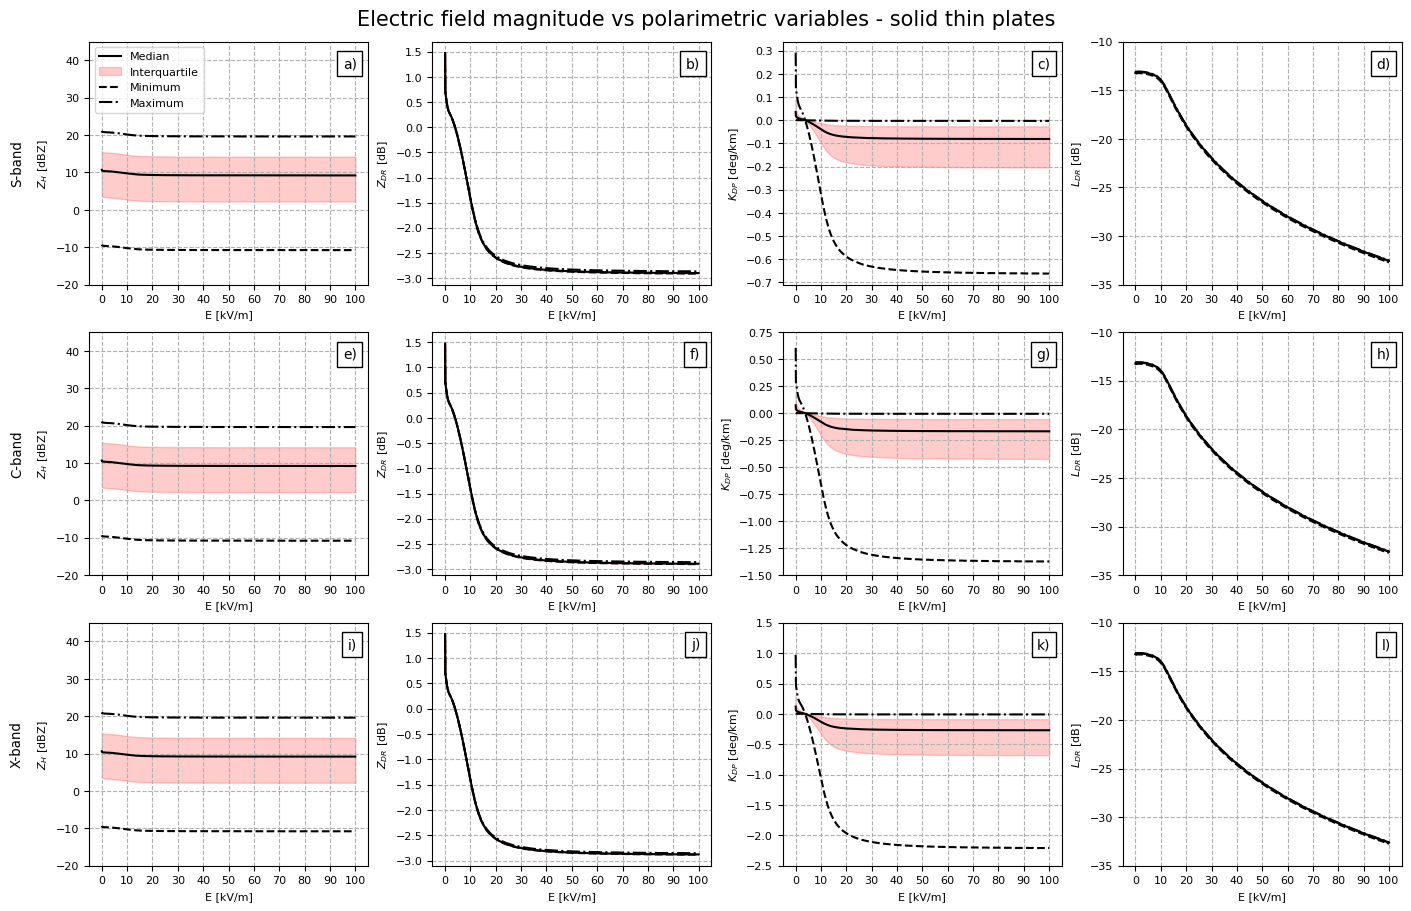

In [20]:
# compute statistics and plots
median_zhS = np.median(data_plateS['zh'], (0,1))
zhS_25 = np.percentile(data_plateS['zh'], 25, (0,1))
zhS_75 = np.percentile(data_plateS['zh'], 75, (0,1))
median_zdrS = np.median(data_plateS['zdr'], (0,1))
zdrS_25 = np.percentile(data_plateS['zdr'], 25, (0,1))
zdrS_75 = np.percentile(data_plateS['zdr'], 75, (0,1))
median_kdpS = np.median(data_plateS['kdp'], (0,1))
kdpS_25 = np.percentile(data_plateS['kdp'], 25, (0,1))
kdpS_75 = np.percentile(data_plateS['kdp'], 75, (0,1))
median_ldrS = np.median(data_plateS['ldr'], (0,1))
ldrS_25 = np.percentile(data_plateS['ldr'], 25, (0,1))
ldrS_75 = np.percentile(data_plateS['ldr'], 75, (0,1))

median_zhC = np.median(data_plateC['zh'], (0,1))
zhC_25 = np.percentile(data_plateC['zh'], 25, (0,1))
zhC_75 = np.percentile(data_plateC['zh'], 75, (0,1))
median_zdrC = np.median(data_plateC['zdr'], (0,1))
zdrC_25 = np.percentile(data_plateC['zdr'], 25, (0,1))
zdrC_75 = np.percentile(data_plateC['zdr'], 75, (0,1))
median_kdpC = np.median(data_plateC['kdp'], (0,1))
kdpC_25 = np.percentile(data_plateC['kdp'], 25, (0,1))
kdpC_75 = np.percentile(data_plateC['kdp'], 75, (0,1))
median_ldrC = np.median(data_plateC['ldr'], (0,1))
ldrC_25 = np.percentile(data_plateC['ldr'], 25, (0,1))
ldrC_75 = np.percentile(data_plateC['ldr'], 75, (0,1))

median_zhX = np.median(data_plateX['zh'], (0,1))
zhX_25 = np.percentile(data_plateX['zh'], 25, (0,1))
zhX_75 = np.percentile(data_plateX['zh'], 75, (0,1))
median_zdrX = np.median(data_plateX['zdr'], (0,1))
zdrX_25 = np.percentile(data_plateX['zdr'], 25, (0,1))
zdrX_75 = np.percentile(data_plateX['zdr'], 75, (0,1))
median_kdpX = np.median(data_plateX['kdp'], (0,1))
kdpX_25 = np.percentile(data_plateX['kdp'], 25, (0,1))
kdpX_75 = np.percentile(data_plateX['kdp'], 75, (0,1))
median_ldrX = np.median(data_plateX['ldr'], (0,1))
ldrX_25 = np.percentile(data_plateX['ldr'], 25, (0,1))
ldrX_75 = np.percentile(data_plateX['ldr'], 75, (0,1))


fig, axs = plt.subplots(3,4, figsize=[14,9], constrained_layout = True)

rows = [f'{row}' for row in ['S-band', 'C-band', 'X-band']]

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, rotation=90, textcoords='offset points',
                size='large', ha='right', va='center')

for n,ax in enumerate(axs.ravel()):
    if n == 0:
        ax.plot(E/1e3, median_zhS, c='k', label='Median')
        ax.fill_between(E/1e3, zhS_25, zhS_75, alpha=0.2, color='red', label = r'Interquartile')
        #ax.fill_between(E/1e3, np.subtract(mean_zhS, sd_zhS), np.add(mean_zhS, sd_zhS), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, np.min(data_plateS['zh'], (0,1)), c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, np.max(data_plateS['zh'], (0,1)), c='k', ls = '-.', label=r'Maximum')
        #ax.plot(E/1e3, zhS_1, c='k', ls = '--', label=r'$N_0=2\times10^4$ [m$^{-3}$ mm $^{-1}$], $D_0=0.3$')
        #ax.plot(E/1e3, zhS_99, c='k', ls = '-.', label=r'$N_0=2\times10^5$ [m$^{-3}$ mm $^{-1}$], $D_0=0.7$')
        ax.legend(loc = 'upper left', fontsize=8)
        ax.set_ylim(-20, 45)
        
    if n == 1:
        ax.plot(E/1e3, median_zdrS, c='k')
        ax.plot(E/1e3, np.min(data_plateS['zdr'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_plateS['zdr'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrS, sd_zdrS), np.add(mean_zdrS, sd_zdrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, zdrS_25, zdrS_75, alpha=0.2, color='red')
        #ax.plot(E/1e3, zdrS_1, c='k', ls = '--', label=r'$N_0=2\times10^4$ [m$^{-3}$ mm $^{-1}$], $D_0=0.3$')
        #ax.plot(E/1e3, zdrS_99, c='k', ls = '-.', label=r'$N_0=2\times10^5$ [m$^{-3}$ mm $^{-1}$], $D_0=0.7$')
        ax.set_yticks(np.arange(-3, 2, 0.5))
        #ax.set_ylim(-2.7, -2)
    
    if n == 2:    
        ax.plot(E/1e3, median_kdpS, c='k')
        ax.plot(E/1e3, np.min(data_plateS['kdp'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_plateS['kdp'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpS, sd_kdpS), np.add(mean_kdpS, sd_kdpS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, kdpS_25, kdpS_75, alpha=0.2, color='red')
        #ax.plot(E/1e3, kdpS_1, c='k', ls = '--', label=r'$N_0=2\times10^4$ [m$^{-3}$ mm $^{-1}$], $D_0=0.3$')
        #ax.plot(E/1e3, kdpS_99, c='k', ls = '-.', label=r'$N_0=2\times10^5$ [m$^{-3}$ mm $^{-1}$], $D_0=0.7$')
        ax.set_yticks(np.arange(-.7, .4, 0.1))

    if n == 3:        
        ax.plot(E/1e3, median_ldrS, c='k')
        ax.plot(E/1e3, np.min(data_plateS['ldr'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_plateS['ldr'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrS, sd_ldrS), np.add(mean_ldrS, sd_ldrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, ldrS_25, ldrS_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-35, -5, 5))

    if n == 4:
        ax.plot(E/1e3, median_zhC, c='k', label='Mean')
        #ax.fill_between(E/1e3, np.subtract(mean_zhC, sd_zhC), np.add(mean_zhC, sd_zhC), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, np.min(data_plateC['zh'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_plateC['zh'], (0,1)), c='k', ls = '-.')
        ax.fill_between(E/1e3, zhC_25, zhC_75, alpha=0.2, color='red')
        ax.set_ylim(-20, 45)
        
    if n == 5:
        ax.plot(E/1e3, median_zdrC, c='k')
        ax.plot(E/1e3, np.min(data_plateC['zdr'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_plateC['zdr'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrC, sd_zdrC), np.add(mean_zdrC, sd_zdrC), alpha=0.2, color='red')
        ax.fill_between(E/1e3, zdrC_25, zdrC_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-3, 2, 0.5))
    
    if n == 6:    
        ax.plot(E/1e3, median_kdpC, c='k')
        ax.plot(E/1e3, np.min(data_plateC['kdp'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_plateC['kdp'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpC, sd_kdpC), np.add(mean_kdpC, sd_kdpC), alpha=0.2, color='red')
        ax.fill_between(E/1e3, kdpC_25, kdpC_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-1.5, 1, 0.25))

    if n == 7:        
        ax.plot(E/1e3, median_ldrC, c='k')
        ax.plot(E/1e3, np.min(data_plateC['ldr'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_plateC['ldr'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrX, sd_ldrX), np.add(mean_ldrX, sd_ldrX), alpha=0.2, color='red')
        ax.fill_between(E/1e3, ldrC_25, ldrC_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-35, -5, 5))

    if n == 8:
        ax.plot(E/1e3, median_zhX, c='k', label='Mean')
        #ax.fill_between(E/1e3, np.subtract(mean_zhC, sd_zhC), np.add(mean_zhC, sd_zhC), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, np.min(data_plateX['zh'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_plateX['zh'], (0,1)), c='k', ls = '-.')
        ax.fill_between(E/1e3, zhX_25, zhX_75, alpha=0.2, color='red')
        ax.set_ylim(-20, 45)
        
    if n == 9:
        ax.plot(E/1e3, median_zdrX, c='k')
        ax.plot(E/1e3, np.min(data_plateX['zdr'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_plateX['zdr'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrC, sd_zdrC), np.add(mean_zdrC, sd_zdrC), alpha=0.2, color='red')
        ax.fill_between(E/1e3, zdrX_25, zdrX_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-3, 2, 0.5))
    
    if n == 10:    
        ax.plot(E/1e3, median_kdpX, c='k')
        ax.plot(E/1e3, np.min(data_plateX['kdp'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_plateX['kdp'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpC, sd_kdpC), np.add(mean_kdpC, sd_kdpC), alpha=0.2, color='red')
        ax.fill_between(E/1e3, kdpX_25, kdpX_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-2.5, 2, 0.5))

    if n == 11:        
        ax.plot(E/1e3, median_ldrX, c='k')
        ax.plot(E/1e3, np.min(data_plateX['ldr'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_plateX['ldr'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrX, sd_ldrX), np.add(mean_ldrX, sd_ldrX), alpha=0.2, color='red')
        ax.fill_between(E/1e3, ldrX_25, ldrX_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-35, -5, 5))

l = ['a)', 'b)', 'c)', 'd)','e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)']
for n, ax in enumerate(axs.ravel()):
    ax.set_xlabel('E [kV/m]')
    ax.set_xticks(np.arange(0, 110, 10))
    ax.annotate(l[n], xy = (0.96, 0.91), xycoords = 'axes fraction', ha = 'right', va = 'center', fontsize = 10, bbox={'facecolor':'white', 'clip_on':True}, zorder = 50)
    ax.grid(True, ls = '--', which = 'both')
    if (n == 0 or n == 4 or n == 8):
       ax.set_ylabel(r'$Z_{H}$ [dBZ]') 
    if (n == 1 or n == 5 or n == 9):
       ax.set_ylabel(r'$Z_{DR}$ [dB]')
    if (n == 2 or n == 6 or n == 10):
       ax.set_ylabel(r'$K_{DP}$ [deg/km]')
    if (n == 3 or n == 7 or n == 11):
       ax.set_ylabel(r'$L_{DR}$ [dB]')

fig.suptitle('Electric field magnitude vs polarimetric variables - solid thin plates', fontsize = 15)

plt.savefig(f'results_thins.png', bbox_inches = 'tight', dpi=300)

In [36]:
# read the solid thick plates look-up tables

with open('/home/vitorgoede/homework/radar_polarimetry/project/sim_full_plate2_S2.pkl',mode='rb') as f:
    data_plate2S = pd.read_pickle(f)[0]

with open('/home/vitorgoede/homework/radar_polarimetry/project/sim_full_plate2_C2.pkl',mode='rb') as f:
    data_plate2C = pickle.load(f)[0]

with open('/home/vitorgoede/homework/radar_polarimetry/project/sim_full_plate2_X2.pkl',mode='rb') as f:
    data_plate2X = pickle.load(f)[0]

for var in data_plate2S.keys():
    data_plate2S[var] = data_plate2S[var].astype(np.float16)

for var in data_plateC.keys():
    data_plate2C[var] = data_plate2C[var].astype(np.float16)

for var in data_plateX.keys():
    data_plate2X[var] = data_plate2X[var].astype(np.float16)

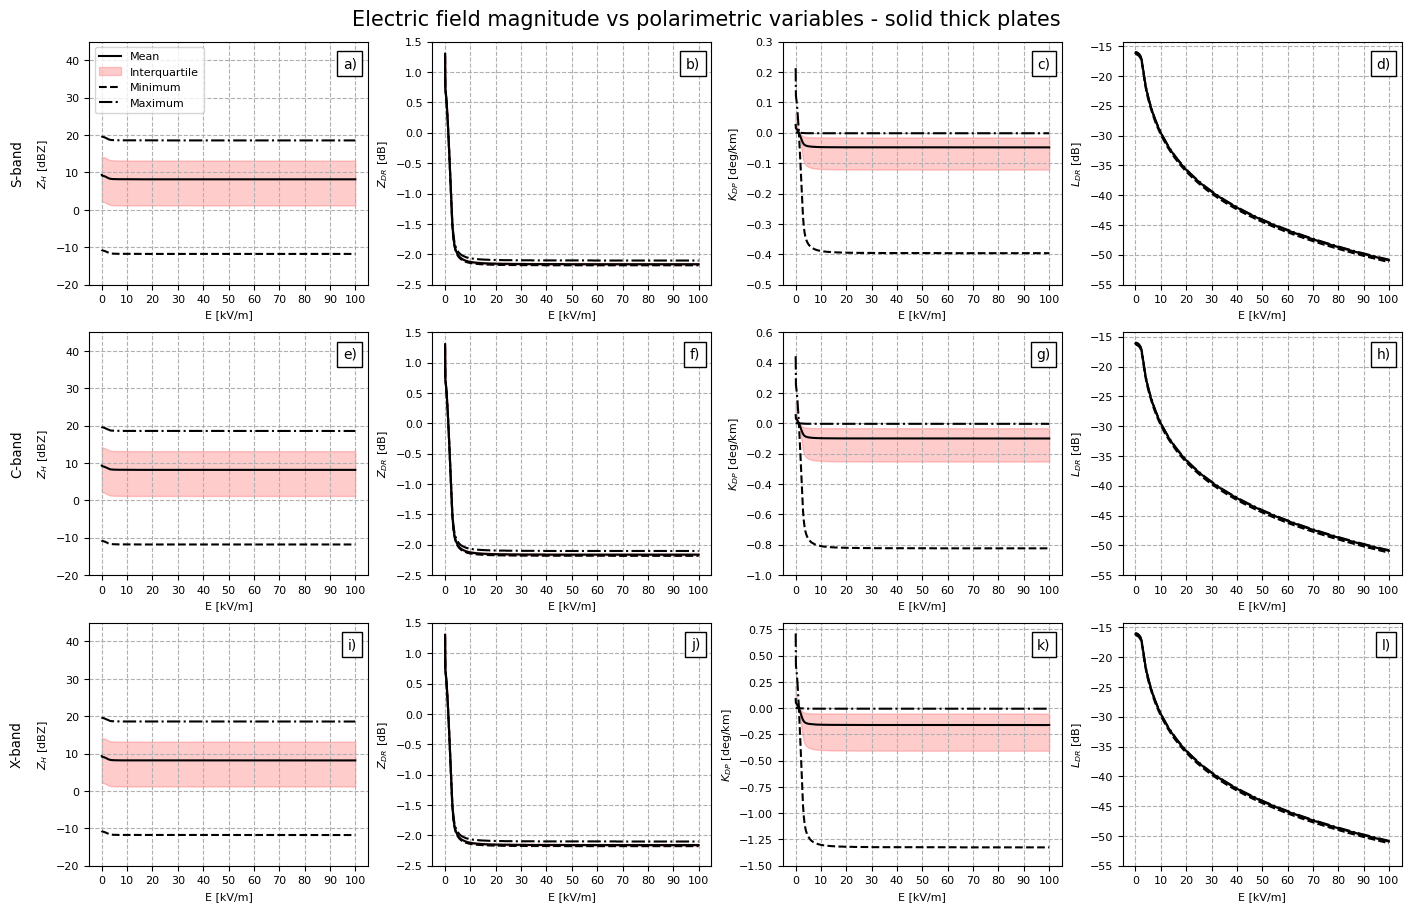

In [29]:
# compute statistics and plots
median_zhS = np.median(data_plate2S['zh'], (0,1))
zhS_25 = np.percentile(data_plate2S['zh'], 25, (0,1))
zhS_75 = np.percentile(data_plate2S['zh'], 75, (0,1))
median_zdrS = np.median(data_plate2S['zdr'], (0,1))
zdrS_25 = np.percentile(data_plate2S['zdr'], 25, (0,1))
zdrS_75 = np.percentile(data_plate2S['zdr'], 75, (0,1))
median_kdpS = np.median(data_plate2S['kdp'], (0,1))
kdpS_25 = np.percentile(data_plate2S['kdp'], 25, (0,1))
kdpS_75 = np.percentile(data_plate2S['kdp'], 75, (0,1))
median_ldrS = np.median(data_plate2S['ldr'], (0,1))
ldrS_25 = np.percentile(data_plate2S['ldr'], 25, (0,1))
ldrS_75 = np.percentile(data_plate2S['ldr'], 75, (0,1))

median_zhC = np.median(data_plate2C['zh'], (0,1))
zhC_25 = np.percentile(data_plate2C['zh'], 25, (0,1))
zhC_75 = np.percentile(data_plate2C['zh'], 75, (0,1))
median_zdrC = np.median(data_plate2C['zdr'], (0,1))
zdrC_25 = np.percentile(data_plate2C['zdr'], 25, (0,1))
zdrC_75 = np.percentile(data_plate2C['zdr'], 75, (0,1))
median_kdpC = np.median(data_plate2C['kdp'], (0,1))
kdpC_25 = np.percentile(data_plate2C['kdp'], 25, (0,1))
kdpC_75 = np.percentile(data_plate2C['kdp'], 75, (0,1))
median_ldrC = np.median(data_plate2C['ldr'], (0,1))
ldrC_25 = np.percentile(data_plate2C['ldr'], 25, (0,1))
ldrC_75 = np.percentile(data_plate2C['ldr'], 75, (0,1))

median_zhX = np.median(data_plate2X['zh'], (0,1))
zhX_25 = np.percentile(data_plate2X['zh'], 25, (0,1))
zhX_75 = np.percentile(data_plate2X['zh'], 75, (0,1))
median_zdrX = np.median(data_plate2X['zdr'], (0,1))
zdrX_25 = np.percentile(data_plate2X['zdr'], 25, (0,1))
zdrX_75 = np.percentile(data_plate2X['zdr'], 75, (0,1))
median_kdpX = np.median(data_plate2X['kdp'], (0,1))
kdpX_25 = np.percentile(data_plate2X['kdp'], 25, (0,1))
kdpX_75 = np.percentile(data_plate2X['kdp'], 75, (0,1))
median_ldrX = np.median(data_plate2X['ldr'], (0,1))
ldrX_25 = np.percentile(data_plate2X['ldr'], 25, (0,1))
ldrX_75 = np.percentile(data_plate2X['ldr'], 75, (0,1))

fig, axs = plt.subplots(3,4, figsize=[14,9], constrained_layout = True)

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, rotation=90, textcoords='offset points',
                size='large', ha='right', va='center')

for n,ax in enumerate(axs.ravel()):
    if n == 0:
        ax.plot(E/1e3, median_zhS, c='k', label='Mean')
        ax.fill_between(E/1e3, zhS_25, zhS_75, alpha=0.2, color='red', label = r'Interquartile')
        #ax.fill_between(E/1e3, np.subtract(mean_zhS, sd_zhS), np.add(mean_zhS, sd_zhS), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, np.min(data_plate2S['zh'], (0,1)), c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, np.max(data_plate2S['zh'], (0,1)), c='k', ls = '-.', label=r'Maximum')
        ax.legend(loc = 'upper left', fontsize=8)
        ax.set_ylim(-20, 45)
        
    if n == 1:
        ax.plot(E/1e3, median_zdrS, c='k')
        ax.plot(E/1e3, np.min(data_plate2S['zdr'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_plate2S['zdr'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrS, sd_zdrS), np.add(mean_zdrS, sd_zdrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, zdrS_25, zdrS_75, alpha=0.2, color='red',)
        ax.set_yticks(np.arange(-2.5, 2, 0.5))
        #ax.set_ylim(-2.7, -2)
    
    if n == 2:    
        ax.plot(E/1e3, median_kdpS, c='k')
        ax.plot(E/1e3, np.min(data_plate2S['kdp'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_plate2S['kdp'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpS, sd_kdpS), np.add(mean_kdpS, sd_kdpS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, kdpS_25, kdpS_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-0.5, 0.4, 0.1))

    if n == 3:        
        ax.plot(E/1e3, median_ldrS, c='k')
        ax.plot(E/1e3, np.min(data_plate2S['ldr'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_plate2S['ldr'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrS, sd_ldrS), np.add(mean_ldrS, sd_ldrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, ldrS_25, ldrS_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-55, -10, 5))

    if n == 4:
        ax.plot(E/1e3, median_zhC, c='k', label='Mean')
        #ax.fill_between(E/1e3, np.subtract(mean_zhC, sd_zhC), np.add(mean_zhC, sd_zhC), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, np.min(data_plate2C['zh'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_plate2C['zh'], (0,1)), c='k', ls = '-.')
        ax.fill_between(E/1e3, zhC_25, zhC_75, alpha=0.2, color='red')
        ax.set_ylim(-20, 45)
        
    if n == 5:
        ax.plot(E/1e3, median_zdrC, c='k')
        ax.plot(E/1e3, np.min(data_plate2C['zdr'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_plate2C['zdr'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrC, sd_zdrC), np.add(mean_zdrC, sd_zdrC), alpha=0.2, color='red')
        ax.fill_between(E/1e3, zdrC_25, zdrC_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-2.5, 2, 0.5))
    
    if n == 6:    
        ax.plot(E/1e3, median_kdpC, c='k')
        ax.plot(E/1e3, np.min(data_plate2C['kdp'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_plate2C['kdp'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpC, sd_kdpC), np.add(mean_kdpC, sd_kdpC), alpha=0.2, color='red')
        ax.fill_between(E/1e3, kdpC_25, kdpC_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-1., 0.8, 0.2))

    if n == 7:        
        ax.plot(E/1e3, median_ldrC, c='k')
        ax.plot(E/1e3, np.min(data_plate2C['ldr'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_plate2C['ldr'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrX, sd_ldrX), np.add(mean_ldrX, sd_ldrX), alpha=0.2, color='red')
        ax.set_yticks(np.arange(-55, -10, 5))

    if n == 8:
        ax.plot(E/1e3, median_zhX, c='k', label='Mean')
        #ax.fill_between(E/1e3, np.subtract(mean_zhC, sd_zhC), np.add(mean_zhC, sd_zhC), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, np.min(data_plate2X['zh'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_plate2X['zh'], (0,1)), c='k', ls = '-.')
        ax.fill_between(E/1e3, zhX_25, zhX_75, alpha=0.2, color='red',)
        ax.set_ylim(-20, 45)
        
    if n == 9:
        ax.plot(E/1e3, median_zdrX, c='k')
        ax.plot(E/1e3, np.min(data_plate2X['zdr'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_plate2X['zdr'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrC, sd_zdrC), np.add(mean_zdrC, sd_zdrC), alpha=0.2, color='red')
        ax.fill_between(E/1e3, zdrX_25, zdrX_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-2.5, 2, 0.5))
    
    if n == 10:    
        ax.plot(E/1e3, median_kdpX, c='k')
        ax.plot(E/1e3, np.min(data_plate2X['kdp'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_plate2X['kdp'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpC, sd_kdpC), np.add(mean_kdpC, sd_kdpC), alpha=0.2, color='red')
        ax.fill_between(E/1e3, kdpX_25, kdpX_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-1.5, 1, 0.25))

    if n == 11:        
        ax.plot(E/1e3, median_ldrX, c='k')
        ax.plot(E/1e3, np.min(data_plate2X['ldr'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_plate2X['ldr'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrX, sd_ldrX), np.add(mean_ldrX, sd_ldrX), alpha=0.2, color='red')
        ax.fill_between(E/1e3, ldrX_25, ldrX_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-55, -10, 5))

l = ['a)', 'b)', 'c)', 'd)','e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)']
for n, ax in enumerate(axs.ravel()):
    ax.set_xlabel('E [kV/m]')
    ax.set_xticks(np.arange(0, 110, 10))
    ax.annotate(l[n], xy = (0.96, 0.91), xycoords = 'axes fraction', ha = 'right', va = 'center', fontsize = 10, bbox={'facecolor':'white', 'clip_on':True}, zorder = 50)
    ax.grid(True, ls = '--', which = 'both')
    if (n == 0 or n == 4 or n == 8):
       ax.set_ylabel(r'$Z_{H}$ [dBZ]') 
    if (n == 1 or n == 5 or n == 9):
       ax.set_ylabel(r'$Z_{DR}$ [dB]')
    if (n == 2 or n == 6 or n == 10):
       ax.set_ylabel(r'$K_{DP}$ [deg/km]')
    if (n == 3 or n == 7 or n == 11):
       ax.set_ylabel(r'$L_{DR}$ [dB]')

fig.suptitle('Electric field magnitude vs polarimetric variables - solid thick plates', fontsize = 15)

plt.savefig(f'results_thicks.png', bbox_inches = 'tight', dpi=300)

In [37]:
# read the solid short plates look-up tables
with open('/home/vitorgoede/homework/radar_polarimetry/project/sim_full_column1_S3.pkl',mode='rb') as f:
    data_colS = pickle.load(f)[0]

with open('/home/vitorgoede/homework/radar_polarimetry/project/sim_full_column1_C3.pkl',mode='rb') as f:
    data_colC = pickle.load(f)[0]

with open('/home/vitorgoede/homework/radar_polarimetry/project/sim_full_column1_X3.pkl',mode='rb') as f:
    data_colX = pickle.load(f)[0]

for var in data_colS.keys():
    data_colS[var] = data_colS[var].astype(np.float16)

for var in data_plateC.keys():
    data_colC[var] = data_colC[var].astype(np.float16)

for var in data_plateX.keys():
    data_colX[var] = data_colX[var].astype(np.float16)

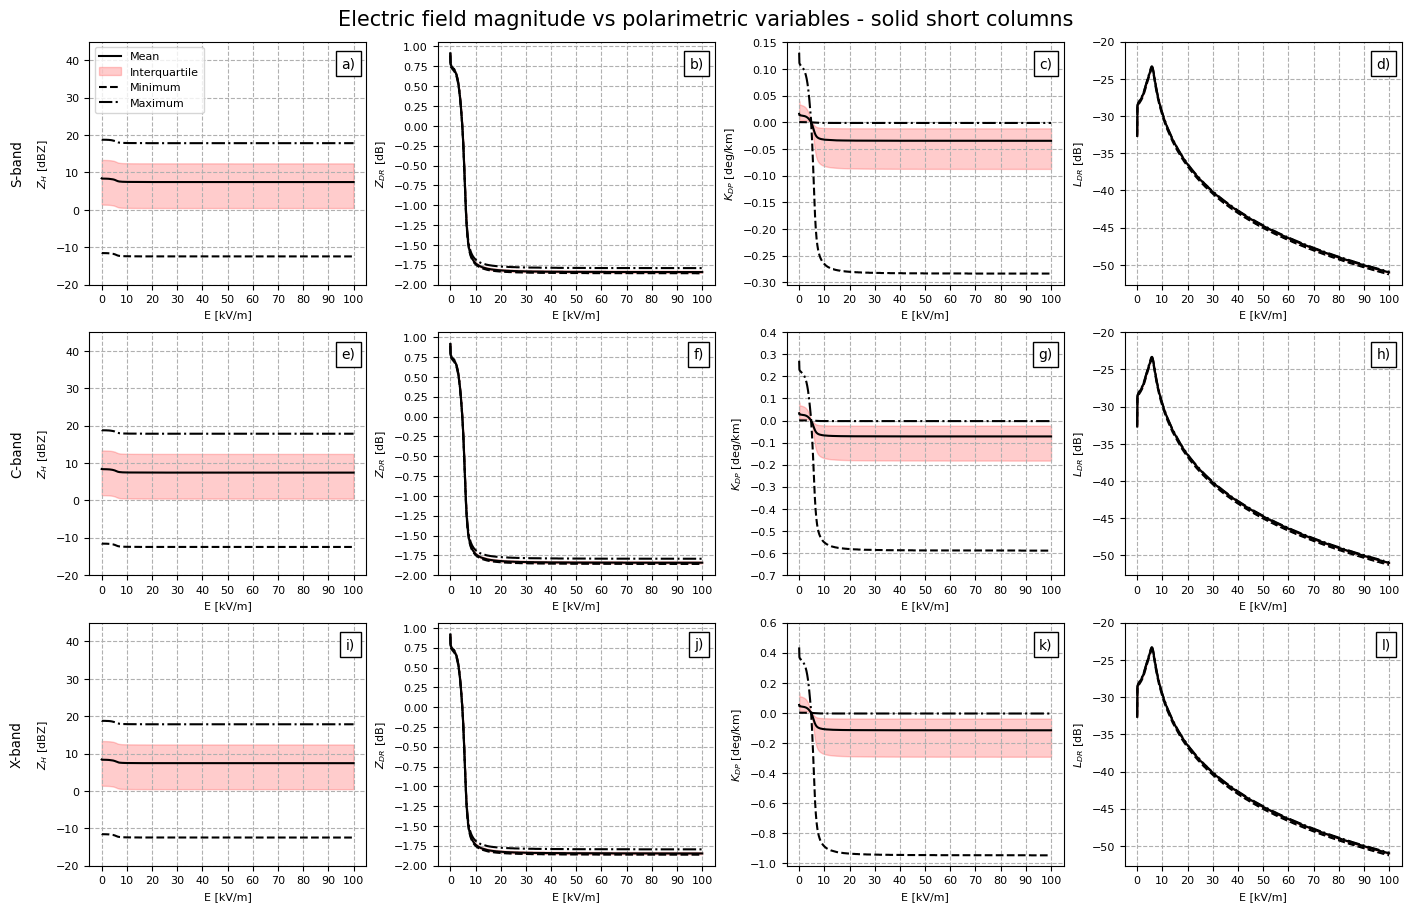

In [35]:
# compute statistics and plots
median_zhS = np.median(data_colS['zh'], (0,1))
zhS_25 = np.percentile(data_colS['zh'], 25, (0,1))
zhS_75 = np.percentile(data_colS['zh'], 75, (0,1))
median_zdrS = np.median(data_colS['zdr'], (0,1))
zdrS_25 = np.percentile(data_colS['zdr'], 25, (0,1))
zdrS_75 = np.percentile(data_colS['zdr'], 75, (0,1))
median_kdpS = np.median(data_colS['kdp'], (0,1))
kdpS_25 = np.percentile(data_colS['kdp'], 25, (0,1))
kdpS_75 = np.percentile(data_colS['kdp'], 75, (0,1))
median_ldrS = np.median(data_colS['ldr'], (0,1))
ldrS_25 = np.percentile(data_colS['ldr'], 25, (0,1))
ldrS_75 = np.percentile(data_colS['ldr'], 75, (0,1))

median_zhC = np.median(data_colC['zh'], (0,1))
zhC_25 = np.percentile(data_colC['zh'], 25, (0,1))
zhC_75 = np.percentile(data_colC['zh'], 75, (0,1))
median_zdrC = np.median(data_colC['zdr'], (0,1))
zdrC_25 = np.percentile(data_colC['zdr'], 25, (0,1))
zdrC_75 = np.percentile(data_colC['zdr'], 75, (0,1))
median_kdpC = np.median(data_colC['kdp'], (0,1))
kdpC_25 = np.percentile(data_colC['kdp'], 25, (0,1))
kdpC_75 = np.percentile(data_colC['kdp'], 75, (0,1))
median_ldrC = np.median(data_colC['ldr'], (0,1))
ldrC_25 = np.percentile(data_colC['ldr'], 25, (0,1))
ldrC_75 = np.percentile(data_colC['ldr'], 75, (0,1))

median_zhX = np.median(data_colX['zh'], (0,1))
zhX_25 = np.percentile(data_colX['zh'], 25, (0,1))
zhX_75 = np.percentile(data_colX['zh'], 75, (0,1))
median_zdrX = np.median(data_colX['zdr'], (0,1))
zdrX_25 = np.percentile(data_colX['zdr'], 25, (0,1))
zdrX_75 = np.percentile(data_colX['zdr'], 75, (0,1))
median_kdpX = np.median(data_colX['kdp'], (0,1))
kdpX_25 = np.percentile(data_colX['kdp'], 25, (0,1))
kdpX_75 = np.percentile(data_colX['kdp'], 75, (0,1))
median_ldrX = np.median(data_colX['ldr'], (0,1))
ldrX_25 = np.percentile(data_colX['ldr'], 25, (0,1))
ldrX_75 = np.percentile(data_colX['ldr'], 75, (0,1))

fig, axs = plt.subplots(3,4, figsize=[14,9], constrained_layout = True)

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, rotation=90, textcoords='offset points',
                size='large', ha='right', va='center')

for n,ax in enumerate(axs.ravel()):
    if n == 0:
        ax.plot(E/1e3, median_zhS, c='k', label='Mean')
        ax.fill_between(E/1e3, zhS_25, zhS_75, alpha=0.2, color='red', label = r'Interquartile')
        #ax.fill_between(E/1e3, np.subtract(mean_zhS, sd_zhS), np.add(mean_zhS, sd_zhS), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, np.min(data_colS['zh'], (0,1)), c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, np.max(data_colS['zh'], (0,1)), c='k', ls = '-.', label=r'Maximum')
        ax.legend(loc = 'upper left', fontsize=8)
        ax.set_ylim(-20, 45)
        
    if n == 1:
        ax.plot(E/1e3, median_zdrS, c='k')
        ax.plot(E/1e3, np.min(data_colS['zdr'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_colS['zdr'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrS, sd_zdrS), np.add(mean_zdrS, sd_zdrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, zdrS_25, zdrS_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-2, 1.25, 0.25))
        #ax.set_ylim(-2.7, -2)
    
    if n == 2:    
        ax.plot(E/1e3, median_kdpS, c='k')
        ax.plot(E/1e3, np.min(data_colS['kdp'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_colS['kdp'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpS, sd_kdpS), np.add(mean_kdpS, sd_kdpS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, kdpS_25, kdpS_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-0.3, 0.20, 0.05))

    if n == 3:        
        ax.plot(E/1e3, median_ldrS, c='k')
        ax.plot(E/1e3, np.min(data_colS['ldr'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_colS['ldr'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrS, sd_ldrS), np.add(mean_ldrS, sd_ldrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, ldrS_25, ldrS_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-50, -15, 5))

    if n == 4:
        ax.plot(E/1e3, median_zhC, c='k', label='Mean')
        #ax.fill_between(E/1e3, np.subtract(mean_zhC, sd_zhC), np.add(mean_zhC, sd_zhC), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, np.min(data_colC['zh'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_colC['zh'], (0,1)), c='k', ls = '-.')
        ax.fill_between(E/1e3, zhC_25, zhC_75, alpha=0.2, color='red')
        ax.set_ylim(-20, 45)
        
    if n == 5:
        ax.plot(E/1e3, median_zdrC, c='k')
        ax.plot(E/1e3, np.min(data_colC['zdr'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_colC['zdr'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrC, sd_zdrC), np.add(mean_zdrC, sd_zdrC), alpha=0.2, color='red')
        ax.fill_between(E/1e3, zdrC_25, zdrC_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-2, 1.25, 0.25))
    
    if n == 6:    
        ax.plot(E/1e3, median_kdpC, c='k')
        ax.plot(E/1e3, np.min(data_colC['kdp'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_colC['kdp'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpC, sd_kdpC), np.add(mean_kdpC, sd_kdpC), alpha=0.2, color='red')
        ax.fill_between(E/1e3, kdpC_25, kdpC_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-0.7, 0.5, 0.1))

    if n == 7:        
        ax.plot(E/1e3, median_ldrC, c='k')
        ax.plot(E/1e3, np.min(data_colC['ldr'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_colC['ldr'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrX, sd_ldrX), np.add(mean_ldrX, sd_ldrX), alpha=0.2, color='red')
        ax.fill_between(E/1e3, ldrC_25, ldrC_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-50, -15, 5))

    if n == 8:
        ax.plot(E/1e3, median_zhX, c='k', label='Mean')
        #ax.fill_between(E/1e3, np.subtract(mean_zhC, sd_zhC), np.add(mean_zhC, sd_zhC), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, np.min(data_colX['zh'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_colX['zh'], (0,1)), c='k', ls = '-.')
        ax.fill_between(E/1e3, zhX_25, zhX_75, alpha=0.2, color='red')
        ax.set_ylim(-20, 45)
        
    if n == 9:
        ax.plot(E/1e3, median_zdrX, c='k')
        ax.plot(E/1e3, np.min(data_colX['zdr'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_colX['zdr'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrC, sd_zdrC), np.add(mean_zdrC, sd_zdrC), alpha=0.2, color='red')
        ax.fill_between(E/1e3, zdrX_25, zdrX_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-2, 1.25, 0.25))
    
    if n == 10:    
        ax.plot(E/1e3, median_kdpX, c='k')
        ax.plot(E/1e3, np.min(data_colX['kdp'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_colX['kdp'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpC, sd_kdpC), np.add(mean_kdpC, sd_kdpC), alpha=0.2, color='red')
        ax.fill_between(E/1e3, kdpX_25, kdpX_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-1, 0.8, 0.2))

    if n == 11:        
        ax.plot(E/1e3, median_ldrX, c='k')
        ax.plot(E/1e3, np.min(data_colX['ldr'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_colX['ldr'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrX, sd_ldrX), np.add(mean_ldrX, sd_ldrX), alpha=0.2, color='red')
        ax.fill_between(E/1e3, ldrX_25, ldrX_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-50, -15, 5))

l = ['a)', 'b)', 'c)', 'd)','e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)']
for n, ax in enumerate(axs.ravel()):
    ax.set_xlabel('E [kV/m]')
    ax.set_xticks(np.arange(0, 110, 10))
    ax.annotate(l[n], xy = (0.96, 0.91), xycoords = 'axes fraction', ha = 'right', va = 'center', fontsize = 10, bbox={'facecolor':'white', 'clip_on':True}, zorder = 50)
    ax.grid(True, ls = '--', which = 'both')
    if (n == 0 or n == 4 or n == 8):
       ax.set_ylabel(r'$Z_{H}$ [dBZ]') 
    if (n == 1 or n == 5 or n == 9):
       ax.set_ylabel(r'$Z_{DR}$ [dB]')
    if (n == 2 or n == 6 or n == 10):
       ax.set_ylabel(r'$K_{DP}$ [deg/km]')
    if (n == 3 or n == 7 or n == 11):
       ax.set_ylabel(r'$L_{DR}$ [dB]')

fig.suptitle('Electric field magnitude vs polarimetric variables - solid short columns', fontsize = 15)

plt.savefig(f'results_short.png', bbox_inches = 'tight', dpi=300)

In [38]:
# read the solid long plates look-up tables
with open('/home/vitorgoede/homework/radar_polarimetry/project/sim_full_column2_S3.pkl',mode='rb') as f:
    data_col2S = pickle.load(f)[0]

with open('/home/vitorgoede/homework/radar_polarimetry/project/sim_full_column2_C3.pkl',mode='rb') as f:
    data_col2C = pickle.load(f)[0]

with open('/home/vitorgoede/homework/radar_polarimetry/project/sim_full_column2_X3.pkl',mode='rb') as f:
    data_col2X = pickle.load(f)[0]

for var in data_col2S.keys():
    data_col2S[var] = data_col2S[var].astype(np.float16)

for var in data_col2C.keys():
    data_col2C[var] = data_col2C[var].astype(np.float16)

for var in data_col2X.keys():
    data_col2X[var] = data_col2X[var].astype(np.float16)

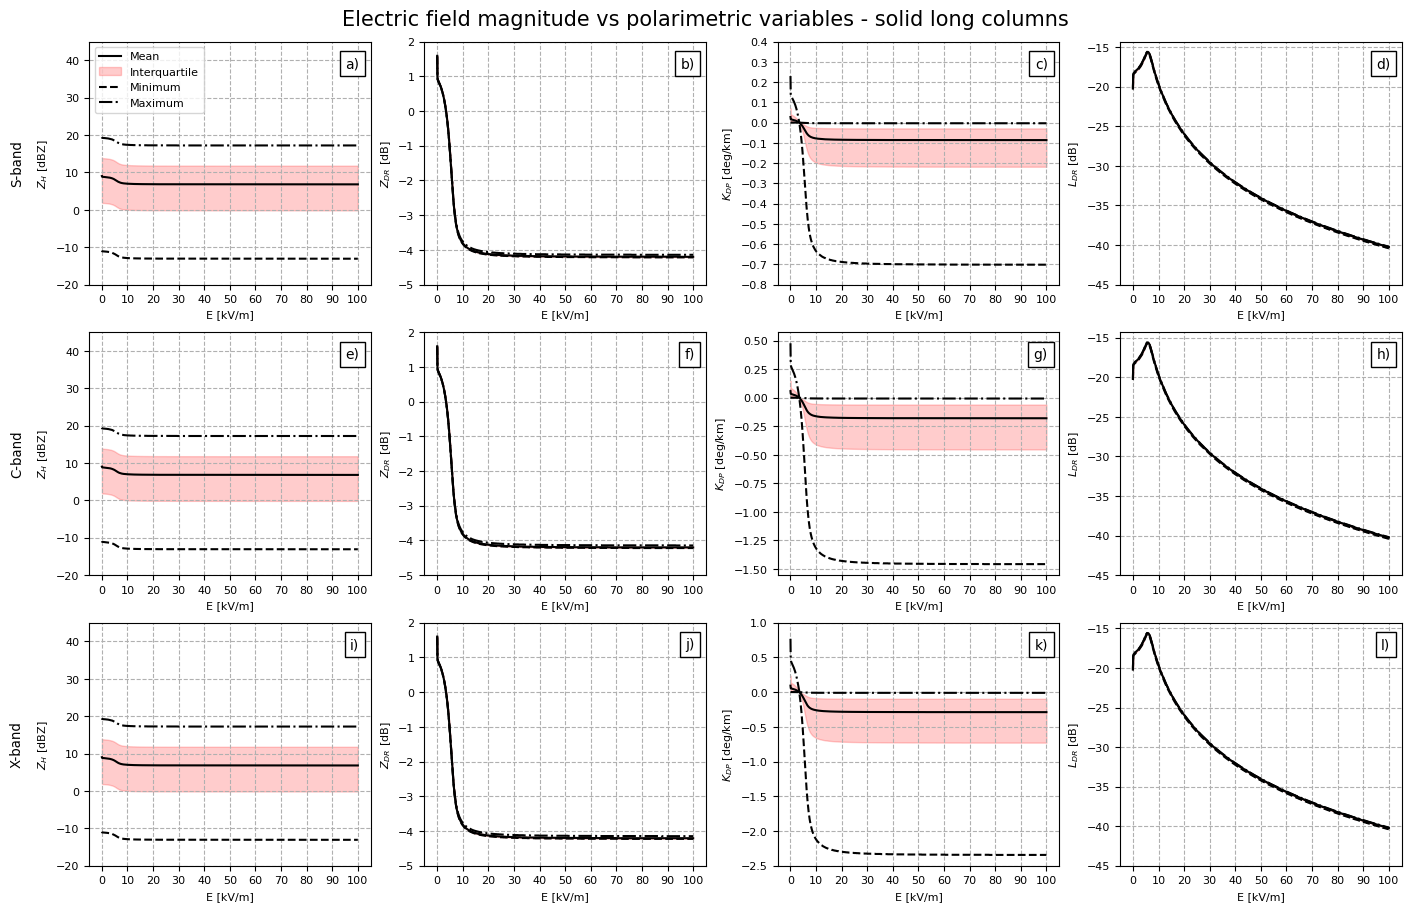

In [40]:
# compute statistics and plots
median_zhS = np.median(data_col2S['zh'], (0,1))
zhS_25 = np.percentile(data_col2S['zh'], 25, (0,1))
zhS_75 = np.percentile(data_col2S['zh'], 75, (0,1))
median_zdrS = np.median(data_col2S['zdr'], (0,1))
zdrS_25 = np.percentile(data_col2S['zdr'], 25, (0,1))
zdrS_75 = np.percentile(data_col2S['zdr'], 75, (0,1))
median_kdpS = np.median(data_col2S['kdp'], (0,1))
kdpS_25 = np.percentile(data_col2S['kdp'], 25, (0,1))
kdpS_75 = np.percentile(data_col2S['kdp'], 75, (0,1))
median_ldrS = np.median(data_col2S['ldr'], (0,1))
ldrS_25 = np.percentile(data_col2S['ldr'], 25, (0,1))
ldrS_75 = np.percentile(data_col2S['ldr'], 75, (0,1))

median_zhC = np.median(data_col2C['zh'], (0,1))
zhC_25 = np.percentile(data_col2C['zh'], 25, (0,1))
zhC_75 = np.percentile(data_col2C['zh'], 75, (0,1))
median_zdrC = np.median(data_col2C['zdr'], (0,1))
zdrC_25 = np.percentile(data_col2C['zdr'], 25, (0,1))
zdrC_75 = np.percentile(data_col2C['zdr'], 75, (0,1))
median_kdpC = np.median(data_col2C['kdp'], (0,1))
kdpC_25 = np.percentile(data_col2C['kdp'], 25, (0,1))
kdpC_75 = np.percentile(data_col2C['kdp'], 75, (0,1))
median_ldrC = np.median(data_col2C['ldr'], (0,1))
ldrC_25 = np.percentile(data_col2C['ldr'], 25, (0,1))
ldrC_75 = np.percentile(data_col2C['ldr'], 75, (0,1))

median_zhX = np.median(data_col2X['zh'], (0,1))
zhX_25 = np.percentile(data_col2X['zh'], 25, (0,1))
zhX_75 = np.percentile(data_col2X['zh'], 75, (0,1))
median_zdrX = np.median(data_col2X['zdr'], (0,1))
zdrX_25 = np.percentile(data_col2X['zdr'], 25, (0,1))
zdrX_75 = np.percentile(data_col2X['zdr'], 75, (0,1))
median_kdpX = np.median(data_col2X['kdp'], (0,1))
kdpX_25 = np.percentile(data_col2X['kdp'], 25, (0,1))
kdpX_75 = np.percentile(data_col2X['kdp'], 75, (0,1))
median_ldrX = np.median(data_col2X['ldr'], (0,1))
ldrX_25 = np.percentile(data_col2X['ldr'], 25, (0,1))
ldrX_75 = np.percentile(data_col2X['ldr'], 75, (0,1))

fig, axs = plt.subplots(3,4, figsize=[14,9], constrained_layout = True)

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, rotation=90, textcoords='offset points',
                size='large', ha='right', va='center')

for n,ax in enumerate(axs.ravel()):
    if n == 0:
        ax.plot(E/1e3, median_zhS, c='k', label='Mean')
        ax.fill_between(E/1e3, zhS_25, zhS_75, alpha=0.2, color='red', label = r'Interquartile')
        #ax.fill_between(E/1e3, np.subtract(mean_zhS, sd_zhS), np.add(mean_zhS, sd_zhS), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, np.min(data_col2S['zh'], (0,1)), c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, np.max(data_col2S['zh'], (0,1)), c='k', ls = '-.', label=r'Maximum')
        ax.legend(loc = 'upper left', fontsize=8)
        ax.set_ylim(-20, 45)
        
    if n == 1:
        ax.plot(E/1e3, median_zdrS, c='k')
        ax.plot(E/1e3, np.min(data_col2S['zdr'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_col2S['zdr'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrS, sd_zdrS), np.add(mean_zdrS, sd_zdrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, zdrS_25, zdrS_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-5, 3, 1))
        #ax.set_ylim(-2.7, -2)
    
    if n == 2:    
        ax.plot(E/1e3, median_kdpS, c='k')
        ax.plot(E/1e3, np.min(data_col2S['kdp'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_col2S['kdp'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpS, sd_kdpS), np.add(mean_kdpS, sd_kdpS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, kdpS_25, kdpS_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-0.8, 0.4, 0.1))

    if n == 3:        
        ax.plot(E/1e3, median_ldrS, c='k')
        ax.plot(E/1e3, np.min(data_col2S['ldr'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_col2S['ldr'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrS, sd_ldrS), np.add(mean_ldrS, sd_ldrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, ldrS_25, ldrS_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-45, -10, 5))

    if n == 4:
        ax.plot(E/1e3, median_zhC, c='k', label='Mean')
        #ax.fill_between(E/1e3, np.subtract(mean_zhC, sd_zhC), np.add(mean_zhC, sd_zhC), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, np.min(data_col2C['zh'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_col2C['zh'], (0,1)), c='k', ls = '-.')
        ax.fill_between(E/1e3, zhC_25, zhC_75, alpha=0.2, color='red')
        ax.set_ylim(-20, 45)
        
    if n == 5:
        ax.plot(E/1e3, median_zdrC, c='k')
        ax.plot(E/1e3, np.min(data_col2C['zdr'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_col2C['zdr'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrC, sd_zdrC), np.add(mean_zdrC, sd_zdrC), alpha=0.2, color='red')
        ax.fill_between(E/1e3, zdrC_25, zdrC_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-5, 3, 1))
    
    if n == 6:    
        ax.plot(E/1e3, median_kdpC, c='k')
        ax.plot(E/1e3, np.min(data_col2C['kdp'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_col2C['kdp'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpC, sd_kdpC), np.add(mean_kdpC, sd_kdpC), alpha=0.2, color='red')
        ax.fill_between(E/1e3, kdpC_25, kdpC_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-1.5, 0.75, 0.25))

    if n == 7:        
        ax.plot(E/1e3, median_ldrC, c='k')
        ax.plot(E/1e3, np.min(data_col2C['ldr'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_col2C['ldr'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrX, sd_ldrX), np.add(mean_ldrX, sd_ldrX), alpha=0.2, color='red')
        ax.fill_between(E/1e3, ldrC_25, ldrC_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-45, -10, 5))

    if n == 8:
        ax.plot(E/1e3, median_zhX, c='k', label='Mean')
        #ax.fill_between(E/1e3, np.subtract(mean_zhC, sd_zhC), np.add(mean_zhC, sd_zhC), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, np.min(data_col2X['zh'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_col2X['zh'], (0,1)), c='k', ls = '-.')
        ax.fill_between(E/1e3, zhX_25, zhX_75, alpha=0.2, color='red')
        ax.set_ylim(-20, 45)
        
    if n == 9:
        ax.plot(E/1e3, median_zdrX, c='k')
        ax.plot(E/1e3, np.min(data_col2X['zdr'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_col2X['zdr'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrC, sd_zdrC), np.add(mean_zdrC, sd_zdrC), alpha=0.2, color='red')
        ax.fill_between(E/1e3, zdrX_25, zdrX_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-5, 3, 1))
    
    if n == 10:    
        ax.plot(E/1e3, median_kdpX, c='k')
        ax.plot(E/1e3, np.min(data_col2X['kdp'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_col2X['kdp'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpC, sd_kdpC), np.add(mean_kdpC, sd_kdpC), alpha=0.2, color='red')
        ax.fill_between(E/1e3, kdpX_25, kdpX_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-2.5, 1.5, 0.5))

    if n == 11:        
        ax.plot(E/1e3, median_ldrX, c='k')
        ax.plot(E/1e3, np.min(data_col2X['ldr'], (0,1)), c='k', ls = '--')
        ax.plot(E/1e3, np.max(data_col2X['ldr'], (0,1)), c='k', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrX, sd_ldrX), np.add(mean_ldrX, sd_ldrX), alpha=0.2, color='red')
        ax.fill_between(E/1e3, ldrX_25, ldrX_75, alpha=0.2, color='red')
        ax.set_yticks(np.arange(-45, -10, 5))

l = ['a)', 'b)', 'c)', 'd)','e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)']
for n, ax in enumerate(axs.ravel()):
    ax.set_xlabel('E [kV/m]')
    ax.set_xticks(np.arange(0, 110, 10))
    ax.annotate(l[n], xy = (0.96, 0.91), xycoords = 'axes fraction', ha = 'right', va = 'center', fontsize = 10, bbox={'facecolor':'white', 'clip_on':True}, zorder = 50)
    ax.grid(True, ls = '--', which = 'both')
    if (n == 0 or n == 4 or n == 8):
       ax.set_ylabel(r'$Z_{H}$ [dBZ]') 
    if (n == 1 or n == 5 or n == 9):
       ax.set_ylabel(r'$Z_{DR}$ [dB]')
    if (n == 2 or n == 6 or n == 10):
       ax.set_ylabel(r'$K_{DP}$ [deg/km]')
    if (n == 3 or n == 7 or n == 11):
       ax.set_ylabel(r'$L_{DR}$ [dB]')

fig.suptitle('Electric field magnitude vs polarimetric variables - solid long columns', fontsize = 15)

plt.savefig(f'results_long.png', bbox_inches = 'tight', dpi=300)

In [39]:
# read the graupel look-up tables
with open('/home/vitorgoede/homework/radar_polarimetry/project/sim_full_graupel_S2.pkl',mode='rb') as f:
    data_graupelS = pickle.load(f)[0]

with open('/home/vitorgoede/homework/radar_polarimetry/project/sim_full_graupel_C2.pkl',mode='rb') as f:
    data_graupelC = pickle.load(f)[0]

with open('/home/vitorgoede/homework/radar_polarimetry/project/sim_full_graupel_X2.pkl',mode='rb') as f:
    data_graupelX = pickle.load(f)[0]

for var in data_graupelS.keys():
    data_graupelS[var] = data_graupelS[var].astype(np.float16)

for var in data_graupelC.keys():
    data_graupelC[var] = data_graupelC[var].astype(np.float16)

for var in data_graupelX.keys():
    data_graupelX[var] = data_graupelX[var].astype(np.float16)

Text(0, 0.5, '$LDR$ [dBZ]')

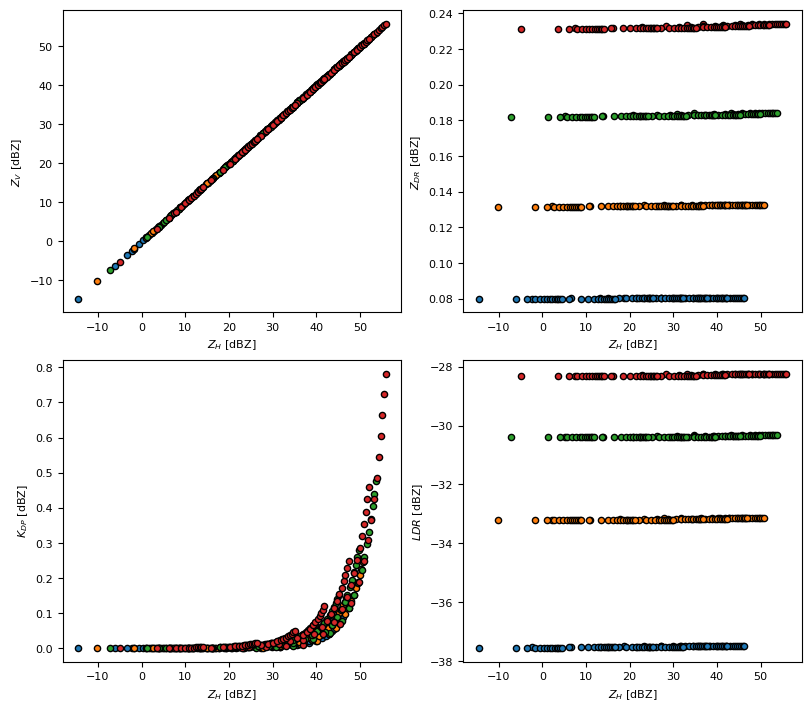

In [40]:
# sanity check
fig, axs = plt.subplots(2,2, figsize=[8,7], constrained_layout = True)

[axs.ravel()[0].scatter(zh, zv, s=20, edgecolor='k') for zh,zv in zip(data_graupelS['zh'], data_graupelS['zv'])]
axs.ravel()[0].set_xlabel(r'$Z_{H}$ [dBZ]')
axs.ravel()[0].set_ylabel(r'$Z_{V}$ [dBZ]')

[axs.ravel()[1].scatter(zh, zdr, s=20, edgecolor='k') for zh,zdr in zip(data_graupelS['zh'], data_graupelS['zdr'])]
axs.ravel()[1].set_xlabel(r'$Z_{H}$ [dBZ]')
axs.ravel()[1].set_ylabel(r'$Z_{DR}$ [dBZ]')

[axs.ravel()[2].scatter(zh, kdp, s=20, edgecolor='k') for zh,kdp in zip(data_graupelS['zh'], data_graupelS['kdp'])]
axs.ravel()[2].set_xlabel(r'$Z_{H}$ [dBZ]')
axs.ravel()[2].set_ylabel(r'$K_{DP}$ [dBZ]')

[axs.ravel()[3].scatter(zh, ldr, s=20, edgecolor='k') for zh,ldr in zip(data_graupelS['zh'], data_graupelS['ldr'])]
axs.ravel()[3].set_xlabel(r'$Z_{H}$ [dBZ]')
axs.ravel()[3].set_ylabel(r'$LDR$ [dBZ]')

In [50]:
#mix the pristine crystals and with the graupel. Need to split the files as they can get too heacy.

h = 3

mix_thinplates_ZHS = []
mix_thinplates_ZDRS = []
mix_thinplates_KDPS = []
mix_thinplates_LDRS = []

for i in range(data_graupelS['kdp'].shape[1]):
    for j in range(data_graupelS['kdp'].shape[2]):
        for k in range(data_plateS['kdp'].shape[0]):
            for l in range(data_plateS['kdp'].shape[1]):
                    mix_thinplates_ZHS.append(10*np.log10((10**(np.array(data_plateS['zh'][k,l])/10) + 10**(np.array(data_graupelS['zh'][h,i,j])/10))))
                    mix_thinplates_ZDRS.append(10*np.log10((10**(np.array(data_plateS['zh'][k,l])/10) + 10**(np.array(data_graupelS['zh'][h,i,j])/10))/
                                               (10**(np.array(data_plateS['zv'][k,l])/10) + 10**(np.array(data_graupelS['zv'][h,i,j])/10))))
                    mix_thinplates_KDPS.append(data_plateS['kdp'][k,l] + data_graupelS['kdp'][h,i,j])
                    mix_thinplates_LDRS.append(10*np.log10(10**(np.array(data_plateS['ldr'][k,l])/10) + 10**(np.array(data_graupelS['ldr'][h,i,j])/10)))

mix_thinplates_ZHC = []
mix_thinplates_ZDRC = []
mix_thinplates_KDPC = []
mix_thinplates_LDRC = []
for i in range(data_graupelC['kdp'].shape[1]):
    for j in range(data_graupelC['kdp'].shape[2]):
        for k in range(data_plateC['kdp'].shape[0]):
            for l in range(data_plateC['kdp'].shape[1]):
                mix_thinplates_ZHC.append(10*np.log10((10**(np.array(data_plateC['zh'][k,l])/10) + 10**(np.array(data_graupelC['zh'][h,i,j])/10))))
                mix_thinplates_ZDRC.append(10*np.log10((10**(np.array(data_plateC['zh'][k,l])/10) + 10**(np.array(data_graupelC['zh'][h,i,j])/10))/
                                           (10**(np.array(data_plateC['zv'][k,l])/10) + 10**(np.array(data_graupelC['zv'][h,i,j])/10))))
                mix_thinplates_KDPC.append(data_plateC['kdp'][k,l] + data_graupelC['kdp'][h,i,j])
                mix_thinplates_LDRC.append(10*np.log10(10**(np.array(data_plateC['ldr'][k,l])/10) + 10**(np.array(data_graupelC['ldr'][h,i,j])/10)))

mix_thinplates_ZHX = []
mix_thinplates_ZDRX = []
mix_thinplates_KDPX = []
mix_thinplates_LDRX = []
for i in range(data_graupelX['kdp'].shape[1]):
    for j in range(data_graupelX['kdp'].shape[2]):
        for k in range(data_plateX['kdp'].shape[0]):
            for l in range(data_plateX['kdp'].shape[1]):
                mix_thinplates_ZHX.append(10*np.log10((10**(np.array(data_plateX['zh'][k,l])/10) + 10**(np.array(data_graupelX['zh'][h,i,j])/10))))
                mix_thinplates_ZDRX.append(10*np.log10((10**(np.array(data_plateX['zh'][k,l])/10) + 10**(np.array(data_graupelX['zh'][h,i,j])/10))/
                                           (10**(np.array(data_plateX['zv'][k,l])/10) + 10**(np.array(data_graupelX['zv'][h,i,j])/10))))
                mix_thinplates_KDPX.append(data_plateX['kdp'][k,l] + data_graupelX['kdp'][h,i,j])
                mix_thinplates_LDRX.append(10*np.log10(10**(np.array(data_plateX['ldr'][k,l])/10) + 10**(np.array(data_graupelX['ldr'][h,i,j])/10)))

mix_thickplates_ZHS = []
mix_thickplates_ZDRS = []
mix_thickplates_KDPS = []
mix_thickplates_LDRS = []
for i in range(data_graupelX['kdp'].shape[1]):
    for j in range(data_graupelX['kdp'].shape[2]):
        for k in range(data_plate2S['kdp'].shape[0]):
            for l in range(data_plate2S['kdp'].shape[1]):
                mix_thickplates_ZHS.append(10*np.log10((10**(np.array(data_plate2S['zh'][k,l])/10) + 10**(np.array(data_graupelS['zh'][h,i,j])/10))))
                mix_thickplates_ZDRS.append(10*np.log10((10**(np.array(data_plate2S['zh'][k,l])/10) + 10**(np.array(data_graupelS['zh'][h,i,j])/10))/
                                           (10**(np.array(data_plate2S['zv'][k,l])/10) + 10**(np.array(data_graupelS['zv'][h,i,j])/10))))
                mix_thickplates_KDPS.append(data_plate2S['kdp'][k,l] + data_graupelS['kdp'][h,i,j])
                mix_thickplates_LDRS.append(10*np.log10(10**(np.array(data_plate2S['ldr'][k,l])/10) + 10**(np.array(data_graupelS['ldr'][h,i,j])/10)))

mix_thickplates_ZHC = []
mix_thickplates_ZDRC = []
mix_thickplates_KDPC = []
mix_thickplates_LDRC = []
for i in range(data_graupelX['kdp'].shape[1]):
    for j in range(data_graupelX['kdp'].shape[2]):
        for k in range(data_plate2C['kdp'].shape[0]):
            for l in range(data_plate2C['kdp'].shape[1]):
                mix_thickplates_ZHC.append(10*np.log10((10**(np.array(data_plate2C['zh'][k,l])/10) + 10**(np.array(data_graupelC['zh'][h,i,j])/10))))
                mix_thickplates_ZDRC.append(10*np.log10((10**(np.array(data_plate2C['zh'][k,l])/10) + 10**(np.array(data_graupelC['zh'][h,i,j])/10))/
                                           (10**(np.array(data_plate2C['zv'][k,l])/10) + 10**(np.array(data_graupelC['zv'][h,i,j])/10))))
                mix_thickplates_KDPC.append(data_plate2C['kdp'][k,l] + data_graupelC['kdp'][h,i,j])
                mix_thickplates_LDRC.append(10*np.log10(10**(np.array(data_plate2C['ldr'][k,l])/10) + 10**(np.array(data_graupelC['ldr'][h,i,j])/10)))


mix_thickplates_ZHX = []
mix_thickplates_ZDRX = []
mix_thickplates_KDPX = []
mix_thickplates_LDRX = []
for i in range(data_graupelX['kdp'].shape[1]):
    for j in range(data_graupelX['kdp'].shape[2]):
        for k in range(data_plate2X['kdp'].shape[0]):
            for l in range(data_plate2X['kdp'].shape[1]):
                mix_thickplates_ZHX.append(10*np.log10((10**(np.array(data_plate2X['zh'][k,l])/10) + 10**(np.array(data_graupelX['zh'][h,i,j])/10))))
                mix_thickplates_ZDRX.append(10*np.log10((10**(np.array(data_plate2X['zh'][k,l])/10) + 10**(np.array(data_graupelX['zh'][h,i,j])/10))/
                                           (10**(np.array(data_plate2X['zv'][k,l])/10) + 10**(np.array(data_graupelX['zv'][h,i,j])/10))))
                mix_thickplates_KDPX.append(data_plate2X['kdp'][k,l] + data_graupelX['kdp'][h,i,j])
                mix_thickplates_LDRX.append(10*np.log10(10**(np.array(data_plate2X['ldr'][k,l])/10) + 10**(np.array(data_graupelX['ldr'][h,i,j])/10)))

mix_shortcolumns_ZHS = []
mix_shortcolumns_ZDRS = []
mix_shortcolumns_KDPS = []
mix_shortcolumns_LDRS = []
for i in range(data_graupelX['kdp'].shape[1]):
    for j in range(data_graupelX['kdp'].shape[2]):
        for k in range(data_plate2X['kdp'].shape[0]):
            for l in range(data_plate2X['kdp'].shape[1]):
                mix_shortcolumns_ZHS.append(10*np.log10((10**(np.array(data_colS['zh'][k,l])/10) + 10**(np.array(data_graupelS['zh'][h,i,j])/10))))
                mix_shortcolumns_ZDRS.append(10*np.log10((10**(np.array(data_colS['zh'][k,l])/10) + 10**(np.array(data_graupelS['zh'][h,i,j])/10))/
                                           (10**(np.array(data_colS['zv'][k,l])/10) + 10**(np.array(data_graupelS['zv'][h,i,j])/10))))
                mix_shortcolumns_KDPS.append(data_colS['kdp'][k,l] + data_graupelS['kdp'][h,i,j])
                mix_shortcolumns_LDRS.append(10*np.log10(10**(np.array(data_colS['ldr'][k,l])/10) + 10**(np.array(data_graupelS['ldr'][h,i,j])/10)))

mix_shortcolumns_ZHC = []
mix_shortcolumns_ZDRC = []
mix_shortcolumns_KDPC = []
mix_shortcolumns_LDRC = []
for i in range(data_graupelX['kdp'].shape[1]):
    for j in range(data_graupelX['kdp'].shape[2]):
        for k in range(data_plate2X['kdp'].shape[0]):
            for l in range(data_plate2X['kdp'].shape[1]):
                mix_shortcolumns_ZHC.append(10*np.log10((10**(np.array(data_colC['zh'][k,l])/10) + 10**(np.array(data_graupelC['zh'][h,i,j])/10))))
                mix_shortcolumns_ZDRC.append(10*np.log10((10**(np.array(data_colC['zh'][k,l])/10) + 10**(np.array(data_graupelC['zh'][h,i,j])/10))/
                                           (10**(np.array(data_colC['zv'][k,l])/10) + 10**(np.array(data_graupelC['zv'][h,i,j])/10))))
                mix_shortcolumns_KDPC.append(data_colC['kdp'][k,l] + data_graupelC['kdp'][h,i,j])
                mix_shortcolumns_LDRC.append(10*np.log10(10**(np.array(data_colC['ldr'][k,l])/10) + 10**(np.array(data_graupelC['ldr'][h,i,j])/10)))

mix_shortcolumns_ZHX = []
mix_shortcolumns_ZDRX = []
mix_shortcolumns_KDPX = []
mix_shortcolumns_LDRX = []
for i in range(data_graupelX['kdp'].shape[1]):
    for j in range(data_graupelX['kdp'].shape[2]):
        for k in range(data_plate2X['kdp'].shape[0]):
            for l in range(data_plate2X['kdp'].shape[1]):
                mix_shortcolumns_ZHX.append(10*np.log10((10**(np.array(data_colX['zh'][k,l])/10) + 10**(np.array(data_graupelX['zh'][h,i,j])/10))))
                mix_shortcolumns_ZDRX.append(10*np.log10((10**(np.array(data_colX['zh'][k,l])/10) + 10**(np.array(data_graupelX['zh'][h,i,j])/10))/
                                           (10**(np.array(data_colX['zv'][k,l])/10) + 10**(np.array(data_graupelX['zv'][h,i,j])/10))))
                mix_shortcolumns_KDPX.append(data_colX['kdp'][k,l] + data_graupelX['kdp'][h,i,j])
                mix_shortcolumns_LDRX.append(10*np.log10(10**(np.array(data_colX['ldr'][k,l])/10) + 10**(np.array(data_graupelX['ldr'][h,i,j])/10)))


mix_longcolumns_ZHS = []
mix_longcolumns_ZDRS = []
mix_longcolumns_KDPS = []
mix_longcolumns_LDRS = []
for i in range(data_graupelX['kdp'].shape[1]):
    for j in range(data_graupelX['kdp'].shape[2]):
        for k in range(data_plate2X['kdp'].shape[0]):
            for l in range(data_plate2X['kdp'].shape[1]):
                mix_longcolumns_ZHS.append(10*np.log10((10**(np.array(data_col2S['zh'][k,l])/10) + 10**(np.array(data_graupelS['zh'][h,i,j])/10))))
                mix_longcolumns_ZDRS.append(10*np.log10((10**(np.array(data_col2S['zh'][k,l])/10) + 10**(np.array(data_graupelS['zh'][h,i,j])/10))/
                                           (10**(np.array(data_col2S['zv'][k,l])/10) + 10**(np.array(data_graupelS['zv'][h,i,j])/10))))
                mix_longcolumns_KDPS.append(data_col2S['kdp'][k,l] + data_graupelS['kdp'][h,i,j])
                mix_longcolumns_LDRS.append(10*np.log10(10**(np.array(data_col2S['ldr'][k,l])/10) + 10**(np.array(data_graupelS['ldr'][h,i,j])/10)))

mix_longcolumns_ZHC = []
mix_longcolumns_ZDRC = []
mix_longcolumns_KDPC = []
mix_longcolumns_LDRC = []
for i in range(data_graupelX['kdp'].shape[1]):
    for j in range(data_graupelX['kdp'].shape[2]):
        for k in range(data_plate2X['kdp'].shape[0]):
            for l in range(data_plate2X['kdp'].shape[1]):
                mix_longcolumns_ZHC.append(10*np.log10((10**(np.array(data_col2C['zh'][k,l])/10) + 10**(np.array(data_graupelC['zh'][h,i,j])/10))))
                mix_longcolumns_ZDRC.append(10*np.log10((10**(np.array(data_col2C['zh'][k,l])/10) + 10**(np.array(data_graupelC['zh'][h,i,j])/10))/
                                           (10**(np.array(data_col2C['zv'][k,l])/10) + 10**(np.array(data_graupelC['zv'][h,i,j])/10))))
                mix_longcolumns_KDPC.append(data_col2C['kdp'][k,l] + data_graupelC['kdp'][h,i,j])
                mix_longcolumns_LDRC.append(10*np.log10(10**(np.array(data_col2C['ldr'][k,l])/10) + 10**(np.array(data_graupelC['ldr'][h,i,j])/10)))

mix_longcolumns_ZHX = []
mix_longcolumns_ZDRX = []
mix_longcolumns_KDPX = []
mix_longcolumns_LDRX = []
for i in range(data_graupelX['kdp'].shape[1]):
    for j in range(data_graupelX['kdp'].shape[2]):
        for k in range(data_plate2X['kdp'].shape[0]):
            for l in range(data_plate2X['kdp'].shape[1]):
                mix_longcolumns_ZHX.append(10*np.log10((10**(np.array(data_col2X['zh'][k,l])/10) + 10**(np.array(data_graupelX['zh'][h,i,j])/10))))
                mix_longcolumns_ZDRX.append(10*np.log10((10**(np.array(data_col2X['zh'][k,l])/10) + 10**(np.array(data_graupelX['zh'][h,i,j])/10))/
                                           (10**(np.array(data_col2X['zv'][k,l])/10) + 10**(np.array(data_graupelX['zv'][h,i,j])/10))))
                mix_longcolumns_KDPX.append(data_col2X['kdp'][k,l] + data_graupelX['kdp'][h,i,j])
                mix_longcolumns_LDRX.append(10*np.log10(10**(np.array(data_col2X['ldr'][k,l])/10) + 10**(np.array(data_graupelX['ldr'][h,i,j])/10)))

In [51]:
mix_thinplates_ZHS = np.asarray(mix_thinplates_ZHS)
mix_thinplates_ZDRS = np.asarray(mix_thinplates_ZDRS)
mix_thinplates_KDPS = np.asarray(mix_thinplates_KDPS)
mix_thinplates_LDRS = np.asarray(mix_thinplates_LDRS)
mix_thinplates_ZHC = np.asarray(mix_thinplates_ZHC)
mix_thinplates_ZDRC = np.asarray(mix_thinplates_ZDRC)
mix_thinplates_KDPC = np.asarray(mix_thinplates_KDPC)
mix_thinplates_LDRC = np.asarray(mix_thinplates_LDRC)
mix_thinplates_ZHX = np.asarray(mix_thinplates_ZHX)
mix_thinplates_ZDRX = np.asarray(mix_thinplates_ZDRX)
mix_thinplates_KDPX = np.asarray(mix_thinplates_KDPX)
mix_thinplates_LDRX = np.asarray(mix_thinplates_LDRX)


mix_thickplates_ZHS = np.asarray(mix_thickplates_ZHS)
mix_thickplates_ZDRS = np.asarray(mix_thickplates_ZDRS)
mix_thickplates_KDPS = np.asarray(mix_thickplates_KDPS)
mix_thickplates_LDRS = np.asarray(mix_thickplates_LDRS)
mix_thickplates_ZHC = np.asarray(mix_thickplates_ZHC)
mix_thickplates_ZDRC = np.asarray(mix_thickplates_ZDRC)
mix_thickplates_KDPC = np.asarray(mix_thickplates_KDPC)
mix_thickplates_LDRC = np.asarray(mix_thickplates_LDRC)
mix_thickplates_ZHX = np.asarray(mix_thickplates_ZHX)
mix_thickplates_ZDRX = np.asarray(mix_thickplates_ZDRX)
mix_thickplates_KDPX = np.asarray(mix_thickplates_KDPX)
mix_thickplates_LDRX = np.asarray(mix_thickplates_LDRX)

mix_shortcolumns_ZHS = np.asarray(mix_shortcolumns_ZHS)
mix_shortcolumns_ZDRS = np.asarray(mix_shortcolumns_ZDRS)
mix_shortcolumns_KDPS = np.asarray(mix_shortcolumns_KDPS)
mix_shortcolumns_LDRS = np.asarray(mix_shortcolumns_LDRS)
mix_shortcolumns_ZHC = np.asarray(mix_shortcolumns_ZHC)
mix_shortcolumns_ZDRC = np.asarray(mix_shortcolumns_ZDRC)
mix_shortcolumns_KDPC = np.asarray(mix_shortcolumns_KDPC)
mix_shortcolumns_LDRC = np.asarray(mix_shortcolumns_LDRC)
mix_shortcolumns_ZHX = np.asarray(mix_shortcolumns_ZHX)
mix_shortcolumns_ZDRX = np.asarray(mix_shortcolumns_ZDRX)
mix_shortcolumns_KDPX = np.asarray(mix_shortcolumns_KDPX)
mix_shortcolumns_LDRX = np.asarray(mix_shortcolumns_LDRX)

mix_longcolumns_ZHS = np.asarray(mix_longcolumns_ZHS)
mix_longcolumns_ZDRS = np.asarray(mix_longcolumns_ZDRS)
mix_longcolumns_KDPS = np.asarray(mix_longcolumns_KDPS)
mix_longcolumns_LDRS = np.asarray(mix_longcolumns_LDRS)
mix_longcolumns_ZHC = np.asarray(mix_longcolumns_ZHC)
mix_longcolumns_ZDRC = np.asarray(mix_longcolumns_ZDRC)
mix_longcolumns_KDPC = np.asarray(mix_longcolumns_KDPC)
mix_longcolumns_LDRC = np.asarray(mix_longcolumns_LDRC)
mix_longcolumns_ZHX = np.asarray(mix_longcolumns_ZHX)
mix_longcolumns_ZDRX = np.asarray(mix_longcolumns_ZDRX)
mix_longcolumns_KDPX = np.asarray(mix_longcolumns_KDPX)
mix_longcolumns_LDRX = np.asarray(mix_longcolumns_LDRX)

In [53]:
# save lookup-tables of the mixtures

import pickle

myvar = [{'zh': mix_thinplates_ZHS, 'zdr': mix_thinplates_ZDRS, 'kdp': mix_thinplates_KDPS, 'ldr': mix_thinplates_LDRS}] 

#Open a file and use dump() 
with open(f'sim_full_mix_graupel_thinplates_S{h}.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

myvar = [{'zh': mix_thinplates_ZHC, 'zdr': mix_thinplates_ZDRC, 'kdp': mix_thinplates_KDPC, 'ldr': mix_thinplates_LDRC}] 

#Open a file and use dump() 
with open(f'sim_full_mix_graupel_thinplates_C{h}.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

myvar = [{'zh': mix_thinplates_ZHX, 'zdr': mix_thinplates_ZDRX, 'kdp': mix_thinplates_KDPX, 'ldr': mix_thinplates_LDRX}] 

#Open a file and use dump() 
with open(f'sim_full_mix_graupel_thinplates_X{h}.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

myvar = [{'zh': mix_thickplates_ZHS, 'zdr': mix_thickplates_ZDRS, 'kdp': mix_thickplates_KDPS, 'ldr': mix_thickplates_LDRS}] 

#Open a file and use dump() 
with open(f'sim_full_mix_graupel_thickplates_S{h}.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

myvar = [{'zh': mix_thickplates_ZHC, 'zdr': mix_thickplates_ZDRC, 'kdp': mix_thickplates_KDPC, 'ldr': mix_thickplates_LDRC}] 

#Open a file and use dump() 
with open(f'sim_full_mix_graupel_thickplates_C{h}.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

myvar = [{'zh': mix_thickplates_ZHX, 'zdr': mix_thickplates_ZDRX, 'kdp': mix_thickplates_KDPX, 'ldr': mix_thickplates_LDRX}] 

#Open a file and use dump() 
with open(f'sim_full_mix_graupel_thickplates_X{h}.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 
    
myvar = [{'zh': mix_shortcolumns_ZHS, 'zdr': mix_shortcolumns_ZDRS, 'kdp': mix_shortcolumns_KDPS, 'ldr': mix_shortcolumns_LDRS}] 

#Open a file and use dump() 
with open(f'sim_full_mix_graupel_shortcolumns_S{h}.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

myvar = [{'zh': mix_shortcolumns_ZHC, 'zdr': mix_shortcolumns_ZDRC, 'kdp': mix_shortcolumns_KDPC, 'ldr': mix_shortcolumns_LDRC}] 

#Open a file and use dump() 
with open(f'sim_full_mix_graupel_shortcolumns_C{h}.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

myvar = [{'zh': mix_shortcolumns_ZHX, 'zdr': mix_shortcolumns_ZDRX, 'kdp': mix_shortcolumns_KDPX, 'ldr': mix_shortcolumns_LDRX}] 

#Open a file and use dump() 
with open(f'sim_full_mix_graupel_shortcolumns_X{h}.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

myvar = [{'zh': mix_longcolumns_ZHS, 'zdr': mix_longcolumns_ZDRS, 'kdp': mix_longcolumns_KDPS, 'ldr': mix_longcolumns_LDRS}] 

#Open a file and use dump() 
with open(f'sim_full_mix_graupel_longcolumns_S{h}.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 


myvar = [{'zh': mix_longcolumns_ZHC, 'zdr': mix_longcolumns_ZDRC, 'kdp': mix_longcolumns_KDPC, 'ldr': mix_longcolumns_LDRC}] 

#Open a file and use dump() 
with open(f'sim_full_mix_graupel_longcolumns_C{h}.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

myvar = [{'zh': mix_longcolumns_ZHX, 'zdr': mix_longcolumns_ZDRX, 'kdp': mix_longcolumns_KDPX, 'ldr': mix_longcolumns_LDRX}] 

#Open a file and use dump() 
with open(f'sim_full_mix_graupel_longcolumns_X{h}.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

In [54]:
# read the mixed look-up tables as float16 to save memory
with open('sim_full_mix_graupel_thinplates_S0.pkl',mode='rb') as f:
    data_mix_thin_S0 = pickle.load(f)[0]

with open('sim_full_mix_graupel_thinplates_S1.pkl',mode='rb') as f:
    data_mix_thin_S1 = pickle.load(f)[0]

with open('sim_full_mix_graupel_thinplates_S2.pkl',mode='rb') as f:
    data_mix_thin_S2 = pickle.load(f)[0]

with open('sim_full_mix_graupel_thinplates_S3.pkl',mode='rb') as f:
    data_mix_thin_S3 = pickle.load(f)[0]

for var in data_mix_thin_S0.keys():
    data_mix_thin_S0[var][0] = data_mix_thin_S0[var][0].astype(np.float16)

for var in data_mix_thin_S1.keys():
    data_mix_thin_S1[var][0] = data_mix_thin_S1[var][0].astype(np.float16)

for var in data_mix_thin_S2.keys():
    data_mix_thin_S2[var][0] = data_mix_thin_S2[var][0].astype(np.float16)

for var in data_mix_thin_S3.keys():
    data_mix_thin_S3[var][0] = data_mix_thin_S3[var][0].astype(np.float16)
    
########################################################################################################

with open('sim_full_mix_graupel_thinplates_C0.pkl',mode='rb') as f:
    data_mix_thin_C0 = pickle.load(f)[0]
    
with open('sim_full_mix_graupel_thinplates_C1.pkl',mode='rb') as f:
    data_mix_thin_C1 = pickle.load(f)[0]

with open('sim_full_mix_graupel_thinplates_C2.pkl',mode='rb') as f:
    data_mix_thin_C2 = pickle.load(f)[0]

with open('sim_full_mix_graupel_thinplates_C3.pkl',mode='rb') as f:
    data_mix_thin_C3 = pickle.load(f)[0]

for var in data_mix_thin_C0.keys():
    data_mix_thin_C0[var][0] = data_mix_thin_C0[var][0].astype(np.float16)

for var in data_mix_thin_C1.keys():
    data_mix_thin_C1[var][0] = data_mix_thin_C1[var][0].astype(np.float16)

for var in data_mix_thin_C2.keys():
    data_mix_thin_C2[var][0] = data_mix_thin_C2[var][0].astype(np.float16)

for var in data_mix_thin_C3.keys():
    data_mix_thin_C3[var][0] = data_mix_thin_C3[var][0].astype(np.float16)
    
########################################################################################################

with open('sim_full_mix_graupel_thinplates_X0.pkl',mode='rb') as f:
    data_mix_thin_X0 = pickle.load(f)[0]

with open('sim_full_mix_graupel_thinplates_X1.pkl',mode='rb') as f:
    data_mix_thin_X1 = pickle.load(f)[0]

with open('sim_full_mix_graupel_thinplates_X2.pkl',mode='rb') as f:
    data_mix_thin_X2 = pickle.load(f)[0]

with open('sim_full_mix_graupel_thinplates_X3.pkl',mode='rb') as f:
    data_mix_thin_X3 = pickle.load(f)[0]

for var in data_mix_thin_X0.keys():
    data_mix_thin_X0[var][0] = data_mix_thin_X0[var][0].astype(np.float16)

for var in data_mix_thin_X1.keys():
    data_mix_thin_X1[var][0] = data_mix_thin_X1[var][0].astype(np.float16)

for var in data_mix_thin_X2.keys():
    data_mix_thin_X2[var][0] = data_mix_thin_X2[var][0].astype(np.float16)

for var in data_mix_thin_X3.keys():
    data_mix_thin_X3[var][0] = data_mix_thin_X3[var][0].astype(np.float16)


In [55]:
mix_thinplates_ZHS = np.concatenate((data_mix_thin_S0['zh'], data_mix_thin_S1['zh'], data_mix_thin_S2['zh'], data_mix_thin_S3['zh']))
mix_thinplates_ZDRS = np.concatenate((data_mix_thin_S0['zdr'], data_mix_thin_S1['zdr'], data_mix_thin_S2['zdr'], data_mix_thin_S3['zdr']))
mix_thinplates_KDPS = np.concatenate((data_mix_thin_S0['kdp'], data_mix_thin_S1['kdp'], data_mix_thin_S2['kdp'], data_mix_thin_S3['kdp']))
mix_thinplates_LDRS = np.concatenate((data_mix_thin_S0['ldr'], data_mix_thin_S1['ldr'], data_mix_thin_S2['ldr'], data_mix_thin_S3['ldr']))

myvar = [{'zh': mix_thinplates_ZHS, 'zdr': mix_thinplates_ZDRS, 'kdp': mix_thinplates_KDPS, 'ldr': mix_thinplates_LDRS}] 

#Open a file and use dump() 
with open('sim_full_mix_graupel_thinplates_S.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

del data_mix_thin_S0
del data_mix_thin_S1
del data_mix_thin_S2
del data_mix_thin_S3

mix_thinplates_ZHC = np.concatenate((data_mix_thin_C0['zh'], data_mix_thin_C1['zh'], data_mix_thin_C2['zh'], data_mix_thin_C3['zh']))
mix_thinplates_ZDRC = np.concatenate((data_mix_thin_C0['zdr'], data_mix_thin_C1['zdr'], data_mix_thin_C2['zdr'], data_mix_thin_C3['zdr']))
mix_thinplates_KDPC = np.concatenate((data_mix_thin_C0['kdp'], data_mix_thin_C1['kdp'], data_mix_thin_C2['kdp'], data_mix_thin_C3['kdp']))
mix_thinplates_LDRC = np.concatenate((data_mix_thin_C0['ldr'], data_mix_thin_C1['ldr'], data_mix_thin_C2['ldr'], data_mix_thin_C3['ldr']))

myvar = [{'zh': mix_thinplates_ZHC, 'zdr': mix_thinplates_ZDRC, 'kdp': mix_thinplates_KDPC, 'ldr': mix_thinplates_LDRC}] 

#Open a file and use dump() 
with open('sim_full_mix_graupel_thinplates_C.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

del data_mix_thin_C0
del data_mix_thin_C1
del data_mix_thin_C2
del data_mix_thin_C3

mix_thinplates_ZHX = np.concatenate((data_mix_thin_X0['zh'], data_mix_thin_X1['zh'], data_mix_thin_X2['zh'], data_mix_thin_X3['zh']))
mix_thinplates_ZDRX = np.concatenate((data_mix_thin_X0['zdr'], data_mix_thin_X1['zdr'], data_mix_thin_X2['zdr'], data_mix_thin_X3['zdr']))
mix_thinplates_KDPX = np.concatenate((data_mix_thin_X0['kdp'], data_mix_thin_X1['kdp'], data_mix_thin_X2['kdp'], data_mix_thin_X3['kdp']))
mix_thinplates_LDRX = np.concatenate((data_mix_thin_X0['ldr'], data_mix_thin_X1['ldr'], data_mix_thin_X2['ldr'], data_mix_thin_X3['ldr']))

myvar = [{'zh': mix_thinplates_ZHX, 'zdr': mix_thinplates_ZDRX, 'kdp': mix_thinplates_KDPX, 'ldr': mix_thinplates_LDRX}] 

#Open a file and use dump() 
with open('sim_full_mix_graupel_thinplates_X.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

del data_mix_thin_X0
del data_mix_thin_X1
del data_mix_thin_X2
del data_mix_thin_X3

In [56]:
#compute stats for the graupel/crystal plots
min_zhS = np.min(mix_thinplates_ZHS, 0)
max_zhS = np.max(mix_thinplates_ZHS, 0)
mean_zhS = np.mean(mix_thinplates_ZHS, 0)
sd_zhS = np.std(mix_thinplates_ZHS, 0)
median_zhS = np.median(mix_thinplates_ZHS, 0)
zhS_25 = np.percentile(mix_thinplates_ZHS, 25, 0)
zhS_75 = np.percentile(mix_thinplates_ZHS, 75, 0)
min_zdrS = np.min(mix_thinplates_ZDRS, 0)
max_zdrS = np.max(mix_thinplates_ZDRS, 0)
mean_zdrS = np.mean(mix_thinplates_ZDRS, 0)
sd_zdrS = np.std(mix_thinplates_ZDRS, 0)
median_zdrS = np.median(mix_thinplates_ZDRS, 0)
zdrS_25 = np.percentile(mix_thinplates_ZDRS, 25, 0)
zdrS_75 = np.percentile(mix_thinplates_ZDRS, 75, 0)
min_kdpS = np.min(mix_thinplates_KDPS, 0)
max_kdpS = np.max(mix_thinplates_KDPS, 0)
mean_kdpS = np.mean(mix_thinplates_KDPS, 0)
sd_kdpS = np.std(mix_thinplates_KDPS, 0)
median_kdpS = np.median(mix_thinplates_KDPS, 0)
kdpS_25 = np.percentile(mix_thinplates_KDPS, 25, 0)
kdpS_75 = np.percentile(mix_thinplates_KDPS, 75, 0)
min_ldrS = np.min(mix_thinplates_LDRS, 0)
max_ldrS = np.max(mix_thinplates_LDRS, 0)
mean_ldrS = np.mean(mix_thinplates_LDRS, 0)
sd_ldrS = np.std(mix_thinplates_LDRS, 0)
median_ldrS = np.median(mix_thinplates_LDRS, 0)
ldrS_25 = np.percentile(mix_thinplates_LDRS, 25, 0)
ldrS_75 = np.percentile(mix_thinplates_LDRS, 75, 0)

del mix_thinplates_ZHS
del mix_thinplates_ZDRS
del mix_thinplates_KDPS
del mix_thinplates_LDRS

min_zhC = np.min(mix_thinplates_ZHC, 0)
max_zhC = np.max(mix_thinplates_ZHC, 0)
mean_zhC = np.mean(mix_thinplates_ZHC, 0)
sd_zhC = np.std(mix_thinplates_ZHC, 0)
median_zhC = np.median(mix_thinplates_ZHC, 0)
zhC_25 = np.percentile(mix_thinplates_ZHC, 25, 0)
zhC_75 = np.percentile(mix_thinplates_ZHC, 75, 0)
min_zdrC = np.min(mix_thinplates_ZDRC, 0)
max_zdrC = np.max(mix_thinplates_ZDRC, 0)
mean_zdrC = np.mean(mix_thinplates_ZDRC, 0)
sd_zdrC = np.std(mix_thinplates_ZDRC, 0)
median_zdrC = np.median(mix_thinplates_ZDRC, 0)
zdrC_25 = np.percentile(mix_thinplates_ZDRC, 25, 0)
zdrC_75 = np.percentile(mix_thinplates_ZDRC, 75, 0)
min_kdpC = np.min(mix_thinplates_KDPC, 0)
max_kdpC = np.max(mix_thinplates_KDPC, 0)
mean_kdpC = np.mean(mix_thinplates_KDPC, 0)
sd_kdpC = np.std(mix_thinplates_KDPC, 0)
median_kdpC = np.median(mix_thinplates_KDPC, 0)
kdpC_25 = np.percentile(mix_thinplates_KDPC, 25, 0)
kdpC_75 = np.percentile(mix_thinplates_KDPC, 75, 0)
min_ldrC = np.min(mix_thinplates_LDRC, 0)
max_ldrC = np.max(mix_thinplates_LDRC, 0)
mean_ldrC = np.mean(mix_thinplates_LDRC, 0)
sd_ldrC = np.std(mix_thinplates_LDRC, 0)
median_ldrC = np.median(mix_thinplates_LDRC, 0)
ldrC_25 = np.percentile(mix_thinplates_LDRC, 25, 0)
ldrC_75 = np.percentile(mix_thinplates_LDRC, 75, 0)

del mix_thinplates_ZHC
del mix_thinplates_ZDRC
del mix_thinplates_KDPC
del mix_thinplates_LDRC

min_zhX = np.min(mix_thinplates_ZHX, 0)
max_zhX = np.max(mix_thinplates_ZHX, 0)
mean_zhX = np.mean(mix_thinplates_ZHX, 0)
sd_zhX = np.std(mix_thinplates_ZHX, 0)
median_zhX = np.median(mix_thinplates_ZHX, 0)
zhX_25 = np.percentile(mix_thinplates_ZHX, 25, 0)
zhX_75 = np.percentile(mix_thinplates_ZHX, 75, 0)
min_zdrX = np.min(mix_thinplates_ZDRX, 0)
max_zdrX = np.max(mix_thinplates_ZDRX, 0)
mean_zdrX = np.mean(mix_thinplates_ZDRX, 0)
sd_zdrX = np.std(mix_thinplates_ZDRX, 0)
median_zdrX = np.median(mix_thinplates_ZDRX, 0)
zdrX_25 = np.percentile(mix_thinplates_ZDRX, 25, 0)
zdrX_75 = np.percentile(mix_thinplates_ZDRX, 75, 0)
min_kdpX = np.min(mix_thinplates_KDPX, 0)
max_kdpX = np.max(mix_thinplates_KDPX, 0)
mean_kdpX = np.mean(mix_thinplates_KDPX, 0)
sd_kdpX = np.std(mix_thinplates_KDPX, 0)
median_kdpX = np.median(mix_thinplates_KDPX, 0)
kdpX_25 = np.percentile(mix_thinplates_KDPX, 25, 0)
kdpX_75 = np.percentile(mix_thinplates_KDPX, 75, 0)
min_ldrX = np.min(mix_thinplates_LDRX, 0)
max_ldrX = np.max(mix_thinplates_LDRX, 0)
mean_ldrX = np.mean(mix_thinplates_LDRX, 0)
sd_ldrX = np.std(mix_thinplates_LDRX, 0)
median_ldrX = np.median(mix_thinplates_LDRX, 0)
ldrX_25 = np.percentile(mix_thinplates_LDRX, 25, 0)
ldrX_75 = np.percentile(mix_thinplates_LDRX, 75, 0)

del mix_thinplates_ZHX
del mix_thinplates_ZDRX
del mix_thinplates_KDPX
del mix_thinplates_LDRX

myvar = [{'min_zhS': min_zhS, 'max_zhS': max_zhS, 'median_zhS': median_zhS, '75_zhS': zhS_25, '25_zhS': zhS_75,
          'min_zdrS': min_zdrS, 'max_zdrS': max_zdrS, 'median_zdrS': median_zdrS, '75_zdrS': zdrS_25, '25_zdrS': zdrS_75,
          'min_kdpS': min_kdpS, 'max_kdpS': max_kdpS, 'median_kdpS': median_kdpS, '75_kdpS': kdpS_25, '25_kdpS': kdpS_75,
          'min_ldrS': min_ldrS, 'max_ldrS': max_ldrS, 'median_ldrS': median_ldrS, '75_ldrS': ldrS_25, '25_ldrS':ldrS_75,
          'min_zhC': min_zhC, 'max_zhC': max_zhC, 'median_zhC': median_zhC, '75_zhC': zhC_25, '25_zhC': zhC_75,
          'min_zdrC': min_zdrC, 'max_zdrC': max_zdrC, 'median_zdrC': median_zdrC, '75_zdrC': zdrC_25, '25_zdrC': zdrC_75,
          'min_kdpC': min_kdpC, 'max_kdpC': max_kdpC, 'median_kdpC': median_kdpC, '75_kdpC': kdpC_25, '25_kdpC': kdpC_75,
          'min_ldrC': min_ldrC, 'max_ldrC': max_ldrC, 'median_ldrC': median_ldrC, '75_ldrC': ldrC_25, '25_ldrC': ldrC_75,
          'min_zhX': min_zhX, 'max_zhX': max_zhX, 'median_zhX': median_zhX, '75_zhX': zhX_25, '25_zhX': zhX_75,
          'min_zdrX': min_zdrX, 'max_zdrX': max_zdrX, 'median_zdrX': median_zdrX, '75_zdrX': zdrX_25, '25_zdrX': zdrX_75,
          'min_kdpX': min_kdpX, 'max_kdpX': max_kdpX, 'median_kdpX': median_kdpX, '75_kdpX': kdpX_25, '25_kdpX': kdpX_75,
          'min_ldrX': min_ldrX, 'max_ldrX': max_ldrX, 'median_ldrX': median_ldrX, '75_ldrX': ldrX_25, '25_ldrX':ldrX_75}] 

#Open a file and use dump() 
with open('stats_thin.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

In [57]:
with open('sim_full_mix_graupel_thickplates_S0.pkl',mode='rb') as f:
    data_mix_thick_S0 = pickle.load(f)[0]

with open('sim_full_mix_graupel_thickplates_S1.pkl',mode='rb') as f:
    data_mix_thick_S1 = pickle.load(f)[0]

with open('sim_full_mix_graupel_thickplates_S2.pkl',mode='rb') as f:
    data_mix_thick_S2 = pickle.load(f)[0]

with open('sim_full_mix_graupel_thickplates_S3.pkl',mode='rb') as f:
    data_mix_thick_S3 = pickle.load(f)[0]

for var in data_mix_thick_S0.keys():
    data_mix_thick_S0[var][0] = data_mix_thick_S0[var][0].astype(np.float16)

for var in data_mix_thick_S1.keys():
    data_mix_thick_S1[var][0] = data_mix_thick_S1[var][0].astype(np.float16)

for var in data_mix_thick_S2.keys():
    data_mix_thick_S2[var][0] = data_mix_thick_S2[var][0].astype(np.float16)

for var in data_mix_thick_S3.keys():
    data_mix_thick_S3[var][0] = data_mix_thick_S3[var][0].astype(np.float16)

########################################################################################################

with open('sim_full_mix_graupel_thickplates_C0.pkl',mode='rb') as f:
    data_mix_thick_C0 = pickle.load(f)[0]

with open('sim_full_mix_graupel_thickplates_C1.pkl',mode='rb') as f:
    data_mix_thick_C1 = pickle.load(f)[0]

with open('sim_full_mix_graupel_thickplates_C2.pkl',mode='rb') as f:
    data_mix_thick_C2 = pickle.load(f)[0]

with open('sim_full_mix_graupel_thickplates_C3.pkl',mode='rb') as f:
    data_mix_thick_C3 = pickle.load(f)[0]

for var in data_mix_thick_C0.keys():
    data_mix_thick_C0[var][0] = data_mix_thick_C0[var][0].astype(np.float16)

for var in data_mix_thick_C1.keys():
    data_mix_thick_C1[var][0] = data_mix_thick_C1[var][0].astype(np.float16)

for var in data_mix_thick_C2.keys():
    data_mix_thick_C2[var][0] = data_mix_thick_C2[var][0].astype(np.float16)

for var in data_mix_thick_C3.keys():
    data_mix_thick_C3[var][0] = data_mix_thick_C3[var][0].astype(np.float16)


########################################################################################################

with open('sim_full_mix_graupel_thickplates_X0.pkl',mode='rb') as f:
    data_mix_thick_X0 = pickle.load(f)[0]

with open('sim_full_mix_graupel_thickplates_X1.pkl',mode='rb') as f:
    data_mix_thick_X1 = pickle.load(f)[0]

with open('sim_full_mix_graupel_thickplates_X2.pkl',mode='rb') as f:
    data_mix_thick_X2 = pickle.load(f)[0]

with open('sim_full_mix_graupel_thickplates_X3.pkl',mode='rb') as f:
    data_mix_thick_X3 = pickle.load(f)[0]

for var in data_mix_thick_X0.keys():
    data_mix_thick_X0[var][0] = data_mix_thick_X0[var][0].astype(np.float16)

for var in data_mix_thick_X1.keys():
    data_mix_thick_X1[var][0] = data_mix_thick_X1[var][0].astype(np.float16)

for var in data_mix_thick_X2.keys():
    data_mix_thick_X2[var][0] = data_mix_thick_X2[var][0].astype(np.float16)

for var in data_mix_thick_X3.keys():
    data_mix_thick_X3[var][0] = data_mix_thick_X3[var][0].astype(np.float16)


In [58]:
mix_thickplates_ZHS = np.concatenate((data_mix_thick_S0['zh'], data_mix_thick_S1['zh'], data_mix_thick_S2['zh'], data_mix_thick_S3['zh'])).astype(np.float16)
mix_thickplates_ZDRS = np.concatenate((data_mix_thick_S0['zdr'], data_mix_thick_S1['zdr'], data_mix_thick_S2['zdr'], data_mix_thick_S3['zdr'])).astype(np.float16)
mix_thickplates_KDPS = np.concatenate((data_mix_thick_S0['kdp'], data_mix_thick_S1['kdp'], data_mix_thick_S2['kdp'], data_mix_thick_S3['kdp'])).astype(np.float16)
mix_thickplates_LDRS = np.concatenate((data_mix_thick_S0['ldr'], data_mix_thick_S1['ldr'], data_mix_thick_S2['ldr'], data_mix_thick_S3['ldr'])).astype(np.float16)

myvar = [{'zh': mix_thickplates_ZHS, 'zdr': mix_thickplates_ZDRS, 'kdp': mix_thickplates_KDPS, 'ldr': mix_thickplates_LDRS}] 

#Open a file and use dump() 
with open('sim_full_mix_graupel_thickplates_S.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

del data_mix_thick_S0
del data_mix_thick_S1
del data_mix_thick_S2
del data_mix_thick_S3

mix_thickplates_ZHC = np.concatenate((data_mix_thick_C0['zh'], data_mix_thick_C1['zh'], data_mix_thick_C2['zh'], data_mix_thick_C3['zh'])).astype(np.float16)
mix_thickplates_ZDRC = np.concatenate((data_mix_thick_C0['zdr'], data_mix_thick_C1['zdr'], data_mix_thick_C2['zdr'], data_mix_thick_C3['zdr'])).astype(np.float16)
mix_thickplates_KDPC = np.concatenate((data_mix_thick_C0['kdp'], data_mix_thick_C1['kdp'], data_mix_thick_C2['kdp'], data_mix_thick_C3['kdp'])).astype(np.float16)
mix_thickplates_LDRC = np.concatenate((data_mix_thick_C0['ldr'], data_mix_thick_C1['ldr'], data_mix_thick_C2['ldr'], data_mix_thick_C3['ldr'])).astype(np.float16)

myvar = [{'zh': mix_thickplates_ZHC, 'zdr': mix_thickplates_ZDRC, 'kdp': mix_thickplates_KDPC, 'ldr': mix_thickplates_LDRC}] 

#Open a file and use dump() 
with open('sim_full_mix_graupel_thickplates_C.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

del data_mix_thick_C0
del data_mix_thick_C1
del data_mix_thick_C2
del data_mix_thick_C3

mix_thickplates_ZHX = np.concatenate((data_mix_thick_X0['zh'], data_mix_thick_X1['zh'], data_mix_thick_X2['zh'], data_mix_thick_X3['zh'])).astype(np.float16)
mix_thickplates_ZDRX = np.concatenate((data_mix_thick_X0['zdr'], data_mix_thick_X1['zdr'], data_mix_thick_X2['zdr'], data_mix_thick_X3['zdr'])).astype(np.float16)
mix_thickplates_KDPX = np.concatenate((data_mix_thick_X0['kdp'], data_mix_thick_X1['kdp'], data_mix_thick_X2['kdp'], data_mix_thick_X3['kdp'])).astype(np.float16)
mix_thickplates_LDRX = np.concatenate((data_mix_thick_X0['ldr'], data_mix_thick_X1['ldr'], data_mix_thick_X2['ldr'], data_mix_thick_X3['ldr'])).astype(np.float16)

myvar = [{'zh': mix_thickplates_ZHX, 'zdr': mix_thickplates_ZDRX, 'kdp': mix_thickplates_KDPX, 'ldr': mix_thickplates_LDRX}] 

#Open a file and use dump() 
with open('sim_full_mix_graupel_thickplates_X.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

del data_mix_thick_X0
del data_mix_thick_X1
del data_mix_thick_X2
del data_mix_thick_X3

In [59]:
min_zhS = np.min(mix_thickplates_ZHS, 0)
max_zhS = np.max(mix_thickplates_ZHS, 0)
mean_zhS = np.mean(mix_thickplates_ZHS, 0)
sd_zhS = np.std(mix_thickplates_ZHS, 0)
median_zhS = np.median(mix_thickplates_ZHS, 0)
zhS_25 = np.percentile(mix_thickplates_ZHS, 25, 0)
zhS_75 = np.percentile(mix_thickplates_ZHS, 75, 0)
min_zdrS = np.min(mix_thickplates_ZDRS, 0)
max_zdrS = np.max(mix_thickplates_ZDRS, 0)
mean_zdrS = np.mean(mix_thickplates_ZDRS, 0)
sd_zdrS = np.std(mix_thickplates_ZDRS, 0)
median_zdrS = np.median(mix_thickplates_ZDRS, 0)
zdrS_25 = np.percentile(mix_thickplates_ZDRS, 25, 0)
zdrS_75 = np.percentile(mix_thickplates_ZDRS, 75, 0)
min_kdpS = np.min(mix_thickplates_KDPS, 0)
max_kdpS = np.max(mix_thickplates_KDPS, 0)
mean_kdpS = np.mean(mix_thickplates_KDPS, 0)
sd_kdpS = np.std(mix_thickplates_KDPS, 0)
median_kdpS = np.median(mix_thickplates_KDPS, 0)
kdpS_25 = np.percentile(mix_thickplates_KDPS, 25, 0)
kdpS_75 = np.percentile(mix_thickplates_KDPS, 75, 0)
min_ldrS = np.min(mix_thickplates_LDRS, 0)
max_ldrS = np.max(mix_thickplates_LDRS, 0)
mean_ldrS = np.mean(mix_thickplates_LDRS, 0)
sd_ldrS = np.std(mix_thickplates_LDRS, 0)
median_ldrS = np.median(mix_thickplates_LDRS, 0)
ldrS_25 = np.percentile(mix_thickplates_LDRS, 25, 0)
ldrS_75 = np.percentile(mix_thickplates_LDRS, 75, 0)

del mix_thickplates_ZHS
del mix_thickplates_ZDRS
del mix_thickplates_KDPS
del mix_thickplates_LDRS

min_zhC = np.min(mix_thickplates_ZHC, 0)
max_zhC = np.max(mix_thickplates_ZHC, 0)
mean_zhC = np.mean(mix_thickplates_ZHC, 0)
sd_zhC = np.std(mix_thickplates_ZHC, 0)
median_zhC = np.median(mix_thickplates_ZHC, 0)
zhC_25 = np.percentile(mix_thickplates_ZHC, 25, 0)
zhC_75 = np.percentile(mix_thickplates_ZHC, 75, 0)
min_zdrC = np.min(mix_thickplates_ZDRC, 0)
max_zdrC = np.max(mix_thickplates_ZDRC, 0)
mean_zdrC = np.mean(mix_thickplates_ZDRC, 0)
sd_zdrC = np.std(mix_thickplates_ZDRC, 0)
median_zdrC = np.median(mix_thickplates_ZDRC, 0)
zdrC_25 = np.percentile(mix_thickplates_ZDRC, 25, 0)
zdrC_75 = np.percentile(mix_thickplates_ZDRC, 75, 0)
min_kdpC = np.min(mix_thickplates_KDPC, 0)
max_kdpC = np.max(mix_thickplates_KDPC, 0)
mean_kdpC = np.mean(mix_thickplates_KDPC, 0)
sd_kdpC = np.std(mix_thickplates_KDPC, 0)
median_kdpC = np.median(mix_thickplates_KDPC, 0)
kdpC_25 = np.percentile(mix_thickplates_KDPC, 25, 0)
kdpC_75 = np.percentile(mix_thickplates_KDPC, 75, 0)
min_ldrC = np.min(mix_thickplates_LDRC, 0)
max_ldrC = np.max(mix_thickplates_LDRC, 0)
mean_ldrC = np.mean(mix_thickplates_LDRC, 0)
sd_ldrC = np.std(mix_thickplates_LDRC, 0)
median_ldrC = np.median(mix_thickplates_LDRC, 0)
ldrC_25 = np.percentile(mix_thickplates_LDRC, 25, 0)
ldrC_75 = np.percentile(mix_thickplates_LDRC, 75, 0)

del mix_thickplates_ZHC
del mix_thickplates_ZDRC
del mix_thickplates_KDPC
del mix_thickplates_LDRC

min_zhX = np.min(mix_thickplates_ZHX, 0)
max_zhX = np.max(mix_thickplates_ZHX, 0)
mean_zhX = np.mean(mix_thickplates_ZHX, 0)
sd_zhX = np.std(mix_thickplates_ZHX, 0)
median_zhX = np.median(mix_thickplates_ZHX, 0)
zhX_25 = np.percentile(mix_thickplates_ZHX, 25, 0)
zhX_75 = np.percentile(mix_thickplates_ZHX, 75, 0)
min_zdrX = np.min(mix_thickplates_ZDRX, 0)
max_zdrX = np.max(mix_thickplates_ZDRX, 0)
mean_zdrX = np.mean(mix_thickplates_ZDRX, 0)
sd_zdrX = np.std(mix_thickplates_ZDRX, 0)
median_zdrX = np.median(mix_thickplates_ZDRX, 0)
zdrX_25 = np.percentile(mix_thickplates_ZDRX, 25, 0)
zdrX_75 = np.percentile(mix_thickplates_ZDRX, 75, 0)
min_kdpX = np.min(mix_thickplates_KDPX, 0)
max_kdpX = np.max(mix_thickplates_KDPX, 0)
mean_kdpX = np.mean(mix_thickplates_KDPX, 0)
sd_kdpX = np.std(mix_thickplates_KDPX, 0)
median_kdpX = np.median(mix_thickplates_KDPX, 0)
kdpX_25 = np.percentile(mix_thickplates_KDPX, 25, 0)
kdpX_75 = np.percentile(mix_thickplates_KDPX, 75, 0)
min_ldrX = np.min(mix_thickplates_LDRX, 0)
max_ldrX = np.max(mix_thickplates_LDRX, 0)
mean_ldrX = np.mean(mix_thickplates_LDRX, 0)
sd_ldrX = np.std(mix_thickplates_LDRX, 0)
median_ldrX = np.median(mix_thickplates_LDRX, 0)
ldrX_25 = np.percentile(mix_thickplates_LDRX, 25, 0)
ldrX_75 = np.percentile(mix_thickplates_LDRX, 75, 0)

del mix_thickplates_ZHX
del mix_thickplates_ZDRX
del mix_thickplates_KDPX
del mix_thickplates_LDRX

myvar = [{'min_zhS': min_zhS, 'max_zhS': max_zhS, 'median_zhS': median_zhS, '75_zhS': zhS_25, '25_zhS': zhS_75,
          'min_zdrS': min_zdrS, 'max_zdrS': max_zdrS, 'median_zdrS': median_zdrS, '75_zdrS': zdrS_25, '25_zdrS': zdrS_75,
          'min_kdpS': min_kdpS, 'max_kdpS': max_kdpS, 'median_kdpS': median_kdpS, '75_kdpS': kdpS_25, '25_kdpS': kdpS_75,
          'min_ldrS': min_ldrS, 'max_ldrS': max_ldrS, 'median_ldrS': median_ldrS, '75_ldrS': ldrS_25, '25_ldrS':ldrS_75,
          'min_zhC': min_zhC, 'max_zhC': max_zhC, 'median_zhC': median_zhC, '75_zhC': zhC_25, '25_zhC': zhC_75,
          'min_zdrC': min_zdrC, 'max_zdrC': max_zdrC, 'median_zdrC': median_zdrC, '75_zdrC': zdrC_25, '25_zdrC': zdrC_75,
          'min_kdpC': min_kdpC, 'max_kdpC': max_kdpC, 'median_kdpC': median_kdpC, '75_kdpC': kdpC_25, '25_kdpC': kdpC_75,
          'min_ldrC': min_ldrC, 'max_ldrC': max_ldrC, 'median_ldrC': median_ldrC, '75_ldrC': ldrC_25, '25_ldrC': ldrC_75,
          'min_zhX': min_zhX, 'max_zhX': max_zhX, 'median_zhX': median_zhX, '75_zhX': zhX_25, '25_zhX': zhX_75,
          'min_zdrX': min_zdrX, 'max_zdrX': max_zdrX, 'median_zdrX': median_zdrX, '75_zdrX': zdrX_25, '25_zdrX': zdrX_75,
          'min_kdpX': min_kdpX, 'max_kdpX': max_kdpX, 'median_kdpX': median_kdpX, '75_kdpX': kdpX_25, '25_kdpX': kdpX_75,
          'min_ldrX': min_ldrX, 'max_ldrX': max_ldrX, 'median_ldrX': median_ldrX, '75_ldrX': ldrX_25, '25_ldrX':ldrX_75}] 

#Open a file and use dump() 
with open('stats_thick.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

In [60]:
with open('sim_full_mix_shortcolumns_S0.pkl',mode='rb') as f:
    data_mix_short_S0 = pickle.load(f)[0]

with open('sim_full_mix_shortcolumns_S1.pkl',mode='rb') as f:
    data_mix_short_S1 = pickle.load(f)[0]

with open('sim_full_mix_shortcolumns_S2.pkl',mode='rb') as f:
    data_mix_short_S2 = pickle.load(f)[0]

with open('sim_full_mix_shortcolumns_S3.pkl',mode='rb') as f:
    data_mix_short_S3 = pickle.load(f)[0]

for var in data_mix_short_S0.keys():
    data_mix_short_S0[var][0] = data_mix_short_S0[var][0].astype(np.float16)

for var in data_mix_short_S1.keys():
    data_mix_short_S1[var][0] = data_mix_short_S1[var][0].astype(np.float16)

for var in data_mix_short_S2.keys():
    data_mix_short_S2[var][0] = data_mix_short_S2[var][0].astype(np.float16)

for var in data_mix_short_S3.keys():
    data_mix_short_S3[var][0] = data_mix_short_S3[var][0].astype(np.float16)

########################################################################################################

with open('sim_full_mix_shortcolumns_C0.pkl',mode='rb') as f:
    data_mix_short_C0 = pickle.load(f)[0]

with open('sim_full_mix_shortcolumns_C1.pkl',mode='rb') as f:
    data_mix_short_C1 = pickle.load(f)[0]

with open('sim_full_mix_shortcolumns_C2.pkl',mode='rb') as f:
    data_mix_short_C2 = pickle.load(f)[0]

with open('sim_full_mix_shortcolumns_C3.pkl',mode='rb') as f:
    data_mix_short_C3 = pickle.load(f)[0]

for var in data_mix_short_C0.keys():
    data_mix_short_C0[var][0] = data_mix_short_C0[var][0].astype(np.float16)

for var in data_mix_short_C1.keys():
    data_mix_short_C1[var][0] = data_mix_short_C1[var][0].astype(np.float16)

for var in data_mix_short_C2.keys():
    data_mix_short_C2[var][0] = data_mix_short_C2[var][0].astype(np.float16)

for var in data_mix_short_C3.keys():
    data_mix_short_C3[var][0] = data_mix_short_C3[var][0].astype(np.float16)

########################################################################################################

with open('sim_full_mix_shortcolumns_X0.pkl',mode='rb') as f:
    data_mix_short_X0 = pickle.load(f)[0]

with open('sim_full_mix_shortcolumns_X1.pkl',mode='rb') as f:
    data_mix_short_X1 = pickle.load(f)[0]

with open('sim_full_mix_shortcolumns_X2.pkl',mode='rb') as f:
    data_mix_short_X2 = pickle.load(f)[0]

with open('sim_full_mix_shortcolumns_X3.pkl',mode='rb') as f:
    data_mix_short_X3 = pickle.load(f)[0]

for var in data_mix_short_X0.keys():
    data_mix_short_X0[var][0] = data_mix_short_X0[var][0].astype(np.float16)

for var in data_mix_short_X1.keys():
    data_mix_short_X1[var][0] = data_mix_short_X1[var][0].astype(np.float16)

for var in data_mix_short_X2.keys():
    data_mix_short_X2[var][0] = data_mix_short_X2[var][0].astype(np.float16)

for var in data_mix_short_X3.keys():
    data_mix_short_X3[var][0] = data_mix_short_X3[var][0].astype(np.float16)

In [61]:
mix_shortcolumns_ZHS = np.concatenate((data_mix_short_S0['zh'], data_mix_short_S1['zh'], data_mix_short_S2['zh'], data_mix_short_S3['zh']))
mix_shortcolumns_ZDRS = np.concatenate((data_mix_short_S0['zdr'], data_mix_short_S1['zdr'], data_mix_short_S2['zdr'], data_mix_short_S3['zdr']))
mix_shortcolumns_KDPS = np.concatenate((data_mix_short_S0['kdp'], data_mix_short_S1['kdp'], data_mix_short_S2['kdp'], data_mix_short_S3['kdp']))
mix_shortcolumns_LDRS = np.concatenate((data_mix_short_S0['ldr'], data_mix_short_S1['ldr'], data_mix_short_S2['ldr'], data_mix_short_S3['ldr']))

myvar = [{'zh': mix_shortcolumns_ZHS, 'zdr': mix_shortcolumns_ZDRS, 'kdp': mix_shortcolumns_KDPS, 'ldr': mix_shortcolumns_LDRS}] 

#Open a file and use dump() 
with open('sim_full_mix_graupel_shortcolumns_S.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

del data_mix_short_S0
del data_mix_short_S1
del data_mix_short_S2
del data_mix_short_S3

mix_shortcolumns_ZHC = np.concatenate((data_mix_short_C0['zh'], data_mix_short_C1['zh'], data_mix_short_C2['zh'], data_mix_short_C3['zh']))
mix_shortcolumns_ZDRC = np.concatenate((data_mix_short_C0['zdr'], data_mix_short_C1['zdr'], data_mix_short_C2['zdr'], data_mix_short_C3['zdr']))
mix_shortcolumns_KDPC = np.concatenate((data_mix_short_C0['kdp'], data_mix_short_C1['kdp'], data_mix_short_C2['kdp'], data_mix_short_C3['kdp']))
mix_shortcolumns_LDRC = np.concatenate((data_mix_short_C0['ldr'], data_mix_short_C1['ldr'], data_mix_short_C2['ldr'], data_mix_short_C3['ldr']))

myvar = [{'zh': mix_shortcolumns_ZHC, 'zdr': mix_shortcolumns_ZDRC, 'kdp': mix_shortcolumns_KDPC, 'ldr': mix_shortcolumns_LDRC}] 

#Open a file and use dump() 
with open('sim_full_mix_graupel_shortcolumns_C.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

del data_mix_short_C0
del data_mix_short_C1
del data_mix_short_C2
del data_mix_short_C3

mix_shortcolumns_ZHX = np.concatenate((data_mix_short_X0['zh'], data_mix_short_X1['zh'], data_mix_short_X2['zh'], data_mix_short_X3['zh']))
mix_shortcolumns_ZDRX = np.concatenate((data_mix_short_X0['zdr'], data_mix_short_X1['zdr'], data_mix_short_X2['zdr'], data_mix_short_X3['zdr']))
mix_shortcolumns_KDPX = np.concatenate((data_mix_short_X0['kdp'], data_mix_short_X1['kdp'], data_mix_short_X2['kdp'], data_mix_short_X3['kdp']))
mix_shortcolumns_LDRX = np.concatenate((data_mix_short_X0['ldr'], data_mix_short_X1['ldr'], data_mix_short_X2['ldr'], data_mix_short_X3['ldr']))

myvar = [{'zh': mix_shortcolumns_ZHX, 'zdr': mix_shortcolumns_ZDRX, 'kdp': mix_shortcolumns_KDPX, 'ldr': mix_shortcolumns_LDRX}] 

#Open a file and use dump() 
with open('sim_full_mix_graupel_shortcolumns_X.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

del data_mix_short_X0
del data_mix_short_X1
del data_mix_short_X2
del data_mix_short_X3

In [62]:
min_zhS= np.min(mix_shortcolumns_ZHS, 0)
max_zhS = np.max(mix_shortcolumns_ZHS, 0)
mean_zhS = np.mean(mix_shortcolumns_ZHS, 0)
sd_zhS = np.std(mix_shortcolumns_ZHS, 0)
median_zhS = np.median(mix_shortcolumns_ZHS, 0)
zhS_25 = np.percentile(mix_shortcolumns_ZHS, 25, 0)
zhS_75 = np.percentile(mix_shortcolumns_ZHS, 75, 0)
min_zdrS = np.min(mix_shortcolumns_ZDRS, 0)
max_zdrS = np.max(mix_shortcolumns_ZDRS, 0)
mean_zdrS = np.mean(mix_shortcolumns_ZDRS, 0)
sd_zdrS = np.std(mix_shortcolumns_ZDRS, 0)
median_zdrS = np.median(mix_shortcolumns_ZDRS, 0)
zdrS_25 = np.percentile(mix_shortcolumns_ZDRS, 25, 0)
zdrS_75 = np.percentile(mix_shortcolumns_ZDRS, 75, 0)
min_kdpS = np.min(mix_shortcolumns_KDPS, 0)
max_kdpS = np.max(mix_shortcolumns_KDPS, 0)
mean_kdpS = np.mean(mix_shortcolumns_KDPS, 0)
sd_kdpS = np.std(mix_shortcolumns_KDPS, 0)
median_kdpS = np.median(mix_shortcolumns_KDPS, 0)
kdpS_25 = np.percentile(mix_shortcolumns_KDPS, 25, 0)
kdpS_75 = np.percentile(mix_shortcolumns_KDPS, 75, 0)
min_ldrS = np.min(mix_shortcolumns_LDRS, 0)
max_ldrS = np.max(mix_shortcolumns_LDRS, 0)
mean_ldrS = np.mean(mix_shortcolumns_LDRS, 0)
sd_ldrS = np.std(mix_shortcolumns_LDRS, 0)
median_ldrS = np.median(mix_shortcolumns_LDRS, 0)
ldrS_25 = np.percentile(mix_shortcolumns_LDRS, 25, 0)
ldrS_75 = np.percentile(mix_shortcolumns_LDRS, 75, 0)

del mix_shortcolumns_ZHS
del mix_shortcolumns_ZDRS
del mix_shortcolumns_KDPS
del mix_shortcolumns_LDRS

min_zhC = np.min(mix_shortcolumns_ZHC, 0)
max_zhC = np.max(mix_shortcolumns_ZHC, 0)
mean_zhC = np.mean(mix_shortcolumns_ZHC, 0)
sd_zhC = np.std(mix_shortcolumns_ZHC, 0)
median_zhC = np.median(mix_shortcolumns_ZHC, 0)
zhC_25 = np.percentile(mix_shortcolumns_ZHC, 25, 0)
zhC_75 = np.percentile(mix_shortcolumns_ZHC, 75, 0)
min_zdrC = np.min(mix_shortcolumns_ZDRC, 0)
max_zdrC = np.max(mix_shortcolumns_ZDRC, 0)
mean_zdrC = np.mean(mix_shortcolumns_ZDRC, 0)
sd_zdrC = np.std(mix_shortcolumns_ZDRC, 0)
median_zdrC = np.median(mix_shortcolumns_ZDRC, 0)
zdrC_25 = np.percentile(mix_shortcolumns_ZDRC, 25, 0)
zdrC_75 = np.percentile(mix_shortcolumns_ZDRC, 75, 0)
min_kdpC = np.min(mix_shortcolumns_KDPC, 0)
max_kdpC = np.max(mix_shortcolumns_KDPC, 0)
mean_kdpC = np.mean(mix_shortcolumns_KDPC, 0)
sd_kdpC = np.std(mix_shortcolumns_KDPC, 0)
median_kdpC = np.median(mix_shortcolumns_KDPC, 0)
kdpC_25 = np.percentile(mix_shortcolumns_KDPC, 25, 0)
kdpC_75 = np.percentile(mix_shortcolumns_KDPC, 75, 0)
min_ldrC = np.min(mix_shortcolumns_LDRC, 0)
max_ldrC = np.max(mix_shortcolumns_LDRC, 0)
mean_ldrC = np.mean(mix_shortcolumns_LDRC, 0)
sd_ldrC = np.std(mix_shortcolumns_LDRC, 0)
median_ldrC = np.median(mix_shortcolumns_LDRC, 0)
ldrC_25 = np.percentile(mix_shortcolumns_LDRC, 25, 0)
ldrC_75 = np.percentile(mix_shortcolumns_LDRC, 75, 0)

del mix_shortcolumns_ZHC
del mix_shortcolumns_ZDRC
del mix_shortcolumns_KDPC
del mix_shortcolumns_LDRC

min_zhX = np.min(mix_shortcolumns_ZHX, 0)
max_zhX = np.max(mix_shortcolumns_ZHX, 0)
mean_zhX = np.mean(mix_shortcolumns_ZHX, 0)
sd_zhX = np.std(mix_shortcolumns_ZHX, 0)
median_zhX = np.median(mix_shortcolumns_ZHX, 0)
zhX_25 = np.percentile(mix_shortcolumns_ZHX, 25, 0)
zhX_75 = np.percentile(mix_shortcolumns_ZHX, 75, 0)
min_zdrX = np.min(mix_shortcolumns_ZDRX, 0)
max_zdrX = np.max(mix_shortcolumns_ZDRX, 0)
mean_zdrX = np.mean(mix_shortcolumns_ZDRX, 0)
sd_zdrX = np.std(mix_shortcolumns_ZDRX, 0)
median_zdrX = np.median(mix_shortcolumns_ZDRX, 0)
zdrX_25 = np.percentile(mix_shortcolumns_ZDRX, 25, 0)
zdrX_75 = np.percentile(mix_shortcolumns_ZDRX, 75, 0)
min_kdpX = np.min(mix_shortcolumns_KDPX, 0)
max_kdpX = np.max(mix_shortcolumns_KDPX, 0)
mean_kdpX = np.mean(mix_shortcolumns_KDPX, 0)
sd_kdpX = np.std(mix_shortcolumns_KDPX, 0)
median_kdpX = np.median(mix_shortcolumns_KDPX, 0)
kdpX_25 = np.percentile(mix_shortcolumns_KDPX, 25, 0)
kdpX_75 = np.percentile(mix_shortcolumns_KDPX, 75, 0)
min_ldrX = np.min(mix_shortcolumns_LDRX, 0)
max_ldrX = np.max(mix_shortcolumns_LDRX, 0)
mean_ldrX = np.mean(mix_shortcolumns_LDRX, 0)
sd_ldrX = np.std(mix_shortcolumns_LDRX, 0)
median_ldrX = np.median(mix_shortcolumns_LDRX, 0)
ldrX_25 = np.percentile(mix_shortcolumns_LDRX, 25, 0)
ldrX_75 = np.percentile(mix_shortcolumns_LDRX, 75, 0)

del mix_shortcolumns_ZHX
del mix_shortcolumns_ZDRX
del mix_shortcolumns_KDPX
del mix_shortcolumns_LDRX

myvar = [{'min_zhS': min_zhS, 'max_zhS': max_zhS, 'median_zhS': median_zhS, '75_zhS': zhS_25, '25_zhS': zhS_75,
          'min_zdrS': min_zdrS, 'max_zdrS': max_zdrS, 'median_zdrS': median_zdrS, '75_zdrS': zdrS_25, '25_zdrS': zdrS_75,
          'min_kdpS': min_kdpS, 'max_kdpS': max_kdpS, 'median_kdpS': median_kdpS, '75_kdpS': kdpS_25, '25_kdpS': kdpS_75,
          'min_ldrS': min_ldrS, 'max_ldrS': max_ldrS, 'median_ldrS': median_ldrS, '75_ldrS': ldrS_25, '25_ldrS':ldrS_75,
          'min_zhC': min_zhC, 'max_zhC': max_zhC, 'median_zhC': median_zhC, '75_zhC': zhC_25, '25_zhC': zhC_75,
          'min_zdrC': min_zdrC, 'max_zdrC': max_zdrC, 'median_zdrC': median_zdrC, '75_zdrC': zdrC_25, '25_zdrC': zdrC_75,
          'min_kdpC': min_kdpC, 'max_kdpC': max_kdpC, 'median_kdpC': median_kdpC, '75_kdpC': kdpC_25, '25_kdpC': kdpC_75,
          'min_ldrC': min_ldrC, 'max_ldrC': max_ldrC, 'median_ldrC': median_ldrC, '75_ldrC': ldrC_25, '25_ldrC': ldrC_75,
          'min_zhX': min_zhX, 'max_zhX': max_zhX, 'median_zhX': median_zhX, '75_zhX': zhX_25, '25_zhX': zhX_75,
          'min_zdrX': min_zdrX, 'max_zdrX': max_zdrX, 'median_zdrX': median_zdrX, '75_zdrX': zdrX_25, '25_zdrX': zdrX_75,
          'min_kdpX': min_kdpX, 'max_kdpX': max_kdpX, 'median_kdpX': median_kdpX, '75_kdpX': kdpX_25, '25_kdpX': kdpX_75,
          'min_ldrX': min_ldrX, 'max_ldrX': max_ldrX, 'median_ldrX': median_ldrX, '75_ldrX': ldrX_25, '25_ldrX':ldrX_75}] 

#Open a file and use dump() 
with open('stats_short.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

In [63]:
with open('sim_full_mix_longcolumns_S0.pkl',mode='rb') as f:
    data_mix_long_S0 = pickle.load(f)[0]

with open('sim_full_mix_longcolumns_S1.pkl',mode='rb') as f:
    data_mix_long_S1 = pickle.load(f)[0]

with open('sim_full_mix_longcolumns_S2.pkl',mode='rb') as f:
    data_mix_long_S2 = pickle.load(f)[0]

with open('sim_full_mix_longcolumns_S3.pkl',mode='rb') as f:
    data_mix_long_S3 = pickle.load(f)[0]

for var in data_mix_long_S0.keys():
    data_mix_long_S0[var][0] = data_mix_long_S0[var][0].astype(np.float16)

for var in data_mix_long_S1.keys():
    data_mix_long_S1[var][0] = data_mix_long_S1[var][0].astype(np.float16)

for var in data_mix_long_S2.keys():
    data_mix_long_S2[var][0] = data_mix_long_S2[var][0].astype(np.float16)

for var in data_mix_long_S3.keys():
    data_mix_long_S3[var][0] = data_mix_long_S3[var][0].astype(np.float16)

########################################################################################################

with open('sim_full_mix_longcolumns_C0.pkl',mode='rb') as f:
    data_mix_long_C0 = pickle.load(f)[0]

with open('sim_full_mix_longcolumns_C1.pkl',mode='rb') as f:
    data_mix_long_C1 = pickle.load(f)[0]

with open('sim_full_mix_longcolumns_C2.pkl',mode='rb') as f:
    data_mix_long_C2 = pickle.load(f)[0]

with open('sim_full_mix_longcolumns_C3.pkl',mode='rb') as f:
    data_mix_long_C3 = pickle.load(f)[0]

for var in data_mix_long_C0.keys():
    data_mix_long_C0[var][0] = data_mix_long_C0[var][0].astype(np.float16)

for var in data_mix_long_C1.keys():
    data_mix_long_C1[var][0] = data_mix_long_C1[var][0].astype(np.float16)

for var in data_mix_long_C2.keys():
    data_mix_long_C2[var][0] = data_mix_long_C2[var][0].astype(np.float16)

for var in data_mix_long_C3.keys():
    data_mix_long_C3[var][0] = data_mix_long_C3[var][0].astype(np.float16)

########################################################################################################

with open('sim_full_mix_longcolumns_X0.pkl',mode='rb') as f:
    data_mix_long_X0 = pickle.load(f)[0]

with open('sim_full_mix_longcolumns_X1.pkl',mode='rb') as f:
    data_mix_long_X1 = pickle.load(f)[0]

with open('sim_full_mix_longcolumns_X2.pkl',mode='rb') as f:
    data_mix_long_X2 = pickle.load(f)[0]

with open('sim_full_mix_longcolumns_X3.pkl',mode='rb') as f:
    data_mix_long_X3 = pickle.load(f)[0]

for var in data_mix_long_X0.keys():
    data_mix_long_X0[var][0] = data_mix_long_X0[var][0].astype(np.float16)

for var in data_mix_long_X1.keys():
    data_mix_long_X1[var][0] = data_mix_long_X1[var][0].astype(np.float16)

for var in data_mix_long_X2.keys():
    data_mix_long_X2[var][0] = data_mix_long_X2[var][0].astype(np.float16)

for var in data_mix_long_X3.keys():
    data_mix_long_X3[var][0] = data_mix_long_X3[var][0].astype(np.float16)

In [64]:
mix_longcolumns_ZHS = np.concatenate((data_mix_long_S0['zh'], data_mix_long_S1['zh'], data_mix_long_S2['zh'], data_mix_long_S3['zh']))
mix_longcolumns_ZDRS = np.concatenate((data_mix_long_S0['zdr'], data_mix_long_S1['zdr'], data_mix_long_S2['zdr'], data_mix_long_S3['zdr']))
mix_longcolumns_KDPS = np.concatenate((data_mix_long_S0['kdp'], data_mix_long_S1['kdp'], data_mix_long_S2['kdp'], data_mix_long_S3['kdp']))
mix_longcolumns_LDRS = np.concatenate((data_mix_long_S0['ldr'], data_mix_long_S1['ldr'], data_mix_long_S2['ldr'], data_mix_long_S3['ldr']))

myvar = [{'zh': mix_longcolumns_ZHS, 'zdr': mix_longcolumns_ZDRS, 'kdp': mix_longcolumns_KDPS, 'ldr': mix_longcolumns_LDRS}] 

#Open a file and use dump() 
with open('sim_full_mix_graupel_longcolumns_S.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

del data_mix_long_S0
del data_mix_long_S1
del data_mix_long_S2
del data_mix_long_S3

mix_longcolumns_ZHC = np.concatenate((data_mix_long_C0['zh'], data_mix_long_C1['zh'], data_mix_long_C2['zh'], data_mix_long_C3['zh']))
mix_longcolumns_ZDRC = np.concatenate((data_mix_long_C0['zdr'], data_mix_long_C1['zdr'], data_mix_long_C2['zdr'], data_mix_long_C3['zdr']))
mix_longcolumns_KDPC = np.concatenate((data_mix_long_C0['kdp'], data_mix_long_C1['kdp'], data_mix_long_C2['kdp'], data_mix_long_C3['kdp']))
mix_longcolumns_LDRC = np.concatenate((data_mix_long_C0['ldr'], data_mix_long_C1['ldr'], data_mix_long_C2['ldr'], data_mix_long_C3['ldr']))

myvar = [{'zh': mix_longcolumns_ZHC, 'zdr': mix_longcolumns_ZDRC, 'kdp': mix_longcolumns_KDPC, 'ldr': mix_longcolumns_LDRC}] 

#Open a file and use dump() 
with open('sim_full_mix_graupel_longcolumns_C.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

del data_mix_long_C0
del data_mix_long_C1
del data_mix_long_C2
del data_mix_long_C3

mix_longcolumns_ZHX = np.concatenate((data_mix_long_X0['zh'], data_mix_long_X1['zh'], data_mix_long_X2['zh'], data_mix_long_X3['zh']))
mix_longcolumns_ZDRX = np.concatenate((data_mix_long_X0['zdr'], data_mix_long_X1['zdr'], data_mix_long_X2['zdr'], data_mix_long_X3['zdr']))
mix_longcolumns_KDPX = np.concatenate((data_mix_long_X0['kdp'], data_mix_long_X1['kdp'], data_mix_long_X2['kdp'], data_mix_long_X3['kdp']))
mix_longcolumns_LDRX = np.concatenate((data_mix_long_X0['ldr'], data_mix_long_X1['ldr'], data_mix_long_X2['ldr'], data_mix_long_X3['ldr']))

myvar = [{'zh': mix_longcolumns_ZHX, 'zdr': mix_longcolumns_ZDRX, 'kdp': mix_longcolumns_KDPX, 'ldr': mix_longcolumns_LDRX}] 

#Open a file and use dump() 
with open('sim_full_mix_graupel_longcolumns_X.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

del data_mix_long_X0
del data_mix_long_X1
del data_mix_long_X2
del data_mix_long_X3

In [65]:
min_zhS = np.min(mix_longcolumns_ZHS, 0)
max_zhS = np.max(mix_longcolumns_ZHS, 0)
mean_zhS = np.mean(mix_longcolumns_ZHS, 0)
sd_zhS = np.std(mix_longcolumns_ZHS, 0)
median_zhS = np.median(mix_longcolumns_ZHS, 0)
zhS_25 = np.percentile(mix_longcolumns_ZHS, 25, 0)
zhS_75 = np.percentile(mix_longcolumns_ZHS, 75, 0)
min_zdrS = np.min(mix_longcolumns_ZDRS, 0)
max_zdrS = np.max(mix_longcolumns_ZDRS, 0)
mean_zdrS = np.mean(mix_longcolumns_ZDRS, 0)
sd_zdrS = np.std(mix_longcolumns_ZDRS, 0)
median_zdrS = np.median(mix_longcolumns_ZDRS, 0)
zdrS_25 = np.percentile(mix_longcolumns_ZDRS, 25, 0)
zdrS_75 = np.percentile(mix_longcolumns_ZDRS, 75, 0)
min_kdpS = np.min(mix_longcolumns_KDPS, 0)
max_kdpS = np.max(mix_longcolumns_KDPS, 0)
mean_kdpS = np.mean(mix_longcolumns_KDPS, 0)
sd_kdpS = np.std(mix_longcolumns_KDPS, 0)
median_kdpS = np.median(mix_longcolumns_KDPS, 0)
kdpS_25 = np.percentile(mix_longcolumns_KDPS, 25, 0)
kdpS_75 = np.percentile(mix_longcolumns_KDPS, 75, 0)
min_ldrS = np.min(mix_longcolumns_LDRS, 0)
max_ldrS = np.max(mix_longcolumns_LDRS, 0)
mean_ldrS = np.mean(mix_longcolumns_LDRS, 0)
sd_ldrS = np.std(mix_longcolumns_LDRS, 0)
median_ldrS = np.median(mix_longcolumns_LDRS, 0)
ldrS_25 = np.percentile(mix_longcolumns_LDRS, 25, 0)
ldrS_75 = np.percentile(mix_longcolumns_LDRS, 75, 0)

del mix_longcolumns_ZHS
del mix_longcolumns_ZDRS
del mix_longcolumns_KDPS
del mix_longcolumns_LDRS

min_zhC = np.min(mix_longcolumns_ZHC, 0)
max_zhC = np.max(mix_longcolumns_ZHC, 0)
mean_zhC = np.mean(mix_longcolumns_ZHC, 0)
sd_zhC = np.std(mix_longcolumns_ZHC, 0)
median_zhC = np.median(mix_longcolumns_ZHC, 0)
zhC_25 = np.percentile(mix_longcolumns_ZHC, 25, 0)
zhC_75 = np.percentile(mix_longcolumns_ZHC, 75, 0)
min_zdrC = np.min(mix_longcolumns_ZDRC, 0)
max_zdrC = np.max(mix_longcolumns_ZDRC, 0)
mean_zdrC = np.mean(mix_longcolumns_ZDRC, 0)
sd_zdrC = np.std(mix_longcolumns_ZDRC, 0)
median_zdrC = np.median(mix_longcolumns_ZDRC, 0)
zdrC_25 = np.percentile(mix_longcolumns_ZDRC, 25, 0)
zdrC_75 = np.percentile(mix_longcolumns_ZDRC, 75, 0)
min_kdpC = np.min(mix_longcolumns_KDPC, 0)
max_kdpC = np.max(mix_longcolumns_KDPC, 0)
mean_kdpC = np.mean(mix_longcolumns_KDPC, 0)
sd_kdpC = np.std(mix_longcolumns_KDPC, 0)
median_kdpC = np.median(mix_longcolumns_KDPC, 0)
kdpC_25 = np.percentile(mix_longcolumns_KDPC, 25, 0)
kdpC_75 = np.percentile(mix_longcolumns_KDPC, 75, 0)
min_ldrC = np.min(mix_longcolumns_LDRC, 0)
max_ldrC = np.max(mix_longcolumns_LDRC, 0)
mean_ldrC = np.mean(mix_longcolumns_LDRC, 0)
sd_ldrC = np.std(mix_longcolumns_LDRC, 0)
median_ldrC = np.median(mix_longcolumns_LDRC, 0)
ldrC_25 = np.percentile(mix_longcolumns_LDRC, 25, 0)
ldrC_75 = np.percentile(mix_longcolumns_LDRC, 75, 0)

del mix_longcolumns_ZHC
del mix_longcolumns_ZDRC
del mix_longcolumns_KDPC
del mix_longcolumns_LDRC

min_zhX = np.min(mix_longcolumns_ZHX, 0)
max_zhX = np.max(mix_longcolumns_ZHX, 0)
mean_zhX = np.mean(mix_longcolumns_ZHX, 0)
sd_zhX = np.std(mix_longcolumns_ZHX, 0)
median_zhX = np.median(mix_longcolumns_ZHX, 0)
zhX_25 = np.percentile(mix_longcolumns_ZHX, 25, 0)
zhX_75 = np.percentile(mix_longcolumns_ZHX, 75, 0)
min_zdrX = np.min(mix_longcolumns_ZDRX, 0)
max_zdrX = np.max(mix_longcolumns_ZDRX, 0)
mean_zdrX = np.mean(mix_longcolumns_ZDRX, 0)
sd_zdrX = np.std(mix_longcolumns_ZDRX, 0)
median_zdrX = np.median(mix_longcolumns_ZDRX, 0)
zdrX_25 = np.percentile(mix_longcolumns_ZDRX, 25, 0)
zdrX_75 = np.percentile(mix_longcolumns_ZDRX, 75, 0)
min_kdpX = np.min(mix_longcolumns_KDPX, 0)
max_kdpX = np.max(mix_longcolumns_KDPX, 0)
mean_kdpX = np.mean(mix_longcolumns_KDPX, 0)
sd_kdpX = np.std(mix_longcolumns_KDPX, 0)
median_kdpX = np.median(mix_longcolumns_KDPX, 0)
kdpX_25 = np.percentile(mix_longcolumns_KDPX, 25, 0)
kdpX_75 = np.percentile(mix_longcolumns_KDPX, 75, 0)
min_ldrX = np.min(mix_longcolumns_LDRX, 0)
max_ldrX = np.max(mix_longcolumns_LDRX, 0)
mean_ldrX = np.mean(mix_longcolumns_LDRX, 0)
sd_ldrX = np.std(mix_longcolumns_LDRX, 0)
median_ldrX = np.median(mix_longcolumns_LDRX, 0)
ldrX_25 = np.percentile(mix_longcolumns_LDRX, 25, 0)
ldrX_75 = np.percentile(mix_longcolumns_LDRX, 75, 0)

del mix_longcolumns_ZHX
del mix_longcolumns_ZDRX
del mix_longcolumns_KDPX
del mix_longcolumns_LDRX

myvar = [{'min_zhS': min_zhS, 'max_zhS': max_zhS, 'median_zhS': median_zhS, '75_zhS': zhS_25, '25_zhS': zhS_75,
          'min_zdrS': min_zdrS, 'max_zdrS': max_zdrS, 'median_zdrS': median_zdrS, '75_zdrS': zdrS_25, '25_zdrS': zdrS_75,
          'min_kdpS': min_kdpS, 'max_kdpS': max_kdpS, 'median_kdpS': median_kdpS, '75_kdpS': kdpS_25, '25_kdpS': kdpS_75,
          'min_ldrS': min_ldrS, 'max_ldrS': max_ldrS, 'median_ldrS': median_ldrS, '75_ldrS': ldrS_25, '25_ldrS':ldrS_75,
          'min_zhC': min_zhC, 'max_zhC': max_zhC, 'median_zhC': median_zhC, '75_zhC': zhC_25, '25_zhC': zhC_75,
          'min_zdrC': min_zdrC, 'max_zdrC': max_zdrC, 'median_zdrC': median_zdrC, '75_zdrC': zdrC_25, '25_zdrC': zdrC_75,
          'min_kdpC': min_kdpC, 'max_kdpC': max_kdpC, 'median_kdpC': median_kdpC, '75_kdpC': kdpC_25, '25_kdpC': kdpC_75,
          'min_ldrC': min_ldrC, 'max_ldrC': max_ldrC, 'median_ldrC': median_ldrC, '75_ldrC': ldrC_25, '25_ldrC': ldrC_75,
          'min_zhX': min_zhX, 'max_zhX': max_zhX, 'median_zhX': median_zhX, '75_zhX': zhX_25, '25_zhX': zhX_75,
          'min_zdrX': min_zdrX, 'max_zdrX': max_zdrX, 'median_zdrX': median_zdrX, '75_zdrX': zdrX_25, '25_zdrX': zdrX_75,
          'min_kdpX': min_kdpX, 'max_kdpX': max_kdpX, 'median_kdpX': median_kdpX, '75_kdpX': kdpX_25, '25_kdpX': kdpX_75,
          'min_ldrX': min_ldrX, 'max_ldrX': max_ldrX, 'median_ldrX': median_ldrX, '75_ldrX': ldrX_25, '25_ldrX':ldrX_75}] 

#Open a file and use dump() 
with open('stats_long.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file)

In [66]:
# read the stats
with open('stats_thin.pkl',mode='rb') as f:
    stats_thin = pickle.load(f)

with open('stats_thick.pkl',mode='rb') as f:
    stats_thick = pickle.load(f)

with open('stats_short.pkl',mode='rb') as f:
    stats_short = pickle.load(f)

with open('stats_long.pkl',mode='rb') as f:
    stats_long = pickle.load(f)

Text(0.5, 0.98, 'Electric field magnitude vs polarimetric variables - thin plates + graupel')

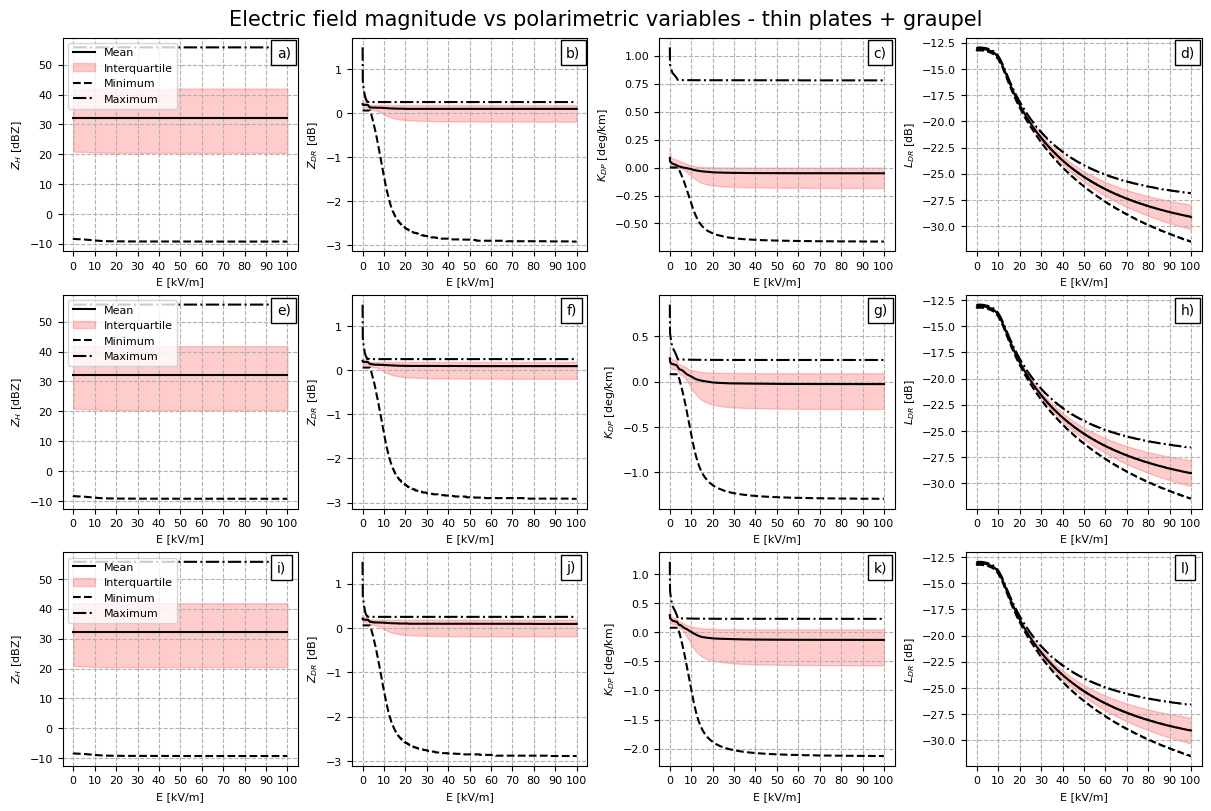

In [67]:
# plot the graupel/crystal mixtures
fig, axs = plt.subplots(3,4, figsize=[12,8], constrained_layout = True)

for n,ax in enumerate(axs.ravel()):
    if n == 0:
        ax.plot(E/1e3, stats_thin[0]['median_zhS'], c='k', label='Mean')
        ax.fill_between(E/1e3, stats_thin[0]['25_zhS'], stats_thin[0]['75_zhS'], alpha=0.2, color='red', label = r'Interquartile')
        #ax.fill_between(E/1e3, np.subtract(mean_zhS, sd_zhS), np.add(mean_zhS, sd_zhS), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, stats_thin[0]['min_zhS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thin[0]['max_zhS'], c='k', ls = '-.', label=r'Maximum')
        ax.legend(loc = 'upper left', fontsize=8)
        #ax.set_ylim(-20, 45)
        
    if n == 1:
        ax.plot(E/1e3, stats_thin[0]['median_zdrS'], c='k')
        ax.plot(E/1e3, stats_thin[0]['min_zdrS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thin[0]['max_zdrS'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrS, sd_zdrS), np.add(mean_zdrS, sd_zdrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thin[0]['25_zdrS'], stats_thin[0]['75_zdrS'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-5, 3, 1))
    
    if n == 2:    
        ax.plot(E/1e3, stats_thin[0]['median_kdpS'], c='k')
        ax.plot(E/1e3, stats_thin[0]['min_kdpS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thin[0]['max_kdpS'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpS, sd_kdpS), np.add(mean_kdpS, sd_kdpS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thin[0]['25_kdpS'], stats_thin[0]['75_kdpS'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-0.8, 0.4, 0.1))

    if n == 3:        
        ax.plot(E/1e3, stats_thin[0]['median_ldrS'], c='k')
        ax.plot(E/1e3, stats_thin[0]['min_ldrS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thin[0]['max_ldrS'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrS, sd_ldrS), np.add(mean_ldrS, sd_ldrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thin[0]['25_ldrS'], stats_thin[0]['75_ldrS'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-45, -10, 5))

    if n == 4:
        ax.plot(E/1e3, stats_thin[0]['median_zhC'], c='k', label='Mean')
        ax.fill_between(E/1e3, stats_thin[0]['25_zhC'], stats_thin[0]['75_zhC'], alpha=0.2, color='red', label = r'Interquartile')
        #ax.fill_between(E/1e3, np.subtract(mean_zhS, sd_zhS), np.add(mean_zhS, sd_zhS), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, stats_thin[0]['min_zhC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thin[0]['max_zhC'], c='k', ls = '-.', label=r'Maximum')
        ax.legend(loc = 'upper left', fontsize=8)
        #ax.set_ylim(-20, 45)
        
    if n == 5:
        ax.plot(E/1e3, stats_thin[0]['median_zdrC'], c='k')
        ax.plot(E/1e3, stats_thin[0]['min_zdrC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thin[0]['max_zdrC'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrS, sd_zdrS), np.add(mean_zdrS, sd_zdrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thin[0]['25_zdrC'], stats_thin[0]['75_zdrC'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-5, 3, 1))
    
    if n == 6:    
        ax.plot(E/1e3, stats_thin[0]['median_kdpC'], c='k')
        ax.plot(E/1e3, stats_thin[0]['min_kdpC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thin[0]['max_kdpC'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpS, sd_kdpS), np.add(mean_kdpS, sd_kdpS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thin[0]['25_kdpC'], stats_thin[0]['75_kdpC'], alpha=0.2, color='red')

    if n == 7:        
        ax.plot(E/1e3, stats_thin[0]['median_ldrC'], c='k')
        ax.plot(E/1e3, stats_thin[0]['min_ldrC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thin[0]['max_ldrC'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrS, sd_ldrS), np.add(mean_ldrS, sd_ldrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thin[0]['25_ldrC'], stats_thin[0]['75_ldrC'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-45, -10, 5))

    if n == 8:
        ax.plot(E/1e3, stats_thin[0]['median_zhX'], c='k', label='Mean')
        ax.fill_between(E/1e3, stats_thin[0]['25_zhX'], stats_thin[0]['75_zhX'], alpha=0.2, color='red', label = r'Interquartile')
        #ax.fill_between(E/1e3, np.subtract(mean_zhS, sd_zhS), np.add(mean_zhS, sd_zhS), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, stats_thin[0]['min_zhX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thin[0]['max_zhX'], c='k', ls = '-.', label=r'Maximum')
        ax.legend(loc = 'upper left', fontsize=8)
        #ax.set_ylim(-20, 45)
        
    if n == 9:
        ax.plot(E/1e3, stats_thin[0]['median_zdrX'], c='k')
        ax.plot(E/1e3, stats_thin[0]['min_zdrX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thin[0]['max_zdrX'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrS, sd_zdrS), np.add(mean_zdrS, sd_zdrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thin[0]['25_zdrX'], stats_thin[0]['75_zdrX'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-5, 3, 1))
    
    if n == 10:    
        ax.plot(E/1e3, stats_thin[0]['median_kdpX'], c='k')
        ax.plot(E/1e3, stats_thin[0]['min_kdpX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thin[0]['max_kdpX'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpS, sd_kdpS), np.add(mean_kdpS, sd_kdpS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thin[0]['25_kdpX'], stats_thin[0]['75_kdpX'], alpha=0.2, color='red')

    if n == 11:        
        ax.plot(E/1e3, stats_thin[0]['median_ldrX'], c='k')
        ax.plot(E/1e3, stats_thin[0]['min_ldrX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thin[0]['max_ldrX'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrS, sd_ldrS), np.add(mean_ldrS, sd_ldrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thin[0]['25_ldrX'], stats_thin[0]['75_ldrX'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-45, -10, 5))


l = ['a)', 'b)', 'c)', 'd)','e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)']
for n, ax in enumerate(axs.ravel()):
    ax.set_xlabel('E [kV/m]')
    ax.set_xticks(np.arange(0, 110, 10))
    ax.annotate(l[n], xy = (0.91, 0.91), xycoords = 'axes fraction', fontsize = 10, bbox={'facecolor':'white', 'clip_on':True}, zorder = 50)
    ax.grid(True, ls = '--', which = 'both')
    if (n == 0 or n == 4 or n == 8):
       ax.set_ylabel(r'$Z_{H}$ [dBZ]') 
    if (n == 1 or n == 5 or n == 9):
       ax.set_ylabel(r'$Z_{DR}$ [dB]')
    if (n == 2 or n == 6 or n == 10):
       ax.set_ylabel(r'$K_{DP}$ [deg/km]')
    if (n == 3 or n == 7 or n == 11):
       ax.set_ylabel(r'$L_{DR}$ [dB]')

fig.suptitle('Electric field magnitude vs polarimetric variables - thin plates + graupel', fontsize = 15)

#plt.savefig(f'results_long.png', bbox_inches = 'tight', dpi=300)

Text(0.5, 0.98, 'Electric field magnitude vs polarimetric variables - thick plates + graupel')

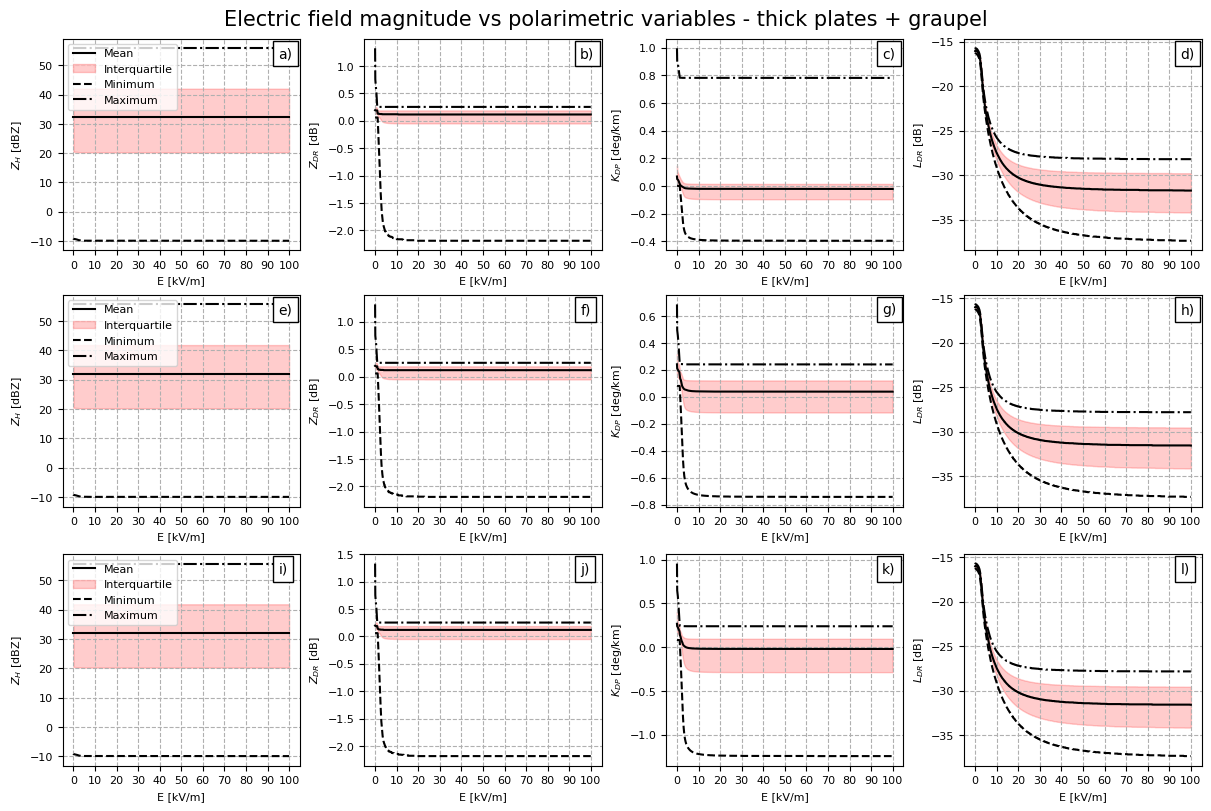

In [68]:
fig, axs = plt.subplots(3,4, figsize=[12,8], constrained_layout = True)

for n,ax in enumerate(axs.ravel()):
    if n == 0:
        ax.plot(E/1e3, stats_thick[0]['median_zhS'], c='k', label='Mean')
        ax.fill_between(E/1e3, stats_thick[0]['25_zhS'], stats_thick[0]['75_zhS'], alpha=0.2, color='red', label = r'Interquartile')
        #ax.fill_between(E/1e3, np.subtract(mean_zhS, sd_zhS), np.add(mean_zhS, sd_zhS), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, stats_thick[0]['min_zhS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thick[0]['max_zhS'], c='k', ls = '-.', label=r'Maximum')
        ax.legend(loc = 'upper left', fontsize=8)
        #ax.set_ylim(-20, 45)
        
    if n == 1:
        ax.plot(E/1e3, stats_thick[0]['median_zdrS'], c='k')
        ax.plot(E/1e3, stats_thick[0]['min_zdrS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thick[0]['max_zdrS'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrS, sd_zdrS), np.add(mean_zdrS, sd_zdrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thick[0]['25_zdrS'], stats_thick[0]['75_zdrS'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-5, 3, 1))
    
    if n == 2:    
        ax.plot(E/1e3, stats_thick[0]['median_kdpS'], c='k')
        ax.plot(E/1e3, stats_thick[0]['min_kdpS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thick[0]['max_kdpS'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpS, sd_kdpS), np.add(mean_kdpS, sd_kdpS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thick[0]['25_kdpS'], stats_thick[0]['75_kdpS'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-0.8, 0.4, 0.1))

    if n == 3:        
        ax.plot(E/1e3, stats_thick[0]['median_ldrS'], c='k')
        ax.plot(E/1e3, stats_thick[0]['min_ldrS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thick[0]['max_ldrS'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrS, sd_ldrS), np.add(mean_ldrS, sd_ldrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thick[0]['25_ldrS'], stats_thick[0]['75_ldrS'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-45, -10, 5))

    if n == 4:
        ax.plot(E/1e3, stats_thick[0]['median_zhC'], c='k', label='Mean')
        ax.fill_between(E/1e3, stats_thick[0]['25_zhC'], stats_thick[0]['75_zhC'], alpha=0.2, color='red', label = r'Interquartile')
        #ax.fill_between(E/1e3, np.subtract(mean_zhS, sd_zhS), np.add(mean_zhS, sd_zhS), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, stats_thick[0]['min_zhC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thick[0]['max_zhC'], c='k', ls = '-.', label=r'Maximum')
        ax.legend(loc = 'upper left', fontsize=8)
        #ax.set_ylim(-20, 45)
        
    if n == 5:
        ax.plot(E/1e3, stats_thick[0]['median_zdrC'], c='k')
        ax.plot(E/1e3, stats_thick[0]['min_zdrC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thick[0]['max_zdrC'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrS, sd_zdrS), np.add(mean_zdrS, sd_zdrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thick[0]['25_zdrC'], stats_thick[0]['75_zdrC'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-5, 3, 1))
    
    if n == 6:    
        ax.plot(E/1e3, stats_thick[0]['median_kdpC'], c='k')
        ax.plot(E/1e3, stats_thick[0]['min_kdpC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thick[0]['max_kdpC'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpS, sd_kdpS), np.add(mean_kdpS, sd_kdpS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thick[0]['25_kdpC'], stats_thick[0]['75_kdpC'], alpha=0.2, color='red')

    if n == 7:        
        ax.plot(E/1e3, stats_thick[0]['median_ldrC'], c='k')
        ax.plot(E/1e3, stats_thick[0]['min_ldrC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thick[0]['max_ldrC'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrS, sd_ldrS), np.add(mean_ldrS, sd_ldrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thick[0]['25_ldrC'], stats_thick[0]['75_ldrC'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-45, -10, 5))

    if n == 8:
        ax.plot(E/1e3, stats_thick[0]['median_zhX'], c='k', label='Mean')
        ax.fill_between(E/1e3, stats_thick[0]['25_zhX'], stats_thick[0]['75_zhX'], alpha=0.2, color='red', label = r'Interquartile')
        #ax.fill_between(E/1e3, np.subtract(mean_zhS, sd_zhS), np.add(mean_zhS, sd_zhS), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, stats_thick[0]['min_zhX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thick[0]['max_zhX'], c='k', ls = '-.', label=r'Maximum')
        ax.legend(loc = 'upper left', fontsize=8)
        #ax.set_ylim(-20, 45)
        
    if n == 9:
        ax.plot(E/1e3, stats_thick[0]['median_zdrX'], c='k')
        ax.plot(E/1e3, stats_thick[0]['min_zdrX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thick[0]['max_zdrX'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrS, sd_zdrS), np.add(mean_zdrS, sd_zdrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thick[0]['25_zdrX'], stats_thick[0]['75_zdrX'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-5, 3, 1))
    
    if n == 10:    
        ax.plot(E/1e3, stats_thick[0]['median_kdpX'], c='k')
        ax.plot(E/1e3, stats_thick[0]['min_kdpX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thick[0]['max_kdpX'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpS, sd_kdpS), np.add(mean_kdpS, sd_kdpS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thick[0]['25_kdpX'], stats_thick[0]['75_kdpX'], alpha=0.2, color='red')

    if n == 11:        
        ax.plot(E/1e3, stats_thick[0]['median_ldrX'], c='k')
        ax.plot(E/1e3, stats_thick[0]['min_ldrX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thick[0]['max_ldrX'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrS, sd_ldrS), np.add(mean_ldrS, sd_ldrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thick[0]['25_ldrX'], stats_thick[0]['75_ldrX'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-45, -10, 5))


l = ['a)', 'b)', 'c)', 'd)','e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)']
for n, ax in enumerate(axs.ravel()):
    ax.set_xlabel('E [kV/m]')
    ax.set_xticks(np.arange(0, 110, 10))
    ax.annotate(l[n], xy = (0.91, 0.91), xycoords = 'axes fraction', fontsize = 10, bbox={'facecolor':'white', 'clip_on':True}, zorder = 50)
    ax.grid(True, ls = '--', which = 'both')
    if (n == 0 or n == 4 or n == 8):
       ax.set_ylabel(r'$Z_{H}$ [dBZ]') 
    if (n == 1 or n == 5 or n == 9):
       ax.set_ylabel(r'$Z_{DR}$ [dB]')
    if (n == 2 or n == 6 or n == 10):
       ax.set_ylabel(r'$K_{DP}$ [deg/km]')
    if (n == 3 or n == 7 or n == 11):
       ax.set_ylabel(r'$L_{DR}$ [dB]')

fig.suptitle('Electric field magnitude vs polarimetric variables - thick plates + graupel', fontsize = 15)

#plt.savefig(f'results_long.png', bbox_inches = 'tight', dpi=300)np.std(data_col2S[0]['zdr_plate'], (0,1))

Text(0.5, 0.98, 'Electric field magnitude vs polarimetric variables - short columns + graupel')

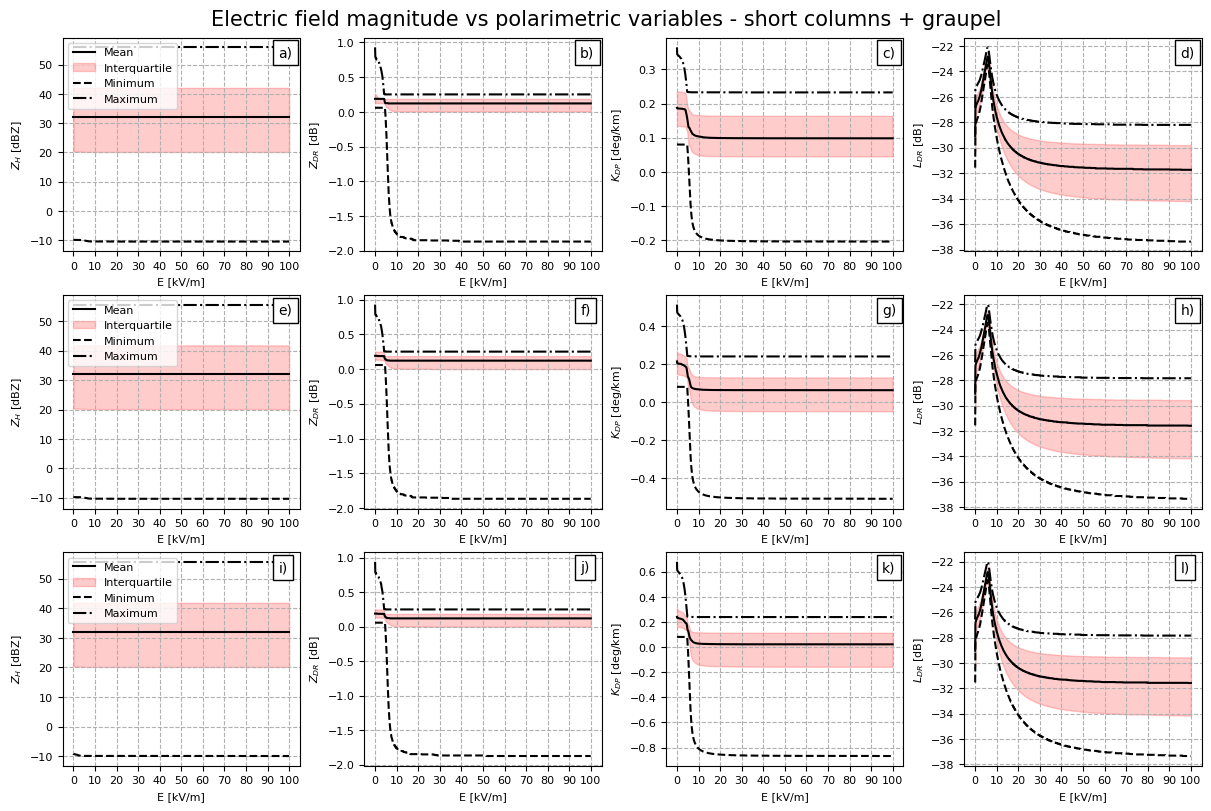

In [69]:
fig, axs = plt.subplots(3,4, figsize=[12,8], constrained_layout = True)

for n,ax in enumerate(axs.ravel()):
    if n == 0:
        ax.plot(E/1e3, stats_short[0]['median_zhS'], c='k', label='Mean')
        ax.fill_between(E/1e3, stats_short[0]['25_zhS'], stats_short[0]['75_zhS'], alpha=0.2, color='red', label = r'Interquartile')
        #ax.fill_between(E/1e3, np.subtract(mean_zhS, sd_zhS), np.add(mean_zhS, sd_zhS), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, stats_short[0]['min_zhS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_short[0]['max_zhS'], c='k', ls = '-.', label=r'Maximum')
        ax.legend(loc = 'upper left', fontsize=8)
        #ax.set_ylim(-20, 45)
        
    if n == 1:
        ax.plot(E/1e3, stats_short[0]['median_zdrS'], c='k')
        ax.plot(E/1e3, stats_short[0]['min_zdrS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_short[0]['max_zdrS'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrS, sd_zdrS), np.add(mean_zdrS, sd_zdrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thick[0]['25_zdrS'], stats_short[0]['75_zdrS'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-5, 3, 1))
    
    if n == 2:    
        ax.plot(E/1e3, stats_short[0]['median_kdpS'], c='k')
        ax.plot(E/1e3, stats_short[0]['min_kdpS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_short[0]['max_kdpS'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpS, sd_kdpS), np.add(mean_kdpS, sd_kdpS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_short[0]['25_kdpS'], stats_short[0]['75_kdpS'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-0.8, 0.4, 0.1))

    if n == 3:        
        ax.plot(E/1e3, stats_short[0]['median_ldrS'], c='k')
        ax.plot(E/1e3, stats_short[0]['min_ldrS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_short[0]['max_ldrS'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrS, sd_ldrS), np.add(mean_ldrS, sd_ldrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_short[0]['25_ldrS'], stats_short[0]['75_ldrS'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-45, -10, 5))

    if n == 4:
        ax.plot(E/1e3, stats_short[0]['median_zhC'], c='k', label='Mean')
        ax.fill_between(E/1e3, stats_short[0]['25_zhC'], stats_short[0]['75_zhC'], alpha=0.2, color='red', label = r'Interquartile')
        #ax.fill_between(E/1e3, np.subtract(mean_zhS, sd_zhS), np.add(mean_zhS, sd_zhS), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, stats_short[0]['min_zhC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_short[0]['max_zhC'], c='k', ls = '-.', label=r'Maximum')
        ax.legend(loc = 'upper left', fontsize=8)
        #ax.set_ylim(-20, 45)
        
    if n == 5:
        ax.plot(E/1e3, stats_short[0]['median_zdrC'], c='k')
        ax.plot(E/1e3, stats_short[0]['min_zdrC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_short[0]['max_zdrC'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrS, sd_zdrS), np.add(mean_zdrS, sd_zdrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_short[0]['25_zdrC'], stats_short[0]['75_zdrC'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-5, 3, 1))
    
    if n == 6:    
        ax.plot(E/1e3, stats_short[0]['median_kdpC'], c='k')
        ax.plot(E/1e3, stats_short[0]['min_kdpC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_short[0]['max_kdpC'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpS, sd_kdpS), np.add(mean_kdpS, sd_kdpS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_short[0]['25_kdpC'], stats_short[0]['75_kdpC'], alpha=0.2, color='red')

    if n == 7:        
        ax.plot(E/1e3, stats_short[0]['median_ldrC'], c='k')
        ax.plot(E/1e3, stats_short[0]['min_ldrC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_short[0]['max_ldrC'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrS, sd_ldrS), np.add(mean_ldrS, sd_ldrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_short[0]['25_ldrC'], stats_short[0]['75_ldrC'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-45, -10, 5))

    if n == 8:
        ax.plot(E/1e3, stats_short[0]['median_zhX'], c='k', label='Mean')
        ax.fill_between(E/1e3, stats_short[0]['25_zhX'], stats_short[0]['75_zhX'], alpha=0.2, color='red', label = r'Interquartile')
        #ax.fill_between(E/1e3, np.subtract(mean_zhS, sd_zhS), np.add(mean_zhS, sd_zhS), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, stats_thick[0]['min_zhX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thick[0]['max_zhX'], c='k', ls = '-.', label=r'Maximum')
        ax.legend(loc = 'upper left', fontsize=8)
        #ax.set_ylim(-20, 45)
        
    if n == 9:
        ax.plot(E/1e3, stats_short[0]['median_zdrX'], c='k')
        ax.plot(E/1e3, stats_short[0]['min_zdrX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_short[0]['max_zdrX'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrS, sd_zdrS), np.add(mean_zdrS, sd_zdrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_short[0]['25_zdrX'], stats_short[0]['75_zdrX'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-5, 3, 1))
    
    if n == 10:    
        ax.plot(E/1e3, stats_short[0]['median_kdpX'], c='k')
        ax.plot(E/1e3, stats_short[0]['min_kdpX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_short[0]['max_kdpX'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpS, sd_kdpS), np.add(mean_kdpS, sd_kdpS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_short[0]['25_kdpX'], stats_short[0]['75_kdpX'], alpha=0.2, color='red')

    if n == 11:        
        ax.plot(E/1e3, stats_short[0]['median_ldrX'], c='k')
        ax.plot(E/1e3, stats_short[0]['min_ldrX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_short[0]['max_ldrX'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrS, sd_ldrS), np.add(mean_ldrS, sd_ldrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_short[0]['25_ldrX'], stats_short[0]['75_ldrX'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-45, -10, 5))


l = ['a)', 'b)', 'c)', 'd)','e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)']
for n, ax in enumerate(axs.ravel()):
    ax.set_xlabel('E [kV/m]')
    ax.set_xticks(np.arange(0, 110, 10))
    ax.annotate(l[n], xy = (0.91, 0.91), xycoords = 'axes fraction', fontsize = 10, bbox={'facecolor':'white', 'clip_on':True}, zorder = 50)
    ax.grid(True, ls = '--', which = 'both')
    if (n == 0 or n == 4 or n == 8):
       ax.set_ylabel(r'$Z_{H}$ [dBZ]') 
    if (n == 1 or n == 5 or n == 9):
       ax.set_ylabel(r'$Z_{DR}$ [dB]')
    if (n == 2 or n == 6 or n == 10):
       ax.set_ylabel(r'$K_{DP}$ [deg/km]')
    if (n == 3 or n == 7 or n == 11):
       ax.set_ylabel(r'$L_{DR}$ [dB]')

fig.suptitle('Electric field magnitude vs polarimetric variables - short columns + graupel', fontsize = 15)

#plt.savefig(f'results_long.png', bbox_inches = 'tight', dpi=300)np.std(data_col2S[0]['zdr_plate'], (0,1))

Text(0.5, 0.98, 'Electric field magnitude vs polarimetric variables - long columns + graupel')

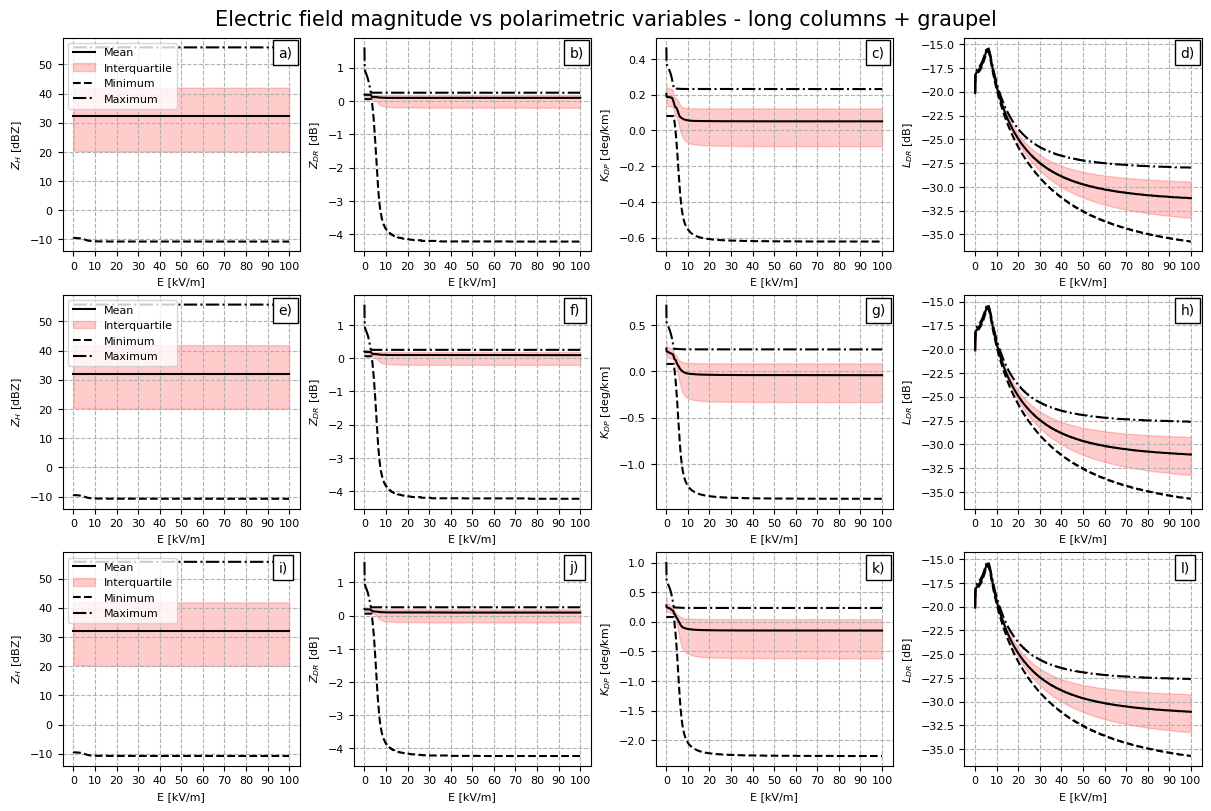

In [70]:
fig, axs = plt.subplots(3,4, figsize=[12,8], constrained_layout = True)

for n,ax in enumerate(axs.ravel()):
    if n == 0:
        ax.plot(E/1e3, stats_long[0]['median_zhS'], c='k', label='Mean')
        ax.fill_between(E/1e3, stats_long[0]['25_zhS'], stats_long[0]['75_zhS'], alpha=0.2, color='red', label = r'Interquartile')
        #ax.fill_between(E/1e3, np.subtract(mean_zhS, sd_zhS), np.add(mean_zhS, sd_zhS), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, stats_long[0]['min_zhS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_long[0]['max_zhS'], c='k', ls = '-.', label=r'Maximum')
        ax.legend(loc = 'upper left', fontsize=8)
        #ax.set_ylim(-20, 45)
        
    if n == 1:
        ax.plot(E/1e3, stats_long[0]['median_zdrS'], c='k')
        ax.plot(E/1e3, stats_long[0]['min_zdrS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_long[0]['max_zdrS'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrS, sd_zdrS), np.add(mean_zdrS, sd_zdrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_long[0]['25_zdrS'], stats_long[0]['75_zdrS'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-5, 3, 1))
    
    if n == 2:    
        ax.plot(E/1e3, stats_long[0]['median_kdpS'], c='k')
        ax.plot(E/1e3, stats_long[0]['min_kdpS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_long[0]['max_kdpS'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpS, sd_kdpS), np.add(mean_kdpS, sd_kdpS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_long[0]['25_kdpS'], stats_long[0]['75_kdpS'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-0.8, 0.4, 0.1))

    if n == 3:        
        ax.plot(E/1e3, stats_long[0]['median_ldrS'], c='k')
        ax.plot(E/1e3, stats_long[0]['min_ldrS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_long[0]['max_ldrS'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrS, sd_ldrS), np.add(mean_ldrS, sd_ldrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_long[0]['25_ldrS'], stats_long[0]['75_ldrS'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-45, -10, 5))

    if n == 4:
        ax.plot(E/1e3, stats_long[0]['median_zhC'], c='k', label='Mean')
        ax.fill_between(E/1e3, stats_long[0]['25_zhC'], stats_long[0]['75_zhC'], alpha=0.2, color='red', label = r'Interquartile')
        #ax.fill_between(E/1e3, np.subtract(mean_zhS, sd_zhS), np.add(mean_zhS, sd_zhS), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, stats_long[0]['min_zhC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_long[0]['max_zhC'], c='k', ls = '-.', label=r'Maximum')
        ax.legend(loc = 'upper left', fontsize=8)
        #ax.set_ylim(-20, 45)
        
    if n == 5:
        ax.plot(E/1e3, stats_long[0]['median_zdrC'], c='k')
        ax.plot(E/1e3, stats_long[0]['min_zdrC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_long[0]['max_zdrC'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrS, sd_zdrS), np.add(mean_zdrS, sd_zdrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_long[0]['25_zdrC'], stats_long[0]['75_zdrC'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-5, 3, 1))
    
    if n == 6:    
        ax.plot(E/1e3, stats_long[0]['median_kdpC'], c='k')
        ax.plot(E/1e3, stats_long[0]['min_kdpC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_long[0]['max_kdpC'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpS, sd_kdpS), np.add(mean_kdpS, sd_kdpS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_long[0]['25_kdpC'], stats_long[0]['75_kdpC'], alpha=0.2, color='red')

    if n == 7:        
        ax.plot(E/1e3, stats_long[0]['median_ldrC'], c='k')
        ax.plot(E/1e3, stats_long[0]['min_ldrC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_long[0]['max_ldrC'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrS, sd_ldrS), np.add(mean_ldrS, sd_ldrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_long[0]['25_ldrC'], stats_long[0]['75_ldrC'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-45, -10, 5))

    if n == 8:
        ax.plot(E/1e3, stats_long[0]['median_zhX'], c='k', label='Mean')
        ax.fill_between(E/1e3, stats_long[0]['25_zhX'], stats_long[0]['75_zhX'], alpha=0.2, color='red', label = r'Interquartile')
        #ax.fill_between(E/1e3, np.subtract(mean_zhS, sd_zhS), np.add(mean_zhS, sd_zhS), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, stats_long[0]['min_zhX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_long[0]['max_zhX'], c='k', ls = '-.', label=r'Maximum')
        ax.legend(loc = 'upper left', fontsize=8)
        #ax.set_ylim(-20, 45)
        
    if n == 9:
        ax.plot(E/1e3, stats_long[0]['median_zdrX'], c='k')
        ax.plot(E/1e3, stats_long[0]['min_zdrX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_long[0]['max_zdrX'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrS, sd_zdrS), np.add(mean_zdrS, sd_zdrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_long[0]['25_zdrX'], stats_long[0]['75_zdrX'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-5, 3, 1))
    
    if n == 10:    
        ax.plot(E/1e3, stats_long[0]['median_kdpX'], c='k')
        ax.plot(E/1e3, stats_long[0]['min_kdpX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_long[0]['max_kdpX'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpS, sd_kdpS), np.add(mean_kdpS, sd_kdpS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_long[0]['25_kdpX'], stats_long[0]['75_kdpX'], alpha=0.2, color='red')
        #ax.plot(E/1e3, kdpS_99, c='k', ls = '-.', label=r'$N_0=2\time

    if n == 11:        
        ax.plot(E/1e3, stats_long[0]['median_ldrX'], c='k')
        ax.plot(E/1e3, stats_long[0]['min_ldrX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_long[0]['max_ldrX'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrS, sd_ldrS), np.add(mean_ldrS, sd_ldrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_long[0]['25_ldrX'], stats_long[0]['75_ldrX'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-45, -10, 5))


l = ['a)', 'b)', 'c)', 'd)','e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)']
for n, ax in enumerate(axs.ravel()):
    ax.set_xlabel('E [kV/m]')
    ax.set_xticks(np.arange(0, 110, 10))
    ax.annotate(l[n], xy = (0.91, 0.91), xycoords = 'axes fraction', fontsize = 10, bbox={'facecolor':'white', 'clip_on':True}, zorder = 50)
    ax.grid(True, ls = '--', which = 'both')
    if (n == 0 or n == 4 or n == 8):
       ax.set_ylabel(r'$Z_{H}$ [dBZ]') 
    if (n == 1 or n == 5 or n == 9):
       ax.set_ylabel(r'$Z_{DR}$ [dB]')
    if (n == 2 or n == 6 or n == 10):
       ax.set_ylabel(r'$K_{DP}$ [deg/km]')
    if (n == 3 or n == 7 or n == 11):
       ax.set_ylabel(r'$L_{DR}$ [dB]')

fig.suptitle('Electric field magnitude vs polarimetric variables - long columns + graupel', fontsize = 15)

#plt.savefig(f'results_long.png', bbox_inches = 'tight', dpi=300)np.std(data_col2S[0]['zdr_plate'], (0,1))

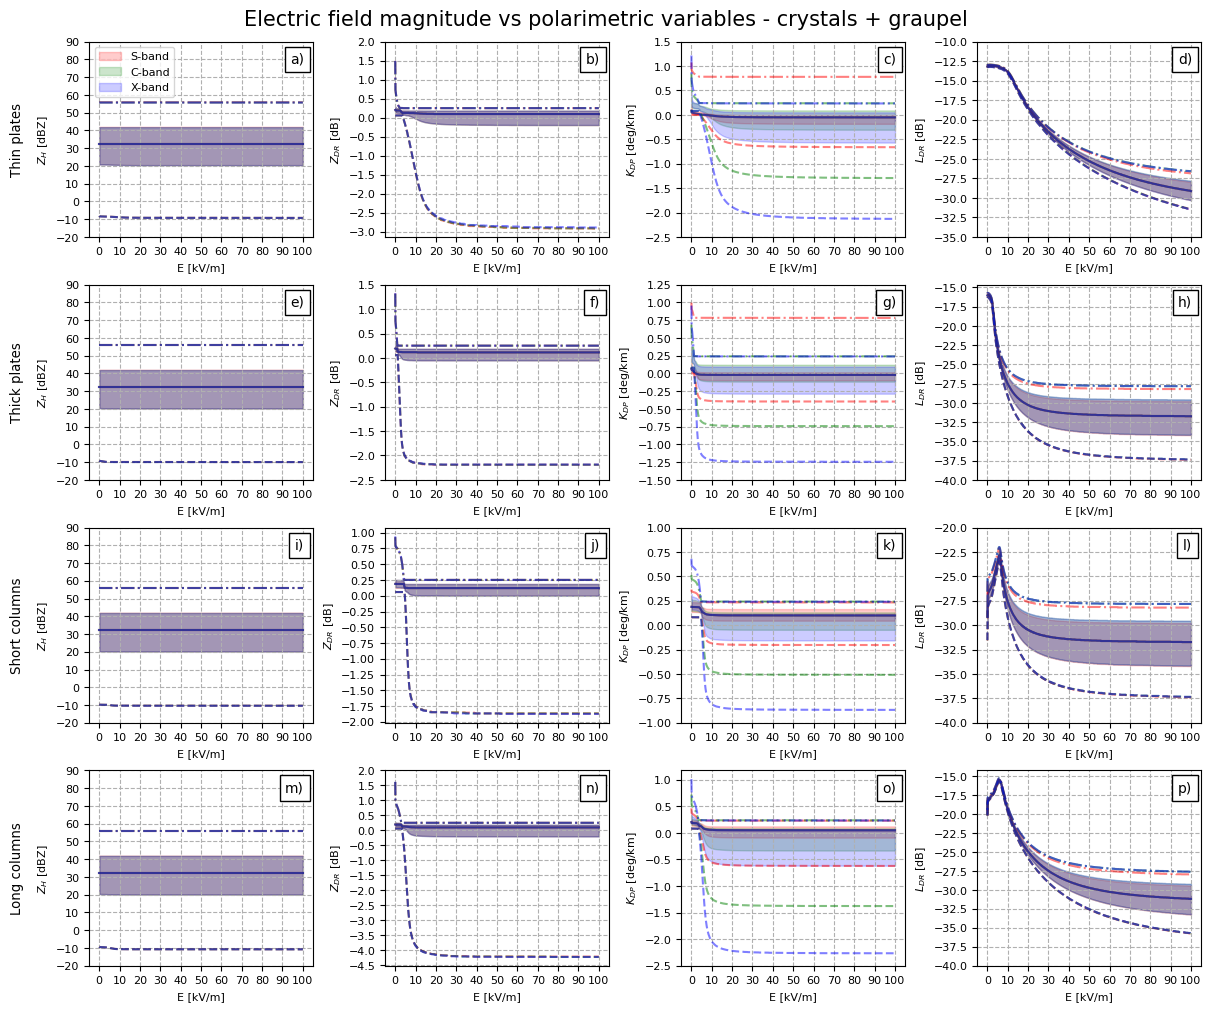

In [71]:
fig, axs = plt.subplots(4,4, figsize=[12,10], constrained_layout = True)

rows = [f'{row}' for row in ['Thin plates', 'Thick plates', 'Short columns', 'Long columns']]

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, rotation=90, textcoords='offset points',
                size='large', ha='right', va='center')

for n,ax in enumerate(axs.ravel()):
    if n == 0:
        ax.plot(E/1e3, stats_thin[0]['median_zhS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_thin[0]['median_zhS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_thin[0]['median_zhS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_thin[0]['25_zhS'], stats_thin[0]['75_zhS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_thin[0]['25_zhC'], stats_thin[0]['75_zhC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_thin[0]['25_zhX'], stats_thin[0]['75_zhX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_thin[0]['min_zhS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_thin[0]['max_zhS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_thin[0]['min_zhC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_thin[0]['max_zhC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_thin[0]['min_zhX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_thin[0]['max_zhX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(-20, 100, 10))
        #ax.set_ylim(-20, 90)
        ax.legend(loc = 'upper left', fontsize=8)
        
    if n == 1:
        ax.plot(E/1e3, stats_thin[0]['median_zdrS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_thin[0]['median_zdrS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_thin[0]['median_zdrS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_thin[0]['25_zdrS'], stats_thin[0]['75_zdrS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_thin[0]['25_zdrC'], stats_thin[0]['75_zdrC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_thin[0]['25_zdrX'], stats_thin[0]['75_zdrX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_thin[0]['min_zdrS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_thin[0]['max_zdrS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_thin[0]['min_zdrC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_thin[0]['max_zdrC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_thin[0]['min_zdrX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_thin[0]['max_zdrX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(-3, 2.5, .5))
        #ax.set_ylim(-3, 2)
    
    if n == 2:    
        ax.plot(E/1e3, stats_thin[0]['median_kdpS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_thin[0]['median_kdpS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_thin[0]['median_kdpS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_thin[0]['25_kdpS'], stats_thin[0]['75_kdpS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_thin[0]['25_kdpC'], stats_thin[0]['75_kdpC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_thin[0]['25_kdpX'], stats_thin[0]['75_kdpX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_thin[0]['min_kdpS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_thin[0]['max_kdpS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_thin[0]['min_kdpC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_thin[0]['max_kdpC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_thin[0]['min_kdpX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_thin[0]['max_kdpX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(-2.5, 2, 0.5))
        #ax.set_ylim(-3, 4)

    if n == 3:        
        ax.plot(E/1e3, stats_thin[0]['median_ldrS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_thin[0]['median_ldrS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_thin[0]['median_ldrS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_thin[0]['25_ldrS'], stats_thin[0]['75_ldrS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_thin[0]['25_ldrC'], stats_thin[0]['75_ldrC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_thin[0]['25_ldrX'], stats_thin[0]['75_ldrX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_thin[0]['min_ldrS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_thin[0]['max_ldrS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_thin[0]['min_ldrC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_thin[0]['max_ldrC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_thin[0]['min_ldrX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_thin[0]['max_ldrX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(-35, -7.5, 2.5))
        #ax.set_ylim(-35, -10)

    if n == 4:
        ax.plot(E/1e3, stats_thick[0]['median_zhS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_thick[0]['median_zhS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_thick[0]['median_zhS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_thick[0]['25_zhS'], stats_thick[0]['75_zhS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_thick[0]['25_zhC'], stats_thick[0]['75_zhC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_thick[0]['25_zhX'], stats_thick[0]['75_zhX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_thick[0]['min_zhS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_thick[0]['max_zhS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_thick[0]['min_zhC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_thick[0]['max_zhC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_thick[0]['min_zhX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_thick[0]['max_zhX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(-20, 100, 10))
        #ax.set_ylim(-20, 90)
        
    if n == 5:
        ax.plot(E/1e3, stats_thick[0]['median_zdrS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_thick[0]['median_zdrS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_thick[0]['median_zdrS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_thick[0]['25_zdrS'], stats_thick[0]['75_zdrS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_thick[0]['25_zdrC'], stats_thick[0]['75_zdrC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_thick[0]['25_zdrX'], stats_thick[0]['75_zdrX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_thick[0]['min_zdrS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_thick[0]['max_zdrS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_thick[0]['min_zdrC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_thick[0]['max_zdrC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_thick[0]['min_zdrX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_thick[0]['max_zdrX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(-2.5, 2, .5))
        #ax.set_ylim(-2.5, 1.5)
    
    if n == 6:    
        ax.plot(E/1e3, stats_thick[0]['median_kdpS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_thick[0]['median_kdpS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_thick[0]['median_kdpS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_thick[0]['25_kdpS'], stats_thick[0]['75_kdpS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_thick[0]['25_kdpC'], stats_thick[0]['75_kdpC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_thick[0]['25_kdpX'], stats_thick[0]['75_kdpX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_thick[0]['min_kdpS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_thick[0]['max_kdpS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_thick[0]['min_kdpC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_thick[0]['max_kdpC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_thick[0]['min_kdpX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_thick[0]['max_kdpX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(-1.5, 1.5, 0.25))
        #ax.set_ylim(-2, 4)


    if n == 7:        
        ax.plot(E/1e3, stats_thick[0]['median_ldrS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_thick[0]['median_ldrS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_thick[0]['median_ldrS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_thick[0]['25_ldrS'], stats_thick[0]['75_ldrS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_thick[0]['25_ldrC'], stats_thick[0]['75_ldrC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_thick[0]['25_ldrX'], stats_thick[0]['75_ldrX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_thick[0]['min_ldrS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_thick[0]['max_ldrS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_thick[0]['min_ldrC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_thick[0]['max_ldrC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_thick[0]['min_ldrX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_thick[0]['max_ldrX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(-40, -12.5, 2.5))
        #ax.set_ylim(-40, -15)
        
    if n == 8:
        ax.plot(E/1e3, stats_short[0]['median_zhS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_short[0]['median_zhS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_short[0]['median_zhS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_short[0]['25_zhS'], stats_short[0]['75_zhS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_short[0]['25_zhC'], stats_short[0]['75_zhC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_short[0]['25_zhX'], stats_short[0]['75_zhX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_short[0]['min_zhS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_short[0]['max_zhS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_short[0]['min_zhC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_short[0]['max_zhC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_short[0]['min_zhX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_short[0]['max_zhX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(-20, 100, 10))
        #ax.set_ylim(-20, 90)

        
    if n == 9:
        ax.plot(E/1e3, stats_short[0]['median_zdrS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_short[0]['median_zdrS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_short[0]['median_zdrS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_short[0]['25_zdrS'], stats_short[0]['75_zdrS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_short[0]['25_zdrC'], stats_short[0]['75_zdrC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_short[0]['25_zdrX'], stats_short[0]['75_zdrX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_short[0]['min_zdrS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_short[0]['max_zdrS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_short[0]['min_zdrC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_short[0]['max_zdrC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_short[0]['min_zdrX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_short[0]['max_zdrX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(-2, 1.25, .25))
        #ax.set_ylim(-2, 0.75)
    
    if n == 10:    
        ax.plot(E/1e3, stats_short[0]['median_kdpS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_short[0]['median_kdpS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_short[0]['median_kdpS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_short[0]['25_kdpS'], stats_short[0]['75_kdpS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_short[0]['25_kdpC'], stats_short[0]['75_kdpC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_short[0]['25_kdpX'], stats_short[0]['75_kdpX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_short[0]['min_kdpS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_short[0]['max_kdpS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_short[0]['min_kdpC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_short[0]['max_kdpC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_short[0]['min_kdpX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_short[0]['max_kdpX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(-1., 1.25, 0.25))
        #ax.set_ylim(-2, 4)

    if n == 11:        
        ax.plot(E/1e3, stats_short[0]['median_ldrS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_short[0]['median_ldrS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_short[0]['median_ldrS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_short[0]['25_ldrS'], stats_short[0]['75_ldrS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_short[0]['25_ldrC'], stats_short[0]['75_ldrC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_short[0]['25_ldrX'], stats_short[0]['75_ldrX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_short[0]['min_ldrS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_short[0]['max_ldrS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_short[0]['min_ldrC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_short[0]['max_ldrC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_short[0]['min_ldrX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_short[0]['max_ldrX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(-40, -17.5, 2.5))
        #ax.set_ylim(-40, -20)
        
    if n == 12:
        ax.plot(E/1e3, stats_long[0]['median_zhS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_long[0]['median_zhS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_long[0]['median_zhS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_long[0]['25_zhS'], stats_long[0]['75_zhS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_long[0]['25_zhC'], stats_long[0]['75_zhC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_long[0]['25_zhX'], stats_long[0]['75_zhX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_long[0]['min_zhS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_long[0]['max_zhS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_long[0]['min_zhC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_long[0]['max_zhC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_long[0]['min_zhX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_long[0]['max_zhX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(-20, 100, 10))
        #ax.set_ylim(-20, 90)
        
    if n == 13:
        ax.plot(E/1e3, stats_long[0]['median_zdrS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_long[0]['median_zdrS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_long[0]['median_zdrS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_long[0]['25_zdrS'], stats_long[0]['75_zdrS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_long[0]['25_zdrC'], stats_long[0]['75_zdrC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_long[0]['25_zdrX'], stats_long[0]['75_zdrX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_long[0]['min_zdrS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_long[0]['max_zdrS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_long[0]['min_zdrC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_long[0]['max_zdrC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_long[0]['min_zdrX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_long[0]['max_zdrX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(-4.5, 2.5, .5))
        #ax.set_ylim(-5, 2)
    
    if n == 14:    
        ax.plot(E/1e3, stats_long[0]['median_kdpS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_long[0]['median_kdpS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_long[0]['median_kdpS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_long[0]['25_kdpS'], stats_long[0]['75_kdpS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_long[0]['25_kdpC'], stats_long[0]['75_kdpC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_long[0]['25_kdpX'], stats_long[0]['75_kdpX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_long[0]['min_kdpS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_long[0]['max_kdpS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_long[0]['min_kdpC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_long[0]['max_kdpC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_long[0]['min_kdpX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_long[0]['max_kdpX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(-2.5, 1.5, 0.5))
        #ax.set_ylim(-3, 4)


    if n == 15:        
        ax.plot(E/1e3, stats_long[0]['median_ldrS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_long[0]['median_ldrS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_long[0]['median_ldrS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_long[0]['25_ldrS'], stats_long[0]['75_ldrS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_long[0]['25_ldrC'], stats_long[0]['75_ldrC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_long[0]['25_ldrX'], stats_long[0]['75_ldrX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_long[0]['min_ldrS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_long[0]['max_ldrS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_long[0]['min_ldrC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_long[0]['max_ldrC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_long[0]['min_ldrX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_long[0]['max_ldrX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(-40, -12.5, 2.5))
        #ax.set_ylim(-40, -15)


l = ['a)', 'b)', 'c)', 'd)','e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)', 'm)', 'n)', 'o)', 'p)']
for n, ax in enumerate(axs.ravel()):
    ax.set_xlabel('E [kV/m]')
    ax.set_xticks(np.arange(0, 110, 10))
    ax.annotate(l[n], xy = (0.96, 0.91), xycoords = 'axes fraction', ha='right', va='center', fontsize = 10, bbox={'facecolor':'white', 'clip_on':True}, zorder = 50)
    ax.grid(True, ls = '--', which = 'both')
    if (n == 0 or n == 4 or n == 8 or n == 12):
       ax.set_ylabel(r'$Z_{H}$ [dBZ]') 
    if (n == 1 or n == 5 or n == 9 or n == 13):
       ax.set_ylabel(r'$Z_{DR}$ [dB]')
    if (n == 2 or n == 6 or n == 10 or n == 14):
       ax.set_ylabel(r'$K_{DP}$ [deg/km]')
    if (n == 3 or n == 7 or n == 11 or n == 15):
       ax.set_ylabel(r'$L_{DR}$ [dB]')

fig.suptitle('Electric field magnitude vs polarimetric variables - crystals + graupel', fontsize = 15)

plt.savefig(f'results_crystal_graupel.png', bbox_inches = 'tight', dpi=300)

In [74]:
# do the same with the snow aggregates
with open('/home/vitorgoede/homework/radar_polarimetry/project/sim_full_snow_S2.pkl',mode='rb') as f:
    data_snowS = pickle.load(f)[0]

with open('/home/vitorgoede/homework/radar_polarimetry/project/sim_full_snow_C2.pkl',mode='rb') as f:
    data_snowC = pickle.load(f)[0]

with open('/home/vitorgoede/homework/radar_polarimetry/project/sim_full_snow_X2.pkl',mode='rb') as f:
    data_snowX = pickle.load(f)[0]

for var in data_snowS.keys():
    data_snowS[var] = data_snowS[var].astype(np.float16)

for var in data_snowC.keys():
    data_snowC[var] = data_snowC[var].astype(np.float16)

for var in data_snowX.keys():
    data_snowX[var] = data_snowX[var].astype(np.float16)

Text(0, 0.5, '$LDR$ [dBZ]')

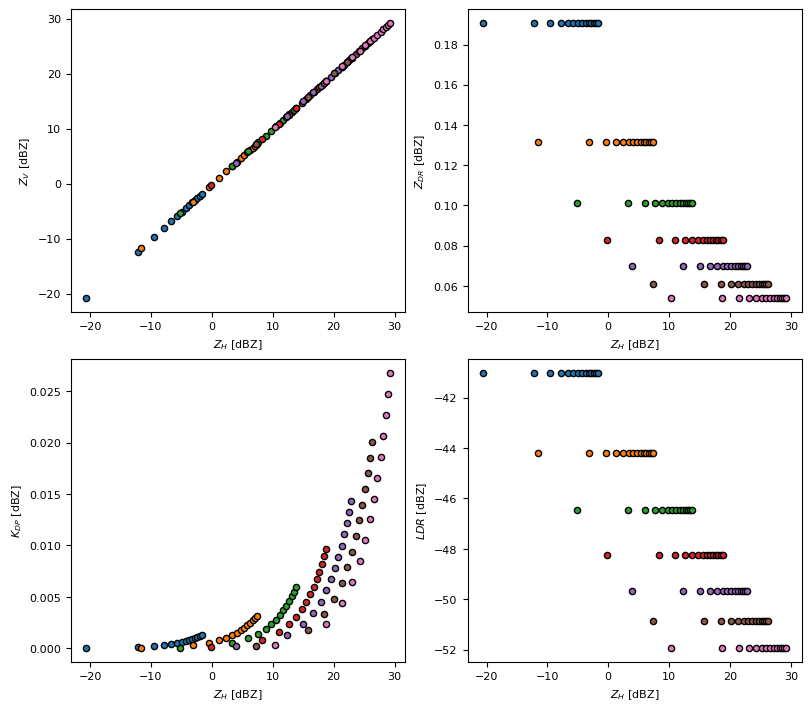

In [75]:
fig, axs = plt.subplots(2,2, figsize=[8,7], constrained_layout = True)

[axs.ravel()[0].scatter(zh, zv, s=20, edgecolor='k') for zh,zv in zip(data_snowS['zh'], data_snowS['zv'])]
axs.ravel()[0].set_xlabel(r'$Z_{H}$ [dBZ]')
axs.ravel()[0].set_ylabel(r'$Z_{V}$ [dBZ]')

[axs.ravel()[1].scatter(zh, zdr, s=20, edgecolor='k') for zh,zdr in zip(data_snowS['zh'], data_snowS['zdr'])]
axs.ravel()[1].set_xlabel(r'$Z_{H}$ [dBZ]')
axs.ravel()[1].set_ylabel(r'$Z_{DR}$ [dBZ]')

[axs.ravel()[2].scatter(zh, kdp, s=20, edgecolor='k') for zh,kdp in zip(data_snowS['zh'], data_snowS['kdp'])]
axs.ravel()[2].set_xlabel(r'$Z_{H}$ [dBZ]')
axs.ravel()[2].set_ylabel(r'$K_{DP}$ [dBZ]')

[axs.ravel()[3].scatter(zh, ldr, s=20, edgecolor='k') for zh,ldr in zip(data_snowS['zh'], data_snowS['ldr'])]
axs.ravel()[3].set_xlabel(r'$Z_{H}$ [dBZ]')
axs.ravel()[3].set_ylabel(r'$LDR$ [dBZ]')

In [76]:
mix_thinplates_ZHS = []
mix_thinplates_ZDRS = []
mix_thinplates_KDPS = []
mix_thinplates_LDRS = []

for i in range(data_snowS['kdp'].shape[0]):
    for j in range(data_snowS['kdp'].shape[1]):
        for k in range(data_plateS['kdp'].shape[0]):
            for l in range(data_plateS['kdp'].shape[1]):
                    mix_thinplates_ZHS.append(10*np.log10((10**(np.array(data_plateS['zh'][k,l])/10) + 10**(np.array(data_snowS['zh'][i,j])/10))))
                    mix_thinplates_ZDRS.append(10*np.log10((10**(np.array(data_plateS['zh'][k,l])/10) + 10**(np.array(data_snowS['zh'][i,j])/10))/
                                               (10**(np.array(data_plateS['zv'][k,l])/10) + 10**(np.array(data_snowS['zv'][i,j])/10))))
                    mix_thinplates_KDPS.append(data_plateS['kdp'][k,l] + data_snowS['kdp'][i,j])
                    mix_thinplates_LDRS.append(10*np.log10(10**(np.array(data_plateS['ldr'][k,l])/10) + 10**(np.array(data_snowS['ldr'][i,j])/10)))

mix_thinplates_ZHC = []
mix_thinplates_ZDRC = []
mix_thinplates_KDPC = []
mix_thinplates_LDRC = []
for i in range(data_snowS['kdp'].shape[0]):
    for j in range(data_snowS['kdp'].shape[1]):
        for k in range(data_plateS['kdp'].shape[0]):
            for l in range(data_plateS['kdp'].shape[1]):
                mix_thinplates_ZHC.append(10*np.log10((10**(np.array(data_plateC['zh'][k,l])/10) + 10**(np.array(data_snowC['zh'][i,j])/10))))
                mix_thinplates_ZDRC.append(10*np.log10((10**(np.array(data_plateC['zh'][k,l])/10) + 10**(np.array(data_snowC['zh'][i,j])/10))/
                                           (10**(np.array(data_plateC['zv'][k,l])/10) + 10**(np.array(data_snowC['zv'][i,j])/10))))
                mix_thinplates_KDPC.append(data_plateC['kdp'][k,l] + data_snowC['kdp'][i,j])
                mix_thinplates_LDRC.append(10*np.log10(10**(np.array(data_plateC['ldr'][k,l])/10) + 10**(np.array(data_snowC['ldr'][i,j])/10)))

mix_thinplates_ZHX = []
mix_thinplates_ZDRX = []
mix_thinplates_KDPX = []
mix_thinplates_LDRX = []
for i in range(data_snowS['kdp'].shape[0]):
    for j in range(data_snowS['kdp'].shape[1]):
        for k in range(data_plateS['kdp'].shape[0]):
            for l in range(data_plateS['kdp'].shape[1]):
                mix_thinplates_ZHX.append(10*np.log10((10**(np.array(data_plateX['zh'][k,l])/10) + 10**(np.array(data_snowX['zh'][i,j])/10))))
                mix_thinplates_ZDRX.append(10*np.log10((10**(np.array(data_plateX['zh'][k,l])/10) + 10**(np.array(data_snowX['zh'][i,j])/10))/
                                           (10**(np.array(data_plateX['zv'][k,l])/10) + 10**(np.array(data_snowX['zv'][i,j])/10))))
                mix_thinplates_KDPX.append(data_plateX['kdp'][k,l] + data_snowX['kdp'][i,j])
                mix_thinplates_LDRX.append(10*np.log10(10**(np.array(data_plateX['ldr'][k,l])/10) + 10**(np.array(data_snowX['ldr'][i,j])/10)))

mix_thickplates_ZHS = []
mix_thickplates_ZDRS = []
mix_thickplates_KDPS = []
mix_thickplates_LDRS = []
for i in range(data_snowS['kdp'].shape[0]):
    for j in range(data_snowS['kdp'].shape[1]):
        for k in range(data_plateS['kdp'].shape[0]):
            for l in range(data_plateS['kdp'].shape[1]):
                mix_thickplates_ZHS.append(10*np.log10((10**(np.array(data_plate2S['zh'][k,l])/10) + 10**(np.array(data_snowS['zh'][i,j])/10))))
                mix_thickplates_ZDRS.append(10*np.log10((10**(np.array(data_plate2S['zh'][k,l])/10) + 10**(np.array(data_snowS['zh'][i,j])/10))/
                                           (10**(np.array(data_plate2S['zv'][k,l])/10) + 10**(np.array(data_snowS['zv'][i,j])/10))))
                mix_thickplates_KDPS.append(data_plate2S['kdp'][k,l] + data_snowS['kdp'][i,j])
                mix_thickplates_LDRS.append(10*np.log10(10**(np.array(data_plate2S['ldr'][k,l])/10) + 10**(np.array(data_snowS['ldr'][i,j])/10)))

mix_thickplates_ZHC = []
mix_thickplates_ZDRC = []
mix_thickplates_KDPC = []
mix_thickplates_LDRC = []
for i in range(data_snowS['kdp'].shape[0]):
    for j in range(data_snowS['kdp'].shape[1]):
        for k in range(data_plateS['kdp'].shape[0]):
            for l in range(data_plateS['kdp'].shape[1]):
                mix_thickplates_ZHC.append(10*np.log10((10**(np.array(data_plate2C['zh'][k,l])/10) + 10**(np.array(data_snowC['zh'][i,j])/10))))
                mix_thickplates_ZDRC.append(10*np.log10((10**(np.array(data_plate2C['zh'][k,l])/10) + 10**(np.array(data_snowC['zh'][i,j])/10))/
                                           (10**(np.array(data_plate2C['zv'][k,l])/10) + 10**(np.array(data_snowC['zv'][i,j])/10))))
                mix_thickplates_KDPC.append(data_plate2C['kdp'][k,l] + data_snowC['kdp'][i,j])
                mix_thickplates_LDRC.append(10*np.log10(10**(np.array(data_plate2C['ldr'][k,l])/10) + 10**(np.array(data_snowC['ldr'][i,j])/10)))


mix_thickplates_ZHX = []
mix_thickplates_ZDRX = []
mix_thickplates_KDPX = []
mix_thickplates_LDRX = []
for i in range(data_snowS['kdp'].shape[0]):
    for j in range(data_snowS['kdp'].shape[1]):
        for k in range(data_plateS['kdp'].shape[0]):
            for l in range(data_plateS['kdp'].shape[1]):
                mix_thickplates_ZHX.append(10*np.log10((10**(np.array(data_plate2X['zh'][k,l])/10) + 10**(np.array(data_snowX['zh'][i,j])/10))))
                mix_thickplates_ZDRX.append(10*np.log10((10**(np.array(data_plate2X['zh'][k,l])/10) + 10**(np.array(data_snowX['zh'][i,j])/10))/
                                           (10**(np.array(data_plate2X['zv'][k,l])/10) + 10**(np.array(data_snowX['zv'][i,j])/10))))
                mix_thickplates_KDPX.append(data_plate2X['kdp'][k,l] + data_snowX['kdp'][i,j])
                mix_thickplates_LDRX.append(10*np.log10(10**(np.array(data_plate2X['ldr'][k,l])/10) + 10**(np.array(data_snowX['ldr'][i,j])/10)))

mix_shortcolumns_ZHS = []
mix_shortcolumns_ZDRS = []
mix_shortcolumns_KDPS = []
mix_shortcolumns_LDRS = []
for i in range(data_snowS['kdp'].shape[0]):
    for j in range(data_snowS['kdp'].shape[1]):
        for k in range(data_plateS['kdp'].shape[0]):
            for l in range(data_plateS['kdp'].shape[1]):
                mix_shortcolumns_ZHS.append(10*np.log10((10**(np.array(data_colS['zh'][k,l])/10) + 10**(np.array(data_snowS['zh'][i,j])/10))))
                mix_shortcolumns_ZDRS.append(10*np.log10((10**(np.array(data_colS['zh'][k,l])/10) + 10**(np.array(data_snowS['zh'][i,j])/10))/
                                           (10**(np.array(data_colS['zv'][k,l])/10) + 10**(np.array(data_snowS['zv'][i,j])/10))))
                mix_shortcolumns_KDPS.append(data_colS['kdp'][k,l] + data_snowS['kdp'][i,j])
                mix_shortcolumns_LDRS.append(10*np.log10(10**(np.array(data_colS['ldr'][k,l])/10) + 10**(np.array(data_snowS['ldr'][i,j])/10)))

mix_shortcolumns_ZHC = []
mix_shortcolumns_ZDRC = []
mix_shortcolumns_KDPC = []
mix_shortcolumns_LDRC = []
for i in range(data_snowS['kdp'].shape[0]):
    for j in range(data_snowS['kdp'].shape[1]):
        for k in range(data_plateS['kdp'].shape[0]):
            for l in range(data_plateS['kdp'].shape[1]):
                mix_shortcolumns_ZHC.append(10*np.log10((10**(np.array(data_colC['zh'][k,l])/10) + 10**(np.array(data_snowC['zh'][i,j])/10))))
                mix_shortcolumns_ZDRC.append(10*np.log10((10**(np.array(data_colC['zh'][k,l])/10) + 10**(np.array(data_snowC['zh'][i,j])/10))/
                                           (10**(np.array(data_colC['zv'][k,l])/10) + 10**(np.array(data_snowC['zv'][i,j])/10))))
                mix_shortcolumns_KDPC.append(data_colC['kdp'][k,l] + data_snowC['kdp'][i,j])
                mix_shortcolumns_LDRC.append(10*np.log10(10**(np.array(data_colC['ldr'][k,l])/10) + 10**(np.array(data_snowC['ldr'][i,j])/10)))

mix_shortcolumns_ZHX = []
mix_shortcolumns_ZDRX = []
mix_shortcolumns_KDPX = []
mix_shortcolumns_LDRX = []
for i in range(data_snowS['kdp'].shape[0]):
    for j in range(data_snowS['kdp'].shape[1]):
        for k in range(data_plateS['kdp'].shape[0]):
            for l in range(data_plateS['kdp'].shape[1]):
                mix_shortcolumns_ZHX.append(10*np.log10((10**(np.array(data_col2X['zh'][k,l])/10) + 10**(np.array(data_snowX['zh'][i,j])/10))))
                mix_shortcolumns_ZDRX.append(10*np.log10((10**(np.array(data_colX['zh'][k,l])/10) + 10**(np.array(data_snowX['zh'][i,j])/10))/
                                           (10**(np.array(data_colX['zv'][k,l])/10) + 10**(np.array(data_snowX['zv'][i,j])/10))))
                mix_shortcolumns_KDPX.append(data_colX['kdp'][k,l] + data_snowX['kdp'][i,j])
                mix_shortcolumns_LDRX.append(10*np.log10(10**(np.array(data_colX['ldr'][k,l])/10) + 10**(np.array(data_snowX['ldr'][i,j])/10)))


mix_longcolumns_ZHS = []
mix_longcolumns_ZDRS = []
mix_longcolumns_KDPS = []
mix_longcolumns_LDRS = []
for i in range(data_snowS['kdp'].shape[0]):
    for j in range(data_snowS['kdp'].shape[1]):
        for k in range(data_plateS['kdp'].shape[0]):
            for l in range(data_plateS['kdp'].shape[1]):
                mix_longcolumns_ZHS.append(10*np.log10((10**(np.array(data_col2S['zh'][k,l])/10) + 10**(np.array(data_snowS['zh'][i,j])/10))))
                mix_longcolumns_ZDRS.append(10*np.log10((10**(np.array(data_col2S['zh'][k,l])/10) + 10**(np.array(data_snowS['zh'][i,j])/10))/
                                           (10**(np.array(data_col2S['zv'][k,l])/10) + 10**(np.array(data_snowS['zv'][i,j])/10))))
                mix_longcolumns_KDPS.append(data_col2S['kdp'][k,l] + data_snowS['kdp'][i,j])
                mix_longcolumns_LDRS.append(10*np.log10(10**(np.array(data_col2S['ldr'][k,l])/10) + 10**(np.array(data_snowS['ldr'][i,j])/10)))

mix_longcolumns_ZHC = []
mix_longcolumns_ZDRC = []
mix_longcolumns_KDPC = []
mix_longcolumns_LDRC = []
for i in range(data_snowS['kdp'].shape[0]):
    for j in range(data_snowS['kdp'].shape[1]):
        for k in range(data_plateS['kdp'].shape[0]):
            for l in range(data_plateS['kdp'].shape[1]):
                mix_longcolumns_ZHC.append(10*np.log10((10**(np.array(data_col2C['zh'][k,l])/10) + 10**(np.array(data_snowC['zh'][i,j])/10))))
                mix_longcolumns_ZDRC.append(10*np.log10((10**(np.array(data_col2C['zh'][k,l])/10) + 10**(np.array(data_snowC['zh'][i,j])/10))/
                                           (10**(np.array(data_col2C['zv'][k,l])/10) + 10**(np.array(data_snowC['zv'][i,j])/10))))
                mix_longcolumns_KDPC.append(data_col2C['kdp'][k,l] + data_snowC['kdp'][i,j])
                mix_longcolumns_LDRC.append(10*np.log10(10**(np.array(data_col2C['ldr'][k,l])/10) + 10**(np.array(data_snowC['ldr'][i,j])/10)))

mix_longcolumns_ZHX = []
mix_longcolumns_ZDRX = []
mix_longcolumns_KDPX = []
mix_longcolumns_LDRX = []
for i in range(data_snowS['kdp'].shape[0]):
    for j in range(data_snowS['kdp'].shape[1]):
        for k in range(data_plateS['kdp'].shape[0]):
            for l in range(data_plateS['kdp'].shape[1]):
                mix_longcolumns_ZHX.append(10*np.log10((10**(np.array(data_col2X['zh'][k,l])/10) + 10**(np.array(data_snowX['zh'][i,j])/10))))
                mix_longcolumns_ZDRX.append(10*np.log10((10**(np.array(data_col2X['zh'][k,l])/10) + 10**(np.array(data_snowX['zh'][i,j])/10))/
                                           (10**(np.array(data_col2X['zv'][k,l])/10) + 10**(np.array(data_snowX['zv'][i,j])/10))))
                mix_longcolumns_KDPX.append(data_col2X['kdp'][k,l] + data_snowX['kdp'][i,j])
                mix_longcolumns_LDRX.append(10*np.log10(10**(np.array(data_col2X['ldr'][k,l])/10) + 10**(np.array(data_snowX['ldr'][i,j])/10)))

In [77]:
mix_thinplates_ZHS = np.asarray(mix_thinplates_ZHS)
mix_thinplates_ZDRS = np.asarray(mix_thinplates_ZDRS)
mix_thinplates_KDPS = np.asarray(mix_thinplates_KDPS)
mix_thinplates_LDRS = np.asarray(mix_thinplates_LDRS)
mix_thinplates_ZHC = np.asarray(mix_thinplates_ZHC)
mix_thinplates_ZDRC = np.asarray(mix_thinplates_ZDRC)
mix_thinplates_KDPC = np.asarray(mix_thinplates_KDPC)
mix_thinplates_LDRC = np.asarray(mix_thinplates_LDRC)
mix_thinplates_ZHX = np.asarray(mix_thinplates_ZHX)
mix_thinplates_ZDRX = np.asarray(mix_thinplates_ZDRX)
mix_thinplates_KDPX = np.asarray(mix_thinplates_KDPX)
mix_thinplates_LDRX = np.asarray(mix_thinplates_LDRX)

mix_thickplates_ZHS = np.asarray(mix_thickplates_ZHS)
mix_thickplates_ZDRS = np.asarray(mix_thickplates_ZDRS)
mix_thickplates_KDPS = np.asarray(mix_thickplates_KDPS)
mix_thickplates_LDRS = np.asarray(mix_thickplates_LDRS)
mix_thickplates_ZHC = np.asarray(mix_thickplates_ZHC)
mix_thickplates_ZDRC = np.asarray(mix_thickplates_ZDRC)
mix_thickplates_KDPC = np.asarray(mix_thickplates_KDPC)
mix_thickplates_LDRC = np.asarray(mix_thickplates_LDRC)
mix_thickplates_ZHX = np.asarray(mix_thickplates_ZHX)
mix_thickplates_ZDRX = np.asarray(mix_thickplates_ZDRX)
mix_thickplates_KDPX = np.asarray(mix_thickplates_KDPX)
mix_thickplates_LDRX = np.asarray(mix_thickplates_LDRX)

mix_shortcolumns_ZHS = np.asarray(mix_shortcolumns_ZHS)
mix_shortcolumns_ZDRS = np.asarray(mix_shortcolumns_ZDRS)
mix_shortcolumns_KDPS = np.asarray(mix_shortcolumns_KDPS)
mix_shortcolumns_LDRS = np.asarray(mix_shortcolumns_LDRS)
mix_shortcolumns_ZHC = np.asarray(mix_shortcolumns_ZHC)
mix_shortcolumns_ZDRC = np.asarray(mix_shortcolumns_ZDRC)
mix_shortcolumns_KDPC = np.asarray(mix_shortcolumns_KDPC)
mix_shortcolumns_LDRC = np.asarray(mix_shortcolumns_LDRC)
mix_shortcolumns_ZHX = np.asarray(mix_shortcolumns_ZHX)
mix_shortcolumns_ZDRX = np.asarray(mix_shortcolumns_ZDRX)
mix_shortcolumns_KDPX = np.asarray(mix_shortcolumns_KDPX)
mix_shortcolumns_LDRX = np.asarray(mix_shortcolumns_LDRX)

mix_longcolumns_ZHS = np.asarray(mix_longcolumns_ZHS)
mix_longcolumns_ZDRS = np.asarray(mix_longcolumns_ZDRS)
mix_longcolumns_KDPS = np.asarray(mix_longcolumns_KDPS)
mix_longcolumns_LDRS = np.asarray(mix_longcolumns_LDRS)
mix_longcolumns_ZHC = np.asarray(mix_longcolumns_ZHC)
mix_longcolumns_ZDRC = np.asarray(mix_longcolumns_ZDRC)
mix_longcolumns_KDPC = np.asarray(mix_longcolumns_KDPC)
mix_longcolumns_LDRC = np.asarray(mix_longcolumns_LDRC)
mix_longcolumns_ZHX = np.asarray(mix_longcolumns_ZHX)
mix_longcolumns_ZDRX = np.asarray(mix_longcolumns_ZDRX)
mix_longcolumns_KDPX = np.asarray(mix_longcolumns_KDPX)
mix_longcolumns_LDRX = np.asarray(mix_longcolumns_LDRX)

In [78]:
import pickle

myvar = [{'zh': mix_thinplates_ZHS, 'zdr': mix_thinplates_ZDRS, 'kdp': mix_thinplates_KDPS, 'ldr': mix_thinplates_LDRS}] 

#Open a file and use dump() 
with open('sim_full_snow_thinplates_S.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

myvar = [{'zh': mix_thinplates_ZHC, 'zdr': mix_thinplates_ZDRC, 'kdp': mix_thinplates_KDPC, 'ldr': mix_thinplates_LDRC}] 

#Open a file and use dump() 
with open('sim_full_snow_thinplates_C.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

myvar = [{'zh': mix_thinplates_ZHX, 'zdr': mix_thinplates_ZDRX, 'kdp': mix_thinplates_KDPX, 'ldr': mix_thinplates_LDRX}] 

#Open a file and use dump() 
with open('sim_full_snow_thinplates_X.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

myvar = [{'zh': mix_thickplates_ZHS, 'zdr': mix_thickplates_ZDRS, 'kdp': mix_thickplates_KDPS, 'ldr': mix_thickplates_LDRS}] 

#Open a file and use dump() 
with open('sim_full_snow_thickplates_S.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

myvar = [{'zh': mix_thickplates_ZHC, 'zdr': mix_thickplates_ZDRC, 'kdp': mix_thickplates_KDPC, 'ldr': mix_thickplates_LDRC}] 

#Open a file and use dump() 
with open('sim_full_snow_thickplates_C.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

myvar = [{'zh': mix_thickplates_ZHX, 'zdr': mix_thickplates_ZDRX, 'kdp': mix_thickplates_KDPX, 'ldr': mix_thickplates_LDRX}] 

#Open a file and use dump() 
with open('sim_full_snow_thickplates_X.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

myvar = [{'zh': mix_shortcolumns_ZHS, 'zdr': mix_shortcolumns_ZDRS, 'kdp': mix_shortcolumns_KDPS, 'ldr': mix_shortcolumns_LDRS}] 

#Open a file and use dump() 
with open('sim_full_snow_shortcolumns_S.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

myvar = [{'zh': mix_shortcolumns_ZHC, 'zdr': mix_shortcolumns_ZDRC, 'kdp': mix_shortcolumns_KDPC, 'ldr': mix_shortcolumns_LDRC}] 

#Open a file and use dump() 
with open('sim_full_snow_shortcolumns_C.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

myvar = [{'zh': mix_shortcolumns_ZHX, 'zdr': mix_shortcolumns_ZDRX, 'kdp': mix_shortcolumns_KDPX, 'ldr': mix_shortcolumns_LDRX}] 

#Open a file and use dump() 
with open('sim_full_snow_shortcolumns_X.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

myvar = [{'zh': mix_longcolumns_ZHS, 'zdr': mix_longcolumns_ZDRS, 'kdp': mix_longcolumns_KDPS, 'ldr': mix_longcolumns_LDRS}] 

#Open a file and use dump() 
with open('sim_full_snow_longcolumns_S.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 


myvar = [{'zh': mix_longcolumns_ZHC, 'zdr': mix_longcolumns_ZDRC, 'kdp': mix_longcolumns_KDPC, 'ldr': mix_longcolumns_LDRC}] 

#Open a file and use dump() 
with open('sim_full_snow_longcolumns_C.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

myvar = [{'zh': mix_longcolumns_ZHX, 'zdr': mix_longcolumns_ZDRX, 'kdp': mix_longcolumns_KDPX, 'ldr': mix_longcolumns_LDRX}] 

#Open a file and use dump() 
with open('sim_full_snow_longcolumns_X.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

In [79]:
min_zhS = np.min(mix_thinplates_ZHS, 0)
max_zhS = np.max(mix_thinplates_ZHS, 0)
mean_zhS = np.mean(mix_thinplates_ZHS, 0)
sd_zhS = np.std(mix_thinplates_ZHS, 0)
median_zhS = np.median(mix_thinplates_ZHS, 0)
zhS_25 = np.percentile(mix_thinplates_ZHS, 25, 0)
zhS_75 = np.percentile(mix_thinplates_ZHS, 75, 0)
min_zdrS = np.min(mix_thinplates_ZDRS, 0)
max_zdrS = np.max(mix_thinplates_ZDRS, 0)
mean_zdrS = np.mean(mix_thinplates_ZDRS, 0)
sd_zdrS = np.std(mix_thinplates_ZDRS, 0)
median_zdrS = np.median(mix_thinplates_ZDRS, 0)
zdrS_25 = np.percentile(mix_thinplates_ZDRS, 25, 0)
zdrS_75 = np.percentile(mix_thinplates_ZDRS, 75, 0)
min_kdpS = np.min(mix_thinplates_KDPS, 0)
max_kdpS = np.max(mix_thinplates_KDPS, 0)
mean_kdpS = np.mean(mix_thinplates_KDPS, 0)
sd_kdpS = np.std(mix_thinplates_KDPS, 0)
median_kdpS = np.median(mix_thinplates_KDPS, 0)
kdpS_25 = np.percentile(mix_thinplates_KDPS, 25, 0)
kdpS_75 = np.percentile(mix_thinplates_KDPS, 75, 0)
min_ldrS = np.min(mix_thinplates_LDRS, 0)
max_ldrS = np.max(mix_thinplates_LDRS, 0)
mean_ldrS = np.mean(mix_thinplates_LDRS, 0)
sd_ldrS = np.std(mix_thinplates_LDRS, 0)
median_ldrS = np.median(mix_thinplates_LDRS, 0)
ldrS_25 = np.percentile(mix_thinplates_LDRS, 25, 0)
ldrS_75 = np.percentile(mix_thinplates_LDRS, 75, 0)

del mix_thinplates_ZHS
del mix_thinplates_ZDRS
del mix_thinplates_KDPS
del mix_thinplates_LDRS

min_zhC = np.min(mix_thinplates_ZHC, 0)
max_zhC = np.max(mix_thinplates_ZHC, 0)
mean_zhC = np.mean(mix_thinplates_ZHC, 0)
sd_zhC = np.std(mix_thinplates_ZHC, 0)
median_zhC = np.median(mix_thinplates_ZHC, 0)
zhC_25 = np.percentile(mix_thinplates_ZHC, 25, 0)
zhC_75 = np.percentile(mix_thinplates_ZHC, 75, 0)
min_zdrC = np.min(mix_thinplates_ZDRC, 0)
max_zdrC = np.max(mix_thinplates_ZDRC, 0)
mean_zdrC = np.mean(mix_thinplates_ZDRC, 0)
sd_zdrC = np.std(mix_thinplates_ZDRC, 0)
median_zdrC = np.median(mix_thinplates_ZDRC, 0)
zdrC_25 = np.percentile(mix_thinplates_ZDRC, 25, 0)
zdrC_75 = np.percentile(mix_thinplates_ZDRC, 75, 0)
min_kdpC = np.min(mix_thinplates_KDPC, 0)
max_kdpC = np.max(mix_thinplates_KDPC, 0)
mean_kdpC = np.mean(mix_thinplates_KDPC, 0)
sd_kdpC = np.std(mix_thinplates_KDPC, 0)
median_kdpC = np.median(mix_thinplates_KDPC, 0)
kdpC_25 = np.percentile(mix_thinplates_KDPC, 25, 0)
kdpC_75 = np.percentile(mix_thinplates_KDPC, 75, 0)
min_ldrC = np.min(mix_thinplates_LDRC, 0)
max_ldrC = np.max(mix_thinplates_LDRC, 0)
mean_ldrC = np.mean(mix_thinplates_LDRC, 0)
sd_ldrC = np.std(mix_thinplates_LDRC, 0)
median_ldrC = np.median(mix_thinplates_LDRC, 0)
ldrC_25 = np.percentile(mix_thinplates_LDRC, 25, 0)
ldrC_75 = np.percentile(mix_thinplates_LDRC, 75, 0)

del mix_thinplates_ZHC
del mix_thinplates_ZDRC
del mix_thinplates_KDPC
del mix_thinplates_LDRC

min_zhX = np.min(mix_thinplates_ZHX, 0)
max_zhX = np.max(mix_thinplates_ZHX, 0)
mean_zhX = np.mean(mix_thinplates_ZHX, 0)
sd_zhX = np.std(mix_thinplates_ZHX, 0)
median_zhX = np.median(mix_thinplates_ZHX, 0)
zhX_25 = np.percentile(mix_thinplates_ZHX, 25, 0)
zhX_75 = np.percentile(mix_thinplates_ZHX, 75, 0)
min_zdrX = np.min(mix_thinplates_ZDRX, 0)
max_zdrX = np.max(mix_thinplates_ZDRX, 0)
mean_zdrX = np.mean(mix_thinplates_ZDRX, 0)
sd_zdrX = np.std(mix_thinplates_ZDRX, 0)
median_zdrX = np.median(mix_thinplates_ZDRX, 0)
zdrX_25 = np.percentile(mix_thinplates_ZDRX, 25, 0)
zdrX_75 = np.percentile(mix_thinplates_ZDRX, 75, 0)
min_kdpX = np.min(mix_thinplates_KDPX, 0)
max_kdpX = np.max(mix_thinplates_KDPX, 0)
mean_kdpX = np.mean(mix_thinplates_KDPX, 0)
sd_kdpX = np.std(mix_thinplates_KDPX, 0)
median_kdpX = np.median(mix_thinplates_KDPX, 0)
kdpX_25 = np.percentile(mix_thinplates_KDPX, 25, 0)
kdpX_75 = np.percentile(mix_thinplates_KDPX, 75, 0)
min_ldrX = np.min(mix_thinplates_LDRX, 0)
max_ldrX = np.max(mix_thinplates_LDRX, 0)
mean_ldrX = np.mean(mix_thinplates_LDRX, 0)
sd_ldrX = np.std(mix_thinplates_LDRX, 0)
median_ldrX = np.median(mix_thinplates_LDRX, 0)
ldrX_25 = np.percentile(mix_thinplates_LDRX, 25, 0)
ldrX_75 = np.percentile(mix_thinplates_LDRX, 75, 0)

del mix_thinplates_ZHX
del mix_thinplates_ZDRX
del mix_thinplates_KDPX
del mix_thinplates_LDRX

myvar = [{'min_zhS': min_zhS, 'max_zhS': max_zhS, 'median_zhS': median_zhS, '75_zhS': zhS_25, '25_zhS': zhS_75,
          'min_zdrS': min_zdrS, 'max_zdrS': max_zdrS, 'median_zdrS': median_zdrS, '75_zdrS': zdrS_25, '25_zdrS': zdrS_75,
          'min_kdpS': min_kdpS, 'max_kdpS': max_kdpS, 'median_kdpS': median_kdpS, '75_kdpS': kdpS_25, '25_kdpS': kdpS_75,
          'min_ldrS': min_ldrS, 'max_ldrS': max_ldrS, 'median_ldrS': median_ldrS, '75_ldrS': ldrS_25, '25_ldrS':ldrS_75,
          'min_zhC': min_zhC, 'max_zhC': max_zhC, 'median_zhC': median_zhC, '75_zhC': zhC_25, '25_zhC': zhC_75,
          'min_zdrC': min_zdrC, 'max_zdrC': max_zdrC, 'median_zdrC': median_zdrC, '75_zdrC': zdrC_25, '25_zdrC': zdrC_75,
          'min_kdpC': min_kdpC, 'max_kdpC': max_kdpC, 'median_kdpC': median_kdpC, '75_kdpC': kdpC_25, '25_kdpC': kdpC_75,
          'min_ldrC': min_ldrC, 'max_ldrC': max_ldrC, 'median_ldrC': median_ldrC, '75_ldrC': ldrC_25, '25_ldrC': ldrC_75,
          'min_zhX': min_zhX, 'max_zhX': max_zhX, 'median_zhX': median_zhX, '75_zhX': zhX_25, '25_zhX': zhX_75,
          'min_zdrX': min_zdrX, 'max_zdrX': max_zdrX, 'median_zdrX': median_zdrX, '75_zdrX': zdrX_25, '25_zdrX': zdrX_75,
          'min_kdpX': min_kdpX, 'max_kdpX': max_kdpX, 'median_kdpX': median_kdpX, '75_kdpX': kdpX_25, '25_kdpX': kdpX_75,
          'min_ldrX': min_ldrX, 'max_ldrX': max_ldrX, 'median_ldrX': median_ldrX, '75_ldrX': ldrX_25, '25_ldrX':ldrX_75}] 

#Open a file and use dump() 
with open('stats_thin2.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

In [80]:
min_zhS = np.min(mix_thickplates_ZHS, 0)
max_zhS = np.max(mix_thickplates_ZHS, 0)
mean_zhS = np.mean(mix_thickplates_ZHS, 0)
sd_zhS = np.std(mix_thickplates_ZHS, 0)
median_zhS = np.median(mix_thickplates_ZHS, 0)
zhS_25 = np.percentile(mix_thickplates_ZHS, 25, 0)
zhS_75 = np.percentile(mix_thickplates_ZHS, 75, 0)
min_zdrS = np.min(mix_thickplates_ZDRS, 0)
max_zdrS = np.max(mix_thickplates_ZDRS, 0)
mean_zdrS = np.mean(mix_thickplates_ZDRS, 0)
sd_zdrS = np.std(mix_thickplates_ZDRS, 0)
median_zdrS = np.median(mix_thickplates_ZDRS, 0)
zdrS_25 = np.percentile(mix_thickplates_ZDRS, 25, 0)
zdrS_75 = np.percentile(mix_thickplates_ZDRS, 75, 0)
min_kdpS = np.min(mix_thickplates_KDPS, 0)
max_kdpS = np.max(mix_thickplates_KDPS, 0)
mean_kdpS = np.mean(mix_thickplates_KDPS, 0)
sd_kdpS = np.std(mix_thickplates_KDPS, 0)
median_kdpS = np.median(mix_thickplates_KDPS, 0)
kdpS_25 = np.percentile(mix_thickplates_KDPS, 25, 0)
kdpS_75 = np.percentile(mix_thickplates_KDPS, 75, 0)
min_ldrS = np.min(mix_thickplates_LDRS, 0)
max_ldrS = np.max(mix_thickplates_LDRS, 0)
mean_ldrS = np.mean(mix_thickplates_LDRS, 0)
sd_ldrS = np.std(mix_thickplates_LDRS, 0)
median_ldrS = np.median(mix_thickplates_LDRS, 0)
ldrS_25 = np.percentile(mix_thickplates_LDRS, 25, 0)
ldrS_75 = np.percentile(mix_thickplates_LDRS, 75, 0)

del mix_thickplates_ZHS
del mix_thickplates_ZDRS
del mix_thickplates_KDPS
del mix_thickplates_LDRS

min_zhC = np.min(mix_thickplates_ZHC, 0)
max_zhC = np.max(mix_thickplates_ZHC, 0)
mean_zhC = np.mean(mix_thickplates_ZHC, 0)
sd_zhC = np.std(mix_thickplates_ZHC, 0)
median_zhC = np.median(mix_thickplates_ZHC, 0)
zhC_25 = np.percentile(mix_thickplates_ZHC, 25, 0)
zhC_75 = np.percentile(mix_thickplates_ZHC, 75, 0)
min_zdrC = np.min(mix_thickplates_ZDRC, 0)
max_zdrC = np.max(mix_thickplates_ZDRC, 0)
mean_zdrC = np.mean(mix_thickplates_ZDRC, 0)
sd_zdrC = np.std(mix_thickplates_ZDRC, 0)
median_zdrC = np.median(mix_thickplates_ZDRC, 0)
zdrC_25 = np.percentile(mix_thickplates_ZDRC, 25, 0)
zdrC_75 = np.percentile(mix_thickplates_ZDRC, 75, 0)
min_kdpC = np.min(mix_thickplates_KDPC, 0)
max_kdpC = np.max(mix_thickplates_KDPC, 0)
mean_kdpC = np.mean(mix_thickplates_KDPC, 0)
sd_kdpC = np.std(mix_thickplates_KDPC, 0)
median_kdpC = np.median(mix_thickplates_KDPC, 0)
kdpC_25 = np.percentile(mix_thickplates_KDPC, 25, 0)
kdpC_75 = np.percentile(mix_thickplates_KDPC, 75, 0)
min_ldrC = np.min(mix_thickplates_LDRC, 0)
max_ldrC = np.max(mix_thickplates_LDRC, 0)
mean_ldrC = np.mean(mix_thickplates_LDRC, 0)
sd_ldrC = np.std(mix_thickplates_LDRC, 0)
median_ldrC = np.median(mix_thickplates_LDRC, 0)
ldrC_25 = np.percentile(mix_thickplates_LDRC, 25, 0)
ldrC_75 = np.percentile(mix_thickplates_LDRC, 75, 0)

del mix_thickplates_ZHC
del mix_thickplates_ZDRC
del mix_thickplates_KDPC
del mix_thickplates_LDRC

min_zhX = np.min(mix_thickplates_ZHX, 0)
max_zhX = np.max(mix_thickplates_ZHX, 0)
mean_zhX = np.mean(mix_thickplates_ZHX, 0)
sd_zhX = np.std(mix_thickplates_ZHX, 0)
median_zhX = np.median(mix_thickplates_ZHX, 0)
zhX_25 = np.percentile(mix_thickplates_ZHX, 25, 0)
zhX_75 = np.percentile(mix_thickplates_ZHX, 75, 0)
min_zdrX = np.min(mix_thickplates_ZDRX, 0)
max_zdrX = np.max(mix_thickplates_ZDRX, 0)
mean_zdrX = np.mean(mix_thickplates_ZDRX, 0)
sd_zdrX = np.std(mix_thickplates_ZDRX, 0)
median_zdrX = np.median(mix_thickplates_ZDRX, 0)
zdrX_25 = np.percentile(mix_thickplates_ZDRX, 25, 0)
zdrX_75 = np.percentile(mix_thickplates_ZDRX, 75, 0)
min_kdpX = np.min(mix_thickplates_KDPX, 0)
max_kdpX = np.max(mix_thickplates_KDPX, 0)
mean_kdpX = np.mean(mix_thickplates_KDPX, 0)
sd_kdpX = np.std(mix_thickplates_KDPX, 0)
median_kdpX = np.median(mix_thickplates_KDPX, 0)
kdpX_25 = np.percentile(mix_thickplates_KDPX, 25, 0)
kdpX_75 = np.percentile(mix_thickplates_KDPX, 75, 0)
min_ldrX = np.min(mix_thickplates_LDRX, 0)
max_ldrX = np.max(mix_thickplates_LDRX, 0)
mean_ldrX = np.mean(mix_thickplates_LDRX, 0)
sd_ldrX = np.std(mix_thickplates_LDRX, 0)
median_ldrX = np.median(mix_thickplates_LDRX, 0)
ldrX_25 = np.percentile(mix_thickplates_LDRX, 25, 0)
ldrX_75 = np.percentile(mix_thickplates_LDRX, 75, 0)

del mix_thickplates_ZHX
del mix_thickplates_ZDRX
del mix_thickplates_KDPX
del mix_thickplates_LDRX

myvar = [{'min_zhS': min_zhS, 'max_zhS': max_zhS, 'median_zhS': median_zhS, '75_zhS': zhS_25, '25_zhS': zhS_75,
          'min_zdrS': min_zdrS, 'max_zdrS': max_zdrS, 'median_zdrS': median_zdrS, '75_zdrS': zdrS_25, '25_zdrS': zdrS_75,
          'min_kdpS': min_kdpS, 'max_kdpS': max_kdpS, 'median_kdpS': median_kdpS, '75_kdpS': kdpS_25, '25_kdpS': kdpS_75,
          'min_ldrS': min_ldrS, 'max_ldrS': max_ldrS, 'median_ldrS': median_ldrS, '75_ldrS': ldrS_25, '25_ldrS':ldrS_75,
          'min_zhC': min_zhC, 'max_zhC': max_zhC, 'median_zhC': median_zhC, '75_zhC': zhC_25, '25_zhC': zhC_75,
          'min_zdrC': min_zdrC, 'max_zdrC': max_zdrC, 'median_zdrC': median_zdrC, '75_zdrC': zdrC_25, '25_zdrC': zdrC_75,
          'min_kdpC': min_kdpC, 'max_kdpC': max_kdpC, 'median_kdpC': median_kdpC, '75_kdpC': kdpC_25, '25_kdpC': kdpC_75,
          'min_ldrC': min_ldrC, 'max_ldrC': max_ldrC, 'median_ldrC': median_ldrC, '75_ldrC': ldrC_25, '25_ldrC': ldrC_75,
          'min_zhX': min_zhX, 'max_zhX': max_zhX, 'median_zhX': median_zhX, '75_zhX': zhX_25, '25_zhX': zhX_75,
          'min_zdrX': min_zdrX, 'max_zdrX': max_zdrX, 'median_zdrX': median_zdrX, '75_zdrX': zdrX_25, '25_zdrX': zdrX_75,
          'min_kdpX': min_kdpX, 'max_kdpX': max_kdpX, 'median_kdpX': median_kdpX, '75_kdpX': kdpX_25, '25_kdpX': kdpX_75,
          'min_ldrX': min_ldrX, 'max_ldrX': max_ldrX, 'median_ldrX': median_ldrX, '75_ldrX': ldrX_25, '25_ldrX':ldrX_75}] 

#Open a file and use dump() 
with open('stats_thick2.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

In [81]:
min_zhS = np.min(mix_shortcolumns_ZHS, 0)
max_zhS = np.max(mix_shortcolumns_ZHS, 0)
mean_zhS = np.mean(mix_shortcolumns_ZHS, 0)
sd_zhS = np.std(mix_shortcolumns_ZHS, 0)
median_zhS = np.median(mix_shortcolumns_ZHS, 0)
zhS_25 = np.percentile(mix_shortcolumns_ZHS, 25, 0)
zhS_75 = np.percentile(mix_shortcolumns_ZHS, 75, 0)
min_zdrS = np.min(mix_shortcolumns_ZDRS, 0)
max_zdrS = np.max(mix_shortcolumns_ZDRS, 0)
mean_zdrS = np.mean(mix_shortcolumns_ZDRS, 0)
sd_zdrS = np.std(mix_shortcolumns_ZDRS, 0)
median_zdrS = np.median(mix_shortcolumns_ZDRS, 0)
zdrS_25 = np.percentile(mix_shortcolumns_ZDRS, 25, 0)
zdrS_75 = np.percentile(mix_shortcolumns_ZDRS, 75, 0)
min_kdpS = np.min(mix_shortcolumns_KDPS, 0)
max_kdpS = np.max(mix_shortcolumns_KDPS, 0)
mean_kdpS = np.mean(mix_shortcolumns_KDPS, 0)
sd_kdpS = np.std(mix_shortcolumns_KDPS, 0)
median_kdpS = np.median(mix_shortcolumns_KDPS, 0)
kdpS_25 = np.percentile(mix_shortcolumns_KDPS, 25, 0)
kdpS_75 = np.percentile(mix_shortcolumns_KDPS, 75, 0)
min_ldrS = np.min(mix_shortcolumns_LDRS, 0)
max_ldrS = np.max(mix_shortcolumns_LDRS, 0)
mean_ldrS = np.mean(mix_shortcolumns_LDRS, 0)
sd_ldrS = np.std(mix_shortcolumns_LDRS, 0)
median_ldrS = np.median(mix_shortcolumns_LDRS, 0)
ldrS_25 = np.percentile(mix_shortcolumns_LDRS, 25, 0)
ldrS_75 = np.percentile(mix_shortcolumns_LDRS, 75, 0)

del mix_shortcolumns_ZHS
del mix_shortcolumns_ZDRS
del mix_shortcolumns_KDPS
del mix_shortcolumns_LDRS

min_zhC = np.min(mix_shortcolumns_ZHC, 0)
max_zhC = np.max(mix_shortcolumns_ZHC, 0)
mean_zhC = np.mean(mix_shortcolumns_ZHC, 0)
sd_zhC = np.std(mix_shortcolumns_ZHC, 0)
median_zhC = np.median(mix_shortcolumns_ZHC, 0)
zhC_25 = np.percentile(mix_shortcolumns_ZHC, 25, 0)
zhC_75 = np.percentile(mix_shortcolumns_ZHC, 75, 0)
min_zdrC = np.min(mix_shortcolumns_ZDRC, 0)
max_zdrC = np.max(mix_shortcolumns_ZDRC, 0)
mean_zdrC = np.mean(mix_shortcolumns_ZDRC, 0)
sd_zdrC = np.std(mix_shortcolumns_ZDRC, 0)
median_zdrC = np.median(mix_shortcolumns_ZDRC, 0)
zdrC_25 = np.percentile(mix_shortcolumns_ZDRC, 25, 0)
zdrC_75 = np.percentile(mix_shortcolumns_ZDRC, 75, 0)
min_kdpC = np.min(mix_shortcolumns_KDPC, 0)
max_kdpC = np.max(mix_shortcolumns_KDPC, 0)
mean_kdpC = np.mean(mix_shortcolumns_KDPC, 0)
sd_kdpC = np.std(mix_shortcolumns_KDPC, 0)
median_kdpC = np.median(mix_shortcolumns_KDPC, 0)
kdpC_25 = np.percentile(mix_shortcolumns_KDPC, 25, 0)
kdpC_75 = np.percentile(mix_shortcolumns_KDPC, 75, 0)
min_ldrC = np.min(mix_shortcolumns_LDRC, 0)
max_ldrC = np.max(mix_shortcolumns_LDRC, 0)
mean_ldrC = np.mean(mix_shortcolumns_LDRC, 0)
sd_ldrC = np.std(mix_shortcolumns_LDRC, 0)
median_ldrC = np.median(mix_shortcolumns_LDRC, 0)
ldrC_25 = np.percentile(mix_shortcolumns_LDRC, 25, 0)
ldrC_75 = np.percentile(mix_shortcolumns_LDRC, 75, 0)

del mix_shortcolumns_ZHC
del mix_shortcolumns_ZDRC
del mix_shortcolumns_KDPC
del mix_shortcolumns_LDRC

min_zhX = np.min(mix_shortcolumns_ZHX, 0)
max_zhX = np.max(mix_shortcolumns_ZHX, 0)
mean_zhX = np.mean(mix_shortcolumns_ZHX, 0)
sd_zhX = np.std(mix_shortcolumns_ZHX, 0)
median_zhX = np.median(mix_shortcolumns_ZHX, 0)
zhX_25 = np.percentile(mix_shortcolumns_ZHX, 25, 0)
zhX_75 = np.percentile(mix_shortcolumns_ZHX, 75, 0)
min_zdrX = np.min(mix_shortcolumns_ZDRX, 0)
max_zdrX = np.max(mix_shortcolumns_ZDRX, 0)
mean_zdrX = np.mean(mix_shortcolumns_ZDRX, 0)
sd_zdrX = np.std(mix_shortcolumns_ZDRX, 0)
median_zdrX = np.median(mix_shortcolumns_ZDRX, 0)
zdrX_25 = np.percentile(mix_shortcolumns_ZDRX, 25, 0)
zdrX_75 = np.percentile(mix_shortcolumns_ZDRX, 75, 0)
min_kdpX = np.min(mix_shortcolumns_KDPX, 0)
max_kdpX = np.max(mix_shortcolumns_KDPX, 0)
mean_kdpX = np.mean(mix_shortcolumns_KDPX, 0)
sd_kdpX = np.std(mix_shortcolumns_KDPX, 0)
median_kdpX = np.median(mix_shortcolumns_KDPX, 0)
kdpX_25 = np.percentile(mix_shortcolumns_KDPX, 25, 0)
kdpX_75 = np.percentile(mix_shortcolumns_KDPX, 75, 0)
min_ldrX = np.min(mix_shortcolumns_LDRX, 0)
max_ldrX = np.max(mix_shortcolumns_LDRX, 0)
mean_ldrX = np.mean(mix_shortcolumns_LDRX, 0)
sd_ldrX = np.std(mix_shortcolumns_LDRX, 0)
median_ldrX = np.median(mix_shortcolumns_LDRX, 0)
ldrX_25 = np.percentile(mix_shortcolumns_LDRX, 25, 0)
ldrX_75 = np.percentile(mix_shortcolumns_LDRX, 75, 0)

del mix_shortcolumns_ZHX
del mix_shortcolumns_ZDRX
del mix_shortcolumns_KDPX
del mix_shortcolumns_LDRX

myvar = [{'min_zhS': min_zhS, 'max_zhS': max_zhS, 'median_zhS': median_zhS, '75_zhS': zhS_25, '25_zhS': zhS_75,
          'min_zdrS': min_zdrS, 'max_zdrS': max_zdrS, 'median_zdrS': median_zdrS, '75_zdrS': zdrS_25, '25_zdrS': zdrS_75,
          'min_kdpS': min_kdpS, 'max_kdpS': max_kdpS, 'median_kdpS': median_kdpS, '75_kdpS': kdpS_25, '25_kdpS': kdpS_75,
          'min_ldrS': min_ldrS, 'max_ldrS': max_ldrS, 'median_ldrS': median_ldrS, '75_ldrS': ldrS_25, '25_ldrS':ldrS_75,
          'min_zhC': min_zhC, 'max_zhC': max_zhC, 'median_zhC': median_zhC, '75_zhC': zhC_25, '25_zhC': zhC_75,
          'min_zdrC': min_zdrC, 'max_zdrC': max_zdrC, 'median_zdrC': median_zdrC, '75_zdrC': zdrC_25, '25_zdrC': zdrC_75,
          'min_kdpC': min_kdpC, 'max_kdpC': max_kdpC, 'median_kdpC': median_kdpC, '75_kdpC': kdpC_25, '25_kdpC': kdpC_75,
          'min_ldrC': min_ldrC, 'max_ldrC': max_ldrC, 'median_ldrC': median_ldrC, '75_ldrC': ldrC_25, '25_ldrC': ldrC_75,
          'min_zhX': min_zhX, 'max_zhX': max_zhX, 'median_zhX': median_zhX, '75_zhX': zhX_25, '25_zhX': zhX_75,
          'min_zdrX': min_zdrX, 'max_zdrX': max_zdrX, 'median_zdrX': median_zdrX, '75_zdrX': zdrX_25, '25_zdrX': zdrX_75,
          'min_kdpX': min_kdpX, 'max_kdpX': max_kdpX, 'median_kdpX': median_kdpX, '75_kdpX': kdpX_25, '25_kdpX': kdpX_75,
          'min_ldrX': min_ldrX, 'max_ldrX': max_ldrX, 'median_ldrX': median_ldrX, '75_ldrX': ldrX_25, '25_ldrX':ldrX_75}] 

#Open a file and use dump() 
with open('stats_short2.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

In [82]:
min_zhS = np.min(mix_longcolumns_ZHS, 0)
max_zhS = np.max(mix_longcolumns_ZHS, 0)
mean_zhS = np.mean(mix_longcolumns_ZHS, 0)
sd_zhS = np.std(mix_longcolumns_ZHS, 0)
median_zhS = np.median(mix_longcolumns_ZHS, 0)
zhS_25 = np.percentile(mix_longcolumns_ZHS, 25, 0)
zhS_75 = np.percentile(mix_longcolumns_ZHS, 75, 0)
min_zdrS = np.min(mix_longcolumns_ZDRS, 0)
max_zdrS = np.max(mix_longcolumns_ZDRS, 0)
mean_zdrS = np.mean(mix_longcolumns_ZDRS, 0)
sd_zdrS = np.std(mix_longcolumns_ZDRS, 0)
median_zdrS = np.median(mix_longcolumns_ZDRS, 0)
zdrS_25 = np.percentile(mix_longcolumns_ZDRS, 25, 0)
zdrS_75 = np.percentile(mix_longcolumns_ZDRS, 75, 0)
min_kdpS = np.min(mix_longcolumns_KDPS, 0)
max_kdpS = np.max(mix_longcolumns_KDPS, 0)
mean_kdpS = np.mean(mix_longcolumns_KDPS, 0)
sd_kdpS = np.std(mix_longcolumns_KDPS, 0)
median_kdpS = np.median(mix_longcolumns_KDPS, 0)
kdpS_25 = np.percentile(mix_longcolumns_KDPS, 25, 0)
kdpS_75 = np.percentile(mix_longcolumns_KDPS, 75, 0)
min_ldrS = np.min(mix_longcolumns_LDRS, 0)
max_ldrS = np.max(mix_longcolumns_LDRS, 0)
mean_ldrS = np.mean(mix_longcolumns_LDRS, 0)
sd_ldrS = np.std(mix_longcolumns_LDRS, 0)
median_ldrS = np.median(mix_longcolumns_LDRS, 0)
ldrS_25 = np.percentile(mix_longcolumns_LDRS, 25, 0)
ldrS_75 = np.percentile(mix_longcolumns_LDRS, 75, 0)

del mix_longcolumns_ZHS
del mix_longcolumns_ZDRS
del mix_longcolumns_KDPS
del mix_longcolumns_LDRS

min_zhC = np.min(mix_longcolumns_ZHC, 0)
max_zhC = np.max(mix_longcolumns_ZHC, 0)
mean_zhC = np.mean(mix_longcolumns_ZHC, 0)
sd_zhC = np.std(mix_longcolumns_ZHC, 0)
median_zhC = np.median(mix_longcolumns_ZHC, 0)
zhC_25 = np.percentile(mix_longcolumns_ZHC, 25, 0)
zhC_75 = np.percentile(mix_longcolumns_ZHC, 75, 0)
min_zdrC = np.min(mix_longcolumns_ZDRC, 0)
max_zdrC = np.max(mix_longcolumns_ZDRC, 0)
mean_zdrC = np.mean(mix_longcolumns_ZDRC, 0)
sd_zdrC = np.std(mix_longcolumns_ZDRC, 0)
median_zdrC = np.median(mix_longcolumns_ZDRC, 0)
zdrC_25 = np.percentile(mix_longcolumns_ZDRC, 25, 0)
zdrC_75 = np.percentile(mix_longcolumns_ZDRC, 75, 0)
min_kdpC = np.min(mix_longcolumns_KDPC, 0)
max_kdpC = np.max(mix_longcolumns_KDPC, 0)
mean_kdpC = np.mean(mix_longcolumns_KDPC, 0)
sd_kdpC = np.std(mix_longcolumns_KDPC, 0)
median_kdpC = np.median(mix_longcolumns_KDPC, 0)
kdpC_25 = np.percentile(mix_longcolumns_KDPC, 25, 0)
kdpC_75 = np.percentile(mix_longcolumns_KDPC, 75, 0)
min_ldrC = np.min(mix_longcolumns_LDRC, 0)
max_ldrC = np.max(mix_longcolumns_LDRC, 0)
mean_ldrC = np.mean(mix_longcolumns_LDRC, 0)
sd_ldrC = np.std(mix_longcolumns_LDRC, 0)
median_ldrC = np.median(mix_longcolumns_LDRC, 0)
ldrC_25 = np.percentile(mix_longcolumns_LDRC, 25, 0)
ldrC_75 = np.percentile(mix_longcolumns_LDRC, 75, 0)

del mix_longcolumns_ZHC
del mix_longcolumns_ZDRC
del mix_longcolumns_KDPC
del mix_longcolumns_LDRC

min_zhX = np.min(mix_longcolumns_ZHX, 0)
max_zhX = np.max(mix_longcolumns_ZHX, 0)
mean_zhX = np.mean(mix_longcolumns_ZHX, 0)
sd_zhX = np.std(mix_longcolumns_ZHX, 0)
median_zhX = np.median(mix_longcolumns_ZHX, 0)
zhX_25 = np.percentile(mix_longcolumns_ZHX, 25, 0)
zhX_75 = np.percentile(mix_longcolumns_ZHX, 75, 0)
min_zdrX = np.min(mix_longcolumns_ZDRX, 0)
max_zdrX = np.max(mix_longcolumns_ZDRX, 0)
mean_zdrX = np.mean(mix_longcolumns_ZDRX, 0)
sd_zdrX = np.std(mix_longcolumns_ZDRX, 0)
median_zdrX = np.median(mix_longcolumns_ZDRX, 0)
zdrX_25 = np.percentile(mix_longcolumns_ZDRX, 25, 0)
zdrX_75 = np.percentile(mix_longcolumns_ZDRX, 75, 0)
min_kdpX = np.min(mix_longcolumns_KDPX, 0)
max_kdpX = np.max(mix_longcolumns_KDPX, 0)
mean_kdpX = np.mean(mix_longcolumns_KDPX, 0)
sd_kdpX = np.std(mix_longcolumns_KDPX, 0)
median_kdpX = np.median(mix_longcolumns_KDPX, 0)
kdpX_25 = np.percentile(mix_longcolumns_KDPX, 25, 0)
kdpX_75 = np.percentile(mix_longcolumns_KDPX, 75, 0)
min_ldrX = np.min(mix_longcolumns_LDRX, 0)
max_ldrX = np.max(mix_longcolumns_LDRX, 0)
mean_ldrX = np.mean(mix_longcolumns_LDRX, 0)
sd_ldrX = np.std(mix_longcolumns_LDRX, 0)
median_ldrX = np.median(mix_longcolumns_LDRX, 0)
ldrX_25 = np.percentile(mix_longcolumns_LDRX, 25, 0)
ldrX_75 = np.percentile(mix_longcolumns_LDRX, 75, 0)

del mix_longcolumns_ZHX
del mix_longcolumns_ZDRX
del mix_longcolumns_KDPX
del mix_longcolumns_LDRX

myvar = [{'min_zhS': min_zhS, 'max_zhS': max_zhS, 'median_zhS': median_zhS, '75_zhS': zhS_25, '25_zhS': zhS_75,
          'min_zdrS': min_zdrS, 'max_zdrS': max_zdrS, 'median_zdrS': median_zdrS, '75_zdrS': zdrS_25, '25_zdrS': zdrS_75,
          'min_kdpS': min_kdpS, 'max_kdpS': max_kdpS, 'median_kdpS': median_kdpS, '75_kdpS': kdpS_25, '25_kdpS': kdpS_75,
          'min_ldrS': min_ldrS, 'max_ldrS': max_ldrS, 'median_ldrS': median_ldrS, '75_ldrS': ldrS_25, '25_ldrS':ldrS_75,
          'min_zhC': min_zhC, 'max_zhC': max_zhC, 'median_zhC': median_zhC, '75_zhC': zhC_25, '25_zhC': zhC_75,
          'min_zdrC': min_zdrC, 'max_zdrC': max_zdrC, 'median_zdrC': median_zdrC, '75_zdrC': zdrC_25, '25_zdrC': zdrC_75,
          'min_kdpC': min_kdpC, 'max_kdpC': max_kdpC, 'median_kdpC': median_kdpC, '75_kdpC': kdpC_25, '25_kdpC': kdpC_75,
          'min_ldrC': min_ldrC, 'max_ldrC': max_ldrC, 'median_ldrC': median_ldrC, '75_ldrC': ldrC_25, '25_ldrC': ldrC_75,
          'min_zhX': min_zhX, 'max_zhX': max_zhX, 'median_zhX': median_zhX, '75_zhX': zhX_25, '25_zhX': zhX_75,
          'min_zdrX': min_zdrX, 'max_zdrX': max_zdrX, 'median_zdrX': median_zdrX, '75_zdrX': zdrX_25, '25_zdrX': zdrX_75,
          'min_kdpX': min_kdpX, 'max_kdpX': max_kdpX, 'median_kdpX': median_kdpX, '75_kdpX': kdpX_25, '25_kdpX': kdpX_75,
          'min_ldrX': min_ldrX, 'max_ldrX': max_ldrX, 'median_ldrX': median_ldrX, '75_ldrX': ldrX_25, '25_ldrX':ldrX_75}] 

#Open a file and use dump() 
with open('stats_long2.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(myvar, file) 

In [83]:
with open('stats_thin2.pkl',mode='rb') as f:
    stats_thin2 = pickle.load(f)

with open('stats_thick2.pkl',mode='rb') as f:
    stats_thick2 = pickle.load(f)

with open('stats_short2.pkl',mode='rb') as f:
    stats_short2 = pickle.load(f)

with open('stats_long2.pkl',mode='rb') as f:
    stats_long2 = pickle.load(f)

Text(0.5, 0.98, 'Electric field magnitude vs polarimetric variables - thin plates + aggregates')

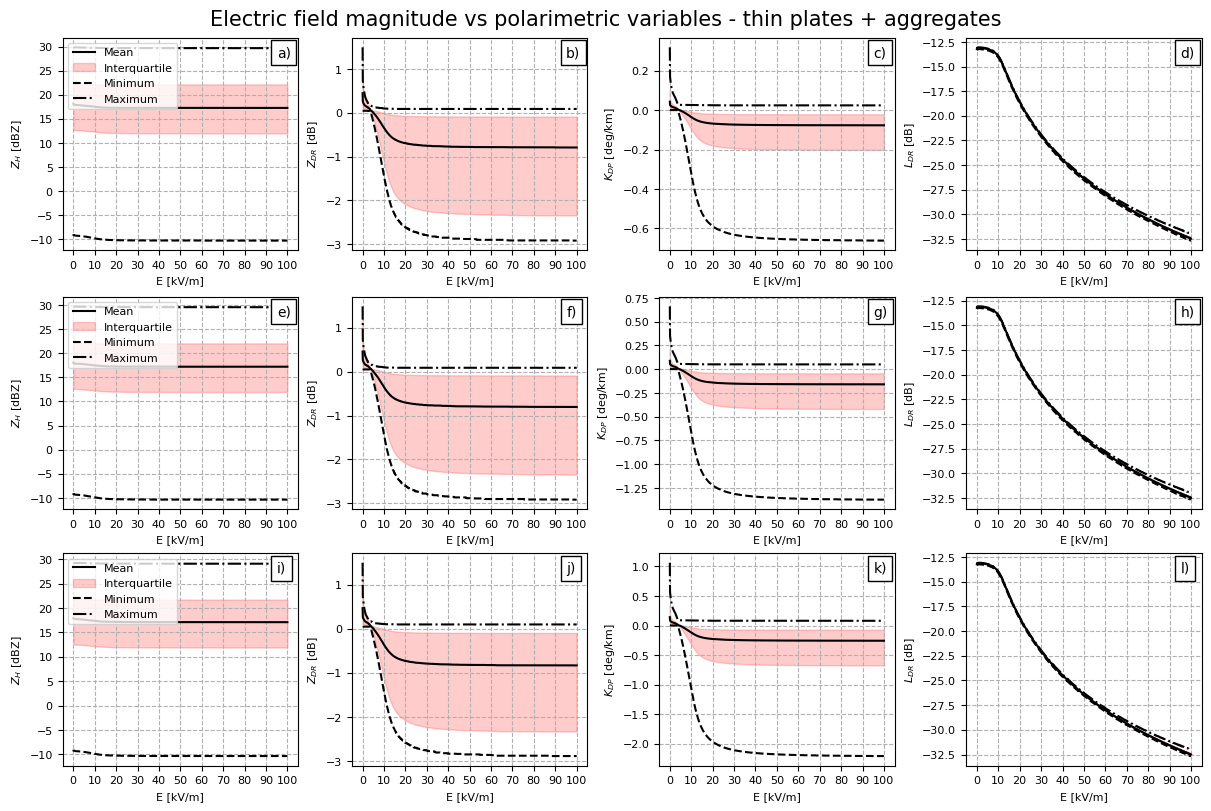

In [84]:
fig, axs = plt.subplots(3,4, figsize=[12,8], constrained_layout = True)

for n,ax in enumerate(axs.ravel()):
    if n == 0:
        ax.plot(E/1e3, stats_thin2[0]['median_zhS'], c='k', label='Mean')
        ax.fill_between(E/1e3, stats_thin2[0]['25_zhS'], stats_thin2[0]['75_zhS'], alpha=0.2, color='red', label = r'Interquartile')
        #ax.fill_between(E/1e3, np.subtract(mean_zhS, sd_zhS), np.add(mean_zhS, sd_zhS), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, stats_thin2[0]['min_zhS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thin2[0]['max_zhS'], c='k', ls = '-.', label=r'Maximum')
        #ax.plot(E/1e3, zhS_1, c='k', ls = '--', label=r'$N_0=2\times10^4$ [m$^{-3}$ mm $^{-1}$], $D_0=0.3$')
        #ax.plot(E/1e3, zhS_99, c='k', ls = '-.', label=r'$N_0=2\times10^5$ [m$^{-3}$ mm $^{-1}$], $D_0=0.7$')
        ax.legend(loc = 'upper left', fontsize=8)
        #ax.set_ylim(-20, 45)
        
    if n == 1:
        ax.plot(E/1e3, stats_thin2[0]['median_zdrS'], c='k')
        ax.plot(E/1e3, stats_thin2[0]['min_zdrS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thin2[0]['max_zdrS'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrS, sd_zdrS), np.add(mean_zdrS, sd_zdrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thin2[0]['25_zdrS'], stats_thin2[0]['75_zdrS'], alpha=0.2, color='red')
        #ax.plot(E/1e3, zdrS_1, c='k', ls = '--', label=r'$N_0=2\times10^4$ [m$^{-3}$ mm $^{-1}$], $D_0=0.3$')
        #ax.plot(E/1e3, zdrS_99, c='k', ls = '-.', label=r'$N_0=2\times10^5$ [m$^{-3}$ mm $^{-1}$], $D_0=0.7$')
        #ax.set_yticks(np.arange(-5, 3, 1))
    
    if n == 2:    
        ax.plot(E/1e3, stats_thin2[0]['median_kdpS'], c='k')
        ax.plot(E/1e3, stats_thin2[0]['min_kdpS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thin2[0]['max_kdpS'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpS, sd_kdpS), np.add(mean_kdpS, sd_kdpS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thin2[0]['25_kdpS'], stats_thin2[0]['75_kdpS'], alpha=0.2, color='red')
        #ax.plot(E/1e3, kdpS_1, c='k', ls = '--', label=r'$N_0=2\times10^4$ [m$^{-3}$ mm $^{-1}$], $D_0=0.3$')
        #ax.plot(E/1e3, kdpS_99, c='k', ls = '-.', label=r'$N_0=2\times10^5$ [m$^{-3}$ mm $^{-1}$], $D_0=0.7$')
        #ax.set_yticks(np.arange(-0.8, 0.4, 0.1))

    if n == 3:        
        ax.plot(E/1e3, stats_thin2[0]['median_ldrS'], c='k')
        ax.plot(E/1e3, stats_thin2[0]['min_ldrS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thin2[0]['max_ldrS'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrS, sd_ldrS), np.add(mean_ldrS, sd_ldrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thin2[0]['25_ldrS'], stats_thin2[0]['75_ldrS'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-45, -10, 5))

    if n == 4:
        ax.plot(E/1e3, stats_thin2[0]['median_zhC'], c='k', label='Mean')
        ax.fill_between(E/1e3, stats_thin2[0]['25_zhC'], stats_thin2[0]['75_zhC'], alpha=0.2, color='red', label = r'Interquartile')
        #ax.fill_between(E/1e3, np.subtract(mean_zhS, sd_zhS), np.add(mean_zhS, sd_zhS), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, stats_thin2[0]['min_zhC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thin2[0]['max_zhC'], c='k', ls = '-.', label=r'Maximum')
        #ax.plot(E/1e3, zhS_1, c='k', ls = '--', label=r'$N_0=2\times10^4$ [m$^{-3}$ mm $^{-1}$], $D_0=0.3$')
        #ax.plot(E/1e3, zhS_99, c='k', ls = '-.', label=r'$N_0=2\times10^5$ [m$^{-3}$ mm $^{-1}$], $D_0=0.7$')
        ax.legend(loc = 'upper left', fontsize=8)
        #ax.set_ylim(-20, 45)
        
    if n == 5:
        ax.plot(E/1e3, stats_thin2[0]['median_zdrC'], c='k')
        ax.plot(E/1e3, stats_thin2[0]['min_zdrC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thin2[0]['max_zdrC'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrS, sd_zdrS), np.add(mean_zdrS, sd_zdrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thin2[0]['25_zdrC'], stats_thin2[0]['75_zdrC'], alpha=0.2, color='red')
        #ax.plot(E/1e3, zdrS_1, c='k', ls = '--', label=r'$N_0=2\times10^4$ [m$^{-3}$ mm $^{-1}$], $D_0=0.3$')
        #ax.plot(E/1e3, zdrS_99, c='k', ls = '-.', label=r'$N_0=2\times10^5$ [m$^{-3}$ mm $^{-1}$], $D_0=0.7$')
        #ax.set_yticks(np.arange(-5, 3, 1))
    
    if n == 6:    
        ax.plot(E/1e3, stats_thin2[0]['median_kdpC'], c='k')
        ax.plot(E/1e3, stats_thin2[0]['min_kdpC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thin2[0]['max_kdpC'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpS, sd_kdpS), np.add(mean_kdpS, sd_kdpS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thin2[0]['25_kdpC'], stats_thin2[0]['75_kdpC'], alpha=0.2, color='red')
        #ax.plot(E/1e3, kdpS_1, c='k', ls = '--', label=r'$N_0=2\times10^4$ [m$^{-3}$ mm $^{-1}$], $D_0=0.3$')
        #ax.plot(E/1e3, kdpS_99, c='k', ls = '-.', label=r'$N_0=2\time

    if n == 7:        
        ax.plot(E/1e3, stats_thin2[0]['median_ldrC'], c='k')
        ax.plot(E/1e3, stats_thin2[0]['min_ldrC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thin2[0]['max_ldrC'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrS, sd_ldrS), np.add(mean_ldrS, sd_ldrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thin2[0]['25_ldrC'], stats_thin2[0]['75_ldrC'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-45, -10, 5))

    if n == 8:
        ax.plot(E/1e3, stats_thin2[0]['median_zhX'], c='k', label='Mean')
        ax.fill_between(E/1e3, stats_thin2[0]['25_zhX'], stats_thin2[0]['75_zhX'], alpha=0.2, color='red', label = r'Interquartile')
        #ax.fill_between(E/1e3, np.subtract(mean_zhS, sd_zhS), np.add(mean_zhS, sd_zhS), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, stats_thin2[0]['min_zhX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thin2[0]['max_zhX'], c='k', ls = '-.', label=r'Maximum')
        #ax.plot(E/1e3, zhS_1, c='k', ls = '--', label=r'$N_0=2\times10^4$ [m$^{-3}$ mm $^{-1}$], $D_0=0.3$')
        #ax.plot(E/1e3, zhS_99, c='k', ls = '-.', label=r'$N_0=2\times10^5$ [m$^{-3}$ mm $^{-1}$], $D_0=0.7$')
        ax.legend(loc = 'upper left', fontsize=8)
        #ax.set_ylim(-20, 45)
        
    if n == 9:
        ax.plot(E/1e3, stats_thin2[0]['median_zdrX'], c='k')
        ax.plot(E/1e3, stats_thin2[0]['min_zdrX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thin2[0]['max_zdrX'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrS, sd_zdrS), np.add(mean_zdrS, sd_zdrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thin2[0]['25_zdrX'], stats_thin2[0]['75_zdrX'], alpha=0.2, color='red')
        #ax.plot(E/1e3, zdrS_1, c='k', ls = '--', label=r'$N_0=2\times10^4$ [m$^{-3}$ mm $^{-1}$], $D_0=0.3$')
        #ax.plot(E/1e3, zdrS_99, c='k', ls = '-.', label=r'$N_0=2\times10^5$ [m$^{-3}$ mm $^{-1}$], $D_0=0.7$')
        #ax.set_yticks(np.arange(-5, 3, 1))
    
    if n == 10:    
        ax.plot(E/1e3, stats_thin2[0]['median_kdpX'], c='k')
        ax.plot(E/1e3, stats_thin2[0]['min_kdpX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thin2[0]['max_kdpX'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpS, sd_kdpS), np.add(mean_kdpS, sd_kdpS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thin2[0]['25_kdpX'], stats_thin2[0]['75_kdpX'], alpha=0.2, color='red')
        #ax.plot(E/1e3, kdpS_1, c='k', ls = '--', label=r'$N_0=2\times10^4$ [m$^{-3}$ mm $^{-1}$], $D_0=0.3$')
        #ax.plot(E/1e3, kdpS_99, c='k', ls = '-.', label=r'$N_0=2\time

    if n == 11:        
        ax.plot(E/1e3, stats_thin2[0]['median_ldrX'], c='k')
        ax.plot(E/1e3, stats_thin2[0]['min_ldrX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thin2[0]['max_ldrX'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrS, sd_ldrS), np.add(mean_ldrS, sd_ldrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thin2[0]['25_ldrX'], stats_thin2[0]['75_ldrX'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-45, -10, 5))


l = ['a)', 'b)', 'c)', 'd)','e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)']
for n, ax in enumerate(axs.ravel()):
    ax.set_xlabel('E [kV/m]')
    ax.set_xticks(np.arange(0, 110, 10))
    ax.annotate(l[n], xy = (0.91, 0.91), xycoords = 'axes fraction', fontsize = 10, bbox={'facecolor':'white', 'clip_on':True}, zorder = 50)
    ax.grid(True, ls = '--', which = 'both')
    if (n == 0 or n == 4 or n == 8):
       ax.set_ylabel(r'$Z_{H}$ [dBZ]') 
    if (n == 1 or n == 5 or n == 9):
       ax.set_ylabel(r'$Z_{DR}$ [dB]')
    if (n == 2 or n == 6 or n == 10):
       ax.set_ylabel(r'$K_{DP}$ [deg/km]')
    if (n == 3 or n == 7 or n == 11):
       ax.set_ylabel(r'$L_{DR}$ [dB]')

fig.suptitle('Electric field magnitude vs polarimetric variables - thin plates + aggregates', fontsize = 15)

#plt.savefig(f'results_long.png', bbox_inches = 'tight', dpi=300)

Text(0.5, 0.98, 'Electric field magnitude vs polarimetric variables - thick plates + snow')

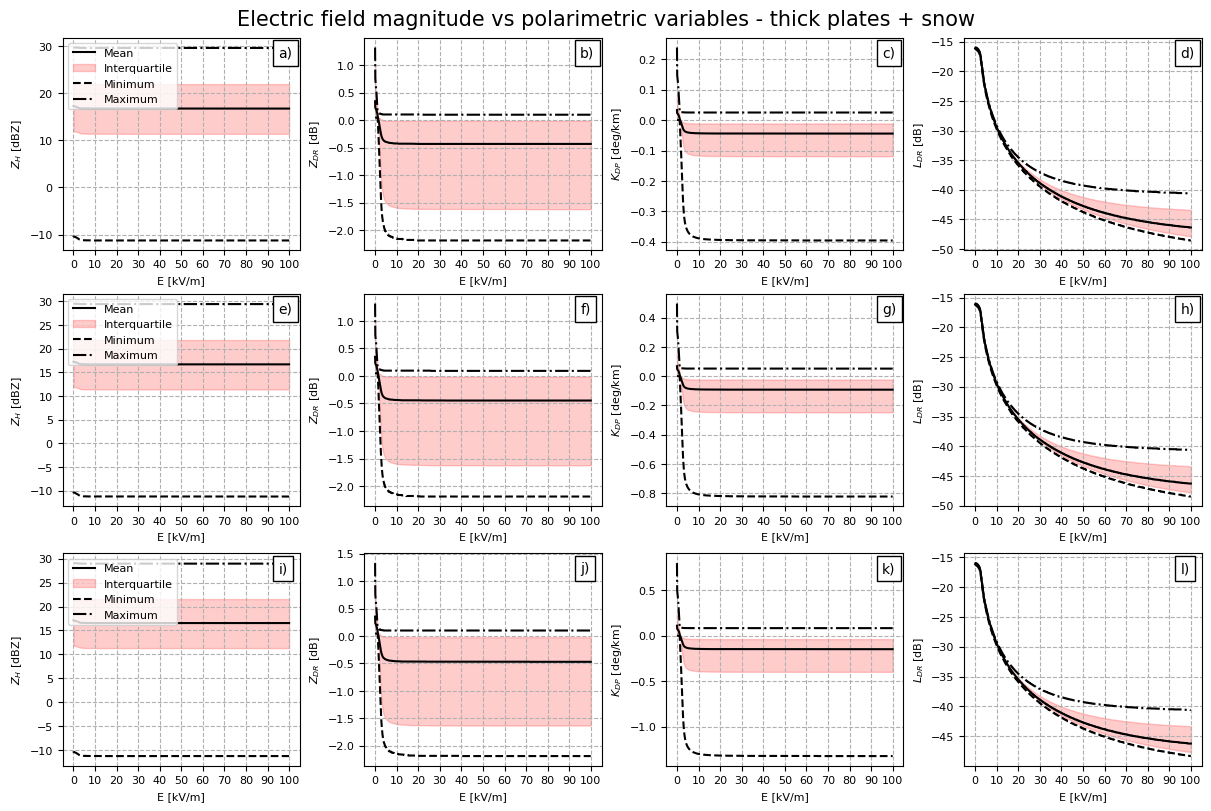

In [85]:
fig, axs = plt.subplots(3,4, figsize=[12,8], constrained_layout = True)

for n,ax in enumerate(axs.ravel()):
    if n == 0:
        ax.plot(E/1e3, stats_thick2[0]['median_zhS'], c='k', label='Mean')
        ax.fill_between(E/1e3, stats_thick2[0]['25_zhS'], stats_thick2[0]['75_zhS'], alpha=0.2, color='red', label = r'Interquartile')
        #ax.fill_between(E/1e3, np.subtract(mean_zhS, sd_zhS), np.add(mean_zhS, sd_zhS), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, stats_thick2[0]['min_zhS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thick2[0]['max_zhS'], c='k', ls = '-.', label=r'Maximum')
        #ax.plot(E/1e3, zhS_1, c='k', ls = '--', label=r'$N_0=2\times10^4$ [m$^{-3}$ mm $^{-1}$], $D_0=0.3$')
        #ax.plot(E/1e3, zhS_99, c='k', ls = '-.', label=r'$N_0=2\times10^5$ [m$^{-3}$ mm $^{-1}$], $D_0=0.7$')
        ax.legend(loc = 'upper left', fontsize=8)
        #ax.set_ylim(-20, 45)
        
    if n == 1:
        ax.plot(E/1e3, stats_thick2[0]['median_zdrS'], c='k')
        ax.plot(E/1e3, stats_thick2[0]['min_zdrS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thick2[0]['max_zdrS'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrS, sd_zdrS), np.add(mean_zdrS, sd_zdrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thick2[0]['25_zdrS'], stats_thick2[0]['75_zdrS'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-5, 3, 1))
    
    if n == 2:    
        ax.plot(E/1e3, stats_thick2[0]['median_kdpS'], c='k')
        ax.plot(E/1e3, stats_thick2[0]['min_kdpS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thick2[0]['max_kdpS'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpS, sd_kdpS), np.add(mean_kdpS, sd_kdpS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thick2[0]['25_kdpS'], stats_thick2[0]['75_kdpS'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-0.8, 0.4, 0.1))

    if n == 3:        
        ax.plot(E/1e3, stats_thick2[0]['median_ldrS'], c='k')
        ax.plot(E/1e3, stats_thick2[0]['min_ldrS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thick2[0]['max_ldrS'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrS, sd_ldrS), np.add(mean_ldrS, sd_ldrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thick2[0]['25_ldrS'], stats_thick2[0]['75_ldrS'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-45, -10, 5))

    if n == 4:
        ax.plot(E/1e3, stats_thick2[0]['median_zhC'], c='k', label='Mean')
        ax.fill_between(E/1e3, stats_thick2[0]['25_zhC'], stats_thick2[0]['75_zhC'], alpha=0.2, color='red', label = r'Interquartile')
        #ax.fill_between(E/1e3, np.subtract(mean_zhS, sd_zhS), np.add(mean_zhS, sd_zhS), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, stats_thick2[0]['min_zhC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thick2[0]['max_zhC'], c='k', ls = '-.', label=r'Maximum')
        ax.legend(loc = 'upper left', fontsize=8)
        #ax.set_ylim(-20, 45)
        
    if n == 5:
        ax.plot(E/1e3, stats_thick2[0]['median_zdrC'], c='k')
        ax.plot(E/1e3, stats_thick2[0]['min_zdrC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thick2[0]['max_zdrC'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrS, sd_zdrS), np.add(mean_zdrS, sd_zdrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thick2[0]['25_zdrC'], stats_thick2[0]['75_zdrC'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-5, 3, 1))
    
    if n == 6:    
        ax.plot(E/1e3, stats_thick2[0]['median_kdpC'], c='k')
        ax.plot(E/1e3, stats_thick2[0]['min_kdpC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thick2[0]['max_kdpC'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpS, sd_kdpS), np.add(mean_kdpS, sd_kdpS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thick2[0]['25_kdpC'], stats_thick2[0]['75_kdpC'], alpha=0.2, color='red')

    if n == 7:        
        ax.plot(E/1e3, stats_thick2[0]['median_ldrC'], c='k')
        ax.plot(E/1e3, stats_thick2[0]['min_ldrC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thick2[0]['max_ldrC'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrS, sd_ldrS), np.add(mean_ldrS, sd_ldrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thick2[0]['25_ldrC'], stats_thick2[0]['75_ldrC'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-45, -10, 5))

    if n == 8:
        ax.plot(E/1e3, stats_thick2[0]['median_zhX'], c='k', label='Mean')
        ax.fill_between(E/1e3, stats_thick2[0]['25_zhX'], stats_thick2[0]['75_zhX'], alpha=0.2, color='red', label = r'Interquartile')
        #ax.fill_between(E/1e3, np.subtract(mean_zhS, sd_zhS), np.add(mean_zhS, sd_zhS), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, stats_thick2[0]['min_zhX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thick2[0]['max_zhX'], c='k', ls = '-.', label=r'Maximum')
        ax.legend(loc = 'upper left', fontsize=8)
        #ax.set_ylim(-20, 45)
        
    if n == 9:
        ax.plot(E/1e3, stats_thick2[0]['median_zdrX'], c='k')
        ax.plot(E/1e3, stats_thick2[0]['min_zdrX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thick2[0]['max_zdrX'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrS, sd_zdrS), np.add(mean_zdrS, sd_zdrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thick2[0]['25_zdrX'], stats_thick2[0]['75_zdrX'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-5, 3, 1))
    
    if n == 10:    
        ax.plot(E/1e3, stats_thick2[0]['median_kdpX'], c='k')
        ax.plot(E/1e3, stats_thick2[0]['min_kdpX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thick2[0]['max_kdpX'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpS, sd_kdpS), np.add(mean_kdpS, sd_kdpS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thick2[0]['25_kdpX'], stats_thick2[0]['75_kdpX'], alpha=0.2, color='red')

    if n == 11:        
        ax.plot(E/1e3, stats_thick2[0]['median_ldrX'], c='k')
        ax.plot(E/1e3, stats_thick2[0]['min_ldrX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thick2[0]['max_ldrX'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrS, sd_ldrS), np.add(mean_ldrS, sd_ldrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thick2[0]['25_ldrX'], stats_thick2[0]['75_ldrX'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-45, -10, 5))


l = ['a)', 'b)', 'c)', 'd)','e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)']
for n, ax in enumerate(axs.ravel()):
    ax.set_xlabel('E [kV/m]')
    ax.set_xticks(np.arange(0, 110, 10))
    ax.annotate(l[n], xy = (0.91, 0.91), xycoords = 'axes fraction', fontsize = 10, bbox={'facecolor':'white', 'clip_on':True}, zorder = 50)
    ax.grid(True, ls = '--', which = 'both')
    if (n == 0 or n == 4 or n == 8):
       ax.set_ylabel(r'$Z_{H}$ [dBZ]') 
    if (n == 1 or n == 5 or n == 9):
       ax.set_ylabel(r'$Z_{DR}$ [dB]')
    if (n == 2 or n == 6 or n == 10):
       ax.set_ylabel(r'$K_{DP}$ [deg/km]')
    if (n == 3 or n == 7 or n == 11):
       ax.set_ylabel(r'$L_{DR}$ [dB]')

fig.suptitle('Electric field magnitude vs polarimetric variables - thick plates + snow', fontsize = 15)

#plt.savefig(f'results_long.png', bbox_inches = 'tight', dpi=300)np.std(data_col2S[0]['zdr_plate'], (0,1))

Text(0.5, 0.98, 'Electric field magnitude vs polarimetric variables - short columns + snow')

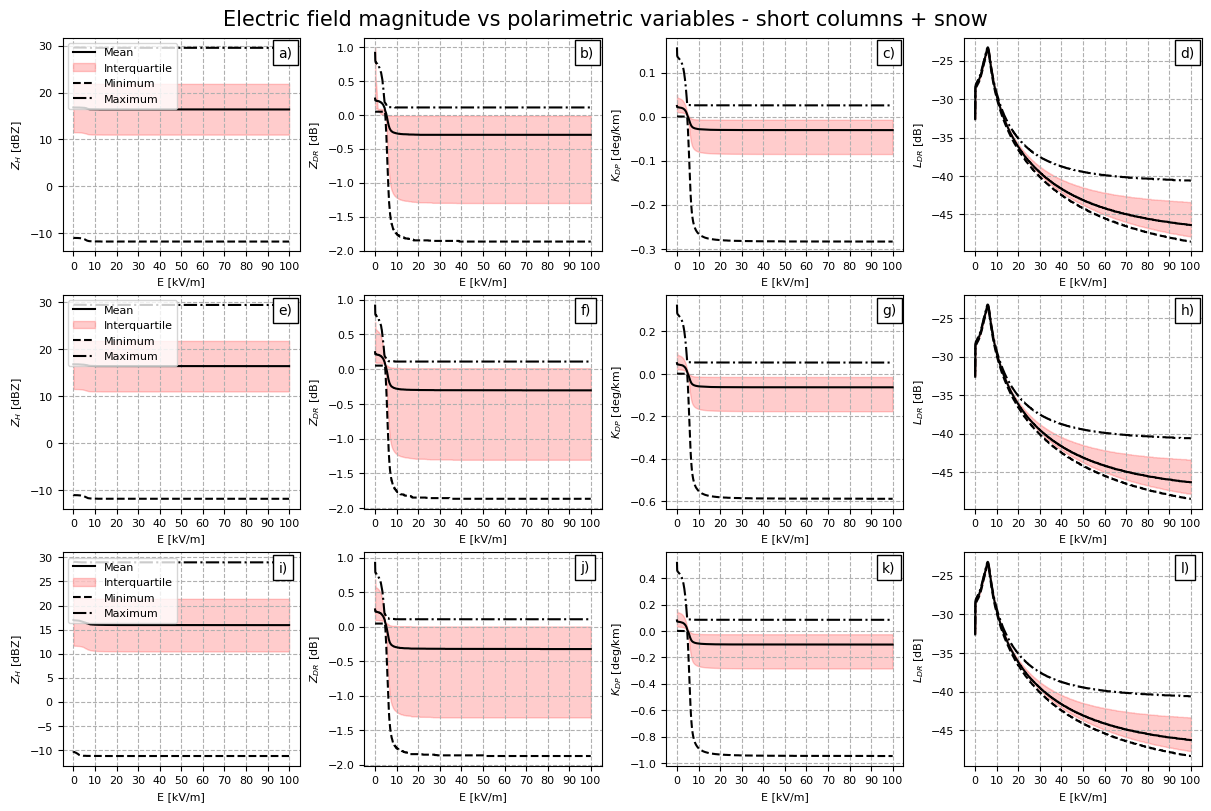

In [86]:
fig, axs = plt.subplots(3,4, figsize=[12,8], constrained_layout = True)

for n,ax in enumerate(axs.ravel()):
    if n == 0:
        ax.plot(E/1e3, stats_short2[0]['median_zhS'], c='k', label='Mean')
        ax.fill_between(E/1e3, stats_short2[0]['25_zhS'], stats_short2[0]['75_zhS'], alpha=0.2, color='red', label = r'Interquartile')
        #ax.fill_between(E/1e3, np.subtract(mean_zhS, sd_zhS), np.add(mean_zhS, sd_zhS), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, stats_short2[0]['min_zhS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_short2[0]['max_zhS'], c='k', ls = '-.', label=r'Maximum')
        ax.legend(loc = 'upper left', fontsize=8)
        #ax.set_ylim(-20, 45)
        
    if n == 1:
        ax.plot(E/1e3, stats_short2[0]['median_zdrS'], c='k')
        ax.plot(E/1e3, stats_short2[0]['min_zdrS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_short2[0]['max_zdrS'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrS, sd_zdrS), np.add(mean_zdrS, sd_zdrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_thick2[0]['25_zdrS'], stats_short2[0]['75_zdrS'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-5, 3, 1))
    
    if n == 2:    
        ax.plot(E/1e3, stats_short2[0]['median_kdpS'], c='k')
        ax.plot(E/1e3, stats_short2[0]['min_kdpS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_short2[0]['max_kdpS'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpS, sd_kdpS), np.add(mean_kdpS, sd_kdpS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_short2[0]['25_kdpS'], stats_short2[0]['75_kdpS'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-0.8, 0.4, 0.1))

    if n == 3:        
        ax.plot(E/1e3, stats_short2[0]['median_ldrS'], c='k')
        ax.plot(E/1e3, stats_short2[0]['min_ldrS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_short2[0]['max_ldrS'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrS, sd_ldrS), np.add(mean_ldrS, sd_ldrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_short2[0]['25_ldrS'], stats_short2[0]['75_ldrS'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-45, -10, 5))

    if n == 4:
        ax.plot(E/1e3, stats_short2[0]['median_zhC'], c='k', label='Mean')
        ax.fill_between(E/1e3, stats_short2[0]['25_zhC'], stats_short2[0]['75_zhC'], alpha=0.2, color='red', label = r'Interquartile')
        #ax.fill_between(E/1e3, np.subtract(mean_zhS, sd_zhS), np.add(mean_zhS, sd_zhS), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, stats_short2[0]['min_zhC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_short2[0]['max_zhC'], c='k', ls = '-.', label=r'Maximum')
        ax.legend(loc = 'upper left', fontsize=8)
        #ax.set_ylim(-20, 45)
        
    if n == 5:
        ax.plot(E/1e3, stats_short2[0]['median_zdrC'], c='k')
        ax.plot(E/1e3, stats_short2[0]['min_zdrC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_short2[0]['max_zdrC'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrS, sd_zdrS), np.add(mean_zdrS, sd_zdrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_short2[0]['25_zdrC'], stats_short2[0]['75_zdrC'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-5, 3, 1))
    
    if n == 6:    
        ax.plot(E/1e3, stats_short2[0]['median_kdpC'], c='k')
        ax.plot(E/1e3, stats_short2[0]['min_kdpC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_short2[0]['max_kdpC'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpS, sd_kdpS), np.add(mean_kdpS, sd_kdpS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_short2[0]['25_kdpC'], stats_short2[0]['75_kdpC'], alpha=0.2, color='red')
        
    if n == 7:        
        ax.plot(E/1e3, stats_short2[0]['median_ldrC'], c='k')
        ax.plot(E/1e3, stats_short2[0]['min_ldrC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_short2[0]['max_ldrC'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrS, sd_ldrS), np.add(mean_ldrS, sd_ldrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_short2[0]['25_ldrC'], stats_short2[0]['75_ldrC'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-45, -10, 5))

    if n == 8:
        ax.plot(E/1e3, stats_short2[0]['median_zhX'], c='k', label='Mean')
        ax.fill_between(E/1e3, stats_short2[0]['25_zhX'], stats_short2[0]['75_zhX'], alpha=0.2, color='red', label = r'Interquartile')
        #ax.fill_between(E/1e3, np.subtract(mean_zhS, sd_zhS), np.add(mean_zhS, sd_zhS), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, stats_thick2[0]['min_zhX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_thick2[0]['max_zhX'], c='k', ls = '-.', label=r'Maximum')
        ax.legend(loc = 'upper left', fontsize=8)
        #ax.set_ylim(-20, 45)
        
    if n == 9:
        ax.plot(E/1e3, stats_short2[0]['median_zdrX'], c='k')
        ax.plot(E/1e3, stats_short2[0]['min_zdrX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_short2[0]['max_zdrX'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrS, sd_zdrS), np.add(mean_zdrS, sd_zdrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_short2[0]['25_zdrX'], stats_short2[0]['75_zdrX'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-5, 3, 1))
    
    if n == 10:    
        ax.plot(E/1e3, stats_short2[0]['median_kdpX'], c='k')
        ax.plot(E/1e3, stats_short2[0]['min_kdpX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_short2[0]['max_kdpX'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpS, sd_kdpS), np.add(mean_kdpS, sd_kdpS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_short2[0]['25_kdpX'], stats_short2[0]['75_kdpX'], alpha=0.2, color='red')

    if n == 11:        
        ax.plot(E/1e3, stats_short2[0]['median_ldrX'], c='k')
        ax.plot(E/1e3, stats_short2[0]['min_ldrX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_short2[0]['max_ldrX'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrS, sd_ldrS), np.add(mean_ldrS, sd_ldrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_short2[0]['25_ldrX'], stats_short2[0]['75_ldrX'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-45, -10, 5))


l = ['a)', 'b)', 'c)', 'd)','e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)']
for n, ax in enumerate(axs.ravel()):
    ax.set_xlabel('E [kV/m]')
    ax.set_xticks(np.arange(0, 110, 10))
    ax.annotate(l[n], xy = (0.91, 0.91), xycoords = 'axes fraction', fontsize = 10, bbox={'facecolor':'white', 'clip_on':True}, zorder = 50)
    ax.grid(True, ls = '--', which = 'both')
    if (n == 0 or n == 4 or n == 8):
       ax.set_ylabel(r'$Z_{H}$ [dBZ]') 
    if (n == 1 or n == 5 or n == 9):
       ax.set_ylabel(r'$Z_{DR}$ [dB]')
    if (n == 2 or n == 6 or n == 10):
       ax.set_ylabel(r'$K_{DP}$ [deg/km]')
    if (n == 3 or n == 7 or n == 11):
       ax.set_ylabel(r'$L_{DR}$ [dB]')

fig.suptitle('Electric field magnitude vs polarimetric variables - short columns + snow', fontsize = 15)

#plt.savefig(f'results_long.png', bbox_inches = 'tight', dpi=300)np.std(data_col2S[0]['zdr_plate'], (0,1))

Text(0.5, 0.98, 'Electric field magnitude vs polarimetric variables - long columns + aggregates')

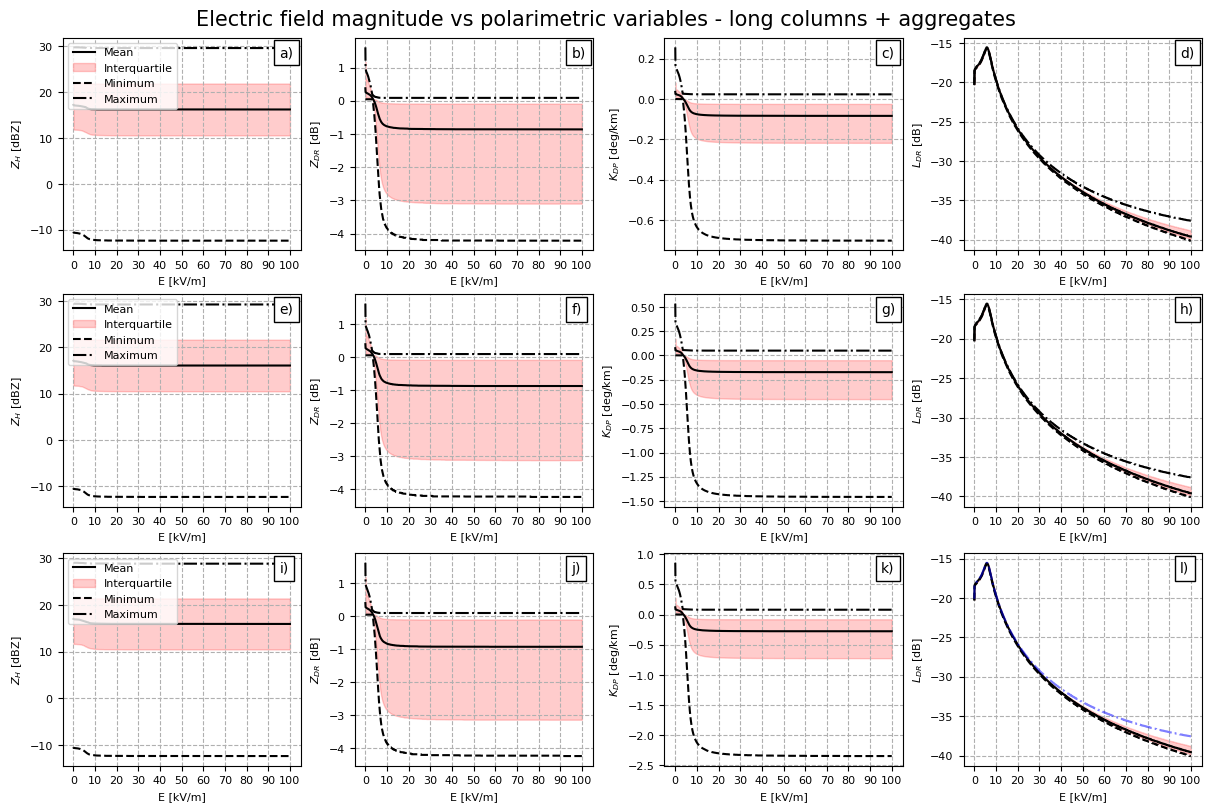

In [87]:
fig, axs = plt.subplots(3,4, figsize=[12,8], constrained_layout = True)

for n,ax in enumerate(axs.ravel()):
    if n == 0:
        ax.plot(E/1e3, stats_long2[0]['median_zhS'], c='k', label='Mean')
        ax.fill_between(E/1e3, stats_long2[0]['25_zhS'], stats_long2[0]['75_zhS'], alpha=0.2, color='red', label = r'Interquartile')
        #ax.fill_between(E/1e3, np.subtract(mean_zhS, sd_zhS), np.add(mean_zhS, sd_zhS), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, stats_long2[0]['min_zhS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_long2[0]['max_zhS'], c='k', ls = '-.', label=r'Maximum')
        ax.legend(loc = 'upper left', fontsize=8)
        #ax.set_ylim(-20, 45)
        
    if n == 1:
        ax.plot(E/1e3, stats_long2[0]['median_zdrS'], c='k')
        ax.plot(E/1e3, stats_long2[0]['min_zdrS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_long2[0]['max_zdrS'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrS, sd_zdrS), np.add(mean_zdrS, sd_zdrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_long2[0]['25_zdrS'], stats_long2[0]['75_zdrS'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-5, 3, 1))
    
    if n == 2:    
        ax.plot(E/1e3, stats_long2[0]['median_kdpS'], c='k')
        ax.plot(E/1e3, stats_long2[0]['min_kdpS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_long2[0]['max_kdpS'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpS, sd_kdpS), np.add(mean_kdpS, sd_kdpS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_long2[0]['25_kdpS'], stats_long2[0]['75_kdpS'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-0.8, 0.4, 0.1))

    if n == 3:        
        ax.plot(E/1e3, stats_long2[0]['median_ldrS'], c='k')
        ax.plot(E/1e3, stats_long2[0]['min_ldrS'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_long2[0]['max_ldrS'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrS, sd_ldrS), np.add(mean_ldrS, sd_ldrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_long2[0]['25_ldrS'], stats_long2[0]['75_ldrS'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-45, -10, 5))

    if n == 4:
        ax.plot(E/1e3, stats_long2[0]['median_zhC'], c='k', label='Mean')
        ax.fill_between(E/1e3, stats_long2[0]['25_zhC'], stats_long2[0]['75_zhC'], alpha=0.2, color='red', label = r'Interquartile')
        #ax.fill_between(E/1e3, np.subtract(mean_zhS, sd_zhS), np.add(mean_zhS, sd_zhS), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, stats_long2[0]['min_zhC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_long2[0]['max_zhC'], c='k', ls = '-.', label=r'Maximum')
        ax.legend(loc = 'upper left', fontsize=8)
        #ax.set_ylim(-20, 45)
        
    if n == 5:
        ax.plot(E/1e3, stats_long2[0]['median_zdrC'], c='k')
        ax.plot(E/1e3, stats_long2[0]['min_zdrC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_long2[0]['max_zdrC'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrS, sd_zdrS), np.add(mean_zdrS, sd_zdrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_long2[0]['25_zdrC'], stats_long2[0]['75_zdrC'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-5, 3, 1))
    
    if n == 6:    
        ax.plot(E/1e3, stats_long2[0]['median_kdpC'], c='k')
        ax.plot(E/1e3, stats_long2[0]['min_kdpC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_long2[0]['max_kdpC'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpS, sd_kdpS), np.add(mean_kdpS, sd_kdpS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_long2[0]['25_kdpC'], stats_long2[0]['75_kdpC'], alpha=0.2, color='red')

    if n == 7:        
        ax.plot(E/1e3, stats_long2[0]['median_ldrC'], c='k')
        ax.plot(E/1e3, stats_long2[0]['min_ldrC'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_long2[0]['max_ldrC'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrS, sd_ldrS), np.add(mean_ldrS, sd_ldrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_long2[0]['25_ldrC'], stats_long2[0]['75_ldrC'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-45, -10, 5))

    if n == 8:
        ax.plot(E/1e3, stats_long2[0]['median_zhX'], c='k', label='Mean')
        ax.fill_between(E/1e3, stats_long2[0]['25_zhX'], stats_long2[0]['75_zhX'], alpha=0.2, color='red', label = r'Interquartile')
        #ax.fill_between(E/1e3, np.subtract(mean_zhS, sd_zhS), np.add(mean_zhS, sd_zhS), alpha=0.2, color='red', label = r'$\pm1\sigma$')
        ax.plot(E/1e3, stats_long2[0]['min_zhX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_long2[0]['max_zhX'], c='k', ls = '-.', label=r'Maximum')
        ax.legend(loc = 'upper left', fontsize=8)
        #ax.set_ylim(-20, 45)
        
    if n == 9:
        ax.plot(E/1e3, stats_long2[0]['median_zdrX'], c='k')
        ax.plot(E/1e3, stats_long2[0]['min_zdrX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_long2[0]['max_zdrX'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_zdrS, sd_zdrS), np.add(mean_zdrS, sd_zdrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_long2[0]['25_zdrX'], stats_long2[0]['75_zdrX'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-5, 3, 1))
    
    if n == 10:    
        ax.plot(E/1e3, stats_long2[0]['median_kdpX'], c='k')
        ax.plot(E/1e3, stats_long2[0]['min_kdpX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_long2[0]['max_kdpX'], c='k', ls = '-.', label=r'Maximum')
        #ax.fill_between(E/1e3, np.subtract(mean_kdpS, sd_kdpS), np.add(mean_kdpS, sd_kdpS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_long2[0]['25_kdpX'], stats_long2[0]['75_kdpX'], alpha=0.2, color='red')

    if n == 11:        
        ax.plot(E/1e3, stats_long2[0]['median_ldrX'], c='k')
        ax.plot(E/1e3, stats_long2[0]['min_ldrX'], c='k', ls = '--', label=r'Minimum')
        ax.plot(E/1e3, stats_long2[0]['max_ldrX'], alpha=0.5, c='b', ls = '-.')
        #ax.fill_between(E/1e3, np.subtract(mean_ldrS, sd_ldrS), np.add(mean_ldrS, sd_ldrS), alpha=0.2, color='red')
        ax.fill_between(E/1e3, stats_long2[0]['25_ldrX'], stats_long2[0]['75_ldrX'], alpha=0.2, color='red')
        #ax.set_yticks(np.arange(-45, -10, 5))


l = ['a)', 'b)', 'c)', 'd)','e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)']
for n, ax in enumerate(axs.ravel()):
    ax.set_xlabel('E [kV/m]')
    ax.set_xticks(np.arange(0, 110, 10))
    ax.annotate(l[n], xy = (0.91, 0.91), xycoords = 'axes fraction', fontsize = 10, bbox={'facecolor':'white', 'clip_on':True}, zorder = 50)
    ax.grid(True, ls = '--', which = 'both')
    if (n == 0 or n == 4 or n == 8):
       ax.set_ylabel(r'$Z_{H}$ [dBZ]') 
    if (n == 1 or n == 5 or n == 9):
       ax.set_ylabel(r'$Z_{DR}$ [dB]')
    if (n == 2 or n == 6 or n == 10):
       ax.set_ylabel(r'$K_{DP}$ [deg/km]')
    if (n == 3 or n == 7 or n == 11):
       ax.set_ylabel(r'$L_{DR}$ [dB]')

fig.suptitle('Electric field magnitude vs polarimetric variables - long columns + aggregates', fontsize = 15)

#plt.savefig(f'results_long.png', bbox_inches = 'tight', dpi=300)np.std(data_col2S[0]['zdr_plate'], (0,1))

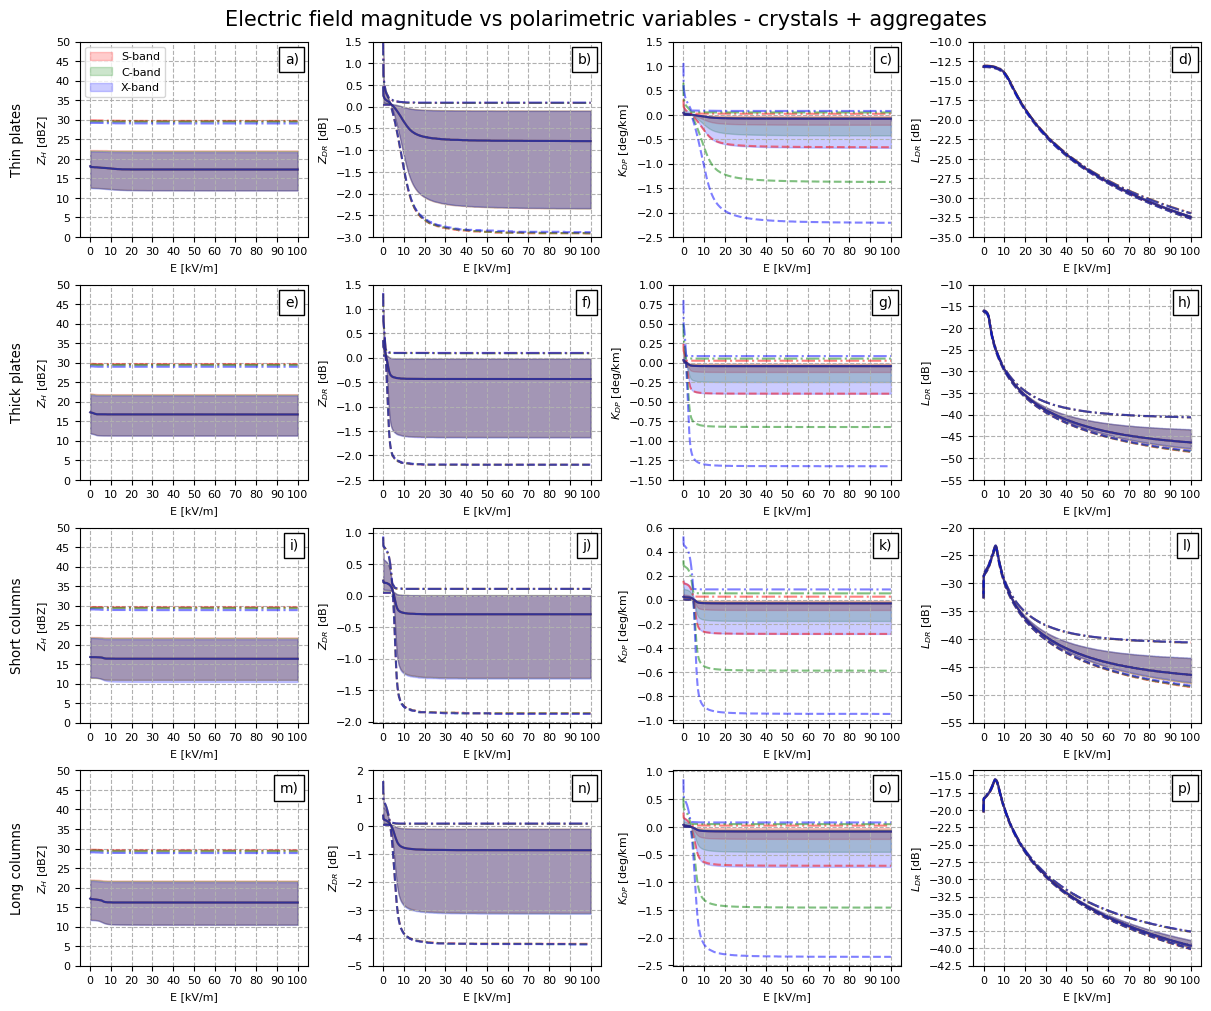

In [88]:
fig, axs = plt.subplots(4,4, figsize=[12,10], constrained_layout = True)

rows = [f'{row}' for row in ['Thin plates', 'Thick plates', 'Short columns', 'Long columns']]

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, rotation=90, textcoords='offset points',
                size='large', ha='right', va='center')

for n,ax in enumerate(axs.ravel()):
    if n == 0:
        ax.plot(E/1e3, stats_thin2[0]['median_zhS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_thin2[0]['median_zhS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_thin2[0]['median_zhS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_thin2[0]['25_zhS'], stats_thin2[0]['75_zhS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_thin2[0]['25_zhC'], stats_thin2[0]['75_zhC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_thin2[0]['25_zhX'], stats_thin2[0]['75_zhX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_thin2[0]['min_zhS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_thin2[0]['max_zhS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_thin2[0]['min_zhC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_thin2[0]['max_zhC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_thin2[0]['min_zhX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_thin2[0]['max_zhX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(0, 55, 5))
        ax.set_ylim(0, 50)
        ax.legend(loc = 'upper left', fontsize=8)
        
    if n == 1:
        ax.plot(E/1e3, stats_thin2[0]['median_zdrS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_thin2[0]['median_zdrS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_thin2[0]['median_zdrS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_thin2[0]['25_zdrS'], stats_thin2[0]['75_zdrS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_thin2[0]['25_zdrC'], stats_thin2[0]['75_zdrC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_thin2[0]['25_zdrX'], stats_thin2[0]['75_zdrX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_thin2[0]['min_zdrS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_thin2[0]['max_zdrS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_thin2[0]['min_zdrC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_thin2[0]['max_zdrC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_thin2[0]['min_zdrX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_thin2[0]['max_zdrX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(-3, 2.5, .5))
        ax.set_ylim(-3, 1.5)
    
    if n == 2:    
        ax.plot(E/1e3, stats_thin2[0]['median_kdpS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_thin2[0]['median_kdpS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_thin2[0]['median_kdpS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_thin2[0]['25_kdpS'], stats_thin2[0]['75_kdpS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_thin2[0]['25_kdpC'], stats_thin2[0]['75_kdpC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_thin2[0]['25_kdpX'], stats_thin2[0]['75_kdpX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_thin2[0]['min_kdpS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_thin2[0]['max_kdpS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_thin2[0]['min_kdpC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_thin2[0]['max_kdpC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_thin2[0]['min_kdpX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_thin2[0]['max_kdpX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(-2.5, 2, .5))
        #ax.set_ylim(-2, 1)

    if n == 3:        
        ax.plot(E/1e3, stats_thin2[0]['median_ldrS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_thin2[0]['median_ldrS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_thin2[0]['median_ldrS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_thin2[0]['25_ldrS'], stats_thin2[0]['75_ldrS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_thin2[0]['25_ldrC'], stats_thin2[0]['75_ldrC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_thin2[0]['25_ldrX'], stats_thin2[0]['75_ldrX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_thin2[0]['min_ldrS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_thin2[0]['max_ldrS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_thin2[0]['min_ldrC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_thin2[0]['max_ldrC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_thin2[0]['min_ldrX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_thin2[0]['max_ldrX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(-35, -7.5, 2.5))
        #ax.set_ylim(-35, -10)

    if n == 4:
        ax.plot(E/1e3, stats_thick2[0]['median_zhS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_thick2[0]['median_zhS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_thick2[0]['median_zhS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_thick2[0]['25_zhS'], stats_thick2[0]['75_zhS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_thick2[0]['25_zhC'], stats_thick2[0]['75_zhC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_thick2[0]['25_zhX'], stats_thick2[0]['75_zhX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_thick2[0]['min_zhS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_thick2[0]['max_zhS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_thick2[0]['min_zhC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_thick2[0]['max_zhC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_thick2[0]['min_zhX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_thick2[0]['max_zhX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(0, 55, 5))
        ax.set_ylim(0, 50)
        
    if n == 5:
        ax.plot(E/1e3, stats_thick2[0]['median_zdrS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_thick2[0]['median_zdrS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_thick2[0]['median_zdrS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_thick2[0]['25_zdrS'], stats_thick2[0]['75_zdrS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_thick2[0]['25_zdrC'], stats_thick2[0]['75_zdrC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_thick2[0]['25_zdrX'], stats_thick2[0]['75_zdrX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_thick2[0]['min_zdrS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_thick2[0]['max_zdrS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_thick2[0]['min_zdrC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_thick2[0]['max_zdrC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_thick2[0]['min_zdrX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_thick2[0]['max_zdrX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(-2.5, 2, .5))
        ax.set_ylim(-2.5, 1.5)
    
    if n == 6:    
        ax.plot(E/1e3, stats_thick2[0]['median_kdpS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_thick2[0]['median_kdpS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_thick2[0]['median_kdpS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_thick2[0]['25_kdpS'], stats_thick2[0]['75_kdpS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_thick2[0]['25_kdpC'], stats_thick2[0]['75_kdpC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_thick2[0]['25_kdpX'], stats_thick2[0]['75_kdpX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_thick2[0]['min_kdpS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_thick2[0]['max_kdpS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_thick2[0]['min_kdpC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_thick2[0]['max_kdpC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_thick2[0]['min_kdpX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_thick2[0]['max_kdpX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(-1.5, 1.25, 0.25))
        #ax.set_ylim(-2, 1)


    if n == 7:        
        ax.plot(E/1e3, stats_thick2[0]['median_ldrS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_thick2[0]['median_ldrS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_thick2[0]['median_ldrS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_thick2[0]['25_ldrS'], stats_thick2[0]['75_ldrS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_thick2[0]['25_ldrC'], stats_thick2[0]['75_ldrC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_thick2[0]['25_ldrX'], stats_thick2[0]['75_ldrX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_thick2[0]['min_ldrS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_thick2[0]['max_ldrS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_thick2[0]['min_ldrC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_thick2[0]['max_ldrC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_thick2[0]['min_ldrX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_thick2[0]['max_ldrX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(-55, -5, 5))
        #ax.set_ylim(-55, -10)
        
    if n == 8:
        ax.plot(E/1e3, stats_short2[0]['median_zhS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_short2[0]['median_zhS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_short2[0]['median_zhS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_short2[0]['25_zhS'], stats_short2[0]['75_zhS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_short2[0]['25_zhC'], stats_short2[0]['75_zhC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_short2[0]['25_zhX'], stats_short2[0]['75_zhX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_short2[0]['min_zhS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_short2[0]['max_zhS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_short2[0]['min_zhC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_short2[0]['max_zhC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_short2[0]['min_zhX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_short2[0]['max_zhX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(0, 55, 5))
        ax.set_ylim(0, 50)
        
    if n == 9:
        ax.plot(E/1e3, stats_short2[0]['median_zdrS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_short2[0]['median_zdrS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_short2[0]['median_zdrS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_short2[0]['25_zdrS'], stats_short2[0]['75_zdrS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_short2[0]['25_zdrC'], stats_short2[0]['75_zdrC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_short2[0]['25_zdrX'], stats_short2[0]['75_zdrX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_short2[0]['min_zdrS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_short2[0]['max_zdrS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_short2[0]['min_zdrC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_short2[0]['max_zdrC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_short2[0]['min_zdrX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_short2[0]['max_zdrX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(-2, 1.5, .5))
        #ax.set_ylim(-2, 1)
    
    if n == 10:    
        ax.plot(E/1e3, stats_short2[0]['median_kdpS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_short2[0]['median_kdpS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_short2[0]['median_kdpS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_short2[0]['25_kdpS'], stats_short2[0]['75_kdpS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_short2[0]['25_kdpC'], stats_short2[0]['75_kdpC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_short2[0]['25_kdpX'], stats_short2[0]['75_kdpX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_short2[0]['min_kdpS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_short2[0]['max_kdpS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_short2[0]['min_kdpC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_short2[0]['max_kdpC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_short2[0]['min_kdpX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_short2[0]['max_kdpX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(-1, .80, .20))
        #ax.set_ylim(-1.5, .5)


    if n == 11:        
        ax.plot(E/1e3, stats_short2[0]['median_ldrS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_short2[0]['median_ldrS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_short2[0]['median_ldrS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_short2[0]['25_ldrS'], stats_short2[0]['75_ldrS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_short2[0]['25_ldrC'], stats_short2[0]['75_ldrC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_short2[0]['25_ldrX'], stats_short2[0]['75_ldrX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_short2[0]['min_ldrS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_short2[0]['max_ldrS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_short2[0]['min_ldrC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_short2[0]['max_ldrC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_short2[0]['min_ldrX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_short2[0]['max_ldrX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(-55, -15, 5))
        #ax.set_ylim(-50, -20)
        
    if n == 12:
        ax.plot(E/1e3, stats_long2[0]['median_zhS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_long2[0]['median_zhS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_long2[0]['median_zhS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_long2[0]['25_zhS'], stats_long2[0]['75_zhS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_long2[0]['25_zhC'], stats_long2[0]['75_zhC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_long2[0]['25_zhX'], stats_long2[0]['75_zhX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_long2[0]['min_zhS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_long2[0]['max_zhS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_long2[0]['min_zhC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_long2[0]['max_zhC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_long2[0]['min_zhX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_long2[0]['max_zhX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(0, 55, 5))
        ax.set_ylim(0, 50)
        
    if n == 13:
        ax.plot(E/1e3, stats_long2[0]['median_zdrS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_long2[0]['median_zdrS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_long2[0]['median_zdrS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_long2[0]['25_zdrS'], stats_long2[0]['75_zdrS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_long2[0]['25_zdrC'], stats_long2[0]['75_zdrC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_long2[0]['25_zdrX'], stats_long2[0]['75_zdrX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_long2[0]['min_zdrS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_long2[0]['max_zdrS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_long2[0]['min_zdrC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_long2[0]['max_zdrC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_long2[0]['min_zdrX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_long2[0]['max_zdrX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(-5, 3, 1))
        #ax.set_ylim(-5, 2)
    
    if n == 14:    
        ax.plot(E/1e3, stats_long2[0]['median_kdpS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_long2[0]['median_kdpS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_long2[0]['median_kdpS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_long2[0]['25_kdpS'], stats_long2[0]['75_kdpS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_long2[0]['25_kdpC'], stats_long2[0]['75_kdpC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_long2[0]['25_kdpX'], stats_long2[0]['75_kdpX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_long2[0]['min_kdpS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_long2[0]['max_kdpS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_long2[0]['min_kdpC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_long2[0]['max_kdpC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_long2[0]['min_kdpX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_long2[0]['max_kdpX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(-2.5, 1.5, .5))
        #ax.set_ylim(-3, 1)


    if n == 15:        
        ax.plot(E/1e3, stats_long2[0]['median_ldrS'], alpha=0.5, c='r')
        ax.plot(E/1e3, stats_long2[0]['median_ldrS'], alpha=0.5, c='g')
        ax.plot(E/1e3, stats_long2[0]['median_ldrS'], alpha=0.5, c='b')
        ax.fill_between(E/1e3, stats_long2[0]['25_ldrS'], stats_long2[0]['75_ldrS'], alpha=0.2, color='red', label = r'S-band')
        ax.fill_between(E/1e3, stats_long2[0]['25_ldrC'], stats_long2[0]['75_ldrC'], alpha=0.2, color='green', label = r'C-band')
        ax.fill_between(E/1e3, stats_long2[0]['25_ldrX'], stats_long2[0]['75_ldrX'], alpha=0.2, color='blue', label = r'X-band')
        ax.plot(E/1e3, stats_long2[0]['min_ldrS'], alpha=0.5, c='r', ls = '--')
        ax.plot(E/1e3, stats_long2[0]['max_ldrS'], alpha=0.5, c='r', ls = '-.')
        ax.plot(E/1e3, stats_long2[0]['min_ldrC'], alpha=0.5, c='g', ls = '--')
        ax.plot(E/1e3, stats_long2[0]['max_ldrC'], alpha=0.5, c='g', ls = '-.')
        ax.plot(E/1e3, stats_long2[0]['min_ldrX'], alpha=0.5, c='b', ls = '--')
        ax.plot(E/1e3, stats_long2[0]['max_ldrX'], alpha=0.5, c='b', ls = '-.')
        ax.set_yticks(np.arange(-42.5, -12.5, 2.5))
        #ax.set_ylim(-45, -15)


l = ['a)', 'b)', 'c)', 'd)','e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)', 'm)', 'n)', 'o)', 'p)']
for n, ax in enumerate(axs.ravel()):
    ax.set_xlabel('E [kV/m]')
    ax.set_xticks(np.arange(0, 110, 10))
    ax.annotate(l[n], xy = (0.96, 0.91), xycoords = 'axes fraction', ha='right', va='center', fontsize = 10, bbox={'facecolor':'white', 'clip_on':True}, zorder = 50)
    ax.grid(True, ls = '--', which = 'both')
    if (n == 0 or n == 4 or n == 8 or n == 12):
       ax.set_ylabel(r'$Z_{H}$ [dBZ]') 
    if (n == 1 or n == 5 or n == 9 or n == 13):
       ax.set_ylabel(r'$Z_{DR}$ [dB]')
    if (n == 2 or n == 6 or n == 10 or n == 14):
       ax.set_ylabel(r'$K_{DP}$ [deg/km]')
    if (n == 3 or n == 7 or n == 11 or n == 15):
       ax.set_ylabel(r'$L_{DR}$ [dB]')

fig.suptitle('Electric field magnitude vs polarimetric variables - crystals + aggregates', fontsize = 15)

plt.savefig(f'results_crystal_snow.png', bbox_inches = 'tight', dpi=300)

In [6]:
######## Radar analysis ###############

def calculate_dynamic_membership_params_vectorized(Z_array: np.ndarray):
    """
    Calculates dynamic parameters for membership functions based on an array of Z values.
    """
    f1 = -0.5 + 2.5e-3 * Z_array + 7.5e-4 * Z_array**2
    f2 = 0.68 - 4.81e-2 * Z_array + 2.92e-3 * Z_array**2
    f3 = 1.42 + 6.67e-2 * Z_array + 4.85e-4 * Z_array**2

    g_1 = -44.0 + 0.8 * Z_array
    g_2 = -22.0 + 0.5 * Z_array
    return f1, f2, f3, g_1, g_2

def trapezoidal_membership_vectorized(values: np.ndarray, bounds: np.ndarray) -> np.ndarray:
    """
    Compute trapezoidal membership function for an array of values using vectorized operations.

    Parameters:
    - values: A 2D numpy array of input values (e.g., a radar field for one sweep).
    - bounds: A 4xN numpy array where N is the number of classes.
              Each column represents [a, b, c, d] for a trapezoidal function.
              This array must have a float dtype.

    Returns:
    - P: A 3D numpy array of shape (rows, cols, num_classes) of membership values.
    """
    rows, cols = values.shape
    num_classes = bounds.shape[1]

    a = bounds[0, np.newaxis, np.newaxis, :]
    b = bounds[1, np.newaxis, np.newaxis, :]
    c = bounds[2, np.newaxis, np.newaxis, :]
    d = bounds[3, np.newaxis, np.newaxis, :]

    values_reshaped = values[:, :, np.newaxis]

    P = np.zeros((rows, cols, num_classes), dtype=float)

    mask_rising = (values_reshaped >= a) & (values_reshaped < b)
    val_minus_a = values_reshaped - a
    b_minus_a = b - a
    result_rising_slope = np.zeros((rows, cols, num_classes), dtype=float)
    np.divide(val_minus_a, b_minus_a, out=result_rising_slope, where=(b_minus_a != 0))
    P[mask_rising] = result_rising_slope[mask_rising]

    mask_plateau = (values_reshaped >= b) & (values_reshaped < c)
    P[mask_plateau] = 1.0

    mask_falling = (values_reshaped >= c) & (values_reshaped < d)
    d_minus_val = d - values_reshaped
    d_minus_c = d - c
    result_falling_slope = np.zeros((rows, cols, num_classes), dtype=float)
    np.divide(d_minus_val, d_minus_c, out=result_falling_slope, where=(d_minus_c != 0))
    P[mask_falling] = result_falling_slope[mask_falling]

    return P

def trapezoidal_membership_vectorized_dynamic_bounds(values: np.ndarray, bounds_per_pixel: np.ndarray) -> np.ndarray:
    """
    Compute trapezoidal membership function for an array of values where bounds also vary per pixel.

    Parameters:
    - values: A 2D numpy array of input values (rows, cols).
    - bounds_per_pixel: A 4D numpy array of shape (rows, cols, 4, num_classes).

    Returns:
    - P: A 3D numpy array of shape (rows, cols, num_classes) of membership values.
    """
    rows, cols = values.shape
    num_classes = bounds_per_pixel.shape[3]

    a = bounds_per_pixel[:, :, 0, :]  
    b = bounds_per_pixel[:, :, 1, :]  
    c = bounds_per_pixel[:, :, 2, :]  
    d = bounds_per_pixel[:, :, 3, :]  

    values_reshaped = values[:, :, np.newaxis]

    P = np.zeros((rows, cols, num_classes), dtype=float)

    mask_rising = (values_reshaped >= a) & (values_reshaped < b)
    val_minus_a = values_reshaped - a
    b_minus_a = b - a
    result_rising_slope = np.zeros((rows, cols, num_classes), dtype=float)
    np.divide(val_minus_a, b_minus_a, out=result_rising_slope, where=(b_minus_a != 0))
    P[mask_rising] = result_rising_slope[mask_rising]

    mask_plateau = (values_reshaped >= b) & (values_reshaped < c)
    P[mask_plateau] = 1.0

    mask_falling = (values_reshaped >= c) & (values_reshaped < d)
    d_minus_val = d - values_reshaped
    d_minus_c = d - c
    result_falling_slope = np.zeros((rows, cols, num_classes), dtype=float)
    np.divide(d_minus_val, d_minus_c, out=result_falling_slope, where=(d_minus_c != 0))
    P[mask_falling] = result_falling_slope[mask_falling]

    return P


def classification_pixel_vectorized(Z: np.ndarray, ZDR: np.ndarray, RhoHV: np.ndarray, LKDP: np.ndarray,
                                   SDZ: np.ndarray, SDP: np.ndarray, A_static: dict,
                                   hgt_field: np.ndarray, Hb: float, Ht: float) -> tuple[np.ndarray, np.ndarray]:
    """
    Classificate each range gate using the fuzzy logic

    Parameters:
    - Z: A 2D numpy array of the horizontal reflectivity factor.
    - ZDR: A 2D numpy array of the differential reflectivity.
    - RhoHV: A 2D numpy array of the cross correlation coefficient.
    - LKDP: A 2D numpy array of the logarithm of specific differential phase.
    - SDZ: A 2D numpy array of the texture of the horizontal reflectivity factor.
    - SDP: A 2D numpy array of the texture of the differential phase.
    - A_static: Load the static membership functions.
    - hgt_field: A 2D numpy array of the range gate heights.
    - Hb: Base of the melting layer in km.
    - Ht: top of the melting layer in km.

    Returns:
    - class_matrix: A list containing the clasification index of all range gates
    - text_labels: A list contained the labels of all range gates.
    """
    
    no_echo_mask = np.isnan(Z)

    XZ, Xrho, Xsdz, Xsdp = A_static['XZ'], A_static['Xrho'], A_static['Xsdz'], A_static['Xsdp']
    WZ, WZdr, Wrho, Wlkdp, Wsdz, Wsdp = (A_static[key][np.newaxis, np.newaxis, :] for key in ['WZ', 'WZdr', 'Wrho', 'Wlkdp', 'Wsdz', 'Wsdp'])

    f1_arr, f2_arr, f3_arr, g_1_arr, g_2_arr = calculate_dynamic_membership_params_vectorized(Z)

    rows, cols = Z.shape
    num_classes = XZ.shape[1]

    XZdr_pixel = np.zeros((rows, cols, 4, num_classes), dtype=float)
    Xlkdp_pixel = np.zeros((rows, cols, 4, num_classes), dtype=float)

    XZdr_pixel[:,:,0,:] = np.array([-4.0, 0.0, -0.3, 0.5, 0.1, -0.3, -0.3, -0.3, -0.3, -0.3])[np.newaxis, np.newaxis, :]
    XZdr_pixel[:,:,1,:] = np.array([-2.0, 2.0, 0.0, 1.0, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0])[np.newaxis, np.newaxis, :]
    XZdr_pixel[:,:,2,:] = np.array([1.0, 10.0, 0.3, 2.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0])[np.newaxis, np.newaxis, :]
    XZdr_pixel[:,:,3,:] = np.array([2.0, 12.0, 0.6, 3.0, 3.3, 0.0, 0.0, 0.0, 0.0, 0.0])[np.newaxis, np.newaxis, :]

    XZdr_pixel[:,:,0,5] = -0.3
    XZdr_pixel[:,:,0,6] = f2_arr - 0.3
    XZdr_pixel[:,:,0,7] = f1_arr - 0.3
    XZdr_pixel[:,:,0,8] = f1_arr - 0.3
    XZdr_pixel[:,:,0,9] = -0.3

    XZdr_pixel[:,:,1,5] = 0.0
    XZdr_pixel[:,:,1,6] = f2_arr
    XZdr_pixel[:,:,1,7] = f1_arr
    XZdr_pixel[:,:,1,8] = f1_arr
    XZdr_pixel[:,:,1,9] = 0.0

    XZdr_pixel[:,:,2,5] = f1_arr
    XZdr_pixel[:,:,2,6] = f3_arr
    XZdr_pixel[:,:,2,7] = f2_arr
    XZdr_pixel[:,:,2,8] = f2_arr
    XZdr_pixel[:,:,2,9] = f1_arr

    XZdr_pixel[:,:,3,5] = f1_arr + 0.3
    XZdr_pixel[:,:,3,6] = f3_arr + 1.0
    XZdr_pixel[:,:,3,7] = f2_arr + 0.5
    XZdr_pixel[:,:,3,8] = f2_arr + 0.5
    XZdr_pixel[:,:,3,9] = f1_arr + 0.5

    Xlkdp_pixel[:,:,0,:] = np.array([-30.0, -30.0, -30.0, -30.0, -5.0, -30.0, -1.0, -1.0, -1.0, -10.0])[np.newaxis, np.newaxis, :]
    Xlkdp_pixel[:,:,1,:] = np.array([-25.0, -25.0, -25.0, -25.0, 0.0, -25.0, 0.0, 0.0, 0.0, -4.0])[np.newaxis, np.newaxis, :]
    Xlkdp_pixel[:,:,2,:] = np.array([10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 0.0, 0.0, 0.0, 0.0])[np.newaxis, np.newaxis, :]
    Xlkdp_pixel[:,:,3,:] = np.array([20.0, 10.0, 20.0, 20.0, 15.0, 20.0, 1.0, 1.0, 1.0, 1.0])[np.newaxis, np.newaxis, :]

    Xlkdp_pixel[:,:,0,6] = g_1_arr - 1.0
    Xlkdp_pixel[:,:,0,7] = g_1_arr - 1.0
    Xlkdp_pixel[:,:,0,8] = g_1_arr - 1.0

    Xlkdp_pixel[:,:,1,6] = g_1_arr
    Xlkdp_pixel[:,:,1,7] = g_1_arr
    Xlkdp_pixel[:,:,1,8] = g_1_arr

    Xlkdp_pixel[:,:,2,6] = g_2_arr
    Xlkdp_pixel[:,:,2,7] = g_2_arr
    Xlkdp_pixel[:,:,2,8] = g_2_arr
    Xlkdp_pixel[:,:,2,9] = g_1_arr

    Xlkdp_pixel[:,:,3,6] = g_2_arr + 1.0
    Xlkdp_pixel[:,:,3,7] = g_2_arr + 1.0
    Xlkdp_pixel[:,:,3,8] = g_2_arr + 1.0
    Xlkdp_pixel[:,:,3,9] = g_2_arr + 1.0

    PZ = trapezoidal_membership_vectorized(Z, XZ)
    PZdr = trapezoidal_membership_vectorized_dynamic_bounds(ZDR, XZdr_pixel)
    Prho = trapezoidal_membership_vectorized(RhoHV, Xrho)
    Plkdp = trapezoidal_membership_vectorized_dynamic_bounds(LKDP, Xlkdp_pixel)
    Psdz = trapezoidal_membership_vectorized(SDZ, Xsdz)
    Psdp = trapezoidal_membership_vectorized(SDP, Xsdp)

    sum_weights_scalar = np.sum(A_static['WZ'] + A_static['WZdr'] + A_static['Wrho'] + A_static['Wlkdp'] + A_static['Wsdz'] + A_static['Wsdp'])
    Ai = (PZ * WZ + PZdr * WZdr + Prho * Wrho + Plkdp * Wlkdp + Psdz * Wsdz + Psdp * Wsdp) / sum_weights_scalar

    hgt_below_Hb_mask = (hgt_field < Hb) & (Hb > 0)
    hgt_above_Ht_mask = (hgt_field > Ht) & (Ht > 0)
    
    for class_idx in [2, 3, 4, 5]:
        Ai[hgt_below_Hb_mask, class_idx] = 0
    for class_idx in [0, 1, 3, 6, 7, 8]:
        Ai[hgt_above_Ht_mask, class_idx] = 0

    class_id_initial = np.argmax(Ai, axis=2) + 1

    no_classification_by_Ai_mask = (np.max(Ai, axis=2) <= 0)
    final_no_classification_mask = no_echo_mask | no_classification_by_Ai_mask
    class_id_initial[final_no_classification_mask] = 0

    needs_reclassify_mask = (
        ((class_id_initial == 3) & (ZDR > 2)) |
        ((class_id_initial == 4) & ((Z < 20) | (ZDR < 0))) |
        ((class_id_initial == 5) & (Z > 40)) |
        ((class_id_initial == 6) & ((Z < 10) | (Z > 60))) |
        ((class_id_initial == 7) & (ZDR < f2_arr - 0.3)) |
        ((class_id_initial == 8) & (Z > 50)) |
        ((class_id_initial == 9) & (Z < 30)) |
        ((class_id_initial == 10) & (Z < 30)))

    if np.any(needs_reclassify_mask):
        rows_reclassify, cols_reclassify = np.where(needs_reclassify_mask)
        prev_class_indices_reclassify = class_id_initial[needs_reclassify_mask] - 1
        Ai[rows_reclassify, cols_reclassify, prev_class_indices_reclassify] = -np.inf

        new_class_ids_for_reclassified = np.argmax(Ai[needs_reclassify_mask], axis=1) + 1
        class_id_initial[needs_reclassify_mask] = new_class_ids_for_reclassified

        no_classification_after_reclassify = (np.max(Ai[needs_reclassify_mask], axis=1) <= 0)
        class_id_initial[needs_reclassify_mask][no_classification_after_reclassify] = 0

    class_matrix = class_id_initial
    TP = ['GC', 'BS', 'DS', 'WS', 'CR', 'GR', 'BD', 'RA', 'HR', 'RH']

    text_labels = np.full(class_matrix.shape, 'NE', dtype=object)

    for i in range(len(TP)):
        text_labels[class_matrix == (i + 1)] = TP[i]

    return class_matrix, text_labels

def define_static_membership_functions():
    """
    Define static membership functions and weights for the radar echo classification.
    These do not depend on Z.
    """
    A_static = dict()

    A_static['XZ'] = np.array([[15, 5, 5, 25, 0, 25, 20, 5, 40, 45],
                               [20, 10, 10, 30, 5, 35, 25, 10, 45, 50],
                               [70, 20, 35, 40, 20, 50, 45, 45, 55, 75],
                               [80, 30, 40, 50, 25, 55, 50, 50, 60, 80]], dtype=float)

    A_static['Xrho']=np.asarray([[0.5, 0.3, 0.95, 0.88, 0.95, 0.9, 0.92, 0.95, 0.92, 0.85],
                                 [0.6, 0.5, 0.98, 0.92, 0.98, 0.97, 0.95, 0.97, 0.95, 0.9],
                                 [0.9, 0.8, 1.0, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                                 [0.95, 0.83, 1.01, 0.985, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01]], dtype=float)

    A_static['Xsdz']=np.asarray([[2, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                                 [4, 2, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                                 [10, 4, 3, 3, 3, 3, 3, 3, 3, 3],
                                 [15, 7, 6, 6, 6, 6, 6, 6, 6, 6]], dtype=float)

    A_static['Xsdp']=np.asarray([[30, 8, 0, 0, 0, 0, 0, 0, 0, 0],
                                 [40, 10, 1, 1, 1, 1, 1, 1, 1, 1],
                                 [50, 40, 15, 15, 15, 15, 15, 15, 15, 15],
                                 [60, 60, 30, 30, 30, 30, 30, 30, 30, 30]], dtype=float)

    A_static['WZ'] = np.asarray([0.2, 0.4, 1.0, 0.6, 1.0, 0.8, 0.8, 1.0, 1.0, 1.0], dtype=float)
    A_static['WZdr'] = np.asarray([0.4, 0.6, 0.8, 0.8, 0.6, 1.0, 1.0, 0.8, 0.8, 0.8], dtype=float)
    A_static['Wrho'] = np.asarray([1.0, 1.0, 0.6, 1.0, 0.4, 0.4, 0.6, 0.6, 0.6, 0.6], dtype=float)
    A_static['Wlkdp'] = np.asarray([0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 1.0, 1.0], dtype=float)
    A_static['Wsdz'] = np.asarray([0.6, 0.8, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2], dtype=float)
    A_static['Wsdp'] = np.asarray([0.8, 0.8, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2], dtype=float)

    return A_static

def range_ml(Hbt, elevation_angle_deg, radar_altitude=0, Re=6.371e3, k=4/3, bw = 1.3):
    """
    Convert height above radar to slant range considering Earth's curvature.
    Currently, it only returns the provided melting layer heights.

    Parameters:
    - Hbt: tuple or list (Hb, Ht) - bottom and top melting layer heights (m)
    - elevation_angle_deg: radar elevation angle (degrees) (currently unused)
    - radar_altitude: radar height above sea level (m) (currently unused)
    - Re: Earth's radius (m), default 6371 km (currently unused)
    - k: effective Earth radius factor, default 4/3 (currently unused)
    - bw: beamwidth (degrees) (currently unused)

    Returns:
    - np.array: A numpy array containing [Hb, Ht].
    """
    Hb, Ht = Hbt
    if Hbt[0] > 0:
        return np.array([Hb, Ht], dtype=float) 
    else:
        return np.array([-99.0, -99.0], dtype=float)

def radar_echo_class_3input_parallel(radar, Hbt=None, resolution=38, n_jobs=-1):
    """
    Parallelized version of radar_echo_class_3input with a progress bar,
    optimized for speed through vectorization.

    Parameters:
    - radar : radar object
    - Hbt : list of float, melting layer heights (Hb, Ht) in km
    - resolution : float, range resolution (currently unused as hgt is derived from radar object)
    - n_jobs : int, number of parallel jobs (-1 = all CPUs)
    """
    if Hbt is None:
        Hbt = [-99.0, -99.0]

    A_static = define_static_membership_functions()
    Hb, Ht = range_ml(Hbt, radar.fixed_angle['data'][0] if radar.fixed_angle['data'].size > 0 else 0)

    def process_sweep(n, el_deg):

        Z = radar.get_field(n, 'reflectivity').astype(np.float32)
        ZDR = radar.get_field(n, 'differential_reflectivity').astype(np.float32)
        KDP = radar.get_field(n, 'specific_differential_phase').astype(np.float32)
        RhoHV = radar.get_field(n, 'cross_correlation_ratio').astype(np.float32)
        SDZ = radar.get_field(n, 'SDZ').astype(np.float32)
        SDP = radar.get_field(n, 'SDP').astype(np.float32)

        _,_,hgt_field = radar.get_gate_x_y_z(n)
        hgt_field = hgt_field.astype(np.float32) / 1000

        LKDP = np.full(KDP.shape, -30.0, dtype=np.float32)
        valid_kdp_mask = KDP >= 1e-3
        LKDP[valid_kdp_mask] = 10 * np.log10(KDP[valid_kdp_mask])

        class_matrix, text_labels = classification_pixel_vectorized(Z, ZDR, RhoHV, LKDP, SDZ, SDP, A_static, hgt_field, Hb, Ht)

        return class_matrix, text_labels

    num_sweeps = len(radar.fixed_angle['data'])
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_sweep)(n, el_deg)
        for n, el_deg in tqdm(enumerate(radar.fixed_angle['data']), total=num_sweeps, desc="Processing Radar Sweeps")
    )

    HID, label = zip(*results)

    return list(HID), list(label)

In [7]:
files = sorted(glob.glob('/home/vitorgoede/radar_data/Horus/20240427/Scan_6/MATLAB/HRUS_240428_012402000_100.mat'))

20240428_012402


(<Figure size 1100x800 with 12 Axes>,
 array([[<Axes: xlabel='East West distance from radar (km)', ylabel='North South distance from radar (km)'>,
         <Axes: xlabel='East West distance from radar (km)', ylabel='North South distance from radar (km)'>,
         <Axes: xlabel='East West distance from radar (km)', ylabel='North South distance from radar (km)'>],
        [<Axes: xlabel='East West distance from radar (km)', ylabel='North South distance from radar (km)'>,
         <Axes: xlabel='East West distance from radar (km)', ylabel='North South distance from radar (km)'>,
         <Axes: xlabel='East West distance from radar (km)', ylabel='North South distance from radar (km)'>]],
       dtype=object))

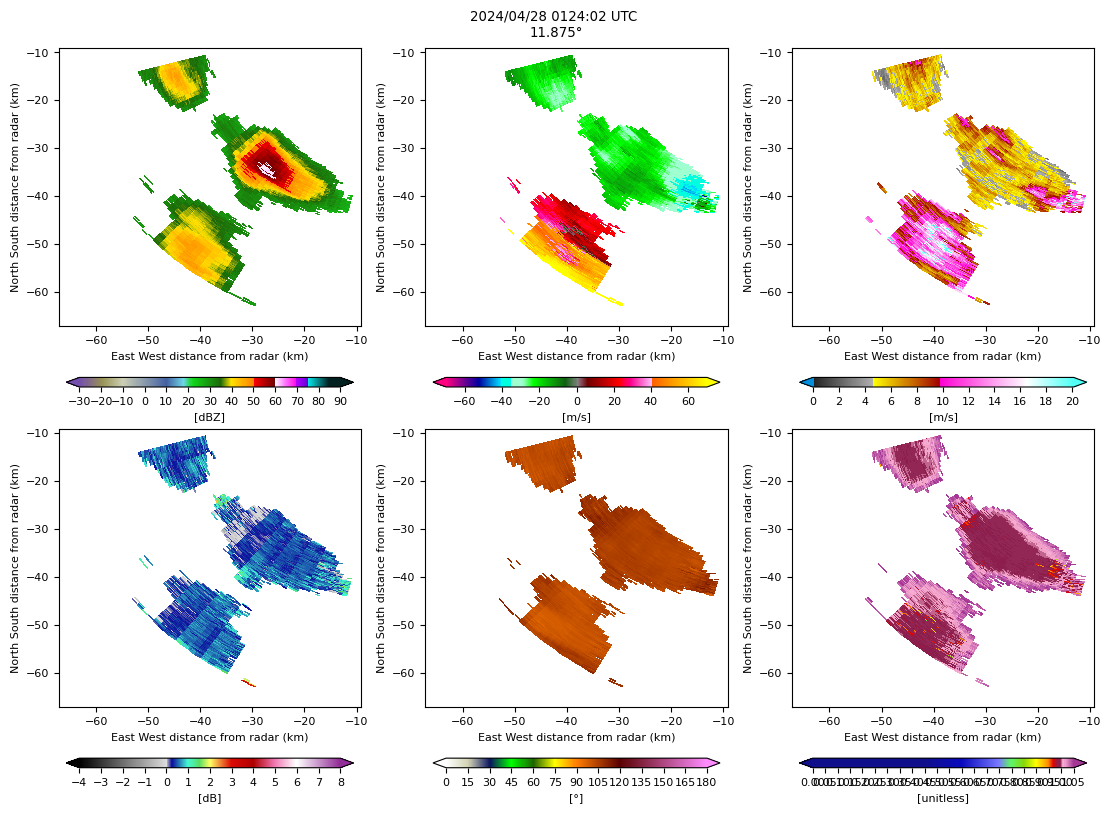

In [8]:
#quick ppi plot
sweep = 9

radar = mat_to_pyart(files[0])

radar.range['data'] = radar.range['data'] - 8740
radar.fields['specific_differential_phase']['units'] = 'deg/km'

quick_ppi(radar, matfile=True, s = sweep)


In [9]:
# Do the hydrometeor classification
HCA = radar_echo_class_3input_parallel(radar, [2.7, 3.3], n_jobs=-1)

hca_id = np.array(HCA[0]).reshape(16*48, 1822)
hca_label = np.array(HCA[1]).reshape(16*48, 1822)

Processing Radar Sweeps:   0%|          | 0/16 [00:00<?, ?it/s]

In [10]:
# Define the colormap boundaries for the HCA
TP=['NE','GC','BS','DS','WS','CR','GR','BD','RA','HR','RH']
ticks = np.arange(len(TP))
hid_colors = ['White', 'LightBlue', 'MediumBlue', 'DarkOrange', 'LightPink',
              'Cyan','DarkGray', 'Lime', 'Yellow', 'Red', 'Fuchsia']
cmaphid = mplcolors.ListedColormap(hid_colors)
boundaries = np.arange(-0.5, len(TP))
norm = mplcolors.BoundaryNorm(boundaries, 11)

# Add the HCA results
radar.add_field('HCA_id', dic={'data':hca_id}, replace_existing=True)
radar.add_field('HCA_label', dic={'data':hca_label}, replace_existing=True)

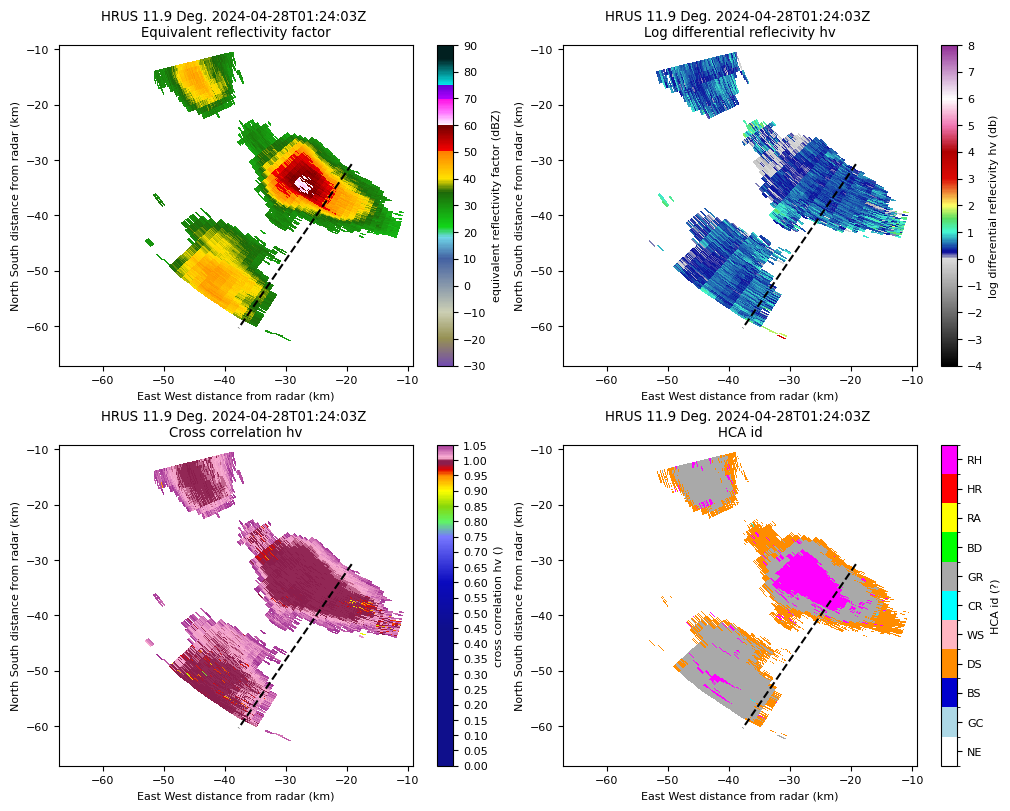

In [12]:
# Check the HCA output
fig, axs = plt.subplots(2, 2, figsize=[10, 8], constrained_layout = True)

# This is the azimuth that transects the flash initiation
theta = 212
x = radar.range['data']*np.sin(np.deg2rad(theta))/1e3
y = radar.range['data']*np.cos(np.deg2rad(theta))/1e3

for ax in axs.ravel():
    ax.plot(x,y, 'k--')
    #ax.set_xlim(-75, -25)
    #ax.set_ylim(-75, -25)

display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('reflectivity', sweep, cmap=ref_cmap, norm=ref_norm, ticks=ZH_Ticks, ax=axs.ravel()[0], colorbar_orient='vertical')
display.plot_ppi('differential_reflectivity', sweep, cmap=zdr_cmap, norm=zdr_norm, ticks=ZDR_Ticks, ax=axs.ravel()[1], colorbar_orient='vertical')
display.plot_ppi('cross_correlation_ratio', sweep, cmap=rho_cmap, norm=rho_norm, ticks=RHO_Ticks, ax=axs.ravel()[2], colorbar_orient='vertical')
display.plot_ppi('HCA_id', sweep, cmap=cmaphid, norm=norm, ticks=ticks, ticklabs=TP, ax=axs.ravel()[3], colorbar_orient='vertical')

#plt.savefig('/mnt/c/Users/goed0002/OneDrive - University of Oklahoma/Desktop/HCA.png', bbox_inches = 'tight', dpi=300)

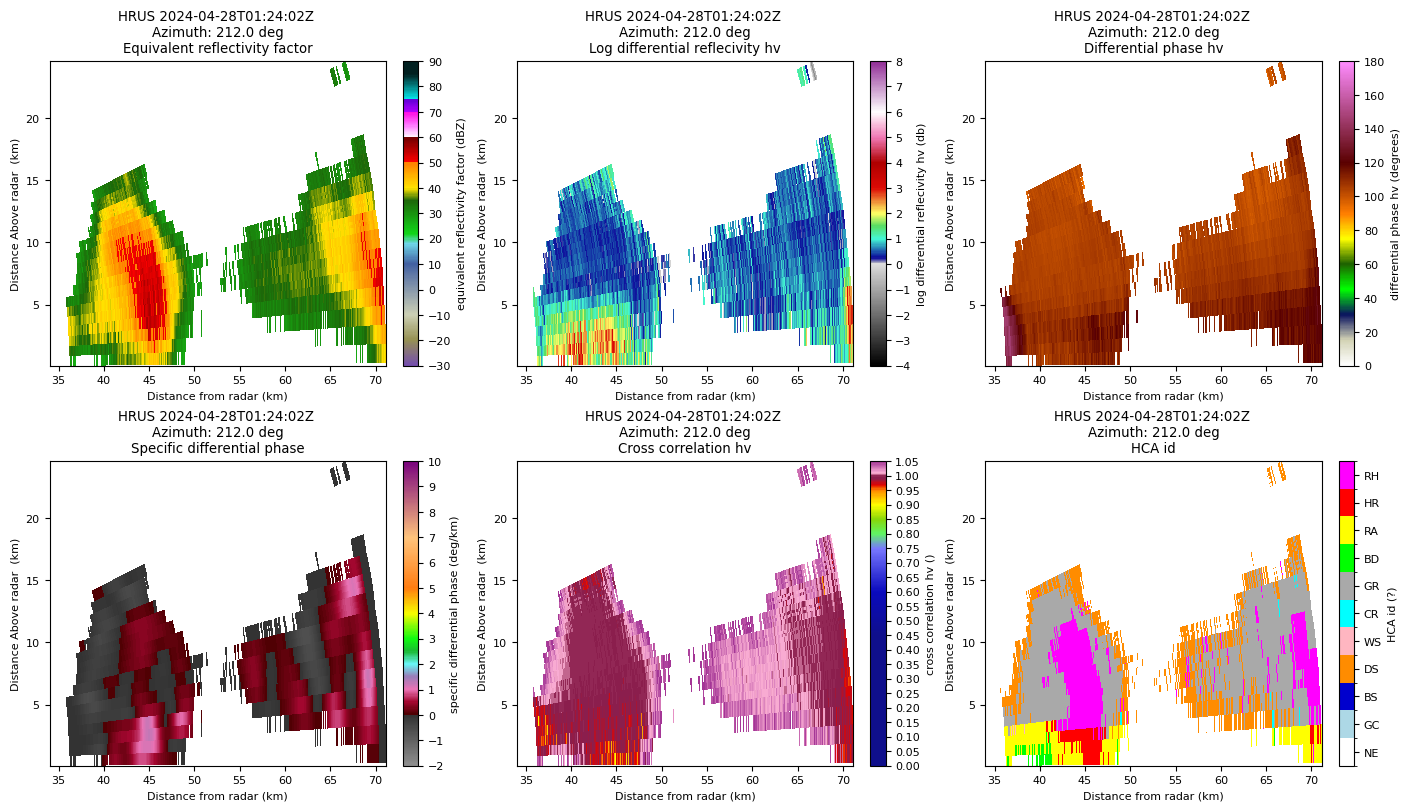

In [13]:
# Check the HCA output
fig, axs = plt.subplots(2, 3, figsize=[14, 8], constrained_layout = True)

azi = theta

display = pyart.graph.RadarDisplay(radar)
display.plot_azimuth_to_rhi('reflectivity', azi, cmap=ref_cmap, norm=ref_norm, ticks=ZH_Ticks, ax=axs.ravel()[0], colorbar_orient='vertical')
display.plot_azimuth_to_rhi('differential_reflectivity', azi, cmap=zdr_cmap, norm=zdr_norm, ticks=ZDR_Ticks, ax=axs.ravel()[1], colorbar_orient='vertical')
display.plot_azimuth_to_rhi('differential_phase', azi, cmap=phi_cmap, vmin=0, vmax=180, ax=axs.ravel()[2], colorbar_orient='vertical')
display.plot_azimuth_to_rhi('specific_differential_phase', azi, cmap=kdp_cmap, norm=kdp_norm, ticks=KDP_Ticks, ax=axs.ravel()[3], colorbar_orient='vertical')
display.plot_azimuth_to_rhi('cross_correlation_ratio', azi, cmap=rho_cmap, norm=rho_norm, ticks=RHO_Ticks, ax=axs.ravel()[4], colorbar_orient='vertical')
display.plot_azimuth_to_rhi('HCA_id', azi, cmap=cmaphid, norm=norm, ticks=ticks, ticklabs=TP, ax=axs.ravel()[5], colorbar_orient='vertical')

#plt.savefig('/mnt/c/Users/goed0002/OneDrive - University of Oklahoma/Desktop/HCARHI.png', bbox_inches = 'tight', dpi=300)

In [14]:
def breakeven(z):
    """
    Calculate the breakeven electric field

    Parameters
    ----------
    z: array-like.
        heights.

    Returns
    -------
    breakeven: obj.
        The breakeven electric field.
    """
    return 167*1.208*np.exp(-z/8.4)


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather 

In [63]:
# load all the look-up tables
with open('/home/vitorgoede/homework/radar_polarimetry/project/sim_full_plate_S2.pkl',mode='rb') as f:
    data_plate = pickle.load(f)[0]

with open('/home/vitorgoede/homework/radar_polarimetry/project/sim_full_plate2_S2.pkl',mode='rb') as f:
    data_plate2 = pickle.load(f)[0]

with open('/home/vitorgoede/homework/radar_polarimetry/project/sim_full_column1_S3.pkl',mode='rb') as f:
    data_col= pickle.load(f)[0]

with open('/home/vitorgoede/homework/radar_polarimetry/project/sim_full_column2_S3.pkl',mode='rb') as f:
    data_col2 = pickle.load(f)[0]

with open('/home/vitorgoede/work/JAMC/sim_full_snow_thinplates_S.pkl',mode='rb') as f:
    data_plate_snow = pickle.load(f)[0]

with open('/home/vitorgoede/work/JAMC/sim_full_snow_thickplates_S.pkl',mode='rb') as f:
    data_plate2_snow = pickle.load(f)[0]

with open('/home/vitorgoede/work/JAMC/sim_full_snow_shortcolumns_S.pkl',mode='rb') as f:
    data_col_snow = pickle.load(f)[0]

with open('/home/vitorgoede/work/JAMC/sim_full_snow_longcolumns_S.pkl',mode='rb') as f:
    data_col2_snow = pickle.load(f)[0]

with open('/home/vitorgoede/work/JAMC/sim_full_mix_graupel_thinplates_S.pkl',mode='rb') as f:
    data_plate_graupel = pickle.load(f)[0]

with open('/home/vitorgoede/work/JAMC/sim_full_mix_graupel_thickplates_S.pkl',mode='rb') as f:
    data_plate2_graupel = pickle.load(f)[0]

with open('/home/vitorgoede/work/JAMC/sim_full_mix_graupel_shortcolumns_S.pkl',mode='rb') as f:
    data_col_graupel = pickle.load(f)[0]

with open('/home/vitorgoede/work/JAMC/sim_full_mix_graupel_longcolumns_S.pkl',mode='rb') as f:
    data_col2_graupel = pickle.load(f)[0]

In [64]:
# Reshape and read as float16 or else it is too heavy
data_plate['zh'] = data_plate['zh'].reshape((50, 1000)).astype(np.float16)
data_plate['zdr'] = data_plate['zdr'].reshape((50, 1000)).astype(np.float16)
data_plate['kdp'] = data_plate['kdp'].reshape((50, 1000)).astype(np.float16)
data_plate['ldr'] = data_plate['ldr'].reshape((50, 1000)).astype(np.float16)

data_plate['zh'] = data_plate['zh'].reshape((50, 1000)).astype(np.float16)
data_plate['zdr'] = data_plate['zdr'].reshape((50, 1000)).astype(np.float16)
data_plate['kdp_'] = data_plate['kdp'].reshape((50, 1000)).astype(np.float16)
data_plate['ldr'] = data_plate['ldr'].reshape((50, 1000)).astype(np.float16)

data_col['zh'] = data_col['zh'].reshape((50, 1000)).astype(np.float16)
data_col['zdr'] = data_col['zdr'].reshape((50, 1000)).astype(np.float16)
data_col['kdp'] = data_col['kdp'].reshape((50, 1000)).astype(np.float16)
data_col['ldr'] = data_col['ldr'].reshape((50, 1000)).astype(np.float16)

data_col2['zh'] = data_col2['zh'].reshape((50, 1000)).astype(np.float16)
data_col2['zdr'] = data_col2['zdr'].reshape((50, 1000)).astype(np.float16)
data_col2['kdp'] = data_col2['kdp'].reshape((50, 1000)).astype(np.float16)
data_col2['ldr'] = data_col2['ldr'].reshape((50, 1000)).astype(np.float16)

data_plate_graupel['zh'] = data_plate_graupel['zh'].astype(np.float16)
data_plate_graupel['zdr'] = data_plate_graupel['zdr'].astype(np.float16)
data_plate_graupel['kdp'] = data_plate_graupel['kdp'].astype(np.float16)
data_plate_graupel['ldr'] = data_plate_graupel['ldr'].astype(np.float16)

data_plate2_graupel['zh'] = data_plate2_graupel['zh'].astype(np.float16)
data_plate2_graupel['zdr'] = data_plate2_graupel['zdr'].astype(np.float16)
data_plate2_graupel['kdp'] = data_plate2_graupel['kdp'].astype(np.float16)
data_plate2_graupel['ldr'] = data_plate2_graupel['ldr'].astype(np.float16)

data_col_graupel['zh'] = data_col_graupel['zh'].astype(np.float16)
data_col_graupel['zdr'] = data_col_graupel['zdr'].astype(np.float16)
data_col_graupel['kdp'] = data_col_graupel['kdp'].astype(np.float16)
data_col_graupel['ldr'] = data_col_graupel['ldr'].astype(np.float16)

data_col2_graupel['zh'] = data_col2_graupel['zh'].astype(np.float16)
data_col2_graupel['zdr'] = data_col2_graupel['zdr'].astype(np.float16)
data_col2_graupel['kdp'] = data_col2_graupel['kdp'].astype(np.float16)
data_col2_graupel['ldr'] = data_col2_graupel['ldr'].astype(np.float16)

data_plate_snow['zh'] = data_plate_snow['zh'].astype(np.float16)
data_plate_snow['zdr'] = data_plate_snow['zdr'].astype(np.float16)
data_plate_snow['kdp'] = data_plate_snow['kdp'].astype(np.float16)
data_plate_snow['ldr'] = data_plate_snow['ldr'].astype(np.float16)

data_plate2_snow['zh]'] = data_plate2_snow['zh'].astype(np.float16)
data_plate2_snow['zdr'] = data_plate2_snow['zdr'].astype(np.float16)
data_plate2_snow['kdp'] = data_plate2_snow['kdp'].astype(np.float16)
data_plate2_snow['ldr'] = data_plate2_snow['ldr'].astype(np.float16)

data_col_snow['zh'] = data_col_snow['zh'].astype(np.float16)
data_col_snow['zdr'] = data_col_snow['zdr'].astype(np.float16)
data_col_snow['kdp'] = data_col_snow['kdp'].astype(np.float16)
data_col_snow['ldr'] = data_col_snow['ldr'].astype(np.float16)

data_col2_snow['zh'] = data_col2_snow['zh'].astype(np.float16)
data_col2_snow['zdr'] = data_col2_snow['zdr'].astype(np.float16)
data_col2_snow['kdp_'] = data_col2_snow['kdp'].astype(np.float16)
data_col2_snow['ldr'] = data_col2_snow['ldr'].astype(np.float16)

In [65]:
# Estimate the electric fields based on the radar data
def find_E_by_multivariable_match(KDP_array, E_field_array, ZH_array, ZDR_array,
                                  KDP_target=None, ZH_target=None, ZDR_target=None,
                                  weights=(1.0, 1.0, 1.0)):
    """
    Read .mat volumes files

    Parameters
    ----------
    KDP_array: array-like.
        simulated specific differential phase.
    E_array: array-like.
        simulated electric field array used in the simulations.
    ZH_array: array-like.
        simulated horizontal reflectivity factor.
    ZDR_array: array-like.
        simulated differential reflectivity.
    KDP_target: float.
        range gate specific differential phase.
    ZH_target: float.
        range gate equivalent reflectivity factor.
    ZDR_target: float.
        range gate differential reflectivity.
    weights: tuple.
        wheights for KDP, ZH, ZDR used in the minimization.
        
    Returns
    -------
    E: float.
        The estimated electric field.
    """

    if KDP_array.ndim != 2 or ZH_array.ndim != 2 or ZDR_array.ndim != 2:
        raise ValueError("Lookup tables (KDP_array, ZH_array, ZDR_array) must be 2D arrays.")
    if KDP_array.shape[1] != len(E_field_array):
        raise ValueError(f"Column dimension of lookup tables ({KDP_array.shape[1]}) must match length of E_field_array ({len(E_field_array)}).")

    target_values = []
    data_arrays = []
    active_weights = []

    if KDP_target is not None:
        target_values.append(KDP_target)
        data_arrays.append(KDP_array.flatten())
        active_weights.append(weights[0])
    if ZH_target is not None:
        target_values.append(ZH_target)
        data_arrays.append(ZH_array.flatten())
        active_weights.append(weights[1])
    if ZDR_target is not None:
        target_values.append(ZDR_target)
        data_arrays.append(ZDR_array.flatten())
        active_weights.append(weights[2])

    if not data_arrays:
        return None

    target = np.array(target_values)
    W = np.array(active_weights)
    data = np.vstack(data_arrays).T
    valid_mask = ~np.isnan(data).any(axis=1)

    if not np.any(valid_mask):
        return None

    distances = np.linalg.norm(W * (data[valid_mask] - target), axis=1)
    min_idx_flat = np.argmin(distances)
    original_flat_index = np.where(valid_mask)[0][min_idx_flat]
    row_idx, col_idx = np.unravel_index(original_flat_index, KDP_array.shape)

    return E_field_array[col_idx]

def process_hca_label(n, h, z_val, w_sets, KDP_target, ZH_target, ZDR_target):
    result = np.nan
    if (h == 'CR') and (4769.0 < z_val[n] < 6728.0):
        result = find_E_by_multivariable_match(
            KDP_array=data_plate['kdp'], E_field_array=E,
            ZH_array=data_plate['zh'], ZDR_array=data_plate['zdr'],
            KDP_target=K_DP[n], ZH_target=Z_H[n], ZDR_target=Z_DR[n], weights=w_sets[0]
        )
    if (h == 'CR') and (6728.0 < z_val[n]):
        result = find_E_by_multivariable_match(
            KDP_array=data_col2['kdp'], E_field_array=E,
            ZH_array=data_col2['zh'], ZDR_array=data_col2['zdr'],
            KDP_target=K_DP[n], ZH_target=Z_H[n], ZDR_target=Z_DR[n], weights=w_sets[0]
        )
    elif ((h == 'DS') and (4769.0 < z_val[n] < 6728.0)):
        result = find_E_by_multivariable_match(
            KDP_array=data_plate_snow['kdp'], E_field_array=E,
            ZH_array=data_plate_snow['zh'], ZDR_array=data_plate_snow['zdr'],
            KDP_target=K_DP[n], ZH_target=Z_H[n], ZDR_target=Z_DR[n], weights=w_sets[1]
        )
    elif ((h == 'DS') and (6728.0 < z_val[n])):
        result = find_E_by_multivariable_match(
            KDP_array=data_col2_snow['kdp'], E_field_array=E,
            ZH_array=data_col2_snow['zh'], ZDR_array=data_col2_snow['zdr'],
            KDP_target=K_DP[n], ZH_target=Z_H[n], ZDR_target=Z_DR[n], weights=w_sets[1]
        )
    elif ((h == 'GR') and (4769.0 < z_val[n] < 6728.0)):
        result = find_E_by_multivariable_match(
            KDP_array=data_plate_graupel['kdp'], E_field_array=E,
            ZH_array=data_plate_graupel['zh'], ZDR_array=data_plate_graupel['zdr'],
            KDP_target=K_DP[n], ZH_target=Z_H[n], ZDR_target=Z_DR[n], weights=w_sets[2]
        )
    elif ((h == 'GR') and (6728.0 < z_val[n])):
        result = find_E_by_multivariable_match(
            KDP_array=data_col2_graupel['kdp'], E_field_array=E,
            ZH_array=data_col2_graupel['zh'], ZDR_array=data_col2_graupel['zdr'],
            KDP_target=K_DP[n], ZH_target=Z_H[n], ZDR_target=Z_DR[n], weights=w_sets[2]
        )
    return result


In [17]:
# test the effect of the weights in the retrievals
Z_H = np.random.uniform(-12, 20, 100)
Z_DR = np.random.uniform(-4.2, 2, 100)
K_DP = np.random.uniform(-0.8, 0.2, 100)
HCA_labels = np.resize(['CR'], 100)
z = np.random.uniform(5000, 9000, 100)

weight_sets = [
    (1, 1, 1),
    (0.75, 1, 1),
    (0.5, 1, 1),
    (0.25, 1, 1),
    (1, 0.75, 1),
    (1, 0.5, 1),
    (1, 0.25, 1),
    (1, 1, 0.75),
    (1, 1, 0.5),
    (1, 1, 0.25)
]

crystal_results = []
for i, w_set in enumerate(weight_sets):
    with parallel_backend('loky'):
        result = Parallel(n_jobs=-1)(
            delayed(process_hca_label)(n, h, z, [w_set, w_set, w_set], K_DP, Z_H, Z_DR)
            for n, h in enumerate(tqdm(HCA_labels, desc=f"Processing E slice with weights {w_set}"))
        )
        crystal_results.append(result)

print(f"\nNumber of crystal results sets: {len(crystal_results)}")
print(f"Length of first crystal result set: {len(crystal_results[0])}")
print(f"Example E-field value from first result set (first processed item): {crystal_results[0][0]}")

Processing E slice with weights (1, 1, 1):   0%|          | 0/100 [00:00<?, ?it/s]

Processing E slice with weights (0.75, 1, 1):   0%|          | 0/100 [00:00<?, ?it/s]

Processing E slice with weights (0.5, 1, 1):   0%|          | 0/100 [00:00<?, ?it/s]

Processing E slice with weights (0.25, 1, 1):   0%|          | 0/100 [00:00<?, ?it/s]

Processing E slice with weights (1, 0.75, 1):   0%|          | 0/100 [00:00<?, ?it/s]

Processing E slice with weights (1, 0.5, 1):   0%|          | 0/100 [00:00<?, ?it/s]

Processing E slice with weights (1, 0.25, 1):   0%|          | 0/100 [00:00<?, ?it/s]

Processing E slice with weights (1, 1, 0.75):   0%|          | 0/100 [00:00<?, ?it/s]

Processing E slice with weights (1, 1, 0.5):   0%|          | 0/100 [00:00<?, ?it/s]

Processing E slice with weights (1, 1, 0.25):   0%|          | 0/100 [00:00<?, ?it/s]


Number of crystal results sets: 10
Length of first crystal result set: 100
Example E-field value from first result set (first processed item): 100.10010010010011


In [18]:
Z_H = np.random.uniform(0, 40, 100)
Z_DR = np.random.uniform(-1, 0.5, 100)
K_DP = np.random.uniform(-1, 1, 100)
HCA_labels = np.resize(['DS'], 100)
z = np.random.uniform(5000, 9000, 100)

snow_results = []
for i, w_set in enumerate(weight_sets):
    with parallel_backend('loky'):
        # Pass the entire list of weight sets and index into it within the function
        result = Parallel(n_jobs=-1)(
            delayed(process_hca_label)(n, h, z, [w_set, w_set, w_set], K_DP, Z_DR, Z_H) # Passing w_set three times, assuming each HCA type uses the same w_set
            for n, h in enumerate(tqdm(HCA_labels, desc=f"Processing E slice with weights {w_set}"))
        )
        snow_results.append(result)

print(f"\nNumber of snow results sets: {len(snow_results)}")
print(f"Length of first snow result set: {len(snow_results[0])}")
print(f"Example E-field value from first result set (first processed item): {snow_results[0][0]}")

Processing E slice with weights (1, 1, 1):   0%|          | 0/100 [00:00<?, ?it/s]

Processing E slice with weights (0.75, 1, 1):   0%|          | 0/100 [00:00<?, ?it/s]

Processing E slice with weights (0.5, 1, 1):   0%|          | 0/100 [00:00<?, ?it/s]

Processing E slice with weights (0.25, 1, 1):   0%|          | 0/100 [00:00<?, ?it/s]

Processing E slice with weights (1, 0.75, 1):   0%|          | 0/100 [00:00<?, ?it/s]

Processing E slice with weights (1, 0.5, 1):   0%|          | 0/100 [00:00<?, ?it/s]

Processing E slice with weights (1, 0.25, 1):   0%|          | 0/100 [00:00<?, ?it/s]

Processing E slice with weights (1, 1, 0.75):   0%|          | 0/100 [00:00<?, ?it/s]

Processing E slice with weights (1, 1, 0.5):   0%|          | 0/100 [00:00<?, ?it/s]

Processing E slice with weights (1, 1, 0.25):   0%|          | 0/100 [00:00<?, ?it/s]


Number of snow results sets: 10
Length of first snow result set: 100
Example E-field value from first result set (first processed item): 2302.3023023023025


In [19]:
Z_H = np.random.uniform(0, 50, 100)
Z_DR = np.random.uniform(-1, 0.5, 100)
K_DP = np.random.uniform(-1, 1, 100)
HCA_labels = np.resize(['GR'], 100)
z = np.random.uniform(5000, 9000, 100)

# Parallel processing calls (unchanged)
weight_sets = [
    (1, 1, 1),
    (0.75, 1, 1),
    (0.5, 1, 1),
    (0.25, 1, 1),
    (1, 0.75, 1),
    (1, 0.5, 1),
    (1, 0.25, 1),
    (1, 1, 0.75),
    (1, 1, 0.5),
    (1, 1, 0.25)
]


graupel_results = []
for i, w_set in enumerate(weight_sets):
    with parallel_backend('loky'):
        # Pass the entire list of weight sets and index into it within the function
        result = Parallel(n_jobs=8)(
            delayed(process_hca_label)(n, h, z, [w_set, w_set, w_set], K_DP, Z_H, Z_DR) # Passing w_set three times, assuming each HCA type uses the same w_set
            for n, h in enumerate(tqdm(HCA_labels, desc=f"Processing E slice with weights {w_set}"))
        )
        graupel_results.append(result)

print(f"\nNumber of snow results sets: {len(graupel_results)}")
print(f"Length of first snow result set: {len(graupel_results[0])}")
print(f"Example E-field value from first result set (first processed item): {graupel_results[0][0]}")

Processing E slice with weights (1, 1, 1):   0%|          | 0/100 [00:00<?, ?it/s]


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather 

Processing E slice with weights (0.75, 1, 1):   0%|          | 0/100 [00:00<?, ?it/s]

Processing E slice with weights (0.5, 1, 1):   0%|          | 0/100 [00:00<?, ?it/s]

Processing E slice with weights (0.25, 1, 1):   0%|          | 0/100 [00:00<?, ?it/s]

Processing E slice with weights (1, 0.75, 1):   0%|          | 0/100 [00:00<?, ?it/s]

Processing E slice with weights (1, 0.5, 1):   0%|          | 0/100 [00:00<?, ?it/s]

Processing E slice with weights (1, 0.25, 1):   0%|          | 0/100 [00:00<?, ?it/s]

Processing E slice with weights (1, 1, 0.75):   0%|          | 0/100 [00:00<?, ?it/s]

Processing E slice with weights (1, 1, 0.5):   0%|          | 0/100 [00:00<?, ?it/s]

Processing E slice with weights (1, 1, 0.25):   0%|          | 0/100 [00:00<?, ?it/s]


Number of snow results sets: 10
Length of first snow result set: 100
Example E-field value from first result set (first processed item): 100.10010010010011


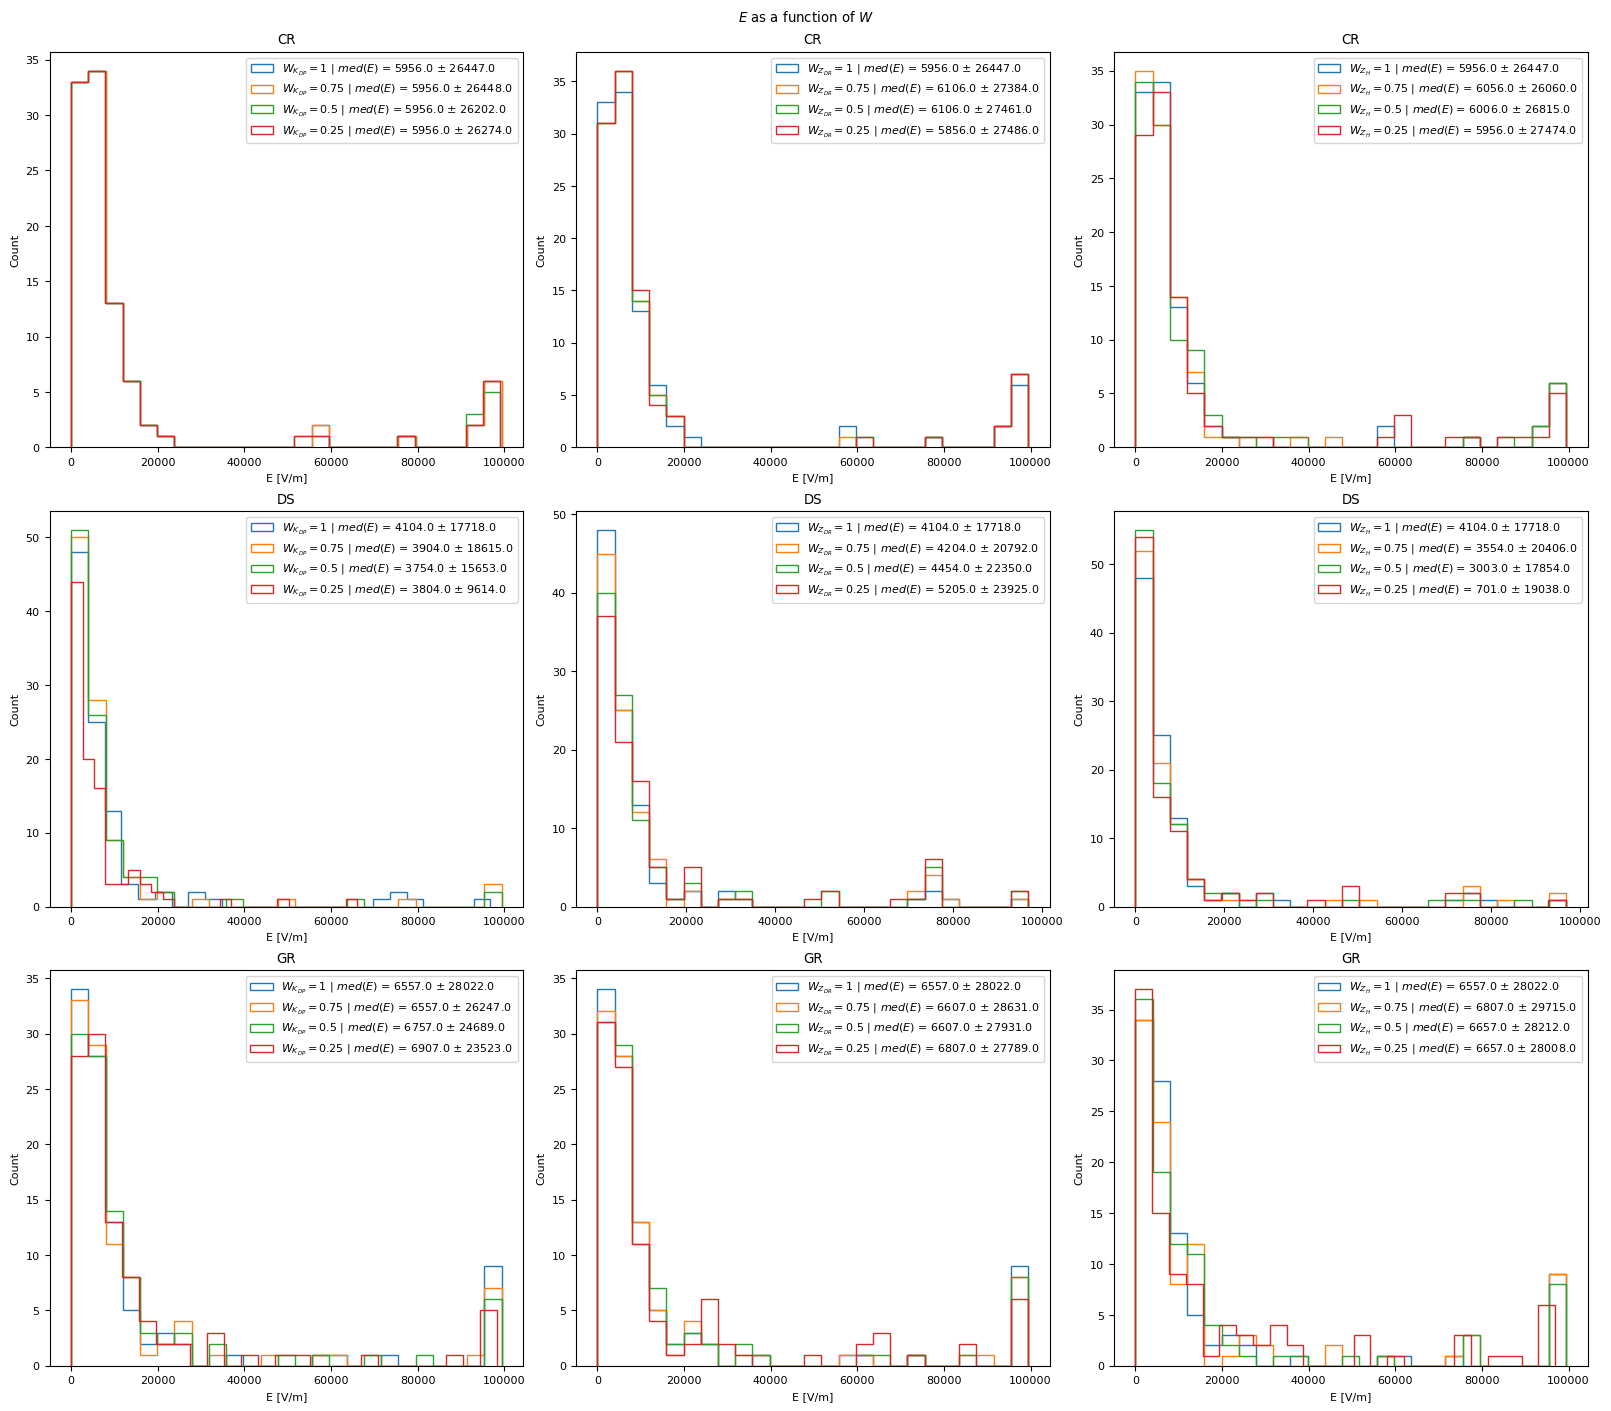

In [20]:
#plot the test results
fig, axs = plt.subplots(3,3,figsize=[16,14], constrained_layout=True)

axs.ravel()[0].hist(crystal_results[0], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{K_{DP}}=1$' + r' | $med(E)$' + f' = {np.round(np.median(crystal_results[0]))}' + r' $\pm$' + f' {np.round(np.std(crystal_results[0]))}')
axs.ravel()[0].hist(crystal_results[1], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{K_{DP}}=0.75$' + r' | $med(E)$' + f' = {np.round(np.median(crystal_results[1]))}' + r' $\pm$' + f' {np.round(np.std(crystal_results[1]))}')
axs.ravel()[0].hist(crystal_results[2], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{K_{DP}}=0.5$' + r' | $med(E)$' + f' = {np.round(np.median(crystal_results[2]))}' + r' $\pm$' + f' {np.round(np.std(crystal_results[2]))}')
axs.ravel()[0].hist(crystal_results[3], bins = 25, histtype='step', stacked=True, fill=False,\
                    label = r'$W_{K_{DP}}=0.25$' + r' | $med(E)$' + f' = {np.round(np.median(crystal_results[3]))}' + r' $\pm$' + f' {np.round(np.std(crystal_results[3]))}')
axs.ravel()[0].set_xlabel('E [V/m]')
axs.ravel()[0].set_ylabel('Count')
axs.ravel()[0].legend()
axs.ravel()[0].set_title(r'CR')

axs.ravel()[1].hist(crystal_results[0], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{Z_{DR}}=1$' + r' | $med(E)$' + f' = {np.round(np.median(crystal_results[0]))}' + r' $\pm$' + f' {np.round(np.std(crystal_results[0]))}')
axs.ravel()[1].hist(crystal_results[4], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{Z_{DR}}=0.75$' + r' | $med(E)$' + f' = {np.round(np.median(crystal_results[4]))}' + r' $\pm$' + f' {np.round(np.std(crystal_results[4]))}')
axs.ravel()[1].hist(crystal_results[5], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{Z_{DR}}=0.5$' + r' | $med(E)$' + f' = {np.round(np.median(crystal_results[5]))}' + r' $\pm$' + f' {np.round(np.std(crystal_results[5]))}')
axs.ravel()[1].hist(crystal_results[6], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{Z_{DR}}=0.25$' + r' | $med(E)$' + f' = {np.round(np.median(crystal_results[6]))}' + r' $\pm$' + f' {np.round(np.std(crystal_results[6]))}')
axs.ravel()[1].set_xlabel('E [V/m]')
axs.ravel()[1].set_ylabel('Count')
axs.ravel()[1].legend()
axs.ravel()[1].set_title(r'CR')

axs.ravel()[2].hist(crystal_results[0], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{Z_{H}}=1$' + r' | $med(E)$' + f' = {np.round(np.median(crystal_results[0]))}' + r' $\pm$' + f' {np.round(np.std(crystal_results[0]))}')
axs.ravel()[2].hist(crystal_results[7], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{Z_{H}}=0.75$' + r' | $med(E)$' + f' = {np.round(np.median(crystal_results[7]))}' + r' $\pm$' + f' {np.round(np.std(crystal_results[7]))}')
axs.ravel()[2].hist(crystal_results[8], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{Z_{H}}=0.5$' + r' | $med(E)$' + f' = {np.round(np.median(crystal_results[8]))}' + r' $\pm$' + f' {np.round(np.std(crystal_results[8]))}')
axs.ravel()[2].hist(crystal_results[9], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{Z_{H}}=0.25$' + r' | $med(E)$' + f' = {np.round(np.median(crystal_results[9]))}' + r' $\pm$' + f' {np.round(np.std(crystal_results[9]))}')
axs.ravel()[2].set_xlabel('E [V/m]')
axs.ravel()[2].set_ylabel('Count')
axs.ravel()[2].legend()
axs.ravel()[2].set_title(r'CR')

axs.ravel()[3].hist(snow_results[0], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{K_{DP}}=1$' + r' | $med(E)$' + f' = {np.round(np.median(snow_results[0]))}' + r' $\pm$' + f' {np.round(np.std(snow_results[0]))}')
axs.ravel()[3].hist(snow_results[1], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{K_{DP}}=0.75$' + r' | $med(E)$' + f' = {np.round(np.median(snow_results[1]))}' + r' $\pm$' + f' {np.round(np.std(snow_results[1]))}')
axs.ravel()[3].hist(snow_results[2], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{K_{DP}}=0.5$' + r' | $med(E)$' + f' = {np.round(np.median(snow_results[2]))}' + r' $\pm$' + f' {np.round(np.std(snow_results[2]))}')
axs.ravel()[3].hist(snow_results[3], bins = 25, histtype='step', stacked=True, fill=False,\
                    label = r'$W_{K_{DP}}=0.25$' + r' | $med(E)$' + f' = {np.round(np.median(snow_results[3]))}' + r' $\pm$' + f' {np.round(np.std(snow_results[3]))}')
axs.ravel()[3].set_xlabel('E [V/m]')
axs.ravel()[3].set_ylabel('Count')
axs.ravel()[3].legend()
axs.ravel()[3].set_title(r'DS')

axs.ravel()[4].hist(snow_results[0], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{Z_{DR}}=1$' + r' | $med(E)$' + f' = {np.round(np.median(snow_results[0]))}' + r' $\pm$' + f' {np.round(np.std(snow_results[0]))}')
axs.ravel()[4].hist(snow_results[4], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{Z_{DR}}=0.75$' + r' | $med(E)$' + f' = {np.round(np.median(snow_results[4]))}' + r' $\pm$' + f' {np.round(np.std(snow_results[4]))}')
axs.ravel()[4].hist(snow_results[5], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{Z_{DR}}=0.5$' + r' | $med(E)$' + f' = {np.round(np.median(snow_results[5]))}' + r' $\pm$' + f' {np.round(np.std(snow_results[5]))}')
axs.ravel()[4].hist(snow_results[6], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{Z_{DR}}=0.25$' + r' | $med(E)$' + f' = {np.round(np.median(snow_results[6]))}' + r' $\pm$' + f' {np.round(np.std(snow_results[6]))}')
axs.ravel()[4].set_xlabel('E [V/m]')
axs.ravel()[4].set_ylabel('Count')
axs.ravel()[4].legend()
axs.ravel()[4].set_title(r'DS')

axs.ravel()[5].hist(snow_results[0], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{Z_{H}}=1$' + r' | $med(E)$' + f' = {np.round(np.median(snow_results[0]))}' + r' $\pm$' + f' {np.round(np.std(snow_results[0]))}')
axs.ravel()[5].hist(snow_results[7], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{Z_{H}}=0.75$' + r' | $med(E)$' + f' = {np.round(np.median(snow_results[7]))}' + r' $\pm$' + f' {np.round(np.std(snow_results[7]))}')
axs.ravel()[5].hist(snow_results[8], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{Z_{H}}=0.5$' + r' | $med(E)$' + f' = {np.round(np.median(snow_results[8]))}' + r' $\pm$' + f' {np.round(np.std(snow_results[8]))}')
axs.ravel()[5].hist(snow_results[9], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{Z_{H}}=0.25$' + r' | $med(E)$' + f' = {np.round(np.median(snow_results[9]))}' + r' $\pm$' + f' {np.round(np.std(snow_results[9]))}')
axs.ravel()[5].set_xlabel('E [V/m]')
axs.ravel()[5].set_ylabel('Count')
axs.ravel()[5].legend()
axs.ravel()[5].set_title(r'DS')

axs.ravel()[6].hist(graupel_results[0], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{K_{DP}}=1$' + r' | $med(E)$' + f' = {np.round(np.median(graupel_results[0]))}' + r' $\pm$' + f' {np.round(np.std(graupel_results[0]))}')
axs.ravel()[6].hist(graupel_results[1], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{K_{DP}}=0.75$' + r' | $med(E)$' + f' = {np.round(np.median(graupel_results[1]))}' + r' $\pm$' + f' {np.round(np.std(graupel_results[1]))}')
axs.ravel()[6].hist(graupel_results[2], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{K_{DP}}=0.5$' + r' | $med(E)$' + f' = {np.round(np.median(graupel_results[2]))}' + r' $\pm$' + f' {np.round(np.std(graupel_results[2]))}')
axs.ravel()[6].hist(graupel_results[3], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{K_{DP}}=0.25$' + r' | $med(E)$' + f' = {np.round(np.median(graupel_results[3]))}' + r' $\pm$' + f' {np.round(np.std(graupel_results[3]))}')
axs.ravel()[6].set_xlabel('E [V/m]')
axs.ravel()[6].set_ylabel('Count')
axs.ravel()[6].legend()
axs.ravel()[6].set_title(r'GR')

axs.ravel()[7].hist(graupel_results[0], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{Z_{DR}}=1$' + r' | $med(E)$' + f' = {np.round(np.median(graupel_results[0]))}' + r' $\pm$' + f' {np.round(np.std(graupel_results[0]))}')
axs.ravel()[7].hist(graupel_results[4], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{Z_{DR}}=0.75$' + r' | $med(E)$' + f' = {np.round(np.median(graupel_results[4]))}' + r' $\pm$' + f' {np.round(np.std(graupel_results[4]))}')
axs.ravel()[7].hist(graupel_results[5], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{Z_{DR}}=0.5$' + r' | $med(E)$' + f' = {np.round(np.median(graupel_results[5]))}' + r' $\pm$' + f' {np.round(np.std(graupel_results[5]))}')
axs.ravel()[7].hist(graupel_results[6], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{Z_{DR}}=0.25$' + r' | $med(E)$' + f' = {np.round(np.median(graupel_results[6]))}' + r' $\pm$' + f' {np.round(np.std(graupel_results[6]))}')
axs.ravel()[7].set_xlabel('E [V/m]')
axs.ravel()[7].set_ylabel('Count')
axs.ravel()[7].legend()
axs.ravel()[7].set_title(r'GR')

axs.ravel()[8].hist(graupel_results[0], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{Z_{H}}=1$' + r' | $med(E)$' + f' = {np.round(np.median(graupel_results[0]))}' + r' $\pm$' + f' {np.round(np.std(graupel_results[0]))}')
axs.ravel()[8].hist(graupel_results[7], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{Z_{H}}=0.75$' + r' | $med(E)$' + f' = {np.round(np.median(graupel_results[7]))}' + r' $\pm$' + f' {np.round(np.std(graupel_results[7]))}')
axs.ravel()[8].hist(graupel_results[8], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{Z_{H}}=0.5$' + r' | $med(E)$' + f' = {np.round(np.median(graupel_results[8]))}' + r' $\pm$' + f' {np.round(np.std(graupel_results[8]))}')
axs.ravel()[8].hist(graupel_results[9], bins = 25, histtype='step', stacked=True, fill=False,
                    label = r'$W_{Z_{H}}=0.25$' + r' | $med(E)$' + f' = {np.round(np.median(graupel_results[9]))}' + r' $\pm$' + f' {np.round(np.std(graupel_results[9]))}')
axs.ravel()[8].set_xlabel('E [V/m]')
axs.ravel()[8].set_ylabel('Count')
axs.ravel()[8].legend()
axs.ravel()[8].set_title(r'GR')

fig.suptitle('$E$ as a function of $W$')

plt.savefig('tests.png', dpi = 300, bbox_inches = 'tight')

In [66]:
#retrieve the E field for the sweep closest to the flash initiation.
x,y,z=radar.get_gate_x_y_z(sweep)
z=z.flatten()

Z_H = radar.get_field(sweep, 'reflectivity').flatten()
Z_DR = radar.get_field(sweep, 'differential_reflectivity').flatten()
K_DP = radar.get_field(sweep, 'specific_differential_phase').flatten()
HCA_labels = radar.get_field(sweep, 'HCA_label').flatten()

weight_sets = [
    (1, 1, 0.25),
    (1, 0.5, 0.25),
    (1, 0.25, 0)
]


graupel_results = []
with parallel_backend('loky'):
    result = Parallel(n_jobs=7)(
        delayed(process_hca_label)(n, h, z, weight_sets, K_DP, Z_H, Z_DR)
        for n, h in enumerate(tqdm(HCA_labels))
    )
    graupel_results.append(result)

  0%|          | 0/87456 [00:00<?, ?it/s]


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather 

Text(0.5, 0.98, 'Horus 11.875$^{\\circ}$')

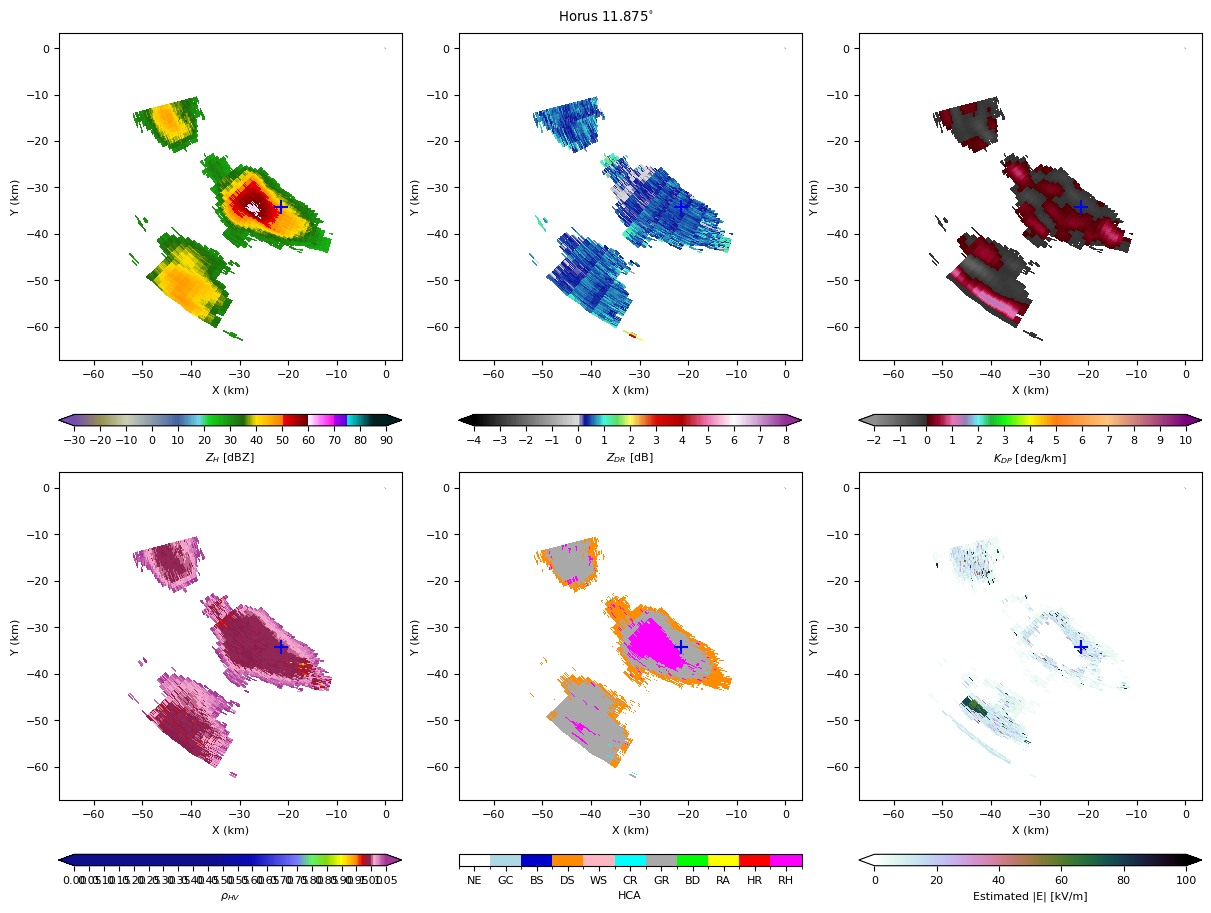

In [67]:
# Plot the results
x1,y1,z1=radar.get_gate_x_y_z(sweep,)
x1/=1000
y1/=1000
z1/=1000

xf = -21.4
yf = -34.2

E_f = np.asarray(graupel_results).reshape(radar.get_field(sweep, 'reflectivity').shape)

fig, axs = plt.subplots(2,3,figsize=[12,9],constrained_layout=True)

a = axs.ravel()[0].pcolormesh(x1,y1,radar.get_field(sweep, 'reflectivity'), cmap=ref_cmap, norm=ref_norm)
cbar = plt.colorbar(a, ticks=ZH_Ticks, orientation='horizontal', label = r'$Z_H$ [dBZ]', extend='both', aspect = 30)
cbar.minorticks_off()

a = axs.ravel()[1].pcolormesh(x1,y1,radar.get_field(sweep, 'differential_reflectivity'), cmap=zdr_cmap, norm=zdr_norm)
cbar = plt.colorbar(a, ticks=ZDR_Ticks, orientation='horizontal', label = r'$Z_{DR}$ [dB]', extend='both', aspect = 30)
cbar.minorticks_off()

a = axs.ravel()[2].pcolormesh(x1,y1,radar.get_field(sweep, 'specific_differential_phase'), cmap=kdp_cmap, norm=kdp_norm)
cbar = plt.colorbar(a, ticks=KDP_Ticks, orientation='horizontal', label = r'$K_{DP}$ [deg/km]', extend='both', aspect = 30)
cbar.minorticks_off() 

a = axs.ravel()[3].pcolormesh(x1,y1,radar.get_field(sweep, 'cross_correlation_ratio'), cmap=rho_cmap, norm=rho_norm)
cbar = plt.colorbar(a, ticks=RHO_Ticks, orientation='horizontal', label = r'$\rho_{HV}$', extend='both', aspect = 30)
cbar.minorticks_off()

a = axs.ravel()[4].pcolormesh(x1,y1,radar.get_field(sweep, 'HCA_id'),cmap=cmaphid, norm=norm)
cbar = plt.colorbar(a, ticks=ticks.tolist(), orientation='horizontal', label = r'HCA', aspect = 30)
cbar.ax.set_xticklabels(TP) 

a = axs.ravel()[5].pcolormesh(x1,y1,E_f/1e3,vmin=0, vmax=100, cmap='cubehelix_r')
cbar = fig.colorbar(a, orientation='horizontal', label = r'Estimated |E| [kV/m]', extend='both', aspect = 30)
cbar.minorticks_off() 

x = np.linspace(10,70,100)*np.sin(np.deg2rad(theta))/1e3
y = np.linspace(10,70,100)*np.cos(np.deg2rad(theta))/1e3
for ax in axs.ravel():
    #ax.set_xlim(-50, -10)
    #ax.set_ylim(-50, -10)
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.plot(x,y, 'k--')
    ax.scatter(xf,yf, 100, c='blue', marker='+')

fig.suptitle(f'Horus {radar.get_elevation(sweep)[0]}'+'$^{\circ}$')
#plt.savefig('E_ppi.png', bbox_inches='tight', dpi=300)

In [68]:
# repeat, but now for the cross section
radar1 = pyart.util.cross_section_ppi(radar, [theta])

x2,y2,z2=radar1.get_gate_x_y_z(0)
z2 = z2.flatten()

Z_H = radar1.get_field(0, 'reflectivity').flatten().astype(np.float16)
Z_DR = radar1.get_field(0, 'differential_reflectivity').flatten().astype(np.float16)
K_DP = radar1.get_field(0, 'specific_differential_phase').flatten().astype(np.float16)
HCA_labels = radar1.get_field(0, 'HCA_label').flatten()

weight_sets = [
    (1, 1, 0.25),
    (1, 0.5, 0.25),
    (1, 0.25, 0)
]


graupel_results = []
with parallel_backend('loky'):
    result = Parallel(n_jobs=8)(
        delayed(process_hca_label)(n, h, z2, weight_sets, K_DP, Z_H, Z_DR)
        for n, h in enumerate(tqdm(HCA_labels))
    )
    graupel_results.append(result)

  0%|          | 0/29152 [00:00<?, ?it/s]

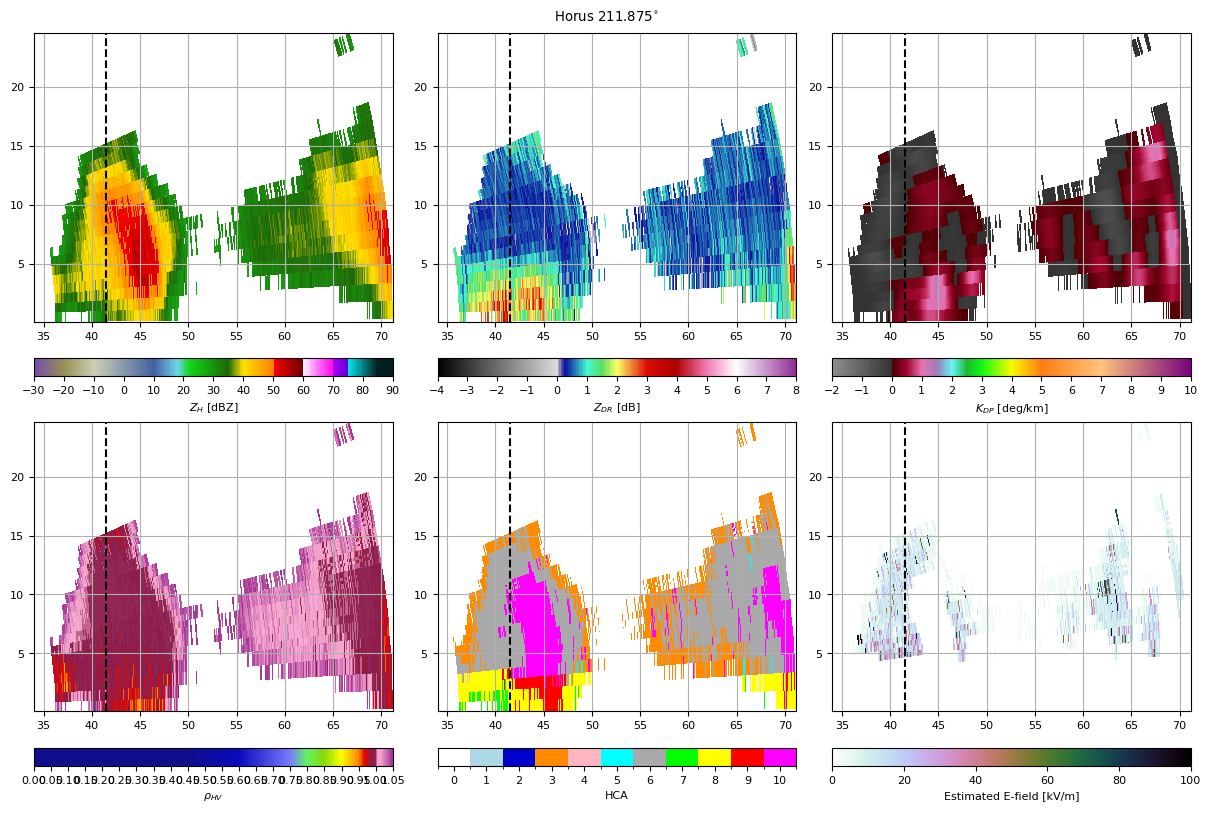

In [70]:
r2 = np.sqrt(x2**2+y2**2)/1e3
z2 = z2.reshape(r2.shape)/1e3
dist= 41.5


E_f2 = np.asarray(graupel_results).reshape(radar1.fields['reflectivity']['data'].shape)

fig, axs = plt.subplots(2,3,figsize=[12,8],constrained_layout=True)

a = axs.ravel()[0].pcolormesh(r2,z2,radar1.fields['reflectivity']['data'], cmap=ref_cmap, norm=ref_norm)
cbar = plt.colorbar(a, ticks=ZH_Ticks, orientation='horizontal', label = r'$Z_H$ [dBZ]')

a = axs.ravel()[1].pcolormesh(r2,z2,radar1.get_field(0, 'differential_reflectivity'), cmap=zdr_cmap, norm=zdr_norm)
cbar = plt.colorbar(a, ticks=ZDR_Ticks, orientation='horizontal', label = r'$Z_{DR}$ [dB]') 

a = axs.ravel()[2].pcolormesh(r2,z2,radar1.get_field(0, 'specific_differential_phase'), cmap=kdp_cmap, norm=kdp_norm)
cbar = plt.colorbar(a, ticks=KDP_Ticks, orientation='horizontal', label = r'$K_{DP}$ [deg/km]')

a = axs.ravel()[3].pcolormesh(r2,z2,radar1.get_field(0, 'cross_correlation_ratio'), cmap=rho_cmap, norm=rho_norm)
cbar = plt.colorbar(a, ticks=RHO_Ticks, orientation='horizontal', label = r'$\rho_{HV}$')

a = axs.ravel()[4].pcolormesh(r2,z2,radar1.get_field(0, 'HCA_id'),cmap=cmaphid, norm=norm)
cbar = plt.colorbar(a, ticks=ticks.tolist(), orientation='horizontal', label = r'HCA')

a = axs.ravel()[5].pcolormesh(r2,z2,E_f2/1e3,vmin=0, vmax=100, cmap='cubehelix_r')
fig.colorbar(a, orientation='horizontal', label = r'Estimated E-field [kV/m]')

for ax in axs.ravel():
    ax.axvline(41.5, c='k', linestyle='--')
    ax.grid()

fig.suptitle(f'Horus {radar1.get_azimuth(0)[0]}'+'$^{\circ}$')
plt.savefig('E_rhi.png', bbox_inches='tight', dpi=300)

LMA data already in memory


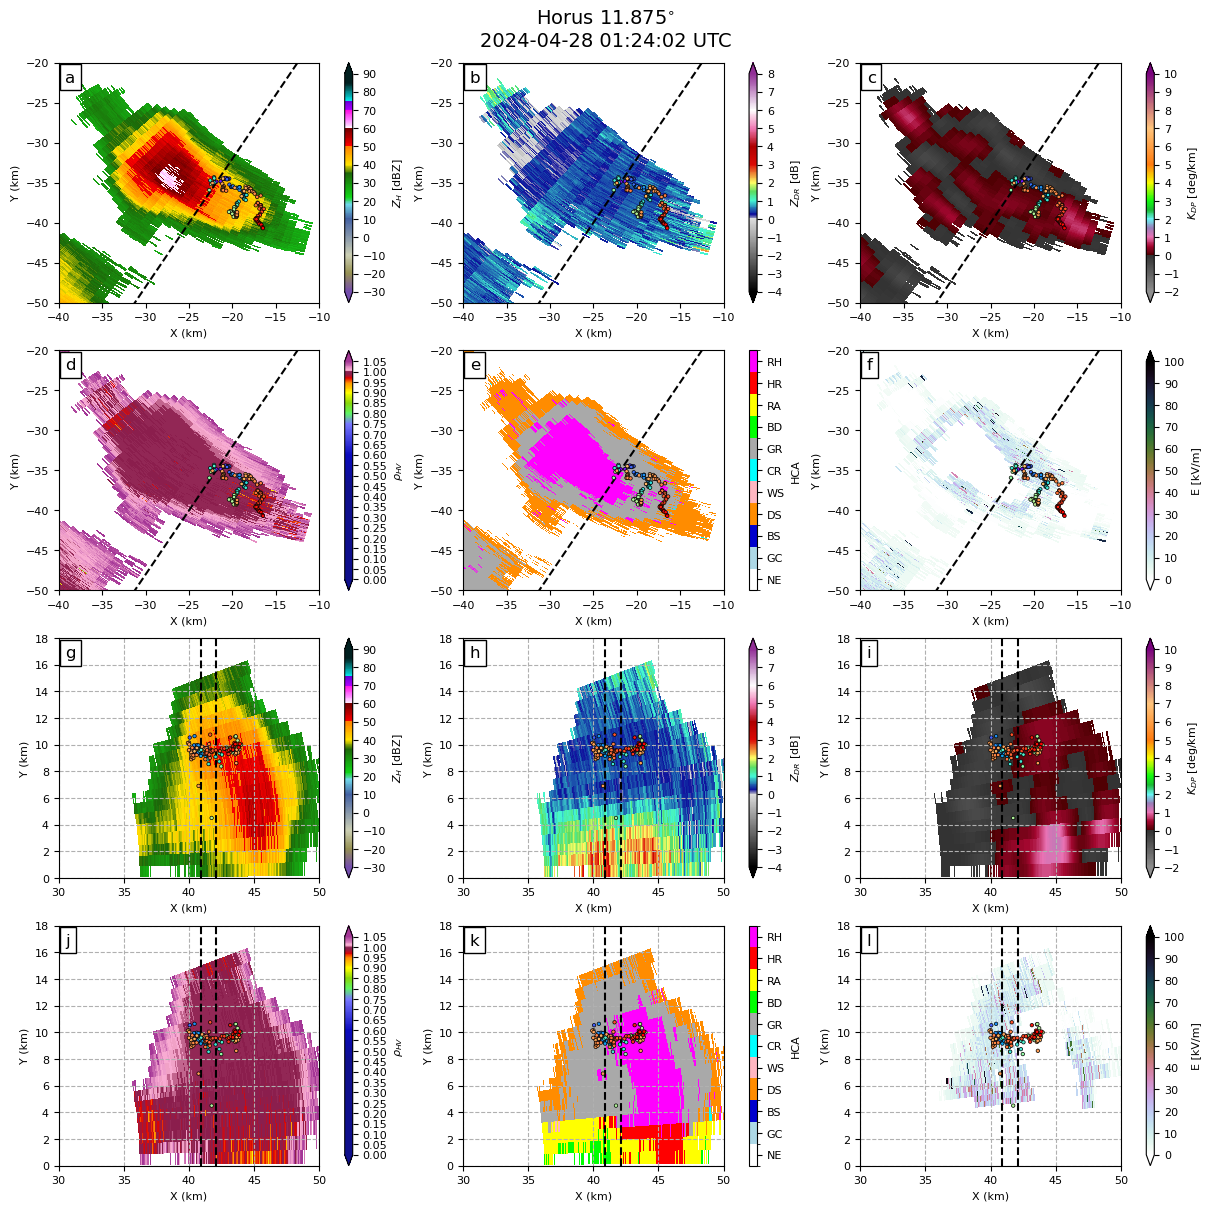

In [71]:
# Make the figure with the LMA sources
import string
from pyxlma.lmalib.io import read as lma_read
from pyxlma.plot.xlma import XlmaPlot
from pyxlma.lmalib.flash.cluster import cluster_flashes
from pyxlma.lmalib.flash.properties import flash_stats
from pyxlma.lmalib.grid import  create_regular_grid, assign_regular_bins, events_to_grid

min_stations = 6 # more stations = more confident it's a good solution
max_chi = 5 # lower reduced chi^2 = more confident it's a good solution
tbuffer = 60 # How many seconds around the radar scan time do you want to plot LMA data?
max_dist = 25e3 # meters, max distance of an LMA source to a radar grid centroid to be plotted
transparent = 'True' # True to increase transparency of sources farther from the grid centroid 
method = 'kdtree'

rx,ry,rz = radar.get_gate_x_y_z(9)

radar_time1 = pyart.util.datetime_from_radar(radar)
radar_time1 = datetime.strptime(str(radar_time1),'%Y-%m-%d %H:%M:%S')
tmin = 0.4 
tmax = .9

# Set your directory with the LMA files
LMA_dir = '/home/vitorgoede/work/LMA/20240427_OKLMA/'
if 'event_time' in locals():
    if ((radar_time1-timedelta(minutes=0))>event_time.min())&(
        (radar_time1+timedelta(minutes=1))<event_time.max()):
        print ('LMA data already in memory')
        pass
    else:
        print ('LMA data in memory for incorrect time. Reading new data now.')
        filenames = glob.glob('{}L*{}000_0600.dat.gz'.format(LMA_dir,
                     (radar_time1-timedelta(minutes=0)).strftime('%Y%m%d_%H%M')[2:-1]))
        filenames = filenames + glob.glob('{}L*{}000_0600.dat.gz'.format(LMA_dir,
                     (radar_time1-timedelta(minutes=1)).strftime('%Y%m%d_%H%M')[2:-1]))
        filenames = list(set(filenames))
        lma_data, starttime = lma_read.dataset(filenames)
else:
    print ('LMA data has not be read in yet. Reading now.')
    filenames = glob.glob('{}L*{}000_0600.dat.gz'.format(LMA_dir,
                 (radar_time1-timedelta(minutes=1)).strftime('%Y%m%d_%H%M')[2:-1]))
    filenames = filenames + glob.glob('{}L*{}000_0600.dat.gz'.format(LMA_dir,
                 (radar_time1-timedelta(minutes=1)).strftime('%Y%m%d_%H%M')[2:-1]))
    filenames = list(set(filenames))
    lma_data, starttime = lma_read.dataset(filenames)

# xarray doesn't handle time well, so switch that to a pandas object
event_time = pd.Series(lma_data.event_time)

# Pull times +/- tbuffer from the radartime (from the file name)
min_t = radar_time1+timedelta(seconds=tmin) # Nevermind before, use start time
max_t = radar_time1+timedelta(seconds=tmax)

# Select all the good sources
selection = (lma_data.event_stations>min_stations)&(
             lma_data.event_chi2<max_chi)&(
             event_time>min_t)&(
             event_time<max_t)

# Pull x,y,z on a radar-centered grid
lma_z = lma_data.event_altitude[selection]
lma_x, lma_y = pyart.core.geographic_to_cartesian_aeqd(lma_data.event_longitude[selection], 
                                        lma_data.event_latitude[selection],
                                        radar.longitude['data'][0], 
                                        radar.latitude['data'][0], R=6370997.0)


box = (lma_x>-55e3) & (lma_x<-20) & (lma_y>-55e3) & (lma_y<-10e3)

lma_z2 = lma_data.event_altitude[selection][box]
lma_x2, lma_y2 = pyart.core.geographic_to_cartesian_aeqd(lma_data.event_longitude[selection][box], 
                                        lma_data.event_latitude[selection][box],
                                        radar1.longitude['data'][0], 
                                        radar1.latitude['data'][0], R=6370997.0)

if method == 'kdtree':
    # Convert to range
    cartesian_lma_r = (lma_x2**2+lma_y2**2)**0.5
    # Define a KD tree of the radar grid points
    radar_tree = spatial.KDTree(np.array([x2.ravel(), 
                                          y2.ravel(), 
                                          z2.ravel()]).T)
    # Look for LMA sources near the radar grid points
    dists, indext = radar_tree.query(np.array([lma_x2,lma_y2,lma_z2]).T)

elif method == 'cartesian':
    az_rad = np.deg2rad(radar.azimuth["data"][0]-90)
    cartesian_lma_r = lma_x*np.cos(az_rad) - lma_y*np.sin(az_rad) # Cartesian x
    dists           = lma_y*np.cos(az_rad) + lma_x*np.sin(az_rad) # Cartesian y

sel2 = np.abs(dists)<max_dist

t = lma_data.event_time[selection][box].values.astype(datetime)
t2 = lma_data.event_time[selection][box][sel2].values.astype(datetime)

fig, axs = plt.subplots(4,3,figsize=[12,12],constrained_layout=True)

a = axs.ravel()[0].pcolormesh(x1,y1,radar.get_field(sweep, 'reflectivity'), cmap=ref_cmap, norm=ref_norm)
cbar = plt.colorbar(a, ticks=ZH_Ticks, orientation='vertical', label = r'$Z_H$ [dBZ]', extend='both', aspect = 30)
cbar.minorticks_off()

a = axs.ravel()[1].pcolormesh(x1,y1,radar.get_field(sweep, 'differential_reflectivity'), cmap=zdr_cmap, norm=zdr_norm)
cbar = plt.colorbar(a, ticks=ZDR_Ticks, orientation='vertical', label = r'$Z_{DR}$ [dB]', extend='both', aspect = 30)
cbar.minorticks_off()

a = axs.ravel()[2].pcolormesh(x1,y1,radar.get_field(sweep, 'specific_differential_phase'), cmap=kdp_cmap, norm=kdp_norm)
cbar = plt.colorbar(a, ticks=KDP_Ticks, orientation='vertical', label = r'$K_{DP}$ [deg/km]', extend='both', aspect = 30)
cbar.minorticks_off() 

a = axs.ravel()[3].pcolormesh(x1,y1,radar.get_field(sweep, 'cross_correlation_ratio'), cmap=rho_cmap, norm=rho_norm)
cbar = plt.colorbar(a, ticks=RHO_Ticks, orientation='vertical', label = r'$\rho_{HV}$', extend='both', aspect = 30)
cbar.minorticks_off()

a = axs.ravel()[4].pcolormesh(x1,y1,radar.get_field(sweep, 'HCA_id'), cmap=cmaphid, norm=norm)
cbar = plt.colorbar(a, ticks=ticks.tolist(), orientation='vertical', label = r'HCA', aspect = 30)
cbar.ax.set_yticklabels(TP) 

a = axs.ravel()[5].pcolormesh(x1,y1,E_f/1e3,vmin=0, vmax=100, cmap='cubehelix_r')
cbar = fig.colorbar(a, ticks=np.arange(0, 110, 10), orientation='vertical', label = r'E [kV/m]', extend='both', aspect = 30)
cbar.minorticks_off() 

a = axs.ravel()[6].pcolormesh(r2,z2,radar1.get_field(0, 'reflectivity'), cmap=ref_cmap, norm=ref_norm)
cbar = plt.colorbar(a, ticks=ZH_Ticks, orientation='vertical', label = r'$Z_H$ [dBZ]', extend='both', aspect = 30)
cbar.minorticks_off() 

a = axs.ravel()[7].pcolormesh(r2,z2,radar1.get_field(0, 'differential_reflectivity'), cmap=zdr_cmap, norm=zdr_norm)
cbar = plt.colorbar(a, ticks=ZDR_Ticks, orientation='vertical', label = r'$Z_{DR}$ [dB]', extend='both', aspect = 30)
cbar.minorticks_off()

a = axs.ravel()[8].pcolormesh(r2,z2,radar1.get_field(0, 'specific_differential_phase'), cmap=kdp_cmap, norm=kdp_norm)
cbar = plt.colorbar(a, ticks=KDP_Ticks, orientation='vertical', label = r'$K_{DP}$ [deg/km]', extend='both', aspect = 30)
cbar.minorticks_off() 

a = axs.ravel()[9].pcolormesh(r2,z2,radar1.get_field(0, 'cross_correlation_ratio'), cmap=rho_cmap, norm=rho_norm)
cbar = plt.colorbar(a, ticks=RHO_Ticks, orientation='vertical', label = r'$\rho_{HV}$', extend='both', aspect = 30)
cbar.minorticks_off()

a = axs.ravel()[10].pcolormesh(r2,z2,radar1.get_field(0, 'HCA_id'),cmap=cmaphid, norm=norm)
cbar = plt.colorbar(a, ticks=ticks.tolist(), orientation='vertical', label = r'HCA', aspect = 30)
cbar.ax.set_yticklabels(TP) 

a = axs.ravel()[11].pcolormesh(r2,z2,E_f2/1e3,vmin=0, vmax=100, cmap='cubehelix_r')
cbar = fig.colorbar(a, ticks=np.arange(0, 110, 10), orientation='vertical', label = r'E [kV/m]', extend='both', aspect = 30)
cbar.minorticks_off()

x = np.linspace(10000, 90000, 1000)*np.sin(np.deg2rad(theta))/1e3
y = np.linspace(10000, 90000, 1000)*np.cos(np.deg2rad(theta))/1e3

letters = list(string.ascii_lowercase)
for n,ax in enumerate(axs.ravel()):
    ax.annotate(letters[n], xy = (0.025, 0.92), xycoords = 'axes fraction', fontsize = 12, bbox={'facecolor':'white', 'clip_on':True}, zorder = 50)
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    if n <=5:
        if len(t) > 0:
            c = ax.scatter(lma_x[box]/1e3, lma_y[box]/1e3, c=t, cmap = 'rainbow', vmin = t[0], vmax = t[-1],
                           s=25, marker='.', edgecolors = 'k', linewidths = 0.5, zorder = 10)
        ax.set_xlim(-40, -10)
        ax.set_ylim(-50, -20)
        #ax.set_xticks(np.arange(-40, 5, 5))
        #ax.set_yticks(np.arange(-40, 5, 5))
        ax.plot(x,y, 'k--')
        #ax.scatter(xf,yf, 100, marker='*', c = "w", edgecolors = "k", linewidths = 1, zorder = 10)
    else:
        if len(t) > 0:
            c = ax.scatter(cartesian_lma_r[sel2]/1e3, lma_z2[sel2]/1e3, c=t2, cmap = 'rainbow', vmin = t[0], vmax = t[-1],
                           s=25, marker='.', edgecolors = 'k', linewidths = 0.5, zorder = 10)
        [ax.axvline(rg, c='k', linestyle='--') for rg in [dist-0.6, dist+0.6]]
        #ax.axvline(dist, c='k', linestyle='--')
        ax.set_ylim(0, 18)
        ax.set_xlim(30, 50)
        #ax.set_xticks(np.arange(30, 80, 5))
        ax.grid(True, ls = '--')

fig.suptitle(f'Horus {radar.get_elevation(sweep)[0]}'+'$^{\circ}$' + '\n' + f'{radar_time1} UTC', fontsize = 14)
plt.savefig('E_all.png', bbox_inches='tight', dpi=300)

In [72]:
# Get the vertical profiles at 20 m steps in range centered over the initial source and save
arr = []
for d in np.arange(dist-0.6, dist+0.6, .02):
    i = []
    for n in range(radar.nsweeps):
        i.append(np.argmin(np.abs(d-r2[n,:])))
        
for ii in i:
    arr.append(z2[:, ii])

myvar = [{'E': np.asarray([E_f2[:, ii]/1e3 for ii in i]), 'z': np.asarray([z2[:, ii] for ii in i])}] 

#Open a file and use dump() 
with open('E_240428_012402000_100_pl.pkl', 'wb') as file: 
    # A new file will be created 
    pickle.dump(myvar, file) 

In [15]:
E_s=[]
for file in sorted(glob.glob('/home/vitorgoede/work/JAMC/*pl.pkl')):
    with open(file,mode='rb') as f:
        E_s.append(pickle.load(f)[0])

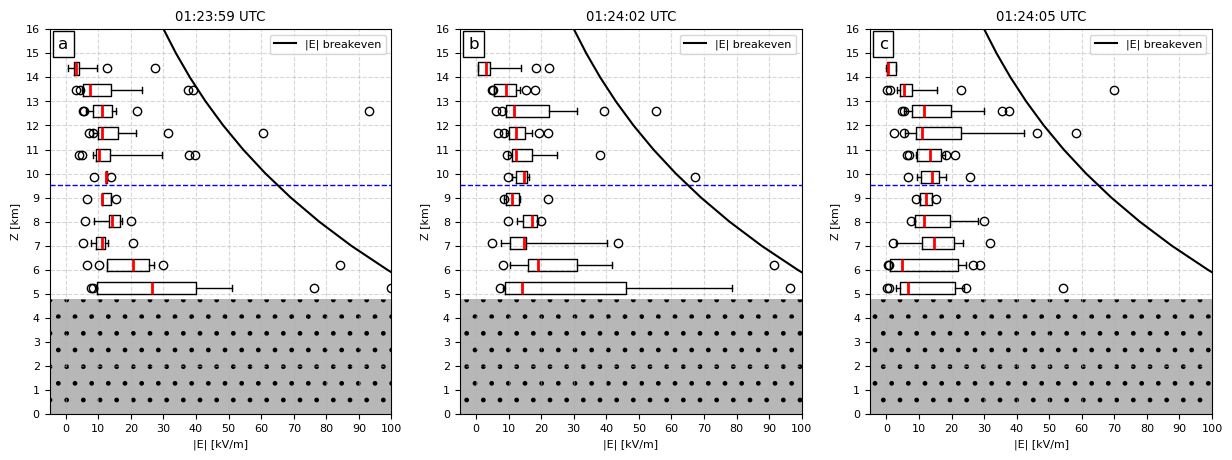

In [19]:
R, Z = np.meshgrid(np.arange(-10, 212, 10), np.arange(0, 4.769, 0.001))
C = np.ones_like(R)

# Calculate the average of 'z' along axis 0 to use for the x-axis positions.
# We use nanmean for safety, though the 'z' array in this data has no NaNs.
z_avg_per_column = np.nanmean(E_s[0]['z'], axis=0)

# Prepare 'E' data for boxplots. Matplotlib's boxplot expects a sequence of arrays,
# where each array contains the data for a single boxplot. We need to create an
# array of non-NaN values for each column of 'E'.
e_data_for_boxplot0 = [E_s[0]['E'][:, i][~np.isnan(E_s[0]['E'][:, i])] for i in range(E_s[0]['E'].shape[1])]
e_data_for_boxplot1 = [E_s[1]['E'][:, i][~np.isnan(E_s[1]['E'][:, i])] for i in range(E_s[1]['E'].shape[1])]
e_data_for_boxplot2 = [E_s[2]['E'][:, i][~np.isnan(E_s[2]['E'][:, i])] for i in range(E_s[2]['E'].shape[1])]

# Create the boxplot figure
fig, axs = plt.subplots(1,3,figsize=(15, 5))

# Plot the boxplots. The 'positions' argument places each boxplot at the
# corresponding value from our calculated z_avg_per_column.
axs.ravel()[0].boxplot(e_data_for_boxplot0, positions=z_avg_per_column, whis=(10, 90), widths=0.5, vert = False, medianprops={'color':'r', 'lw':2})
#axs.ravel()[0].plot(np.nanpercentile(E_s[0]['E'],90, 0), z_avg_per_column, 'r--', lw = 1, label = r'E 95th percentile')
axs.ravel()[0].set_title('01:23:59 UTC')

axs.ravel()[1].boxplot(e_data_for_boxplot1, positions=z_avg_per_column, whis=(10, 90), widths=0.5, vert = False, medianprops={'color':'r', 'lw':2})
#axs.ravel()[1].plot(np.nanpercentile(E_s[1]['E'],90, 0), z_avg_per_column, 'r--', lw = 1, label = r'E 95th percentile')
axs.ravel()[1].set_title('01:24:02 UTC')

axs.ravel()[2].boxplot(e_data_for_boxplot2, positions=z_avg_per_column, whis=(10, 90), widths=0.5, vert = False, medianprops={'color':'r', 'lw':2})
#axs.ravel()[2].plot(np.nanpercentile(E_s[2]['E'],90, 0), z_avg_per_column, 'r--', lw = 1, label = r'E 95th percentile')
axs.ravel()[2].set_title('01:24:05 UTC')

letters = list(string.ascii_lowercase)
for n,ax in enumerate(axs.ravel()):
    ax.annotate(letters[n], xy = (0.025, 0.95), xycoords = 'axes fraction', fontsize = 12, bbox={'facecolor':'white', 'clip_on':True}, zorder = 50)
    ax.contourf(R, Z, C, colors='gray', hatches=['.'], alpha=0.56, label='N/A')
    ax.axhline(9.526, c='b', linestyle='--', lw=1)
    ax.plot(breakeven(np.arange(0,17)), np.arange(0,17), 'k', label = '|E| breakeven')
    ax.set_xlim(-5, 100)
    ax.set_xticks(np.arange(0,110, 10))
    ax.set_ylim(0, 16)
    ax.set_yticks(np.arange(0,17, 1),
           ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])
    ax.grid(ls = '--', alpha = 0.5)
    ax.legend()
    ax.set_xlabel('|E| [kV/m]')
    ax.set_ylabel('Z [km]')

plt.savefig('profile.png', dpi = 300, bbox_inches='tight')